# Feature Engineering for Cambridge UK Weather Forecasting

Feature engineering for time series analysis of Cambridge UK temperature measurements taken at the [University computer lab weather station](https://www.cl.cam.ac.uk/research/dtg/weather/).

This notebook is being developed on [Google Colab](https://colab.research.google.com).  Initially I was most interested in short term temperature forecasts (less than 2 hours) but now mostly produce results up to 24 hours in the future for comparison with earlier [baselines](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/cammet_baselines_2021.ipynb).

See my previous notebooks, web apps etc:
 * [Cambridge UK temperature forecast python notebooks](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks)
 * [Cambridge UK temperature forecast R models](https://github.com/makeyourownmaker/CambridgeTemperatureModel)
 * [Bayesian optimisation of prophet temperature model](https://github.com/makeyourownmaker/BayesianProphet)
 * [Cambridge University Computer Laboratory weather station R shiny web app](https://github.com/makeyourownmaker/ComLabWeatherShiny)

The linked notebooks, web apps etc contain further details including:
 * data description
 * data cleaning and preparation
 * data exploration

In particular, see the notebooks:
 * [cammet_baselines_2021](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/cammet_baselines_2021.ipynb) including persistent, simple exponential smoothing, Holt Winter's exponential smoothing and vector autoregression
 * [keras_mlp_fcn_resnet_time_series](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/keras_mlp_fcn_resnet_time_series.ipynb), which uses a streamlined version of data preparation from [Tensorflow time series forecasting tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series)
 * [lstm_time_series](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/lstm_time_series.ipynb) with stacked LSTMs, bidirectional LSTMs and ConvLSTM1D networks
 * [cnn_time_series](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/cnn_time_series.ipynb) with Conv1D, multi-head Conv1D, Conv2D and Inception-style models
 * [encoder_decoder](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/encoder_decoder.ipynb) which includes autoencoder with attention, encoder decoder with teacher forcing, transformer with teacher forcing and padding, encoder only with MultiHeadAttention
 * [gradient_boosting](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/gradient_boosting.ipynb) lightGBM models with darts time series framework and Borota-style shadow variables for feature selection
 * [tsfresh_feature_engineering](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/tsfresh_feature_engineering.ipynb) automated feature engineering and selection for time series analysis of Cambridge UK weather measurements

Most of the above repositories, notebooks, web apps etc were built on both less data and less thoroughly cleaned data.

---

## Table of Contents


**TODO** Add internal links before "final" commits

Some sections may get added/deleted during development.

Don't want any broken links, so finish later.


Code Setup
 * Library Imports
 * Environment Variables
 * Custom Functions

Data Setup
 * [Import ComLab Data](#import)
 * Meteorological Feature Calculations
 * Solar Feature Calculations
 * Split Data
 * Seasonal Decomposition
    * prophet
    * statsmodels - unobserved componets model

Exploratory Data Analysis
 * Auto-correlation and Partial Autocorrelation Plots
 * Stationarity Tests

Feature Engineering
 * Rolling Statistics
 * catch22
 * tsfeatures
 * Bivariate Features

Conclusion
 * What Worked
 * What Failed
 * Rejected Ideas
 * Future Work

Metadata


## Code Setup

### Install tsfeatures Library

Install [tsfeatures](https://github.com/Nixtla/tsfeatures) because it is currently not available on google colab.

**WARNING**: You may need to restart the google colab runtime after this install.

In [1]:
!pip install tsfeatures

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 kB 15.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 5.3 MB/s eta 0:00:00
  Created wheel for antropy: filename=antropy-0.1.6-py3-none-any.whl size=16880 sha256=5fc9b704df912bd4425c88cfbe59140cd14ea428dbc94205a011208aaf4fa163
  Stored in directory: /root/.cache/pip/wheels/98/22/06/e91d7bb213c7133d5e2eb34258623e1e19928d5f05e1ee6812
  Created wheel for supersmoother: filename=supersmoother-0.4-py3-none-any.whl size=16145 sha256=4070ba281d12fa568f8222c3c9a66bf13864e06d54c07f444413c6c9e26d4485
  Stored in directory: /root/.cache/pip/wheels/cf/6a/f2/3d545d90957029bf34179d21e077f84eeb96d7dfe668268494
Successfully built antropy supersmoother



### Load Libraries

Load most of the required packages.

In [2]:
import re
import sys
import math
import timeit
import datetime
import itertools
import subprocess
import pkg_resources

import numpy as np
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from tqdm import tqdm
from scipy import stats, special
from prophet import Prophet
from itertools import product
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf, lagmat, coint
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.utils import check_X_y
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.feature_selection import f_regression, mutual_info_regression, r_regression


# Reduces variance in results but won't eliminate it :-(
%env PYTHONHASHSEED=0
import random

# set seed to make all processes deterministic
seed = 0
random.seed(seed)
np.random.seed(seed)


%matplotlib inline


# Prevent warnings in sanity_check_before_after_dfs and related functions
import warnings

env: PYTHONHASHSEED=0



### Environment Variables

Set some environment variables:


In [3]:
HORIZON = 48
Y_COL   = 'y_des' # 'y_des_fft' 'y_res' 'y'
CORE_FEATS = [Y_COL, 'dew.point_des', 'humidity', 'pressure']
FUT_FEATS  = ['irradiance', 'za_rad', 'azimuth_cos']

DAY  = 24 * 60 * 60
YEAR = 365.2425 * DAY

DAILY_OBS  = 48
YEARLY_OBS = int(365.2425 * DAILY_OBS)  # annual observations
DAY_SECS_STEP = int(DAY / DAILY_OBS)

VALID_YEAR = 2021
TEST_YEAR  = 2022


### Custom Functions

Next, define some utility functions:
 * `rmse_`
 * `mse_`
 * `mae_`
 * `summarise_backtest`
 * `print_rmse_mae`
 * `drop_cols_correlated_with_feat_cols`
 * `drop_problem_cols`
 * `summarise_historic_comparison`
 * `plot_lagged_feat_imp_subplot`
 * `get_pastcov_features`
 * `get_pastcov_lags`
 * `plot_lagged_feature_importances`
 * `plot_feature_importances`
 * `get_feature_importances`
 * `expand_grid`
 * `keep_key`
 * `get_historic_comparison`
 * `_plot_xy_for_label`
 * `plot_multistep_obs_vs_preds`
 * `plot_multistep_obs_vs_mean_preds_by_step`
 * `plot_multistep_obs_preds_dists`
 * `plot_multistep_residuals`
 * `plot_multistep_residuals_dist`
 * `plot_multistep_residuals_vs_predicted`
 * `se_`
 * `metric_ci_vals`
 * `plot_horizon_metrics`
 * `plot_horizon_metrics_boxplots`
 * `plot_multistep_diagnostics`
 * `_filter_out_missing`
 * `plot_multistep_forecast_examples`
 * `get_rmse_mae_from_backtest`
 * `plot_catboost_learning_curve`
 * `plot_lgb_learning_curve`
 * `drop_correlated_cols`
 * `get_feature_selection_scores`
 * `plot_observation_examples`
 * `sanity_check_df_rows_cols_labels`
 * `sanity_check_before_after_dfs`
 * `sanity_check_train_valid_test`
 * `print_train_valid_test_shapes`
 * `plot_feature_history`
 * `plot_feature_history_separately`
 * `check_high_low_thresholds`
 * `get_features_filename`
 * `merge_data_and_aggs`
 * `get_rolling_features`
 * `finalise_rolling_features`
 * `print_null_columns`
 * `print_na_locations`
 * `get_features`
 * `get_darts_series`
 * `plot_short_term_acf`
 * `plot_long_term_acf`



In [4]:
def _check_obs_preds_lens_eq(obs, preds):
    obs_preds_lens_eq = 1

    if len(obs) != len(preds):
        print("obs:  ", len(obs))
        print("preds:", len(preds))
        obs_preds_lens_eq = 0

    return obs_preds_lens_eq


def rmse_(obs, preds):
    if _check_obs_preds_lens_eq(obs, preds) == 0:
        stop()
    else:
        return np.sqrt(np.mean((obs - preds) ** 2))


def mse_(obs, preds):
    if _check_obs_preds_lens_eq(obs, preds) == 0:
        stop()
    else:
        return np.mean((obs - preds) ** 2)


def mae_(obs, preds):
    "mean absolute error - equivalent to the keras loss function"
    if _check_obs_preds_lens_eq(obs, preds) == 0:
        stop()
    else:
        return np.mean(np.abs(obs - preds))      # keras loss
        # return np.median(np.abs(obs - preds))  # earlier baselines


def print_rmse_mae(obs, preds, postfix_str, prefix_str = '', digits = 6):
    print(prefix_str, "Backtest RMSE ", postfix_str, ": ",
          round(rmse_(obs, preds), digits),
          sep='')
    print(prefix_str, "Backtest MAE ",  postfix_str, ":  ",
          round( mae_(obs, preds), digits),
          sep='')
    print()


def drop_cols_correlated_with_feat_cols(df, feats_df, threshold=0.95):
  for feat_col in feats_df.columns:
    corrs = df.corrwith(feats_df[feat_col])
    drop_cols = corrs[(corrs > threshold) & (corrs != 1.0)]

    for i in range(len(drop_cols)):
      drop_col = drop_cols.index[i]
      if drop_col in df.columns:  # and drop_col not in feats_df.columns:
        del df[drop_col]

  return df


def drop_problem_cols(df, lag, drop_cor=True,
                      var_cutoff=0.05, cor_cutoff=0.95, na_cutoff=0.05,
                      verbose = False):

  if verbose:
    print('drop_problem_cols - start:', df.shape)


  # drop all NA columns
  df = df.dropna(axis = 1, how = 'all')

  if verbose:
    print('drop_problem_cols - after dropna:', df.shape)


  # drop single value columns
  df = df.loc[:, (df != df.iloc[lag]).any()]

  if verbose:
    print('drop_problem_cols - after drop single value cols:', df.shape)


  # drop low variance columns
  if 'ds' in df.columns:
    df = df.drop(['ds'], axis=1)
    df = df.loc[:, df.std() > var_cutoff]
    df['ds'] = df.index
  else:
    df = df.loc[:, df.std() > var_cutoff]

  if verbose:
    print('drop_problem_cols - after drop low var cols:', df.shape)


  # drop highly correlated columns
  if drop_cor:
    df = drop_correlated_cols(df, cor_cutoff)

  if verbose:
    print('drop_problem_cols - after drop correlated cols:', df.shape)


  # drop cols with high % of NA values
  pc_thresh = int(na_cutoff * df.shape[0])
  #print('five_pc_thresh:', five_pc_thresh)
  print('columns with null values:')
  display(df.isnull().sum())
  df = df.loc[:, df.isnull().sum() < pc_thresh]

  if verbose:
    print('drop_problem_cols - after drop high % of NAs:', df.shape)

  return df


def expand_grid(dictionary):
   return pd.DataFrame([row for row in product(*dictionary.values())],
                       columns = dictionary.keys())


def keep_key(d, k):
  """ models = keep_key(models, 'datasets') """
  return {k: d[k]}


def plot_one_step_abs_err_boxplot(one_step, title):
  one_step['abs_err'] = np.abs(one_step['res'])
  one_step[['abs_err']].boxplot(meanline  = False,
                                showmeans = True,
                                showcaps  = True,
                                showbox   = True,
                                # showfliers = False,
                                )
  plt.title(title + '\nboxplot with mean and median')
  plt.suptitle('')
  plt.ylabel('absolute error')
  plt.show()


def plot_one_step_residuals_dist(one_step, title):
  plt.figure(figsize = (12, 16))
  plt.subplot(5, 1, 5)
  pd.Series(one_step['res']).plot(kind = 'density', label='residuals')
  plt.xlim(-10, 10)
  plt.title(title)
  plt.show()


def plot_one_step_residuals(one_step, title):
  x_miss = one_step.loc[one_step['missing'] == 1.0, 'obs'].index
  y_miss = one_step.loc[one_step['missing'] == 1.0, 'res']

  plt.figure(figsize = (12, 16))
  plt.subplot(5, 1, 4)
  plt.scatter(x = one_step.index, y = one_step['res'])
  plt.scatter(x_miss, y_miss, color='red', label='missing')
  plt.axhline(y = 0, color = 'grey')
  plt.xlabel('Index position')
  plt.ylabel('Residuals')
  plt.legend(loc='lower right')
  plt.title(title)
  plt.show()


def plot_one_step_obs_preds_dists(one_step, title):
  obs   = one_step['obs']
  preds = one_step['preds']
  r2score = r2_score(obs, preds)

  plt.figure(figsize = (12, 16))
  plt.subplot(5, 1, 3)
  pd.Series(obs).plot(kind = 'density', label='observations')
  pd.Series(preds).plot(kind = 'density', label='predictions')
  plt.xlim(-10, 40)
  plt.title(title)
  plt.legend()
  plt.annotate("$R^2$ = {:.3f}".format(r2score), (-7.5, 0.055))
  # plt.tight_layout()
  plt.show()


def plot_one_step_obs_vs_preds(one_step, title):

  obs   = one_step['obs']
  preds = one_step['preds']
  x_miss = one_step.loc[one_step['missing'] == 1.0, 'obs']
  y_miss = one_step.loc[one_step['missing'] == 1.0, 'preds']

  r2score = r2_score(obs, preds)

  plt.figure(figsize = (12, 16))
  plt.subplot(5, 1, 1)
  plt.scatter(x = obs, y = preds)
  plt.scatter(x_miss, y_miss, color='red', label='missing')
  plt.axline((0, 0), slope=1.0, color="grey")
  plt.xlabel('Observations')
  plt.ylabel('Predictions')
  plt.legend(loc='lower right')
  plt.annotate("$R^2$ = {:.3f}".format(r2score), (-9, 31))
  plt.title(title)
  plt.xlim((-10, 35))
  plt.ylim((-10, 35))
  plt.show()


def plot_one_step_diagnostics(model, data, val_series, val_pastcov_series, title, val_fut_cov=None):
  plot_feature_importances(model)

  # re-seasonalise observations
  if Y_COL == 'y_des':
    obs = data['y_des'] + data['y_yearly'] + data['y_daily'] + data['y_trend']
  elif Y_COL == 'y_des_fft':
    obs = data['y_des_fft'] + data['y_fft']
  else:
    obs = data[Y_COL]

  # print('data:', data.shape)
  # display(data[['y_des_fft', 'y_fft']])
  # print('obs:', obs.shape)
  # display(obs)

  if val_fut_cov is None:
    res = model.residuals(series = val_series,
                          past_covariates = val_pastcov_series,
                          retrain = False).pd_series()
  else:
    res = model.residuals(series = val_series,
                          past_covariates = val_pastcov_series,
                          future_covariates = val_fut_cov,
                          retrain = False).pd_series()

  preds = obs + res
  preds = preds.dropna()
  obs  = obs[preds.index]
  res  = res[preds.index]
  miss = data.loc[preds.index, 'missing']

  print_rmse_mae(obs, preds, '1st', '# ')

  one_step = pd.concat([obs, preds, res, miss], axis=1)
  one_step.columns = ['obs', 'preds', 'res', 'missing']

  title = 'step = 1 ' + title
  plot_one_step_obs_vs_preds(one_step, title)
  # plot_obs_vs_mean_preds_by_step(hist, title)
  plot_one_step_obs_preds_dists(one_step, title)
  plot_one_step_residuals(one_step, title + ' residuals')
  plot_one_step_residuals_dist(one_step, title + ' residuals density')
  plot_one_step_residuals_acf(one_step, title + ' residuals acf')
  plot_one_step_residuals_qq(one_step, title + ' residuals qq-plot')
  plot_one_step_abs_err_boxplot(one_step, title)


def plot_one_step_residuals_qq(one_step, title_):
  fig, axs = plt.subplots(figsize=(6, 6))
  sm.qqplot(one_step['res'], line='q', ax=axs)
  axs.set_title(title_)
  plt.show()


def plot_one_step_residuals_acf(one_step, title_, max_lags = 300):
  plt.figure(figsize = (6, 6))

  acf = pd.DataFrame()
  acf_feat = 'res'

  acf[acf_feat] = [one_step[acf_feat].autocorr(l) for l in range(1, max_lags)]
  plt.plot(acf[acf_feat], label='residual')

  plt.axhline(0, linestyle='--', c='black')
  plt.ylabel('autocorrelation')
  plt.xlabel('time lags')
  plt.title(title_)
  plt.show()


def _plot_xy_for_label(data, label, x_feat, y_feat, color):
    x = data.loc[data[label] == 1.0, x_feat]
    y = data.loc[data[label] == 1.0, y_feat]

    if len(x) > 0:
        plt.scatter(x = x, y = y, color=color, alpha=0.5, label=label)


def se_(obs, preds, metric):
    '''Standard error of sum of squared residuals or sum of absolute residuals'''

    if _check_obs_preds_lens_eq(obs, preds) == 0:
        stop()

    if metric == 'rmse':
        se = np.sqrt(np.sum((obs - preds) ** 2) / len(obs))
    elif metric == 'mae':
        se = np.sqrt(np.sum(np.abs(obs - preds)) / len(obs))
    else:
        print('Unrecognised metric:', metric)
        print("metric should be 'rmse' or 'mae'")
        stop()

    return se


def metric_ci_vals(test_val, se, z_val = 1.95996):
    cil = z_val * se
    # print('cil:', cil)
    metric_cil = test_val - cil
    metric_ciu = test_val + cil

    return metric_cil, metric_ciu


# TODO: Remove unused confidence intervals
# NOTE: VAR baseline metrics cvar_rmse and cvar_mae hardcoded to 48 steps
def plot_horizon_metrics(hist, title, y_col=Y_COL, horizon = HORIZON, ci=False):
    steps = [i for i in range(1, horizon+1)]

    # calculate metrics
    z_val_95 = 1.95996
    z_val_50 = 0.674
    rmse_h,   mae_h    = np.zeros(horizon), np.zeros(horizon)
    res_se_h, abs_se_h = np.zeros(horizon), np.zeros(horizon)
    rmse_ciu, rmse_cil = np.zeros(horizon), np.zeros(horizon)
    mae_ciu,  mae_cil  = np.zeros(horizon), np.zeros(horizon)

    for i in range(1, horizon+1):
      obs   = hist.loc[hist['step'] == i, y_col]
      preds = hist.loc[hist['step'] == i, 'pred']
      rmse_h[i-1] = rmse_(obs, preds)
      mae_h[i-1]  =  mae_(obs, preds)
      res_se_h[i-1] = se_(obs, preds, 'rmse')
      abs_se_h[i-1] = se_(obs, preds, 'mae')
      # mae_h[i]  = np.median(np.abs(obs - preds))  # for comparison with baselines
      rmse_cil[i-1], rmse_ciu[i-1] = metric_ci_vals(rmse_h[i-1], res_se_h[i-1], z_val_50)
      mae_cil[i-1],  mae_ciu[i-1]  = metric_ci_vals(mae_h[i-1],  abs_se_h[i-1], z_val_50)

    # print('rmse_h:', rmse_h)
    # print('mae_h:',  mae_h)

    # plot metrics for horizons
    fig, axs = plt.subplots(1, 2, figsize = (14, 7))
    fig.suptitle(title + ' forecast horizon errors')
    axs = axs.ravel()


    mean_val_lab = title + ' mean value'
    axs[0].plot(steps, rmse_h, color='green', label=title)

    if ci is True:
      axs[0].fill_between(steps, rmse_cil, rmse_ciu, color='green', alpha=0.25)

    # i - initial, u - updated, c - corrected
    #ivar_rmse = np.array([0.39, 0.52, 0.64, 0.75, 0.86, 0.96, 1.06, 1.15, 1.23,
    #                     1.31, 1.38, 1.45, 1.51, 1.57, 1.63, 1.68, 1.73, 1.77,
    #                     1.81, 1.85, 1.89, 1.92, 1.96, 1.99, 2.02, 2.05, 2.08,
    #                     2.1 , 2.13, 2.15, 2.18, 2.2 , 2.22, 2.24, 2.26, 2.28,
    #                     2.3 , 2.31, 2.33, 2.35, 2.36, 2.38, 2.39, 2.4 , 2.42,
    #                     2.43, 2.44, 2.45])
    # NOTE: uvar_rmse tested on test_df
    #uvar_rmse = np.array([0.36, 0.49, 0.6, 0.7, 0.8, 0.89, 0.98, 1.06, 1.14,
    #                      1.21, 1.28, 1.35, 1.41, 1.47, 1.52, 1.57, 1.62, 1.66,
    #                      1.7, 1.74, 1.78, 1.81, 1.84, 1.87, 1.9, 1.93, 1.96,
    #                      1.99, 2.01, 2.03, 2.06, 2.08, 2.1, 2.12, 2.14, 2.16,
    #                      2.18,  2.19, 2.21, 2.23, 2.24, 2.26, 2.27, 2.29, 2.3,
    #                      2.31, 2.33, 2.34])
    cvar_rmse = np.array([0.49318888, 0.70222546, 0.88570688, 1.05495349,
    1.21081157, 1.34945832, 1.46844034, 1.57779714, 1.67754323, 1.7665827,
    1.84567039, 1.91561743, 1.97899766, 2.03616174, 2.08661944, 2.13396441,
    2.17809725, 2.21946156, 2.25780078, 2.29370568, 2.3272055,  2.35760153,
    2.38520845, 2.41076185, 2.43404716, 2.45466806, 2.47361784, 2.49117761,
    2.50625606, 2.52023589, 2.53319205, 2.54566125, 2.55764924, 2.56870554,
    2.57976955, 2.59102429, 2.6018822, 2.61242356, 2.62280045, 2.63353767,
    2.64410312, 2.65458709, 2.66532837, 2.67609086, 2.68675178, 2.69745108,
    2.71002892, 2.72445726])
    #axs[0].plot(steps, ivar_rmse, color='black', label='Initial VAR')
    axs[0].plot(steps, cvar_rmse, color='blue', label='Updated VAR')
    axs[0].hlines(np.mean(rmse_h), xmin=1, xmax=horizon,
                  color='green', linestyles='dotted', label=mean_val_lab)
    axs[0].hlines(np.mean(cvar_rmse), xmin=1, xmax=horizon,
                  color='blue', linestyles='dotted', label='Updated VAR mean value')
    axs[0].set_xlabel("horizon - half hour steps")
    axs[0].set_ylabel("rmse")


    axs[1].plot(steps, mae_h, color='green', label=title)

    if ci is True:
      axs[1].fill_between(steps, mae_cil, mae_ciu, color='green', alpha=0.25)

    # NOTE: ivar_mae tested on test_df
    #ivar_mae = np.array([0.39, 0.49, 0.57, 0.66, 0.74, 0.83, 0.91, 0.98, 1.05,
    #                    1.12, 1.18, 1.24, 1.29, 1.34, 1.39, 1.43, 1.47, 1.5 ,
    #                    1.53, 1.56, 1.59, 1.62, 1.64, 1.66, 1.68, 1.7 , 1.72,
    #                    1.73, 1.75, 1.76, 1.77, 1.78, 1.8 , 1.81, 1.82, 1.83,
    #                    1.83, 1.84, 1.85, 1.85, 1.86, 1.86, 1.87, 1.87, 1.88,
    #                    1.88, 1.89, 1.89])
    #uvar_mae = np.array([0.36, 0.45, 0.53, 0.61, 0.69, 0.76, 0.83, 0.9, 0.97,
    #                     1.03, 1.09, 1.14, 1.19, 1.24, 1.28, 1.32, 1.36, 1.4,
    #                     1.43, 1.46, 1.49, 1.52, 1.54, 1.56, 1.58, 1.6, 1.62,
    #                     1.63, 1.65, 1.66, 1.68, 1.69, 1.7, 1.71, 1.72, 1.73,
    #                     1.74, 1.74, 1.75, 1.75, 1.76, 1.76, 1.77, 1.77, 1.78,
    #                     1.78, 1.78, 1.78])
    cvar_mae = np.array([0.34694645, 0.50765333, 0.65132003, 0.78584432,
    0.9077075,  1.01705088, 1.11113622, 1.19759807, 1.27696634, 1.34941444,
    1.4134705,  1.47180058, 1.52304802, 1.56961154, 1.60903759, 1.64763418,
    1.68391297, 1.71690735, 1.74787094, 1.77721642, 1.80442554, 1.82951782,
    1.85358226, 1.87488643, 1.89346337, 1.91069565, 1.92613218, 1.94071845,
    1.95245349, 1.96323923, 1.9736734,  1.98370815, 1.99367508, 2.00204077,
    2.00992601, 2.01796976, 2.02747736, 2.03477489, 2.04173317, 2.04985428,
    2.05843847, 2.06731348, 2.07606609, 2.08533656, 2.09560914, 2.10668272,
    2.1183637,  2.13164371])
    #axs[1].plot(steps, ivar_mae, color='black', label='Initial VAR')
    axs[1].plot(steps, cvar_mae, color='blue', label='Updated VAR')
    axs[1].hlines(np.mean(mae_h), xmin=1, xmax=horizon,
                  color='green', linestyles='dotted', label=mean_val_lab)
    axs[1].hlines(np.mean(cvar_mae), xmin=1, xmax=horizon,
                  color='blue', linestyles='dotted', label='Updated VAR mean value')
    axs[1].set_xlabel("horizon - half hour steps")
    axs[1].set_ylabel("mae")

    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
    plt.show()


def plot_horizon_metrics_boxplots(hist, title):

  hist['abs_err'] = np.abs(hist['res'])
  hist[['abs_err', 'step']].boxplot(by='step',
                                    meanline=False,
                                    showmeans=True,
                                    showcaps=True,
                                    showbox=True,
                                    showfliers=False,
                                    )
  plt.title(title + '\nboxplots with mean and median')
  plt.suptitle('')
  plt.xlabel("horizon - half hour steps")
  plt.ylabel("absolute error")
  x_step = 10.0
  x_max  = np.ceil(np.max(hist.step) / x_step) * int(x_step)
  plt.xticks(np.arange(0, x_max, int(x_step)))
  plt.show()


# TODO Refactor this
#      miss, preds, obs, res, err, dates etc "family" of variables
#      is a warning sign
#      try-catch around lagged_miss is clear indication of upsteam issues
#      Consider using a better data structure
#      See also: plot_forecast_examples immediately below
def _filter_out_missing(pos_neg_rmse_all, miss, lags, subplots):
    '''Check if obs (lags and horizon) missing == 1.0
    and
    Avoid contiguous indices'''

    # print("pos_neg_rmse_all:", pos_neg_rmse_all)

    pos_neg_rmse = pd.Series(subplots)
    subplot_count = j = 0

    while subplot_count < subplots:
      restart = False
      idx = pos_neg_rmse_all.index[j]
      # print(j, idx, pos_neg_rmse_all.loc[pos_neg_rmse_all.index[j]])

      # Avoid indices in the first few observations
      # Would be incomplete
      if idx < lags:
        # print('idx < lags:', idx)
        j += 1
        continue

      # Avoid contiguous indices - don't want 877, 878, 879
      if subplot_count > 0:
        for i in range(subplot_count):
          if abs(idx - pos_neg_rmse[i]) < lags:
            # print('contiguous indices - idx, pos_neg_rmse[i]:', idx, pos_neg_rmse[i])
            restart = True
            break

      if restart is False:
        try:
            lagged_miss = (miss.loc[idx - lags, :] == 1.0).any()
        except KeyError:
            lagged_miss = True

        horizon_miss = (miss.loc[idx, :] == 1.0).any()
        missing = lagged_miss or horizon_miss
        # print("\nlagged_miss:", lagged_miss)
        # print("horizon_miss:",  horizon_miss)
        # print("missing:", missing)

        if missing is False:
          pos_neg_rmse[subplot_count] = idx
          subplot_count += 1
        #else:
        #  print('missing')

      j += 1

    return pos_neg_rmse


def get_main_plot_title(pre_str, lag_params, mod_params):
  lag_params_str = ', '.join([f"{' '.join(map(str, v))}" for v in lag_params.items()])
  mod_params_str = ', '.join([f"{' '.join(map(str, v))}" for v in mod_params.items()])
  plot_title = pre_str + lag_params_str + '\n' + mod_params_str

  return plot_title


def drop_correlated_cols(dataset, threshold=0.95):
  '''Adapted from https://stackoverflow.com/a/44674459/100129'''

  col_corr = set()  # Set of all the names of deleted columns
  corr_matrix = dataset.corr(numeric_only=True).abs()

  for i in range(len(corr_matrix.columns)):
    for j in range(i):
      if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
        colname = corr_matrix.columns[i]
        col_corr.add(colname)
        if colname in dataset.columns:
          del dataset[colname]

  return dataset


def get_feature_selection_scores(df, sel_cols, y_col=Y_COL, sort_col='f_test'):
  '''WARNING: These tests assume a linear model.  This may not be optimal.

     Don't draw any hasty conclusions from these scores.
  '''

  dfcols  = df.columns
  matches = ['_window_', '_zscore_', '_scaled_']
  feat_cols = [dfcol for dfcol in dfcols if any([x in dfcol for x in matches])]
  # feat_cols = [df_col for df_col in df_cols if '_window_' in df_col ]
  feat_cols.extend(sel_cols)

  cols = [*feat_cols, y_col]
  # df_nona = df.dropna()
  # df_nona = df.loc[:, cols].dropna()
  df_nona = df[cols].dropna()
  X_df = df_nona[feat_cols]
  y_df = df_nona[y_col]

  mi_feats = mutual_info_regression(X_df, y_df)
  mi_feats /= np.sum(mi_feats)

  f_tests, _ = f_regression(X_df, y_df)
  f_tests /= np.sum(f_tests)

  r_tests = r_regression(X_df, y_df)
  r_tests /= np.sum(r_tests)

  # Correlations with Y_COL
  # corrs = []
  # for feat in feat_cols:
  #   corrs.append(X_df[feat].corr(y_df))

  fs_df = pd.DataFrame({#'correlation': corrs,
                        'r_test': r_tests.round(6),
                        'f_test': f_tests.round(6),
                        'mi':     mi_feats,
                       })
  fs_df.index = feat_cols

  if sort_col == 'f_test':
    fs_df = fs_df.sort_values('f_test', ascending=False)
  elif sort_col == 'r_test':
    fs_df = fs_df.sort_values('r_test', ascending=False)
  elif sort_col == 'mi':
    fs_df = fs_df.sort_values('mi', ascending=False)

  return fs_df


def plot_observation_examples(df, cols, num_plots = 9):
    """Plot 9 sets of observations in 3 * 3 matrix"""

    num_plots_sqrt = int(np.sqrt(num_plots))
    assert num_plots_sqrt ** 2 == num_plots

    days = df.ds.dt.date.sample(n = num_plots).sort_values()
    p_data = [df[df.ds.dt.date.eq(days[i])] for i in range(num_plots)]

    fig, axs = plt.subplots(num_plots_sqrt, num_plots_sqrt, figsize = (15, 10))
    axs = axs.ravel()  # apl for the win :-)

    for i in range(num_plots):
        for col in cols:
            axs[i].plot(p_data[i]['ds'], p_data[i][col])
            axs[i].xaxis.set_tick_params(rotation = 20, labelsize = 10)

    fig.suptitle('Observation examples')
    fig.legend(cols, loc = 'lower center',  ncol = len(cols))

    return None


def sanity_check_df_rows_cols_labels(before, after,
                                     row_var_cutoff=0.005, col_var_cutoff=0.05,
                                     col_corr_cutoff=0.,
                                     fast=True, verbose=False):
  '''Sanity check dataframes before and after modifications

  WARN: default row_var_cutoff, col_var_cutoff, col_corr_cutoff are fairly arbitrary
        there is some redundancy between these tests

  '''

  print_v = print if verbose else lambda *a, **k: None

  df = pd.DataFrame(columns = ['before', 'after', 'diff'])
  df_labels = []

  label = 'rows'
  # start_time = timeit.default_timer()
  i = 0
  df.loc[len(df), df.columns] = before.shape[i], after.shape[i], 0
  df_labels.append(label)
  # print('\t', label, round(timeit.default_timer() - start_time, 2))

  label = 'cols'
  # start_time = timeit.default_timer()
  i = 1
  df.loc[len(df), df.columns] = before.shape[i], after.shape[i], 0
  df_labels.append(label)
  # print('\t', label, round(timeit.default_timer() - start_time, 2))

  label = 'missing_rows'
  # start_time = timeit.default_timer()
  i = 0
  before_after = pd.merge(before, after, left_index=True, right_index=True, how='outer', indicator=True)
  missing_rows = before_after.loc[before_after['_merge'] == 'left_only', :]
  df.loc[len(df), df.columns] = 0, missing_rows.shape[i], 0
  if missing_rows.shape[i] > 0:
    print_v('\n', label, ':')
    print_v(missing_rows)
  df_labels.append(label)
  # print('\t', label, round(timeit.default_timer() - start_time, 2))

  label = 'missing_cols'
  # start_time = timeit.default_timer()
  i = 1
  common_cols = before.columns.intersection(after.columns)
  missing_cols = before.shape[i] - len(common_cols)
  df.loc[len(df), df.columns] = 0, missing_cols, 0
  if missing_cols > 0:
    print_v('\n', label, ':')
    print_v(set(before.columns) - set(common_cols))
  df_labels.append(label)
  # print('\t', label, round(timeit.default_timer() - start_time, 2))

  label = 'total_nas'
  # start_time = timeit.default_timer()
  df.loc[len(df), df.columns] = before.isna().sum().sum(), \
                                after.isna().sum().sum(), 0
  df_labels.append(label)
  # print('\t', label, round(timeit.default_timer() - start_time, 2))

  label = 'rows_with_nas'
  # start_time = timeit.default_timer()
  before_rows_nas = before.isnull().any(axis=1).sum()
  after_rows_nas  = after.isnull().any(axis=1).sum()
  df.loc[len(df), df.columns] = before_rows_nas, after_rows_nas, 0
  if before_rows_nas != after_rows_nas:
    print_v('\n', label, ':')
    print_v(before[before.isnull().any(axis=1)])
    print_v(after[after.isnull().any(axis=1)])
  df_labels.append(label)
  # print('\t', label, round(timeit.default_timer() - start_time, 2))

  label = 'cols_with_nas'
  # start_time = timeit.default_timer()
  before_cols_nas = before.isnull().any().sum()
  after_cols_nas  = after.isnull().any().sum()
  df.loc[len(df), df.columns] = before_cols_nas, after_cols_nas, 0
  if before_cols_nas != after_cols_nas:
    print_v('\n', label, ':')
    print_v(before.isnull().any().index.values)
    print_v(after.isnull().any().index.values)
  df_labels.append(label)
  # print('\t', label, round(timeit.default_timer() - start_time, 2))

  label = 'single_value_rows'
  if not fast:
    # start_time = timeit.default_timer()
    before_single_value_rows = np.sum(before.nunique(axis=1) <= 1)
    after_single_value_rows  = np.sum(after.nunique(axis=1) <= 1)
    df.loc[len(df), df.columns] = before_single_value_rows, \
                                  after_single_value_rows, 0
    if before_single_value_rows != after_single_value_rows:
      print_v('\n', label, ':')
      print_v(before[before.nunique(axis=1) <= 1])
      print_v(after[after.nunique(axis=1) <= 1])
    df_labels.append(label)
    # print('\t', label, round(timeit.default_timer() - start_time, 2))

  label = 'single_value_cols'
  # start_time = timeit.default_timer()
  before_single_value_cols = np.sum(before.nunique() <= 1)
  after_single_value_cols  = np.sum(after.nunique() <= 1)
  df.loc[len(df), df.columns] = before_single_value_cols, \
                                after_single_value_cols, 0
  if before_single_value_cols != after_single_value_cols:
    print_v('\n', label, ':')
    print_v(before.columns[before.nunique() <= 1].values)
    print_v(after.columns[after.nunique() <= 1].values)
  df_labels.append(label)
  # print('\t', label, round(timeit.default_timer() - start_time, 2))

  # warnings.resetwarnings()

  with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    label = 'low_var_rows'
    # start_time = timeit.default_timer()
    before_low_var_rows = (before.select_dtypes(include=[np.number]).std(axis=1) <= row_var_cutoff).sum()
    after_low_var_rows  = (after.select_dtypes(include=[np.number]).std(axis=1) <= row_var_cutoff).sum()
    df.loc[len(df), df.columns] = before_low_var_rows, after_low_var_rows, 0
    if before_low_var_rows != after_low_var_rows:
      print_v('\n', label, ':')
      print_v(before.select_dtypes(include=[np.number]).std(axis=1) <= row_var_cutoff)
      print_v(after.select_dtypes(include=[np.number]).std(axis=1)  <= row_var_cutoff)
    df_labels.append(label)
    # print('\t', label, round(timeit.default_timer() - start_time, 2))

    label = 'low_var_cols'
    # start_time = timeit.default_timer()
    before_low_var_cols = (before.select_dtypes(include=[np.number]).std() <= col_var_cutoff).sum()
    after_low_var_cols  = (after.select_dtypes(include=[np.number]).std() <= col_var_cutoff).sum()
    df.loc[len(df), df.columns] = before_low_var_cols, after_low_var_cols, 0
    if before_low_var_cols != after_low_var_cols:
      print_v('\n', label, ':')
      s = before.select_dtypes(include=[np.number]).std() <= col_var_cutoff
      t = after.select_dtypes(include=[np.number]).std()  <= col_var_cutoff
      print_v(s[s].index.values)
      print_v(t[t].index.values)
    df_labels.append(label)
    # print('\t', label, round(timeit.default_timer() - start_time, 2))

  label = 'duplicate_rows'
  # start_time = timeit.default_timer()
  before_dup_rows = before.shape[0] - before.drop_duplicates().shape[0]
  after_dup_rows  = after.shape[0]  - after.drop_duplicates().shape[0]
  df.loc[len(df), df.columns] = before_dup_rows, after_dup_rows, 0
  if before_dup_rows != after_dup_rows:
    print_v('\n', label, ':')
    print_v(before[before.duplicated(keep=False)])
    print_v(after[after.duplicated(keep=False)])
  df_labels.append(label)
  # print('\t', label, round(timeit.default_timer() - start_time, 2))

  label = 'highly_correlated_cols'
  # .copy() so we don't modify the original dataframe
  if not fast:
    # start_time = timeit.default_timer()
    before_high_corr_cols = before.shape[1] - drop_correlated_cols(before.copy(), col_corr_cutoff).shape[1]
    after_high_corr_cols  = after.shape[1]  - drop_correlated_cols(after.copy(), col_corr_cutoff).shape[1]
    df.loc[len(df), df.columns] = before_high_corr_cols, after_high_corr_cols, 0
    if before_high_corr_cols != after_high_corr_cols:
      print_v('\n', label, ':')
      print_v(set(before.columns) - set(drop_correlated_cols(before.copy(), col_corr_cutoff).columns))
      print_v(set(after.columns) - set(drop_correlated_cols(after.copy(), col_corr_cutoff).columns))
    df_labels.append(label)
    # print('\t', label, round(timeit.default_timer() - start_time, 2))

  label = 'duplicate_index_labels'
  # start_time = timeit.default_timer()
  before_idx_labels = before.index.duplicated().sum()
  after_idx_labels  = after.index.duplicated().sum()
  df.loc[len(df), df.columns] = before_idx_labels, after_idx_labels, 0
  if before_idx_labels != after_idx_labels:
    print_v('\n', label, ':')
    print_v(before.index.duplicated())
    print_v(after.index.duplicated())
  df_labels.append(label)
  # print('\t', label, round(timeit.default_timer() - start_time, 2))

  label = 'duplicate_col_labels'
  # start_time = timeit.default_timer()
  before_dup_col_labels = before.columns.duplicated().sum()
  after_dup_col_labels  = after.columns.duplicated().sum()
  df.loc[len(df), df.columns] = before_dup_col_labels, after_dup_col_labels, 0
  if before_dup_col_labels != after_dup_col_labels:
    print_v('\n', label, ':')
    print_v(before.columns.duplicated())
    print_v(after.columns.duplicated())
  df_labels.append(label)
  # print('\t', label, round(timeit.default_timer() - start_time, 2))

  # TODO Find renamed columns from before in after?


  df['diff'] = df['after'] - df['before']
  df.index = df_labels

  return df


def sanity_check_before_after_dfs(before_, after_, ds_name, fast=True, verbose=False):

  print('\n', ds_name, sep='')

  # Reasons I HATE pandas number Inf a neverending series:
  # PerformanceWarning: DataFrame is highly fragmented.  This is usually the
  # result of calling `frame.insert` many times, which has poor performance.
  # Consider joining all columns at once using pd.concat(axis=1) instead. To
  # get a de-fragmented frame, use `newframe = frame.copy()`
  before = before_.copy(deep=True)
  after  = after_.copy(deep=True)

  # start_time = timeit.default_timer()
  sanity_df = sanity_check_df_rows_cols_labels(before, after, fast=fast, verbose=verbose)
  # print('\t sanity_check_df_rows_cols_labels', round(timeit.default_timer() - start_time, 2))


  # start_time = timeit.default_timer()
  print('before.index.equals(after.index):', before.index.equals(after.index))

  # check index freq is set and are equal
  print('before.index.freq == after.index.freq:', before.index.freq == after.index.freq)
  if verbose:
    print('before.index.freq:', before.index.freq)
    print('after.index.freq:',  after.index.freq)


  # check if common column dtypes have changed
  common_cols = before.columns.intersection(after.columns)
  print('before[common_cols].dtypes == after[common_cols].dtypes:',
        (before[common_cols].dtypes == after[common_cols].dtypes).all())
  if verbose:
    print('before[common_cols].dtypes:', before[common_cols].dtypes)
    print('after[common_cols].dtypes:',  after[common_cols].dtypes)

  # check if describe() summaries are equal
  print('before[common_cols].describe() == after[common_cols].describe():',
        (before[common_cols].describe() == after[common_cols].describe()).all().all())
  if verbose:
    print(before[common_cols].describe() == after[common_cols].describe())

  # check after subsetted by before equals before
  print('\nbefore[common_cols].equals(after[common_cols]):',
  before[common_cols].dropna().drop_duplicates().equals(after[common_cols].dropna().drop_duplicates())
  )
  if verbose:
    print('before.isin(after):',
    before[common_cols].dropna().drop_duplicates().isin(after[common_cols].dropna().drop_duplicates()).all().all()
    )
    print(before.dropna().drop_duplicates().isin(after.dropna().drop_duplicates()).all())
    print(before.dropna().drop_duplicates().isin(after.dropna().drop_duplicates()))


  # Reasons I HATE pandas number Inf a neverending series:
  # PerformanceWarning: DataFrame is highly fragmented.  This is usually the
  # result of calling `frame.insert` many times, which has poor performance.
  # Consider joining all columns at once using pd.concat(axis=1) instead. To
  # get a de-fragmented frame, use `newframe = frame.copy()`
  # calculate duplicate row counts then find mean duplicate count
  # for each column and finally find mean of means aka redundancy
  # warnings.resetwarnings()
  #with warnings.catch_warnings():
  #  warnings.simplefilter('ignore')
  #  before_red = before.dropna().groupby(before.select_dtypes(include=np.number).columns.tolist(), as_index=False).size().mean().mean()
  #  after_red  = after.dropna().groupby(after.select_dtypes(include=np.number).columns.tolist(), as_index=False).size().mean().mean()
  #  print('redundancy before > after:', before_red > after_red)
  #  print('mean before feature redundancy:', round(before_red, 3))
  #  print('mean after feature redundancy: ', round(after_red,  3))

  # Check all data is numeric, finite (but allow NAs) and reasonably shaped
  # If any problems then this will error out
  # Only checking 'after' dataframe
  # https://scikit-learn.org/stable/modules/generated/sklearn.utils.check_X_y.html
  if Y_COL in after.columns:
    _, _ = check_X_y(after.drop(columns=[Y_COL, 'ds']),
                     after[Y_COL],
                     y_numeric = True,
                     force_all_finite = 'allow-nan')

  print()
  # print('\t end sanity_check_before_after_dfs', round(timeit.default_timer() - start_time, 2))

  display(sanity_df)

  return sanity_df


def compare_train_valid_test_sanity_dfs(train_sanity, valid_sanity, test_sanity, ex_labels=None):
  '''...'''

  if ex_labels is None:
    ex_labels = ['rows']

  train_sanity = train_sanity.loc[~train_sanity.index.isin(ex_labels)]
  valid_sanity = valid_sanity.loc[~valid_sanity.index.isin(ex_labels)]
  test_sanity  =  test_sanity.loc[~test_sanity.index.isin(ex_labels)]

  if not train_sanity.equals(valid_sanity):
    print('WARN: train_sanity != valid_sanity')
    display(pd.concat([train_sanity, valid_sanity]).drop_duplicates(keep=False))

  if not train_sanity.equals(test_sanity):
    print('WARN: train_sanity != test_sanity')
    display(pd.concat([train_sanity, test_sanity]).drop_duplicates(keep=False))

  if not test_sanity.equals(valid_sanity):
    print('WARN: test_sanity != valid_sanity')
    display(pd.concat([test_sanity, valid_sanity]).drop_duplicates(keep=False))

  return None


def sanity_check_train_valid_test(train_df, valid_df, test_df):

  # Check number of columns is equal
  if (train_df.shape[1] != valid_df.shape[1]) or \
     (train_df.shape[1] != test_df.shape[1])  or \
     (valid_df.shape[1] != test_df.shape[1]):
    print('ERROR: Inconsistent number of columns!')
    print('train_df.shape[1]:', train_df.shape[1])
    print('valid_df.shape[1]:', valid_df.shape[1])
    print('test_df.shape[1]:',  test_df.shape[1])


  # Check column names are equal
  if not (train_df.columns == valid_df.columns).all():
    print('ERROR: Inconsistent train_df, valid_df column names!')
    print('train_df.columns:', train_df.columns)
    print('valid_df.columns:', valid_df.columns)

  if not (train_df.columns == test_df.columns).all():
    print('ERROR: Inconsistent train_df, test_df column names!')
    print('train_df.columns:', train_df.columns)
    print('test_df.columns:',  test_df.columns)

  if not (valid_df.columns == test_df.columns).all():
    print('ERROR: Inconsistent valid_df, test_df column names!')
    print('valid_df.columns:', valid_df.columns)
    print('test_df.columns:',  test_df.columns)


  # Check column dtypes are equal
  if not (train_df.dtypes == valid_df.dtypes).all():
    print('ERROR: Inconsistent train_df, valid_df dtypes!')
    print('train_df.dtypes:', train_df.dtypes)
    print('valid_df.dtypes:', valid_df.dtypes)

  if not (train_df.dtypes == test_df.dtypes).all():
    print('ERROR: Inconsistent train_df, test_df dtypes!')
    print('train_df.dtypes:', train_df.dtypes)
    print('test_df.dtypes:',  test_df.dtypes)

  if not (valid_df.dtypes == test_df.dtypes).all():
    print('ERROR: Inconsistent valid_df, test_df dtypes!')
    print('valid_df.dtypes:', valid_df.dtypes)
    print('test_df.dtypes:',  test_df.dtypes)


  # Check index freqs are equal
  if train_df.index.freq != valid_df.index.freq:
    print('ERROR: Inconsistent train_df, valid_df index frequencies!')
    print('train_df.index.freq:', train_df.index.freq)
    print('valid_df.index.freq:', valid_df.index.freq)

  if train_df.index.freq != test_df.index.freq:
    print('ERROR: Inconsistent train_df, test_df index frequencies!')
    print('train_df.index.freq:', train_df.index.freq)
    print('test_df.index.freq:',   test_df.index.freq)

  if valid_df.index.freq != test_df.index.freq:
    print('ERROR: Inconsistent valid_df, test_df index frequencies!')
    print('valid_df.index.freq:', valid_df.index.freq)
    print('test_df.index.freq:',   test_df.index.freq)


  # Verify dataframes are different!
  if train_df.equals(valid_df):
    print('ERROR: train_df == valid_df!')

  if train_df.equals(test_df):
    print('ERROR: train_df == test_df!')

  if valid_df.equals(test_df):
    print('ERROR: valid_df == test_df!')


  # Check no overlap between train_df.index and valid_df.index
  # train_df.index strictly before valid_df.index and test_df.index
  if max(train_df.index) >= min(valid_df.index):
    print('ERROR: Overlap between train_df, valid_df indices!')
    print('max(train_df.index):', max(train_df.index))
    print('min(valid_df.index):', max(valid_df.index))

  # Check no overlap between train_df.index and test_df.index
  # train_df.index strictly before valid_df.index and test_df.index
  if max(train_df.index) >= min(test_df.index):
    print('ERROR: Overlap between train_df, test_df indices!')
    print('max(train_df.index):', max(train_df.index))
    print('min(test_df.index):',  max(test_df.index))


  # Check no overlap between valid_df.index and test_df.index
  # valid_df.index can be before or after test_df.index
  if (max(valid_df.index) >= min(test_df.index)) and \
     (max(valid_df.index) <= max(test_df.index)):
    print('ERROR: Overlap between valid_df, test_df indices!')
    print('valid_df.index:', max(valid_df.index), '-', max(valid_df.index))
    print('test_df.index:',  max(test_df.index),  '-', max(test_df.index))

  if (min(valid_df.index) >= min(test_df.index)) and \
     (min(valid_df.index) <= max(test_df.index)):
    print('ERROR: Overlap between valid_df, test_df indices!')
    print('valid_df.index:', max(valid_df.index), '-', max(valid_df.index))
    print('test_df.index:',  max(test_df.index),  '-', max(test_df.index))


  # TODO: Consider enforcing a gap of 1 day to 1 week between
  #       train_df.index and {valid_df,test_df}.index to avoid data leakage?


  # Check train_df has more observations than valid_df and test_df
  if valid_df.shape[0] > train_df.shape[0]:
    print('ERROR: valid_df more observations than train_df!')
    print('train_df observations:', train_df.shape[0])
    print('valid_df observations:', valid_df.shape[0])

  if test_df.shape[0] > train_df.shape[0]:
    print('ERROR: test_df more observations than train_df!')
    print('train_df observations:', train_df.shape[0])
    print('test_df observations:',  test_df.shape[0])


  # Check valid_df and test_df have equal number of observations
  # valid_df and test_df may be different sizes but
  # large size difference may indicate an issue
  # TODO: Use calendar.isleap() to check if leap year
  if valid_df.shape[0] != test_df.shape[0]:
    print('WARN: Inconsistent number of valid_df, test_df rows.  Leap year?')


  # Check valid_df and test_df are each 1 year long
  YEAR_OBS_MIN = 48 * 365
  YEAR_OBS_MAX = 48 * 366
  if (valid_df.shape[0] < YEAR_OBS_MIN) or \
     (valid_df.shape[0] > YEAR_OBS_MAX):
    print('ERROR: valid_df should be 1 year long [',
          YEAR_OBS_MIN, ',', YEAR_OBS_MAX, ']!')
    print('valid_df observations:', valid_df.shape[0])

  if (test_df.shape[0] < YEAR_OBS_MIN) or \
     (test_df.shape[0] > YEAR_OBS_MAX):
    print('ERROR: test_df should be 1 year long [',
          YEAR_OBS_MIN, ',', YEAR_OBS_MAX, ']!')
    print('test_df observations:', test_df.shape[0])

  return None


def print_train_valid_test_shapes(df, train_df, valid_df, test_df):
  print("df shape: ",            df.shape)
  print("train shape:   ", train_df.shape)
  print("valid shape:   ", valid_df.shape)
  print("test shape:    ",  test_df.shape)

  return None


def plot_feature_history_single_df(data, var, missing=False):
    plt.figure(figsize = (12, 6))
    plt.scatter(data.index, data[var],
                label='train', color='black', s=3)
    if missing:
      label = 'missing'
      x_lab = data.loc[data[label] == 1.0, 'ds']
      y_lab = data.loc[data[label] == 1.0, var]
      plt.scatter(x_lab, y_lab, color='red', label=label, s=3)

    plt.title(var)
    plt.show()


def plot_feature_history(train, valid, test, var, missing=False):
    label = 'missing'

    plt.figure(figsize = (12, 6))
    plt.scatter(train.index, train[var],
                label='train', color='black', s=3)
    if missing:
      x_lab = train.loc[train[label] == 1.0, 'ds']
      y_lab = train.loc[train[label] == 1.0, var]
      plt.scatter(x_lab, y_lab, color='red', label=label, s=3)

    plt.scatter(valid.index, valid[var],
                label='valid', color='blue', s=3)
    if missing:
      x_lab = valid.loc[valid[label] == 1.0, 'ds']
      y_lab = valid.loc[valid[label] == 1.0, var]
      plt.scatter(x_lab, y_lab, color='red', label=label, s=3)

    plt.scatter(test.index,  test[var],
                label='test', color='purple', s=3)
    if missing:
      x_lab = test.loc[test[label] == 1.0, 'ds']
      y_lab = test.loc[test[label] == 1.0, var]
      plt.scatter(x_lab, y_lab, color='red', label=label, s=3)

    plt.title(var)
    #ax = plt.gca()
    #leg = ax.get_legend()
    #leg.legendHandles[0].set_color('black')
    #leg.legendHandles[1].set_color('red')
    #leg.legendHandles[2].set_color('blue')
    #leg.legendHandles[3].set_color('red')
    #leg.legendHandles[4].set_color('purple')
    #leg.legendHandles[5].set_color('red')
    #hl_dict = {handle.get_label(): handle for handle in leg.legendHandles}
    #hl_dict['train'].set_color('black')
    #hl_dict['valid'].set_color('blue')
    #hl_dict['test'].set_color('purple')
    #hl_dict[label].set_color('red')
    #plt.legend(['train', 'valid', 'test', label])
    plt.show()


def plot_feature_history_separately(train, valid, test, var):
    fig, axs = plt.subplots(1, 3, figsize = (14, 7))

    axs[0].plot(train.index, train[var])
    axs[0].set_title('train')

    axs[1].plot(valid.index, valid[var])
    axs[1].set_title('valid')
    axs[1].set_xticks(axs[1].get_xticks(), axs[1].get_xticklabels(), rotation=45, ha='right')

    axs[2].plot(test.index,  test[var])
    axs[2].set_title('test')
    axs[2].set_xticks(axs[2].get_xticks(), axs[2].get_xticklabels(), rotation=45, ha='right')

    fig.suptitle(var)
    plt.show()


def check_high_low_thresholds(df):
  '''Check main features from dataframe are within reasonable thresholds'''

  all_ok = True
  feats = ['y', 'dew.point', 'humidity', 'pressure',
           'wind.speed.mean', 'wind.speed.max']
  highs = [ 45,  25, 100, 1060, 35, 70]
  lows  = [-20, -20,   5,  950,  0,  0]

  thresh = pd.DataFrame({'feat': feats,
                         'high': highs,
                         'low':  lows,})
  thresh.index = feats

  for feat in feats:
    feat_high = thresh.loc[feat, 'high']
    feat_low  = thresh.loc[feat, 'low']

    if not df[feat].between(feat_low, feat_high).all():
      all_ok = False
      print('%15s [%3d, %3d] - % 7.3f, % 7.3f' %
            (feat, feat_low, feat_high,
            round(min(df[feat]), 3), round(max(df[feat]), 3)))

  # check if dew.point ever greater than temperature
  if df.loc[df['dew.point'] > df['y'], ['y', 'dew.point']].shape[0] != 0:
    all_ok = False
    print('dew.point > y:')
    display(df.loc[df['dew.point'] > df['y'], ['y', 'dew.point']])

  return None


def get_features_filename(feat_name, data_name, date_str, file_ext='.csv.xz'):
    return feat_name + data_name + date_str + file_ext


def merge_data_and_aggs(data, aggs):
  data = pd.concat((data, aggs), axis=1)
  # data = data.join(aggs)

  # data.set_index('ds', drop = False, inplace = True)
  data['ds'] = data.index
  data = data[~data.index.duplicated(keep = 'first')]
  data = data.asfreq(freq = '30min')

  # Reasons I HATE pandas number Inf a neverending series:
  # PerformanceWarning: DataFrame is highly fragmented.  This is usually the
  # result of calling `frame.insert` many times, which has poor performance.
  # Consider joining all columns at once using pd.concat(axis=1) instead. To
  # get a de-fragmented frame, use `newframe = frame.copy()`
  # data_ = data.copy()

  return data


def get_rolling_features(data, params):
  agg_func = params['agg_func']
  # aggs = pd.DataFrame()

  print('dataset:', params['dataset'])

  if params['regenerate']:
    if params['agg_func'].__name__ == 'get_bivariate_dists_kerns':
      aggs = agg_func(data,
                      params['feat_cols'],
                      params['aggs'],
                      scale   = params['scale'],
                      z_score = params['z_score'],
                      verbose = params['verbose'],)
    elif params['agg_func'].__name__ == 'get_rolling_tsfeatures':
      aggs = agg_func(data,
                      params['feat_cols'],
                      params['windows'],
                      params['aggs'],
                      params['shifts'],
                      params['verbose'])
    else:
      aggs = agg_func(data,
                      params['feat_cols'],
                      params['windows'],
                      params['aggs'],
                      params['verbose'])

    # save new aggs to file ...
    fn = get_features_filename(params['feat_name'],
                               params['dataset'],
                               params['date_str'])
    # aggs.to_csv(fn)
    # files.download(fn)
  else:
    print('load aggs from file ...')
    fn = get_features_filename(params['feat_name'],
                               params['dataset'],
                               params['date_str'])
    fn = 'data/' + fn
    # aggs = pd.read_csv(fn, parse_dates=['ds'], compression='xz')
    # aggs.set_index('ds', drop=False, inplace=True)
    ## aggs = aggs[~aggs.index.duplicated(keep='first')]
    # aggs = aggs.asfreq(freq='30min')

  # merge data and aggs ...
  data_plus_aggs = merge_data_and_aggs(data, aggs)

  print('before:', data.shape)
  print('after: ', data_plus_aggs.shape)
  display(data_plus_aggs)
  display(data_plus_aggs.describe())

  return data_plus_aggs


def finalise_rolling_features(df, train_df_aggs, valid_df_aggs, test_df_aggs):
  print_train_valid_test_shapes(df, train_df_aggs, valid_df_aggs, test_df_aggs)

  common_cols = train_df_aggs.columns.intersection(valid_df_aggs.columns).intersection(test_df_aggs.columns)
  train_df_aggs = train_df_aggs[common_cols].copy()
  valid_df_aggs = valid_df_aggs[common_cols].copy()
  test_df_aggs  =  test_df_aggs[common_cols].copy()

  print_train_valid_test_shapes(df, train_df_aggs, valid_df_aggs, test_df_aggs)
  sanity_check_train_valid_test(train_df_aggs, valid_df_aggs, test_df_aggs)

  return train_df_aggs, valid_df_aggs, test_df_aggs


def print_null_columns(df, df_name):
  print('\n', df_name, 'null columns:')
  display(df[df.columns[df.isnull().any()]].isnull().sum())


def print_na_locations(df):
  '''Print index row and column labels for NA in dataframe'''

  for index, row in df[df.isna().any(axis=1)].items():
    for col_name, row_item in row.items():
      if pd.isnull(df.loc[index, col_name]):
        print(index, col_name)

  return None


def save_data_and_download_files(data, ds, params):
  if params['save_and_download']:
    # if 'ds' in data.columns:
    #   data['ds'] = df['ds'].astype(str)

    fn = get_features_filename(params['feat_name'],
                               ds,
                               params['date_str'],
                               file_ext = '.parquet',
                               # file_ext = '.feather',
                               # file_ext = '.hdf5',
                               )

    data.to_parquet(fn, index = False, compression = 'zstd')

    # data.reset_index(drop=True, inplace=True)
    # data.to_feather(fn,
    #                 # header = True,
    #                 # index = False,
    #                 # complevel = 9,
    #                 compression = 'zstd',
    #                 # encoding = 'utf-8')
    # data.to_csv(fn,
    #             header = True,
    #             index = False,
    #             # complevel = 9,
    #             compression = 'xz',
    #             encoding = 'utf-8')
    # data.to_hdf(fn,
    #             key = ds,
    #             complevel = 9,
    #             complib = 'blosc:zstd',
    #             mode = 'w')

    files.download(fn)

  return None


def get_features(train, valid, test, params):
  params.update({'dataset': 'valid'})
  valid_feats = get_rolling_features(valid, params)
  valid_feats = valid_feats.loc[valid_feats.ds.dt.year == VALID_YEAR]

  # WARN: Temporarily disabling this to speed up feature engineering
  # test_feats = valid_feats
  params.update({'dataset': 'test'})
  test_feats = get_rolling_features(test, params)
  test_feats = test_feats.loc[test_feats.ds.dt.year == TEST_YEAR]

  params.update({'dataset': 'train'})
  train_feats = get_rolling_features(train, params)

  # 2016 is an arbitrary selection
  sel_cols = ['pressure', 'humidity', 'dew.point_des', 'irradiance',
              'za_rad', 'azimuth']
  train_feats['year'] = train_feats['ds'].dt.year
  train_feats_2016 = train_feats.loc[train_feats.year == 2016, :]
  fs_df = get_feature_selection_scores(train_feats_2016, sel_cols)
  display(fs_df.head(40))

  # SLOW - approx 5 mins :-(
  # fs_df = get_feature_selection_scores(train_df_pair, sel_cols)
  # display(fs_df.head(40))

  # Make train, valid and test columns consistent
  print_train_valid_test_shapes(df, train, valid, test)
  train_feats, valid_feats, test_feats = finalise_rolling_features(df,
                                                                   train_feats,
                                                                   valid_feats,
                                                                   test_feats)

  sanity_check_train_valid_test(train_feats, valid_feats, test_feats)

  train_sanity = sanity_check_before_after_dfs(train, train_feats, 'train_df')
  valid_sanity = sanity_check_before_after_dfs(valid, valid_feats, 'valid_df')
  test_sanity  = sanity_check_before_after_dfs(test,  test_feats,  'test_df')

  compare_train_valid_test_sanity_dfs(train_sanity, valid_sanity, test_sanity)

  check_high_low_thresholds(train_feats)
  check_high_low_thresholds(valid_feats)
  check_high_low_thresholds(test_feats)

  save_data_and_download_files(train_feats, 'train', params)
  save_data_and_download_files(valid_feats, 'valid', params)
  save_data_and_download_files(test_feats,  'test',  params)

  return train_feats, valid_feats, test_feats


def get_darts_series(data, data_params):
  series   = TimeSeries.from_dataframe(data, value_cols=data_params['y_col'])
  past_cov = TimeSeries.from_dataframe(data, value_cols=data_params['past_cov_cols'])

  if data_params['fut_cov_cols'] is not None:
    fut_cov = TimeSeries.from_dataframe(data, value_cols=data_params['fut_cov_cols'])
  else:
    fut_cov = None

  return series, past_cov, fut_cov


def plot_short_term_acf(data, acf_feats, acf_cols, title_,
                        mean_feat = False, max_lags = 300):
  plt.figure(figsize = (12, 6))

  acf = pd.DataFrame()

  for acf_feat, acf_col in zip(acf_feats, acf_cols):
    acf[acf_feat] = [data[acf_feat].autocorr(l) for l in range(1, max_lags)]
    plt.plot(acf[acf_feat], label=acf_feat, c=acf_col)

  if mean_feat:
    acf['mean_acf'] = acf.mean(axis=1)
    plt.plot(acf['mean_acf'], label='mean_acf', c='black')

  plt.axhline(0, linestyle='--', c='black')
  plt.axhline(0.875, linestyle=':', c='lightgrey')
  plt.ylabel('autocorrelation')
  plt.xlabel('time lags')
  plt.title(title_)
  plt.legend()
  plt.show()


def plot_long_term_acf(data, var, num_years=3):
  # WARN: Slow function :-(
  #       Results are more useful when displaying more years of data
  pd.plotting.autocorrelation_plot(data[var].head(17532 * num_years))
  plt.title(var)
  plt.show()


def add_transmit_heuristic_feature(data):
  '''Add atmospheric transmittance heuristic feature (tau)
  See Table 1 and Equation 10 from:
  Estimating Hourly Incoming Solar Radiation from Limited Meteorological Data
  Kurt Spokas, Frank Forcella
  Weed Science, Vol. 54, No. 1 (Jan. - Feb., 2006), pp. 182-189
  https://www.jstor.org/stable/4539375?seq=2
  '''

  data['tau'] = 0.7  # 1.0

  # No rainfall at delta_temperature > 10C
  data.loc[(data['rainfall'] == 0.0) & (data['y_window_48_min_max_diff'] > 10.0), 'tau'] = 0.7

  # No rainfall today, but rainfall the previous day
  data.loc[(data['rain_prev_24_hours_binary'] == 0) & (data['rain_prev_48_hours_binary'] == 1), 'tau'] = 0.6

  # Rainfall occuring on present day
  data.loc[data['rain_prev_24_hours_binary'] == 1, 'tau'] = 0.4

  # Rainfall today and also the previous day
  data.loc[(data['rain_prev_24_hours_binary'] == 1) & (data['rain_prev_48_hours_binary'] == 1), 'tau'] = 0.3

  # Tau was modified if delta_temperature <= 10C (from Equation 10)
  data.loc[data['y_window_48_min_max_diff'] <= 10.0, 'tau'] = data['tau'] / (11.0 - data['y_window_48_min_max_diff'])

  return data


def convert_wind_to_xy(data, speed, bearing, var = ''):
  # Convert wind direction and speed to x and y vectors, so the model can more easily interpret them
  wd_rad = data[bearing] * np.pi / 180  # Convert to radians
  wv = data[speed + var]

  # Calculate the wind x and y components
  data[speed + var + '.x'] = wv * np.cos(wd_rad)
  data[speed + var + '.y'] = wv * np.sin(wd_rad)

  return data


def c_to_k(c):
    '''
    Convert temperature in Celsius to Kelvin
    '''

    if c is not None:
        k = c + 273.15
    else:
        k = None

    return k


def mbar_to_pa(mbar):
    '''
    Convert pressure in mBar to Pa
    '''
    return mbar * 100.0


def relative_humidity(dp, temperature):
    '''From https://carnotcycle.wordpress.com/2012/08/04/how-to-convert-relative-humidity-to-absolute-humidity/
       Neither ah (absolute humidity) nor rh (relative humidity) proved useful
       for forecasting but they may have utility for imputation.
       See also: https://carnotcycle.wordpress.com/2017/08/01/compute-dewpoint-temperature-from-rh-t/
                 https://carnotcycle.wordpress.com/tag/formula/
    '''
    rh = 100 * (np.exp((18.678 * dp) / (257.14 + dp)) / np.exp((18.678 * temperature) / (257.14 + temperature)))
    rh = 100.0 if rh > 100.0 else rh
    rh =  15.0 if rh <  15.0 else rh
    return rh


def absolute_humidity(humidity, temperature):
    '''Absolute humidity in g / m^3
    From https://carnotcycle.wordpress.com/2012/08/04/how-to-convert-relative-humidity-to-absolute-humidity/
    '''
    ah = 13.24715 * humidity * (np.exp((17.67 * temperature / (243.5 + temperature))) / (273.15 + temperature))
    return ah


def mixing_ratio(humidity, temperature, pressure):
    '''Mixing ratio in g / Kg dry air
    From https://carnotcycle.wordpress.com/2020/06/01/how-to-calculate-mixing-ratio-and-specific-humidity/
    '''
    mr = 6.112 * 6.2218 * humidity * np.exp(17.67 * temperature / (temperature + 243.5)) / \
          (pressure - 0.06112 * humidity * np.exp(17.67 * temperature / (temperature + 243.5)))
    return mr


def saturation_vapour_pressure(temperature):
    '''Saturation vapour pressure in KPa using Teten's equation
    See also https://en.wikipedia.org/wiki/Vapour_pressure_of_water#Approximation_formulas
             Eqn 1 from https://cran.r-project.org/web/packages/humidity/vignettes/humidity-measures.html
    '''
    # svp = 6.1078 * np.exp(21.8745584 * (temperature - 273.16) / (temperature - 35.86) )
    # temp = (1 / 273.15) - (1 / temperature)
    # svp = 6.11 * np.exp( 2.5e6 * temp / 461.52 )

    # Teten's eqn from https://en.wikipedia.org/wiki/Vapour_pressure_of_water#Approximation_formulas
    svp = 0.61078 * np.exp( 17.27 * temperature / (temperature + 237.3) )
    return svp


def air_density(temperature, pressure, p_v):
    '''Air density in Kg / m^3
    For humid air, not dry air
    p_v actual vapour pressure Pa
    https://en.wikipedia.org/wiki/Density_of_air#Humid_air
    '''
    t_k    = c_to_k(temperature)
    p_pa   = mbar_to_pa(pressure)
    p_v_pa = mbar_to_pa(p_v)
    R_d = 287.058  # specific gas constant for dry air J/(kg·K)
    R_v = 461.495  # specific gas constant for water vapor J/(kg·K)
    p_d_pa = p_pa - p_v_pa  # partial pressure of dry air Pa
    rho = p_d_pa / (R_d * t_k) + p_v_pa / (R_v * t_k)

    return rho


def water_vapour_concentration(rh, p_s, p_a):
    '''Atmospheric water vapour concentration in ppmv
    ppmv is parts per million by volume which I beleive is equivalent to mole
    fraction - mmol mol^{−1} (micromole per mole).
    From: Equation 3 in Gregory J. McRae (1980)
          A Simple Procedure for Calculating Atmospheric Water Vapor Concentration,
          Journal of the Air Pollution Control Association, 30:4, 394-394,
          DOI:10.1080/00022470.1980.10464362
    '''
    ppmv = rh * 10 ** 4 * p_s / p_a
    return ppmv


def specific_humidity(pressure, vapour_pressure):
    '''Specific humidity
    Eqn 5 from https://cran.r-project.org/web/packages/humidity/vignettes/humidity-measures.html
    '''
    q = 0.622 * vapour_pressure / (pressure - 0.378 * vapour_pressure)
    return q


def potential_temperature(temperature, pressure):
    '''Potential temperature in K
    https://en.wikipedia.org/wiki/Potential_temperature
    '''
    p_0 = 1000
    t_k = c_to_k(temperature)
    theta = t_k * (p_0 / pressure) ** 0.286
    return theta


def dew_point_approx(T, RH):
    '''https://carnotcycle.wordpress.com/2017/08/01/compute-dewpoint-temperature-from-rh-t/'''
    frac = 17.67 * T / (243.5 + T)
    numer = 243.5 * (np.log(RH / 100.0) + frac)
    denom = 17.67 - np.log(RH / 100.0) - frac
    dp_approx = numer / denom

    return dp_approx


def temperature_approx(TD, RH):
    '''https://earthscience.stackexchange.com/q/14899/18379'''
    frac = 17.625 * TD / (243.04 + TD)
    numer = 243.04 * (frac - np.log(RH / 100.0))
    denom = 17.625 + np.log(RH / 100.0) - frac
    temp_approx = numer / denom

    return temp_approx


def humidity_approx(TD, T):
    '''https://earthscience.stackexchange.com/q/16570/18379'''
    numer = 243.04 * 17.625 * (TD - T)
    denom = (243.04 + T) * (243.04 + TD)
    frac  = numer / denom

    return 100 * np.exp(frac)


def ground_heat_flux(surface_temp):
    '''
    Calculate ground heat flux

    This is an approximation based on last term in only equation in question 6
    Page 61 of Parameterization Schemes: Keys to Understanding Numerical
    Weather Prediction Models by David J. Stensrud.
    '''

    # "Constants"
    K = 11            # J m^-2 K^-1 s^-1 - Thermal diffusivity of air
    ground_temp = 10  # Celcius - strictly speaking will vary seasonally

    T_g = c_to_k(ground_temp)   # K - Ground reservoir temperature
    T_s = c_to_k(surface_temp)  # K - Surface air temperature

    Q_G = K * (T_s - T_g)

    return Q_G


def sinusoidal_arg(timestamp_s, denominator):
    return 2 * np.pi * timestamp_s / denominator


# Add daily spline-based time terms
def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period

    n_knots = n_splines + 1  # periodic and include_bias is True

    return SplineTransformer(
        degree  = degree,
        n_knots = n_knots,
        knots   = np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation = "periodic",
        include_bias  = True,
    )


def simple_daily_yearly_res_decomp(data, var):
  # NOTE: Potential data leak here
  #       Seasonality should be calculated on train data only

  df_des = data[[var, 'ds', 'secs_since_midnight', 'doy', 'secs_elapsed']].dropna()
  df_des.set_index('ds', drop=False, inplace=True)
  data.set_index('ds', drop=False, inplace=True)

  # df_des['secs_since_midnight'] = ((df_des['ds'] - df_des['ds'].dt.normalize()) / pd.Timedelta('1 second')).astype(int)
  # df_des['doy'] = df_des['ds'].apply(lambda x: x.dayofyear - 1)
  # display(df_des.info())
  # df_des['secs_elapsed'] = df_des['secs_since_midnight'] + df_des['doy'] * DAY
  # df_des['y_det'] = df_des.y - df_des.y.mean()

  df_yearly = df_des[[var, 'doy']].groupby('doy').mean(var)
  df_yearly = df_yearly.rename(columns={var: var+'_yearly'})
  df_des = pd.merge(df_des, df_yearly, on='doy')
  df_des.set_index('ds', drop=False, inplace=True)
  # display(df_des)

  df_des[var+'_des_1'] = df_des[var] - df_des[var+'_yearly']

  df_daily = df_des[[var+'_des_1', 'secs_since_midnight']].groupby('secs_since_midnight').mean(var+'_des_1')
  df_daily = df_daily.rename(columns={var+'_des_1': var+'_daily'})
  df_des = pd.merge(df_des, df_daily, on='secs_since_midnight')
  df_des.set_index('ds', drop=False, inplace=True)

  df_des[var+'_res'] = df[var] - df_des[var+'_yearly'] - df_des[var+'_daily']

  del df_des[var+'_des_1']
  df_des_cols = [var+'_yearly', var+'_daily', var+'_res']
  data = pd.merge(data, df_des[df_des_cols], right_index=True, left_index=True)
  # display(data)
  data.set_index('ds', drop=False, inplace=True)

  return data


## Data Setup

<a name='import'></a>

### Import ComLab Data

The measurements are relatively noisy and there are usually several hundred missing values every year; often across multiple variables.
Observations have been extensively cleaned but may still have issues.  Interpolation and missing value imputation have been used to fill all missing values.  See the [cleaning section](https://github.com/makeyourownmaker/CambridgeTemperatureModel#Cleaning) in the [Cambridge Temperature Model repository](https://github.com/makeyourownmaker/CambridgeTemperatureModel) for details.  Observations start in August 2008 and end in August 2023 and occur every 30 mins.



Shape:


(252768, 60)


Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252768 entries, 2008-08-01 00:00:00 to 2022-12-31 23:30:00
Freq: 30T
Data columns (total 60 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   ds                                252768 non-null  datetime64[ns]
 1   y                                 252768 non-null  float64       
 2   humidity                          252768 non-null  float64       
 3   dew.point                         252768 non-null  float64       
 4   pressure                          252768 non-null  float64       
 5   pressure.log                      252768 non-null  float64       
 6   y_window_48_min_max_diff          252768 non-null  float64       
 7   wind.speed.mean.sqrt              252768 non-null  float64       
 8   wind.speed.mean                   252768 non-null  float64       
 9   wind.bearing.mean                 252768 non-null  f

None


Summary stats:


y       humidity      dew.point       pressure  \
count  252768.000000  252768.000000  252768.000000  252768.000000   
mean       10.109653      78.171399       5.842545    1014.440231   
std         6.516515      17.554887       5.154348      11.916806   
min        -7.144690       5.000000     -11.164754     950.000000   
25%         5.200000      68.000000       1.900000    1008.000000   
50%         9.600000      82.000000       5.900000    1016.000000   
75%        14.500000      92.000000       9.700000    1023.000000   
max        37.200000     100.000000      20.900000    1060.000000   

        pressure.log  y_window_48_min_max_diff  wind.speed.mean.sqrt  \
count  252768.000000             252768.000000         252768.000000   
mean        6.922023                  8.295715              1.794449   
std         0.011785                  3.638665              1.042134   
min         6.856462                  0.156703              0.000000   
25%         6.915723                  5.600000              1.046436   
50%         6.923629                  8.000000              1.843909   
75%         6.930495                 10.700000              2.549510   
max         6.966024                 35.006311              5.630275   

       wind.speed.mean  wind.bearing.mean  wind.speed.mean.x  ...  \
count    252768.000000      252768.000000       2.527680e+05  ...   
mean          4.306087         194.589722      -1.681244e+00  ...   
std           3.985675          83.714277       4.046023e+00  ...   
min           0.000000           0.000000      -2.880000e+01  ...   
25%           1.095028         135.000000      -3.747666e+00  ...   
50%           3.400000         225.000000      -2.000000e-01  ...   
75%           6.500000         270.000000       1.722160e-16  ...   
max          31.700000         360.000000       2.050610e+01  ...   

          isd_filled  tsclean_filled  tsclean_filled_temperature  \
count  252768.000000   252768.000000               252768.000000   
mean        0.021308        0.033022                    0.014353   
std         0.144410        0.178695                    0.118942   
min         0.000000        0.000000                    0.000000   
25%         0.000000        0.000000                    0.000000   
50%         0.000000        0.000000                    0.000000   
75%         0.000000        0.000000                    0.000000   
max         1.000000        1.000000                    1.000000   

       tsclean_filled_dew.point  tsclean_filled_humidity  \
count             252768.000000            252768.000000   
mean                   0.011580                 0.013827   
std                    0.106985                 0.116772   
min                    0.000000                 0.000000   
25%                    0.000000                 0.000000   
50%                    0.000000                 0.000000   
75%                    0.000000                 0.000000   
max                    1.000000                 1.000000   

       tsclean_filled_pressure  tsclean_filled_wind.speed.mean  \
count            252768.000000                   252768.000000   
mean                  0.020343                        0.010587   
std                   0.141170                        0.102346   
min                   0.000000                        0.000000   
25%                   0.000000                        0.000000   
50%                   0.000000                        0.000000   
75%                   0.000000                        0.000000   
max                   1.000000                        1.000000   

       tsclean_filled_wind.speed.max  tsclean_filled_wind.bearing.mean  \
count                  252768.000000                     252768.000000   
mean                        0.010591                          0.014266   
std                         0.102365                          0.118586   
min                         0.000000                          0.000000   
25%    


Raw data:


ds     y   humidity  dew.point  \
ds                                                                    
2008-08-01 00:00:00 2008-08-01 00:00:00  20.0  89.221997   1.610001   
2008-08-01 00:30:00 2008-08-01 00:30:00  19.5  88.290807   1.657847   
2008-08-01 01:00:00 2008-08-01 01:00:00  19.1  85.755790   1.432873   
2008-08-01 01:30:00 2008-08-01 01:30:00  19.1  85.572379   1.397409   
2008-08-01 02:00:00 2008-08-01 02:00:00  19.1  84.345642   1.278219   
...                                 ...   ...        ...        ...   
2022-12-31 21:30:00 2022-12-31 21:30:00   9.6  80.000000   6.300000   
2022-12-31 22:00:00 2022-12-31 22:00:00  10.0  88.000000   8.100000   
2022-12-31 22:30:00 2022-12-31 22:30:00  10.0  80.000000   6.700000   
2022-12-31 23:00:00 2022-12-31 23:00:00   9.6  79.000000   6.100000   
2022-12-31 23:30:00 2022-12-31 23:30:00   9.2  82.000000   6.300000   

                        pressure  pressure.log  y_window_48_min_max_diff  \
ds                                                                         
2008-08-01 00:00:00  1009.926805      6.917633                       0.4   
2008-08-01 00:30:00  1009.931495      6.917638                       0.9   
2008-08-01 01:00:00  1010.092861      6.917798                       1.3   
2008-08-01 01:30:00  1009.902342      6.917609                       1.3   
2008-08-01 02:00:00  1010.133476      6.917838                       1.3   
...                          ...           ...                       ...   
2022-12-31 21:30:00   998.000000      6.905753                       4.6   
2022-12-31 22:00:00   998.000000      6.905753                       4.6   
2022-12-31 22:30:00   999.000000      6.906755                       4.6   
2022-12-31 23:00:00  1000.000000      6.907755                       4.6   
2022-12-31 23:30:00  1000.000000      6.907755                       4.6   

                     wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
ds                                                                              
2008-08-01 00:00:00              1.897367              3.6              225.0   
2008-08-01 00:30:00              1.897367              3.6              225.0   
2008-08-01 01:00:00              1.897367              3.6              225.0   
2008-08-01 01:30:00              1.897367              3.6              225.0   
2008-08-01 02:00:00              1.897367              3.6              225.0   
...                                   ...              ...                ...   
2022-12-31 21:30:00              3.255764             10.6              225.0   
2022-12-31 22:00:00              2.792848              7.8              225.0   
2022-12-31 22:30:00              2.792848              7.8              225.0   
2022-12-31 23:00:00              3.301515             10.9              225.0   
2022-12-31 23:30:00              2.738613              7.5              225.0   

                     ...  isd_filled  tsclean_filled  \
ds                   ...                               
2008-08-01 00:00:00  ...           0               1   
2008-08-01 00:30:00  ...           0               1   
2008-08-01 01:00:00  ...           0               1   
2008-08-01 01:30:00  ...           0               1   
2008-08-01 02:00:00  ...           0               1   
...                  ...         ...             ...   
2022-12-31 21:30:00  ...           0               0   
2022-12-31 22:00:00  ...           0               0   
2022-12-31 22:30:00  ...           0               0   
2022-12-31 23:00:00  ...           0               0   
2022-12-31 23:30:00  ...           0               0   

                     tsclean_filled_temperature  tsclean_filled_dew.point  \
ds                                                                          
2008-08-01 00:00:00                           0                         1   
2008-08-01 00:30:00                           0                         1   
2008-08-01 01:00:00              




df
before.index.equals(after.index): False
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): False

before[common_cols].equals(after[common_cols]): False



before   after     diff
rows                    263284  252768   -10516
cols                        29      60       31
missing_rows                 0   10516    10516
missing_cols                 0       4        4
total_nas               438360       0  -438360
rows_with_nas           227103       0  -227103
cols_with_nas                3       0       -3
single_value_cols            0       0        0
low_var_rows                 0       0        0
low_var_cols                 3       6        3
duplicate_rows               0       0        0
duplicate_index_labels       0       0        0
duplicate_col_labels         0       0        0

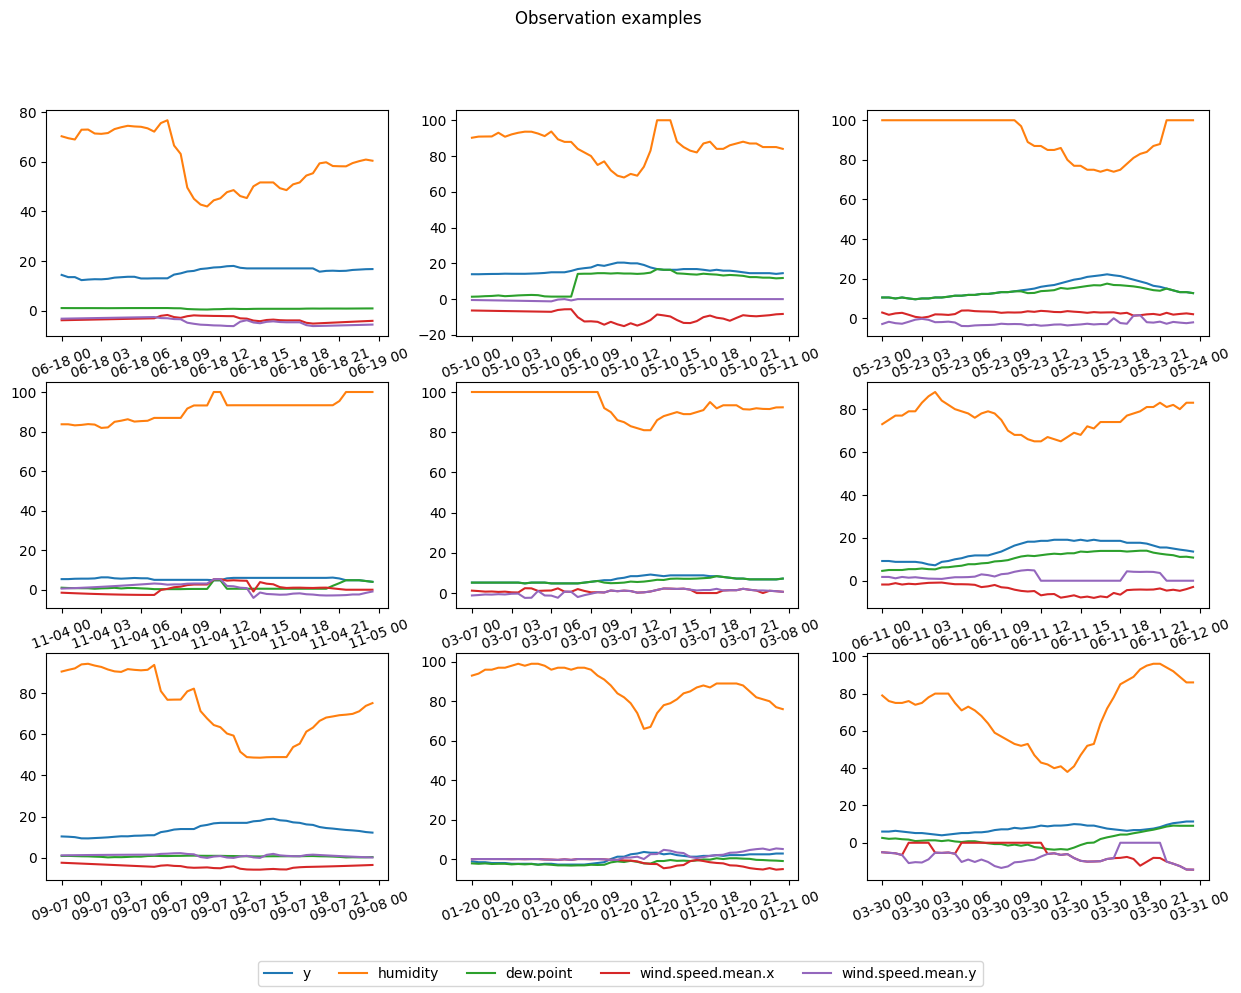

In [5]:
url_date_filex = "2023.08.08.csv"
if 'google.colab' in str(get_ipython()):
    data_url = "https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/data/CamMetCleanishMissAnnotated" + \
                url_date_filex + ".xz?raw=true"
else:
    data_url = "../data/CamMetCleanishMissAnnotated" + url_date_filex + '.xz'

df = pd.read_csv(data_url, parse_dates=['ds'], compression='xz')
df.set_index('ds', drop=False, inplace=True)
df = df[~df.index.duplicated(keep='first')]
df = df.asfreq(freq='30min')
df_orig = df.copy()

# Unusable - Mostly NAs
drop_cols = ['sunshine', 'ceil_hgt', 'visibility']
df.drop(drop_cols, axis=1, inplace=True)


# Data reformating - https://www.cl.cam.ac.uk/research/dtg/weather/weather-raw-format.txt
df['rainfall'] /= 1000
for column in ['temperature', 'dew.point', 'wind.speed.mean', 'wind.speed.max']:
    df[column] /= 10

df['y'] = df['temperature']


df['rain_prev_6_hours']  = df['rainfall'].rolling(12, min_periods=1).sum()
df['rain_prev_12_hours'] = df['rainfall'].rolling(24, min_periods=1).sum()
df['rain_prev_24_hours'] = df['rainfall'].rolling(48, min_periods=1).sum()
df['rain_prev_48_hours'] = df['rainfall'].rolling(96, min_periods=1).sum()
df['rain_prev_24_hours_binary'] = (df['rain_prev_24_hours'] > 0.0) * 1
df['rain_prev_48_hours_binary'] = (df['rain_prev_48_hours'] > 0.0) * 1


# Faster than np.ptp - https://stackoverflow.com/a/40184053/100129
df['y_window_48_min_max_diff'] = df['y'].rolling(48, min_periods=1).agg(['min', 'max']).diff(axis=1)['max']

df = add_transmit_heuristic_feature(df)

# Deep copy avoids SettingWithCopyWarning
df = df.loc['2008-08-01 00:00:00':'2022-12-31 23:30:00', :].copy(deep=True)


# Remove extreme outliers
humidity_min = 5.00
df.loc[df['humidity'] < humidity_min, 'humidity'] = humidity_min

pressure_min = 950
pressure_max = 1060
df.loc[df['pressure'] < pressure_min, 'pressure'] = pressure_min
df.loc[df['pressure'] > pressure_max, 'pressure'] = pressure_max


# Remove obviously bad temperature spike in '2016-01-08 23:00:00':'2016-01-09 07:30:00'
# display(df.loc['2016-01-08 21:00:00':'2016-01-09 12:00:00', ['y', 'missing']])
# display(df.loc['2016-01-08 23:00:00':'2016-01-09 07:30:00', 'y'])
df.loc['2016-01-08 23:00:00':'2016-01-09 07:30:00', 'y'] = np.linspace(3.7, 5.9, 18)


df['pressure.log'] = np.log(df['pressure'])
df['wind.speed.mean.sqrt'] = np.sqrt(df['wind.speed.mean'])
df['wind.speed.max.sqrt']  = np.sqrt(df['wind.speed.max'])


# Convert wind direction and speed to x and y vectors, so the model can more easily interpret them
df = convert_wind_to_xy(df, 'wind.speed.mean', 'wind.bearing.mean')
df = convert_wind_to_xy(df, 'wind.speed.mean.sqrt', 'wind.bearing.mean')
df = convert_wind_to_xy(df, 'wind.speed.max', 'wind.bearing.mean')
df = convert_wind_to_xy(df, 'wind.speed.max.sqrt', 'wind.bearing.mean')


# df['rh'] = relative_humidity(df['dew.point'], df['y'])
df['ah'] = absolute_humidity(df['humidity'], df['y'])
df['mixing_ratio'] = mixing_ratio(df['humidity'], df['temperature'], df['pressure'])
df['svp'] = saturation_vapour_pressure(df['temperature'])

# actual water vapour pressure
df['vapour_pressure'] = saturation_vapour_pressure(df['dew.point'])

# vapour pressure deficit
#   https://en.wikipedia.org/wiki/Vapour-pressure_deficit
#   https://physics.stackexchange.com/a/4553/243807
#   TODO Check alt. vp_def calculation methods in above stackexchange question
df['vp_def'] = df['vapour_pressure'] - df['svp']

df['air_density'] = air_density(df['y'], df['pressure'], df['vapour_pressure'])
df['H2OC'] = water_vapour_concentration(df['humidity'], df['svp'], df['pressure'])
df['specific_humidity'] = specific_humidity(df['pressure'], df['vapour_pressure'])
df['t_pot'] = potential_temperature(df['y'], df['pressure'])

# df['dew.point_approx'] = dew_point_approx(df['y'], df['humidity'])
# df['y_approx'] = temperature_approx(df['dew.point'], df['humidity'])
# df['humidity_approx'] = humidity_approx(df['dew.point'], df['y'])

df['ground_hf'] = ground_heat_flux(df['y'])


# Convert to secs and add daily and yearly sinusoidal time terms
date_time   = pd.to_datetime(df['ds'], format = '%Y.%m.%d %H:%M:%S')
timestamp_s = date_time.map(datetime.datetime.timestamp)


# ps - phase shift
for i, ps in enumerate([0, np.pi], start=1):
    df['day.sin.'  + str(i)] = np.sin(sinusoidal_arg(timestamp_s, DAY)  + ps)
    df['day.cos.'  + str(i)] = np.cos(sinusoidal_arg(timestamp_s, DAY)  + ps)
    df['year.sin.' + str(i)] = np.sin(sinusoidal_arg(timestamp_s, YEAR) + ps)
    df['year.cos.' + str(i)] = np.cos(sinusoidal_arg(timestamp_s, YEAR) + ps)


hour_df = pd.DataFrame(
    np.linspace(0, DAY, DAILY_OBS + 1).reshape(-1, 1),
    columns=["secs"],
)

month_df = pd.DataFrame(
    np.linspace(0, YEAR, YEARLY_OBS + 1).reshape(-1, 1),
    columns=["secs"],
)

# 12 splines approximating 12 month-like time components
day_splines = periodic_spline_transformer(DAY, n_splines=12).fit_transform(hour_df)
day_splines_df = pd.DataFrame(
    day_splines,
    columns=[f"day_spline_{i}" for i in range(day_splines.shape[1])],
)
day_splines_df['secs_since_midnight'] = range(0, DAY + DAY_SECS_STEP, DAY_SECS_STEP)


year_splines = periodic_spline_transformer(YEAR, n_splines=12).fit_transform(month_df)
year_splines_df = pd.DataFrame(
    year_splines,
    columns=[f"year_spline_{i}" for i in range(year_splines.shape[1])],
)
year_splines_df['secs_elapsed'] = range(0, int(YEAR), DAY_SECS_STEP)



# Add seasonal mean temperature (y_seasonal), humidity and dew.point
df['secs_since_midnight'] = ((df['ds'] - df['ds'].dt.normalize()) / pd.Timedelta('1 second')).astype(int)
df['doy'] = df['ds'].apply(lambda x: x.dayofyear - 1)
df['secs_elapsed'] = df['secs_since_midnight'] + df['doy'] * DAY

# NOTE: Potential data leak here
#       Seasonality should be calculated on train data only
#for var in ['y', 'humidity', 'dew.point', 'pressure', 'wind.speed.mean']:
#  df_seasonal_var = df[[var, 'secs_elapsed']].groupby('secs_elapsed').mean(var)
#  df_seasonal_var.rename(columns={var: var + '_seasonal'}, inplace=True)
#  df = pd.merge(df, df_seasonal_var,   on='secs_elapsed')
#  df[var + '_des'] = df[var] - df[var + '_seasonal']  # des - deseasonal

#df = pd.merge(df, day_splines_df,  on='secs_since_midnight')
#df = pd.merge(df, year_splines_df, on='secs_elapsed')

# for var in ['y', 'humidity', 'dew.point', 'pressure', 'wind.speed.mean']:
#   df = simple_daily_yearly_res_decomp(df, var)
#   # display(df.info())


# TODO: Potential data leaks here?
# df['y_diff_1']  = df['y'].diff(1)
# df['dew.point_diff_1']  = df['dew.point'].diff(1)
# df['humidity_diff_1']   = df['humidity'].diff(1)
# df['pressure_diff_1'] = df['pressure'].diff(1)  # unusable

df['dT_dH'] = df['y'].diff(1) / df['humidity'].diff(1)
df['dT_dP'] = df['y'].diff(1) / df['pressure'].diff(1)
df['dT_dTdp'] = df['y'].diff(1) / df['dew.point'].diff(1)

# WARNING WARNING Danger Will Robinson! Definite data leak here :-(
# inf introduced due to diff(1) == 0 when no change
df = df.replace([np.inf, -np.inf], np.nan)
df['dT_dH']   = df['dT_dH'].interpolate(method='linear')
df['dT_dP']   = df['dT_dP'].interpolate(method='linear')
df['dT_dTdp'] = df['dT_dTdp'].interpolate(method='linear')



df.set_index('ds', drop=False, inplace=True)
df = df.asfreq(freq='30min')


# Reorder and drop temporary calculation columns
inc_cols = ['ds', 'y', #'y_daily', 'y_yearly', 'y_res',
            'humidity', #'humidity_daily', 'humidity_yearly', 'humidity_res',
            'dew.point', #'dew.point_daily', 'dew.point_yearly', 'dew.point_res',
            'pressure', #'pressure_daily', 'pressure_yearly', 'pressure_res',
            'pressure.log', 'y_window_48_min_max_diff',
           #'humidity_diff_1',
           #'humidity_diff_48', 'pressure_diff_48', 'humidity_diff_1_48',
           #'wind.speed.mean_daily', 'wind.speed.mean_yearly', 'wind.speed.mean_res',
            'wind.speed.mean.sqrt', 'wind.speed.mean',
            'wind.bearing.mean', 'wind.speed.mean.x', 'wind.speed.mean.y',
            'wind.speed.mean.sqrt.x', 'wind.speed.mean.sqrt.y',
            'wind.speed.max', 'wind.speed.max.sqrt',
            'wind.speed.max.sqrt.x', 'wind.speed.max.sqrt.y',
            'ground_hf', 'rainfall',
            'tau', 'rain_prev_6_hours', 'rain_prev_12_hours',
            'rain_prev_24_hours', 'rain_prev_24_hours_binary',
            'rain_prev_48_hours', 'rain_prev_48_hours_binary',
            'mixing_ratio', 'ah', 'specific_humidity', 'svp', 'vapour_pressure',
            'vp_def', 't_pot', 'air_density', 'H2OC',
            'dT_dH', 'dT_dP', 'dT_dTdp',
           #'y_approx', 'humidity_approx', 'dew.point_approx',
           #'y_seasonal', 'y_des',
           #'humidity_seasonal', 'humidity_des',
           #'dew.point_seasonal', 'dew.point_des',
           #'pressure_seasonal', 'pressure_des',
           #'wind.speed.mean_seasonal', 'wind.speed.mean_des',
            'day.sin.1', 'day.cos.1', 'year.sin.1', 'year.cos.1',
           #'y_shadow', 'humidity_shadow', 'pressure_shadow', 'dew.point_shadow',
            'missing', 'known_inaccuracy', 'isd_outlier', 'long_run', 'spike',
            'cooksd_out', 'isd_3_sigma', 'isd_filled', 'tsclean_filled',
            'tsclean_filled_temperature', 'tsclean_filled_dew.point',
            'tsclean_filled_humidity', 'tsclean_filled_pressure',
            'tsclean_filled_wind.speed.mean', 'tsclean_filled_wind.speed.max',
            'tsclean_filled_wind.bearing.mean', 'tsclean_filled_rainfall',
           #'hist_average', 'mi_filled', 'mi_spike_interp', 'lin_interp'
           ]
df = df[inc_cols]

# df = df.loc[df['missing'] == 0.0, :]
# df = df.loc[(df['mi_filled'] != 1.0) & (df['hist_average'] != 1.0), :]



# For use in other notebooks
if not 'google.colab' in str(get_ipython()):
    data_loc = "../data/CamMetPrepped" + url_date_filex
    df.to_csv(data_loc)


print("Shape:")
display(df.shape)
print("\nInfo:")
display(df.info())
print("\nSummary stats:")
display(df.describe())
print("\nRaw data:")
display(df)
print("\n")


plot_cols = ['y', 'humidity', 'dew.point', 'wind.speed.mean.x',
             'wind.speed.mean.y']  # 'pressure',
plot_observation_examples(df, plot_cols)


df = df.fillna(method='bfill')  # Small number of NAs in first row
df_sanity = sanity_check_before_after_dfs(df_orig, df, 'df')
check_high_low_thresholds(df)

I didn't include `pressure` in example observation plots because those values are an order of magnitude higher than the other features.

A few other things to note:
 * features which did not prove useful this time
    * absolute humidity
    * mixing ratio
    * spline-based time components
    * higher frequency sinusoidal time components
    * phase-shifted sinusoidal time components
    * I leave the code for generating these features incase it is useful later
       * for example with the inclusion of the rainfall feature

---

### Calculate Solar Features

Irradiance, zenith angle and declination:

[Solar irradiance](https://en.wikipedia.org/wiki/Solar_irradiance) is the power per unit area (surface power density) received from the Sun.  Irradiance plays a part in weather forecasting.  I calculate solar irradiance for Cambridge using the python [solarpy](https://github.com/aqreed/solarpy) module.  I suspect forecasts could be substantially improved if solar irradiance could be combined with a measure of cloud cover.  It could also be used as a future covariate with models built with the darts package.

The [solar zenith angle](https://en.wikipedia.org/wiki/Solar_zenith_angle) is the angle between the sun’s rays and the vertical direction.  I use the [pysolar](https://github.com/pingswept/pysolar) python package for zenith angle calculations.  Similarly to irradiance, it could be used as a future covariate.  See this [stackoverflow question](https://stackoverflow.com/questions/45238223/how-to-get-solar-zenith-angle-using-pysolar) and the [source code](https://github.com/pingswept/pysolar/blob/master/pysolar/solar.py) for calculation details.  There is a refraction correction term which assumes 'standard' pressure and temperature values.  Zenith angle is used to calculate solar irradiance.

[Solar declination](https://www.sciencedirect.com/topics/engineering/solar-declination) is the angle between the equator and a line drawn from the centre of the Earth to the centre of the sun.  It can be calculated with the solarpy module.  It did not prove useful in the lightgbm models.
I've commented it out for now.

Calculations:
  * just calculate irradiance for a single year (arbitrarily 2020)
  * then repeat values for the other years

Installing {'solarpy', 'pysolar'} ... Done
Zenith


Calculating zenith: 100%|██████████| 17568/17568 [00:16<00:00, 1046.50it/s]


count    17568.000000
mean        89.672425
std         29.857274
min         28.767886
25%         67.803213
50%         89.235373
75%        111.449144
max        151.223633
Name: za, dtype: float64

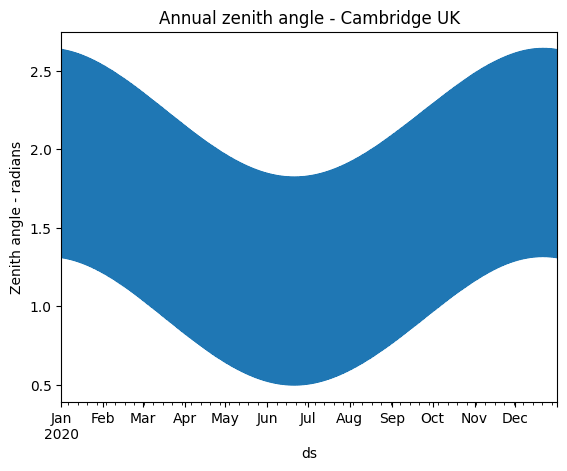

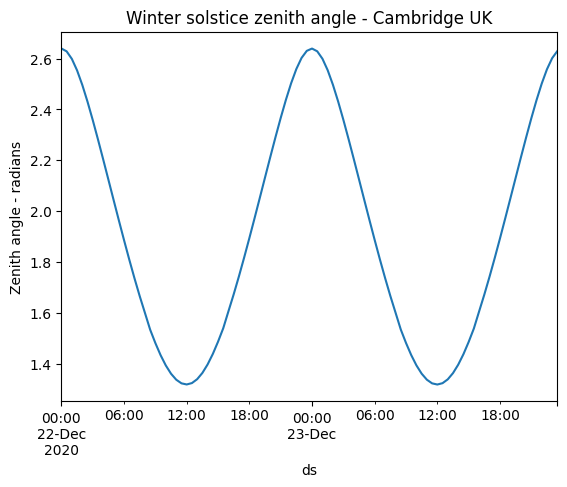

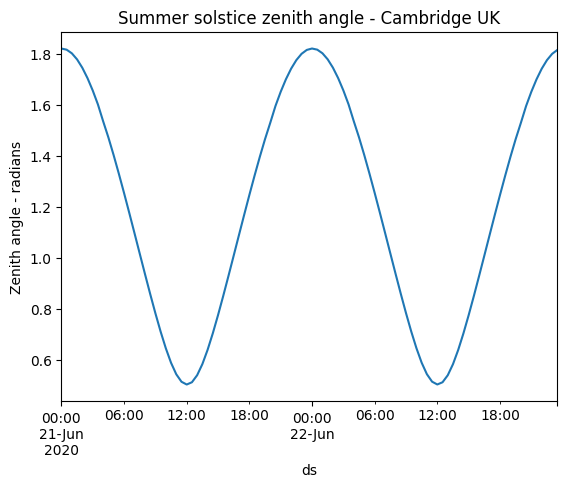

Irradiance


Calculating irradiance: 100%|██████████| 17568/17568 [00:03<00:00, 4465.05it/s]


count    17568.000000
mean       142.940765
std        226.586194
min          0.000000
25%          0.000000
50%          0.000137
75%        220.386913
max        805.382014
Name: irradiance, dtype: float64

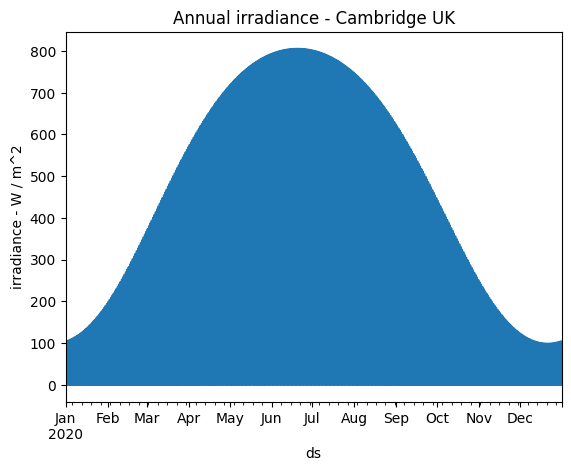

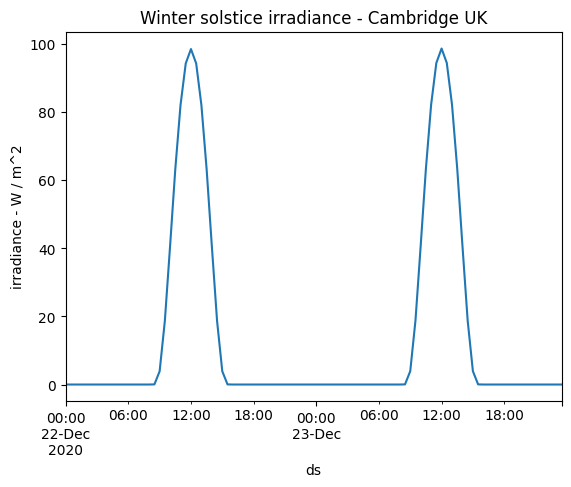

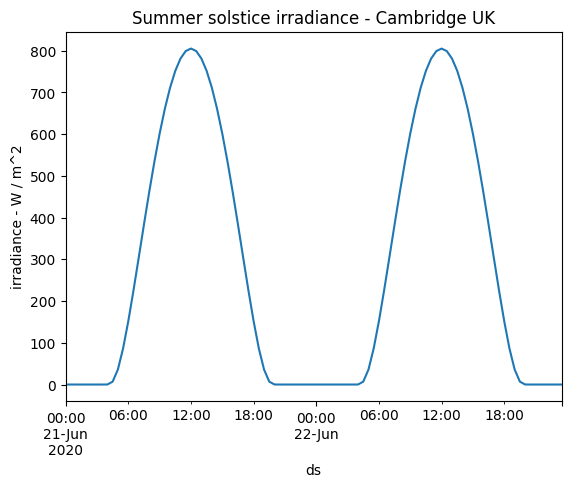

Azimuth


Calculating azimuth: 100%|██████████| 17568/17568 [00:15<00:00, 1107.75it/s]


count    17568.000000
mean         0.001957
std          0.588445
min         -0.841471
25%         -0.579791
50%          0.006409
75%          0.582247
max          0.841471
Name: azimuth, dtype: float64

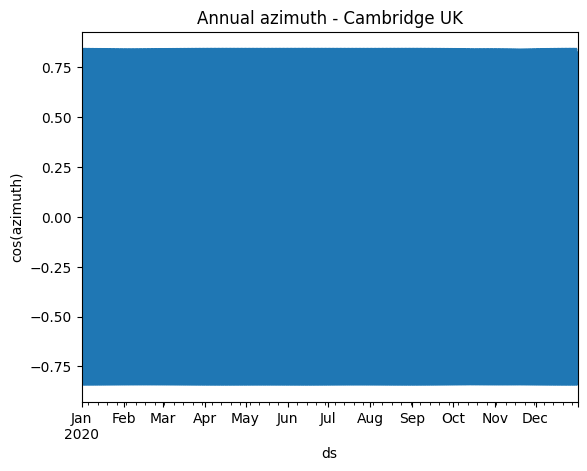

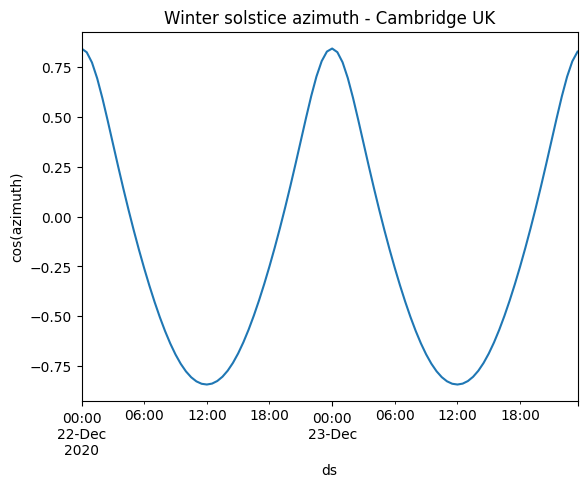

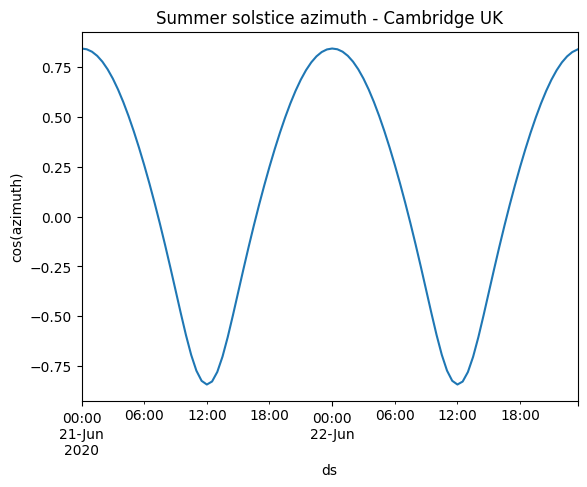

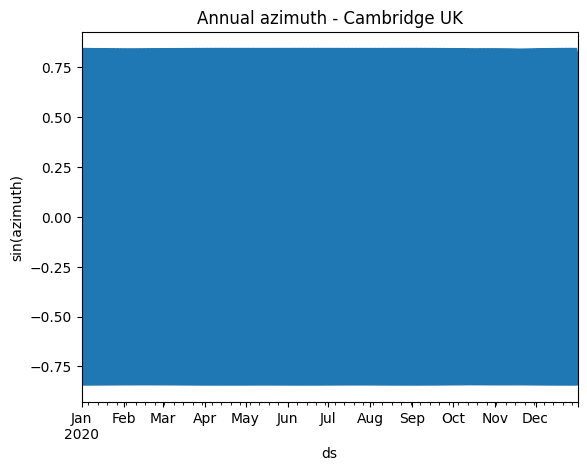

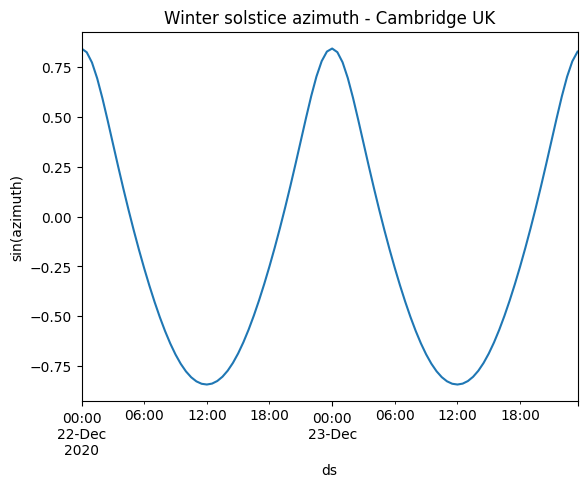

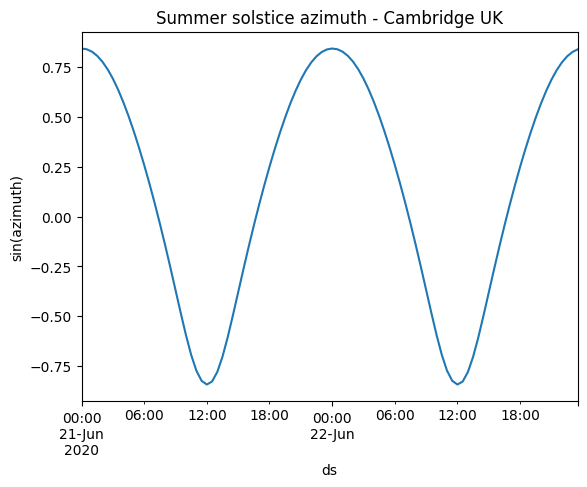

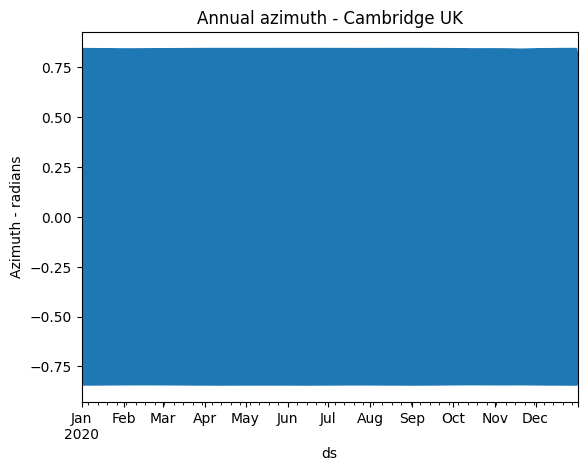

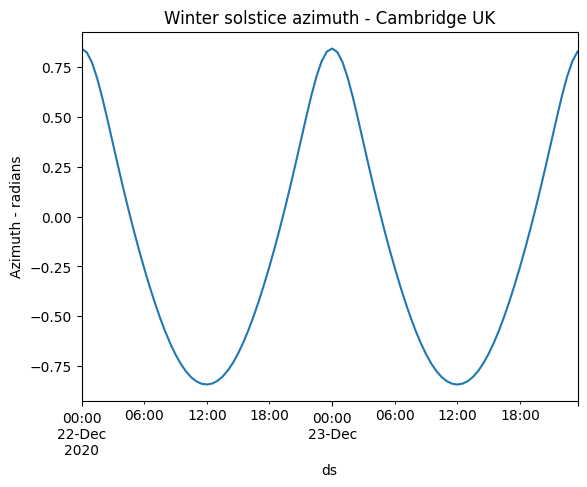

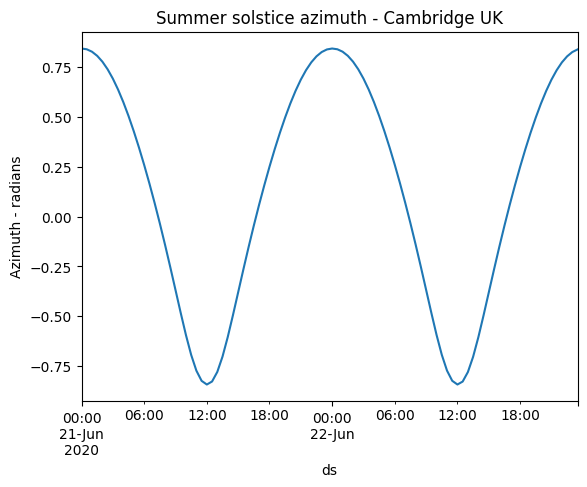

Declination


Calculating declination: 100%|██████████| 17568/17568 [00:00<00:00, 84736.73it/s]


count    17568.000000
mean         0.005800
std          0.287570
min         -0.408846
25%         -0.280364
50%          0.011877
75%          0.290560
max          0.409361
Name: declination, dtype: float64

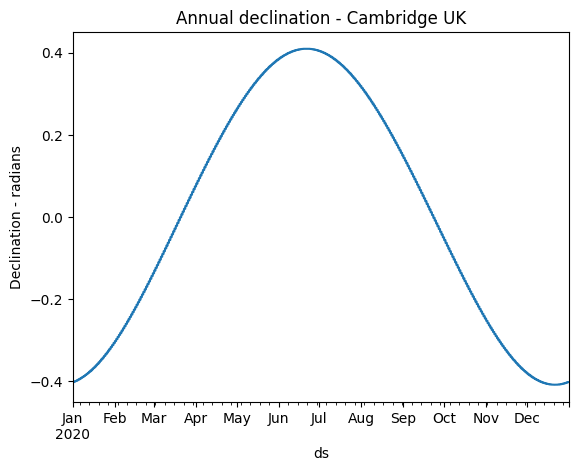

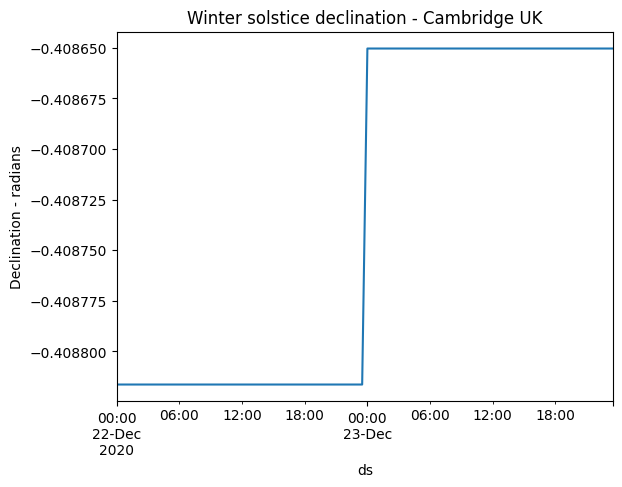

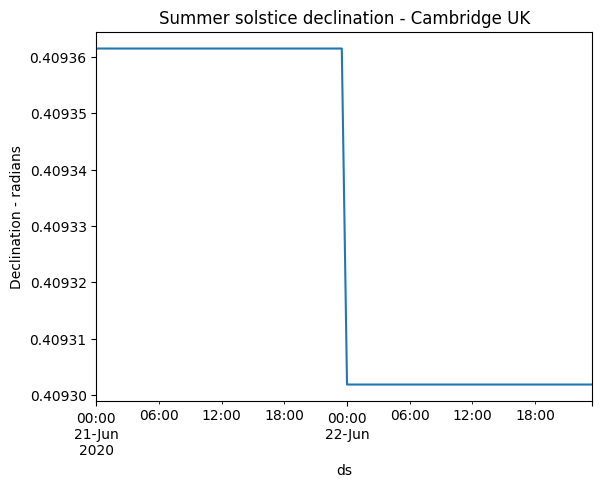


df
before.index.equals(after.index): True
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): True

before[common_cols].equals(after[common_cols]): True



before   after diff
rows                    252768  252768    0
cols                        60      77   17
missing_rows                 0       0    0
missing_cols                 0       0    0
total_nas                    0       0    0
rows_with_nas                0       0    0
cols_with_nas                0       0    0
single_value_cols            0       0    0
low_var_rows                 0       0    0
low_var_cols                 6       7    1
duplicate_rows               0       0    0
duplicate_index_labels       0       0    0
duplicate_col_labels         0       0    0

In [6]:
required  = {'pysolar', 'solarpy'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing   = required - installed

if missing == required:
    print('Installing', missing, '...', sep=' ', end='')
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing])  #, stdout=subprocess.DEVNULL)
    print(' Done')


from pysolar.solar import get_altitude, get_azimuth
from solarpy import irradiance_on_plane, declination


def calc_solar_data(df, solar_calc):
  IYEAR = 2020  # arbitrary year
  LAT   = 52.210922
  LON   =  0.091964

  df['year'] = df['ds'].dt.year
  data = pd.DataFrame()
  data.index = df.loc[df['year'] == IYEAR, 'ds']
  data.index = pd.to_datetime(data.index)

  print(solar_calc.title())

  if solar_calc == 'declination':
    declinations = [0] * len(data)
    i = 0

    for d in tqdm(data.index, desc='Calculating ' + solar_calc):
      declinations[i] = declination(d)
      i += 1

    data['declination'] = declinations
    display(data['declination'].describe())
  elif solar_calc == 'irradiance':
    HEIGHT = 6  # height above sea level
    VNORM  = np.array([0, 0, -1])  # plane pointing zenith
    irradiances  = [0] * len(data)
    i = 0

    for d in tqdm(data.index, desc='Calculating ' + solar_calc):
      irradiances[i] = irradiance_on_plane(VNORM, HEIGHT, d, LAT)
      i += 1

    data['irradiance'] = irradiances
    display(data['irradiance'].describe())
  elif solar_calc == 'zenith':
    za = [0] * len(data)
    za_rad = [0] * len(data)
    i = 0

    for d in tqdm(data.index, desc='Calculating ' + solar_calc):
      ts = pd.Timestamp(d, tz='UTC').to_pydatetime()
      za[i] = float(90) - get_altitude(LAT, LON, ts)
      za_rad[i] = np.radians(za[i])
      i += 1

    # TODO rename za to zenith
    data['za'] = za
    data['za_rad'] = za_rad
    display(data['za'].describe())
  elif solar_calc == 'azimuth':
    az = [0] * len(data)
    az_rad = az
    az_rad_cos = az
    az_rad_sin = az
    i = 0

    for d in tqdm(data.index, desc='Calculating ' + solar_calc):
      ts = pd.Timestamp(d, tz='UTC').to_pydatetime()
      az[i] = get_azimuth(LAT, LON, ts)
      az_rad[i] = np.radians(az[i])
      az_rad_cos[i] = np.cos(az_rad[i])
      az_rad_sin[i] = np.sin(az_rad[i])
      i += 1

    data['azimuth'] = az
    data['azimuth_rad'] = az_rad
    data['azimuth_cos'] = az_rad_cos
    data['azimuth_sin'] = az_rad_sin
    display(data['azimuth'].describe())
  else:
    print("Unknown solar_calc parameter:", solar_calc,
          "\nUse 'declination', 'irradiance' or 'zenith'")

  print()
  data['month']  = data.index.month
  data['day']    = data.index.day
  data['hour']   = data.index.hour
  data['minute'] = data.index.minute

  df['month']  = df.index.month
  df['day']    = df.index.day
  df['hour']   = df.index.hour
  df['minute'] = df.index.minute

  merge_cols = ['month', 'day', 'hour', 'minute']
  df = df.merge(data, on=merge_cols)
  df.drop(merge_cols, inplace=True, axis=1)
  df.set_index('ds', drop=False, inplace=True)
  df = df[~df.index.duplicated(keep='first')]
  df = df.asfreq(freq='30min')

  if solar_calc == 'declination':
    df['declination_diff_1'] = df['declination'].diff(1)
  elif solar_calc == 'irradiance':
    df['irradiance_diff_1'] = df['irradiance'].diff(1)
  elif solar_calc == 'zenith':
    df['za_diff_1'] = df['za'].diff(1)
    df['za_rad_diff_1'] = df['za_rad'].diff(1)
  elif solar_calc == 'azimuth':
    df['azimuth_diff_1'] = df['azimuth'].diff(1)
    df['azimuth_rad_diff_1'] = df['azimuth_rad'].diff(1)
    df['azimuth_cos_diff_1'] = df['azimuth_cos'].diff(1)
    df['azimuth_sin_diff_1'] = df['azimuth_sin'].diff(1)

  return df


def plot_solar(solar, title, ylab):
  solar.plot()
  plt.ylabel(ylab)
  plt.title(title)
  plt.show()


def plot_solar_annual_and_solstice(solar, var, title_var, ylab):
  title = 'Annual ' + title_var + ' - Cambridge UK'
  plot_solar(solar.loc['2020-01-01':'2020-12-31', var], title, ylab)

  title = 'Winter solstice ' + title_var + ' - Cambridge UK'
  plot_solar(solar.loc['2020-12-22':'2020-12-23', var], title, ylab)

  title = 'Summer solstice ' + title_var + ' - Cambridge UK'
  plot_solar(solar.loc['2020-06-21':'2020-06-22', var], title, ylab)


df_before_solar = df.copy()

za_lab = 'Zenith angle - radians'
za_title = 'zenith angle'
df = calc_solar_data(df, 'zenith')
plot_solar_annual_and_solstice(df, 'za_rad', za_title, za_lab)

irr_ylab = 'irradiance - W / m^2'
irr_title = 'irradiance'
df = calc_solar_data(df, irr_title)
plot_solar_annual_and_solstice(df, irr_title, irr_title, irr_ylab)

az_lab = 'Azimuth - radians'
az_title = 'azimuth'
df = calc_solar_data(df, az_title)
plot_solar_annual_and_solstice(df, 'azimuth_cos', az_title, 'cos(azimuth)')
plot_solar_annual_and_solstice(df, 'azimuth_sin', az_title, 'sin(azimuth)')
plot_solar_annual_and_solstice(df, 'azimuth_rad', az_title, az_lab)

dec_ylab = 'Declination - radians'
dec_title = 'declination'
df = calc_solar_data(df, dec_title)
plot_solar_annual_and_solstice(df, dec_title, dec_title, dec_ylab)

df = df.fillna(method='bfill')  # Small number of NAs in first row
df_solar_sanity = sanity_check_before_after_dfs(df_before_solar, df, 'df')
check_high_low_thresholds(df)

In [7]:
df.fillna(method='bfill').isna().sum()

ds                    0
y                     0
humidity              0
dew.point             0
pressure              0
                     ..
azimuth_rad_diff_1    0
azimuth_cos_diff_1    0
azimuth_sin_diff_1    0
declination           0
declination_diff_1    0
Length: 77, dtype: int64

There is zero solar irradiance between sunset and sunrise. Hence the near zero median value for irradiance.

---


#### Unobserved components model

The unobserved components model (UCM) is an alternative to prophet decomposition.  It produces trend, cyclic, seasonal and residual terms which can be stochastic or deterministic.  The cyclic component of the unobserved components model can model the relatively long annual seasonality (48 * 365.2425 = 17,532 steps) using harmonic terms.

 * [statsmodels - unobserved components](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html)
 * [statsmodels - Detrending, Stylized Facts and the Business Cycle](https://www.statsmodels.org/devel/examples/notebooks/generated/statespace_structural_harvey_jaeger.html)
 * [Daniel Toth - Multi seasonal time series analysis: decomposition and forecasting with Python](https://medium.com/analytics-vidhya/multi-seasonal-time-series-analysis-decomposition-and-forecasting-with-python-609409570007)


 Here, I run a few experiments using UCM for decomposition.


In [107]:
def get_uc_model(data, params, y_col='y'):
  ucm = sm.tsa.UnobservedComponents(data[y_col], #.dropna().values,
                                    **params)
  res_f = ucm.fit(method='powell', disp=False)

  return res_f


def check_uc_model(ucmodel, valid_data):
  print(ucmodel.summary())

  ucmodel.plot_components(figsize=(12, 12))
  plt.show()

  ucmodel.plot_diagnostics(figsize=(12, 12), lags=96)
  plt.show()

  # model forecast
  steps_ = len(valid_data) #int(48 * 365.2425)
  test_df = valid_data[['y']].interpolate(method='linear')  #.head(steps_)
  forecast_ucm = ucmodel.forecast(steps=steps_, exog=test_df)

  # calculating mean absolute error and root mean squared error for out-of-sample prediction for model evaluation
  RMSE_ucm = np.sqrt(np.mean([(test_df.iloc[x, 0] - forecast_ucm[x]) ** 2 for x in range(len(test_df))]))
  MAE_ucm  = np.mean([np.abs(test_df.iloc[x, 0] - forecast_ucm[x]) for x in range(len(test_df))])

  print(f"\nOut-of-sample mean absolute error (MAE): {'%.2f' % MAE_ucm}")
  print(f"Out-of-sample root mean squared error (RMSE): {'%.2f' % RMSE_ucm}")


def add_ucm_decomposition(data_, ucm_mod, feat = 'y'):
  data = data_.copy(deep=True)

  level_name  = feat + '_ucm_' + 'level'
  yearly_name = feat + '_ucm_' + 'yearly'
  daily_name  = feat + '_ucm_' + 'daily'
  res_name    = feat + '_ucm_' + 'res'

  data.loc[:, level_name]  = getattr(ucm_mod, 'level')['smoothed']
  data.loc[:, yearly_name] = getattr(ucm_mod, 'cycle')['smoothed']
  data.loc[:, daily_name]  = getattr(ucm_mod, 'freq_seasonal')[0]['smoothed']

  data.loc[:, res_name] = data[feat] - data[level_name] - data[yearly_name] - data[daily_name]

  return data

Temperature first:

                          Unobserved Components Results                           
Dep. Variable:                          y   No. Observations:               252768
Model:                deterministic trend   Log Likelihood             -685947.598
                   + freq_seasonal(48(1))   AIC                        1371899.196
                                  + cycle   BIC                        1371920.076
Date:                    Mon, 29 Jan 2024   HQIC                       1371905.280
Time:                            15:33:55                                         
Sample:                        08-01-2008                                         
                             - 12-31-2022                                         
Covariance Type:                      opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1738: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


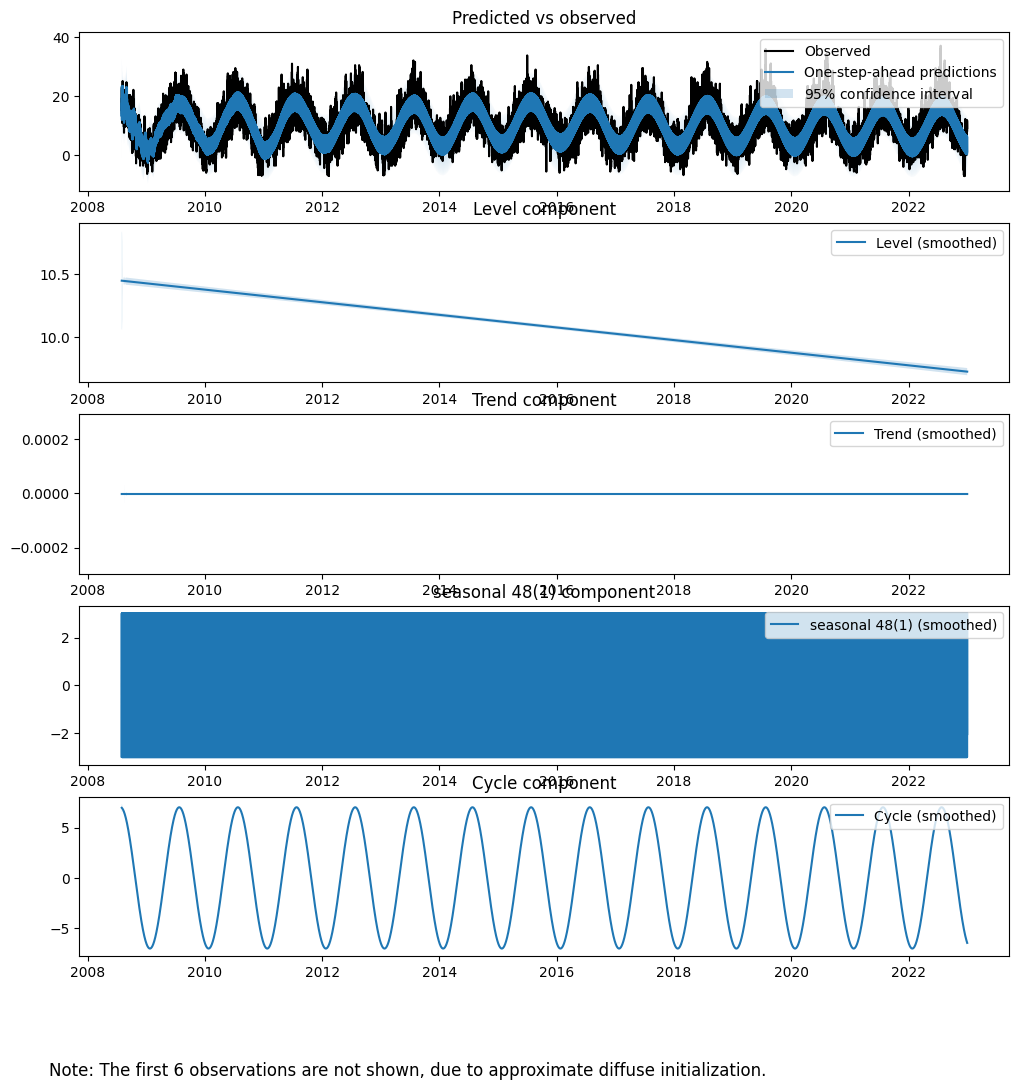

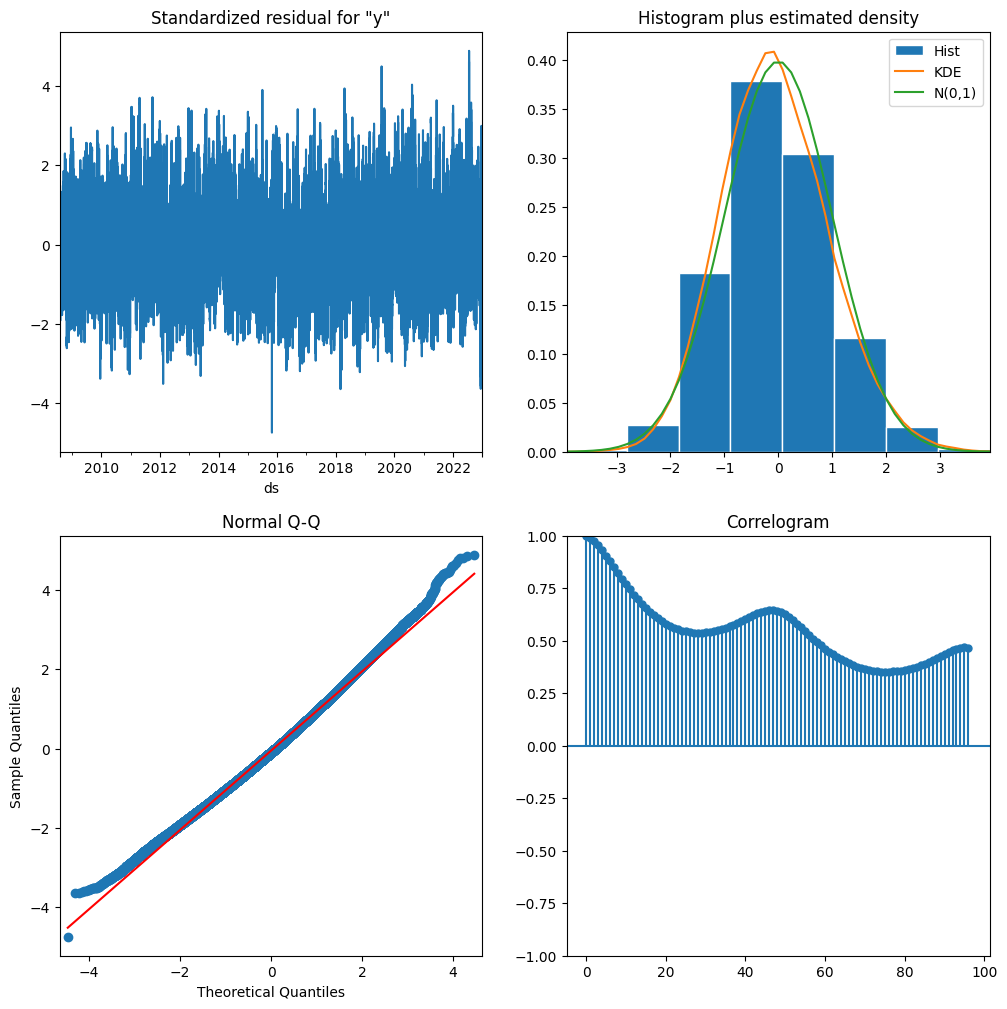


Out-of-sample mean absolute error (MAE): 3.00
Out-of-sample root mean squared error (RMSE): 3.74


(252768, 80)

(252768, 84)

In [108]:
uc_params = {# exog  = df[['humidity','dew.point','pressure','wind.speed.mean.x','wind.speed.mean.y']].dropna(),
             #'exog': train_df[['humidity','dew.point','irradiance']].interpolate(method='slinear'),
             #exog = data[['dew.point']].interpolate(method='linear'),
             # level = 'deterministic constant',
             'level': 'deterministic trend',
             'cycle': True,
             # irregular = True,
             #'autoregressive': 1,
             'cycle_period_bounds': (17531, 17533),
             'stochastic_freq_seasonal': [False],
             'freq_seasonal': [{'period':    48,
                                'harmonics':  1}]}

# res_f = get_uc_model(train_df, uc_params)
res_y = get_uc_model(df, uc_params)
# check_uc_model(res_y, valid_df)

df = add_ucm_decomposition(df, res_y)

...

---

`dew.point` second:

                          Unobserved Components Results                           
Dep. Variable:                  dew.point   No. Observations:               252768
Model:                deterministic trend   Log Likelihood             -685958.530
                   + freq_seasonal(48(2))   AIC                        1371921.060
                                  + cycle   BIC                        1371941.940
Date:                    Mon, 29 Jan 2024   HQIC                       1371927.144
Time:                            15:12:52                                         
Sample:                        08-01-2008                                         
                             - 12-31-2022                                         
Covariance Type:                      opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1738: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


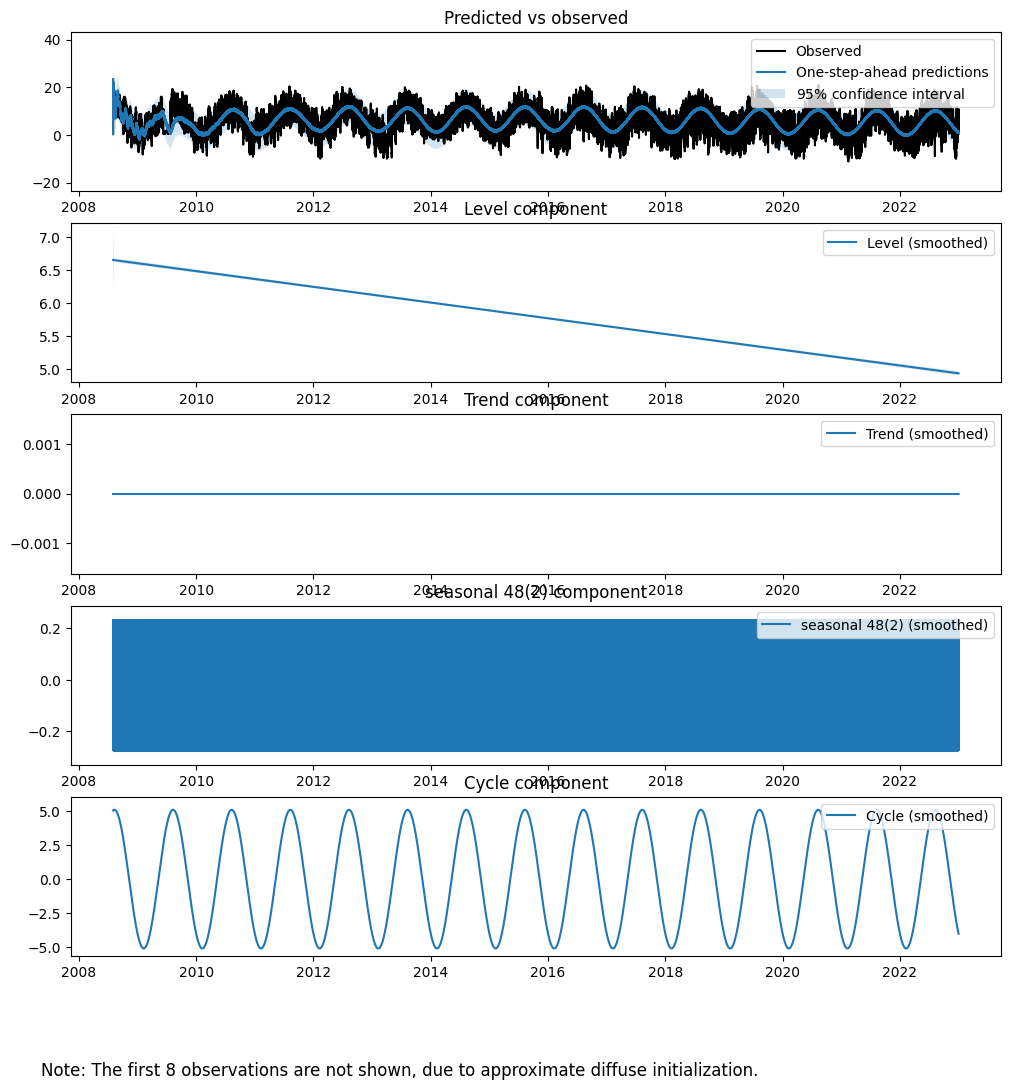

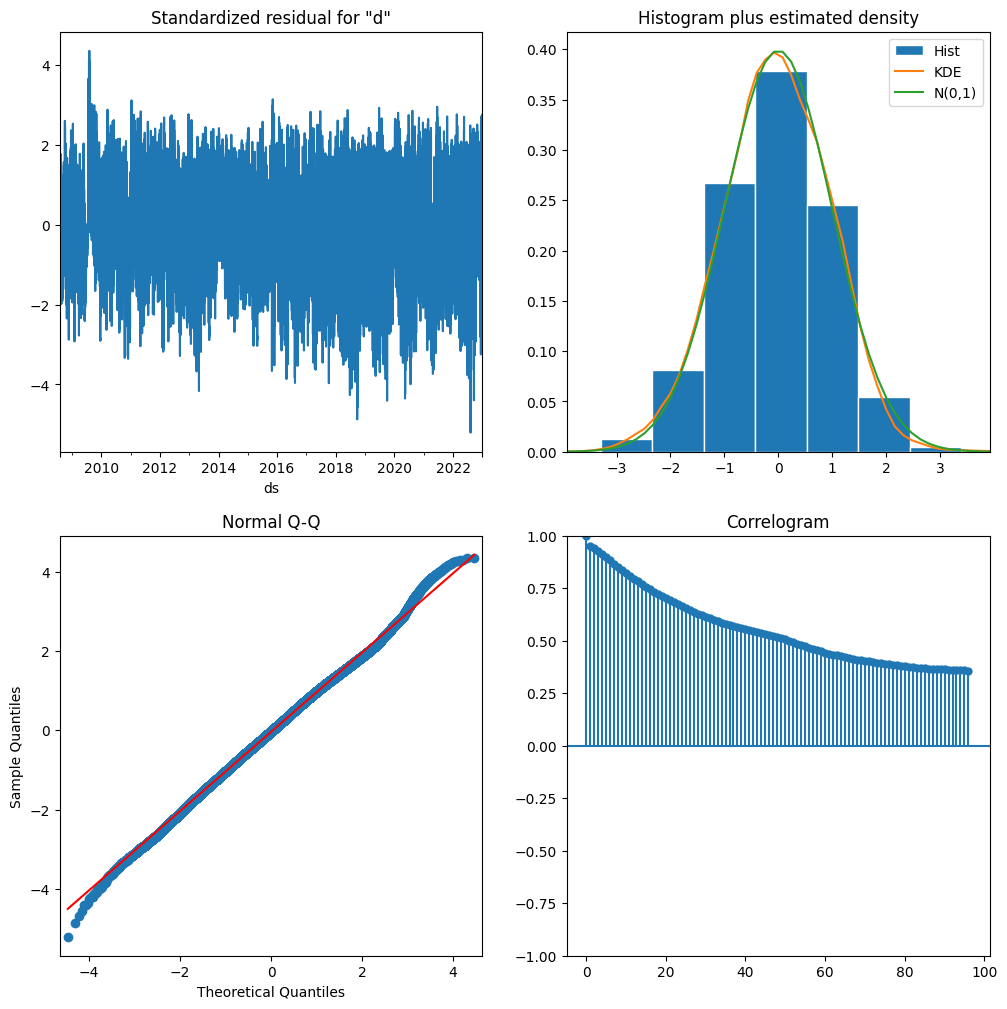


Out-of-sample mean absolute error (MAE): 4.97
Out-of-sample root mean squared error (RMSE): 6.18


(252768, 76)

(252768, 80)

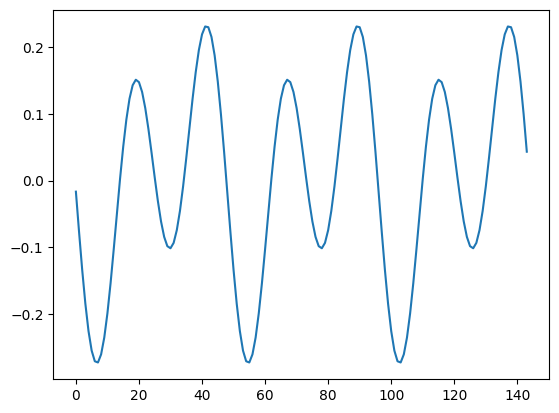

In [105]:
uc_params = {# exog  = df[['humidity','dew.point','pressure','wind.speed.mean.x','wind.speed.mean.y']].dropna(),
             # exog = train_df[['humidity','dew.point']].interpolate(method='slinear'),
             # 'exog': train_df[['dew.point_des']].interpolate(method='linear'),
             # level = 'deterministic constant',
             'level': 'deterministic trend',
             'cycle': True,
             # irregular = True,
             # 'autoregressive': 1,
             'cycle_period_bounds': (17531, 17533),
             'stochastic_freq_seasonal': [False],
             'freq_seasonal': [{'period':    48,
                                'harmonics':  2}]}

# res_f = get_uc_model(train_df, uc_params, 'dew.point')
res_dp = get_uc_model(df, uc_params, 'dew.point')
# check_uc_model(res_dp, valid_df)

df = add_ucm_decomposition(df, res_dp, feat='dew.point')

plt.plot(res_dp.freq_seasonal[0]['smoothed'][:144])
plt.show()

...

---

`humidity` third:

                          Unobserved Components Results                           
Dep. Variable:                   humidity   No. Observations:               217728
Model:                deterministic trend   Log Likelihood             -869370.102
                   + freq_seasonal(48(1))   AIC                        1738744.203
                                  + cycle   BIC                        1738764.785
Date:                    Mon, 29 Jan 2024   HQIC                       1738750.238
Time:                            12:39:41                                         
Sample:                        08-01-2008                                         
                             - 12-31-2020                                         
Covariance Type:                      opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1738: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


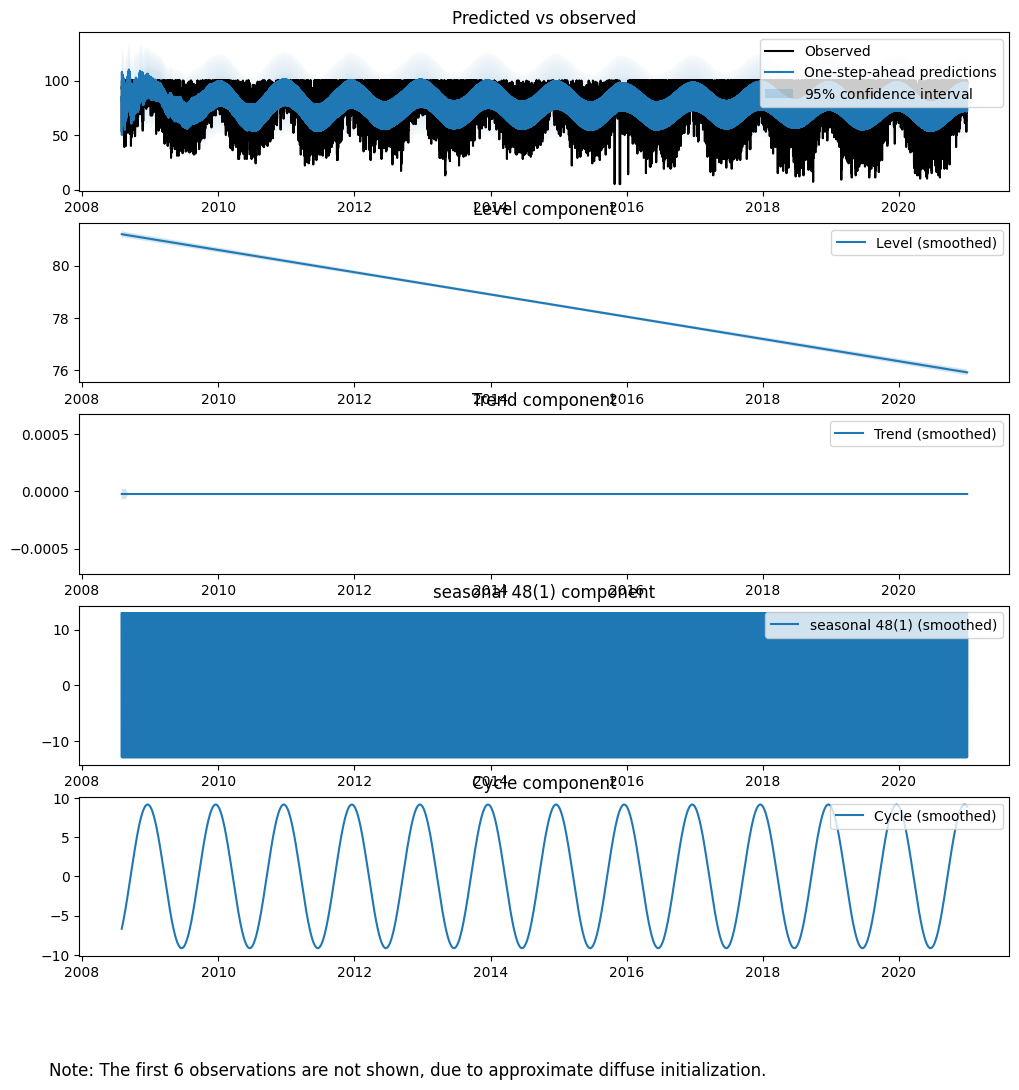

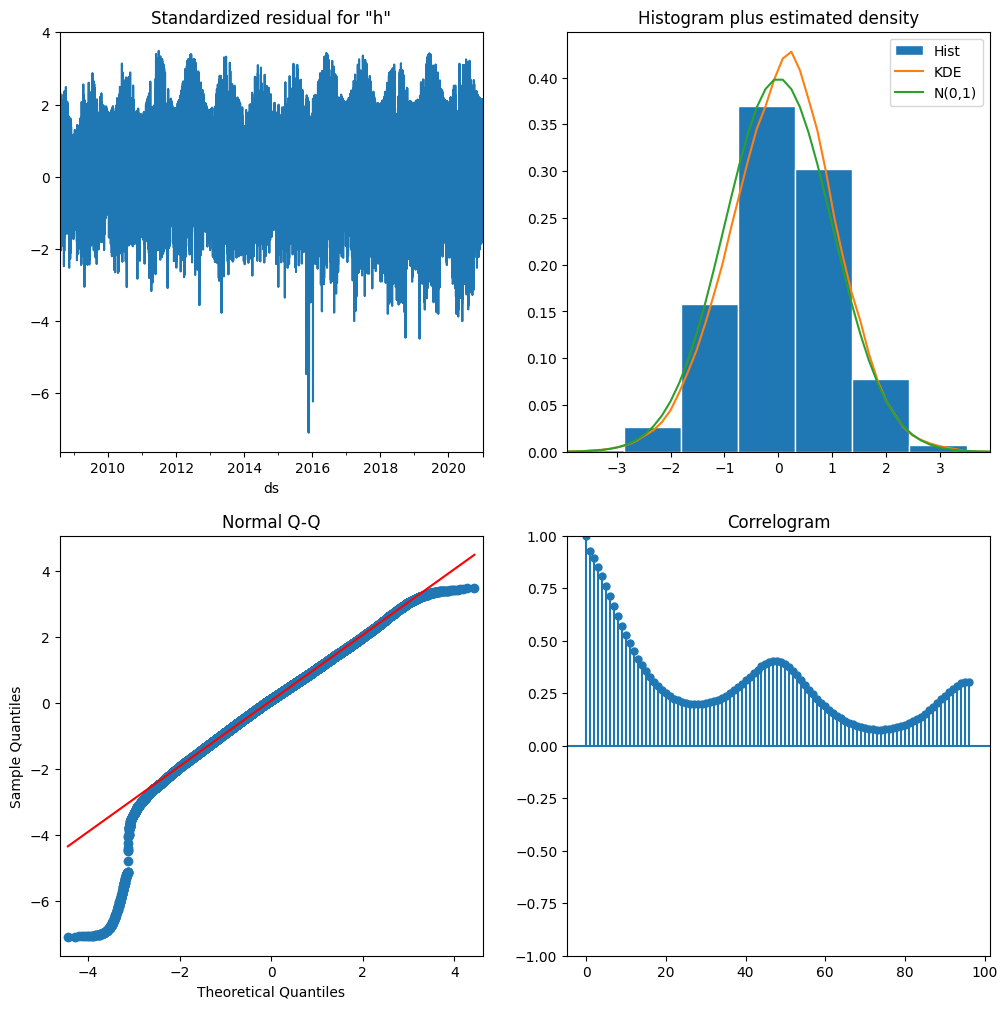


Out-of-sample mean absolute error (MAE): 66.54
Out-of-sample root mean squared error (RMSE): 68.42


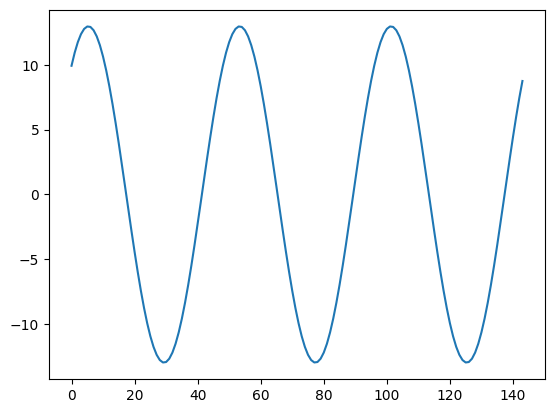

In [23]:
uc_params = {# exog  = df[['humidity','dew.point','pressure','wind.speed.mean.x','wind.speed.mean.y']].dropna(),
             # exog = train_df[['humidity','dew.point']].interpolate(method='slinear'),
             # 'exog': train_df[['dew.point_des']].interpolate(method='linear'),
             # level = 'deterministic constant',
             'level': 'deterministic trend',
             'cycle': True,
             # irregular = True,
             # 'autoregressive': 1,
             'cycle_period_bounds': (17531, 17533),
             'stochastic_freq_seasonal': [False],
             'freq_seasonal': [{'period':    48,
                                'harmonics':  1}]}

res_hum = get_uc_model(df, uc_params, 'humidity')
# check_uc_model(res_hum, valid_df)

plt.plot(res_hum.freq_seasonal[0]['smoothed'][:144])
plt.show()

...

---

`pressure` fourth:

<ipython-input-24-f5983affcb97>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_press_df['log_pressure'] = np.log(train_press_df['pressure'])


                          Unobserved Components Results                           
Dep. Variable:                   pressure   No. Observations:                87648
Model:                deterministic trend   Log Likelihood             -338229.536
                   + freq_seasonal(48(2))   AIC                         676463.072
                                  + cycle   BIC                         676481.834
Date:                    Mon, 29 Jan 2024   HQIC                        676468.800
Time:                            12:40:33                                         
Sample:                        01-01-2010                                         
                             - 12-31-2014                                         
Covariance Type:                      opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:1738: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


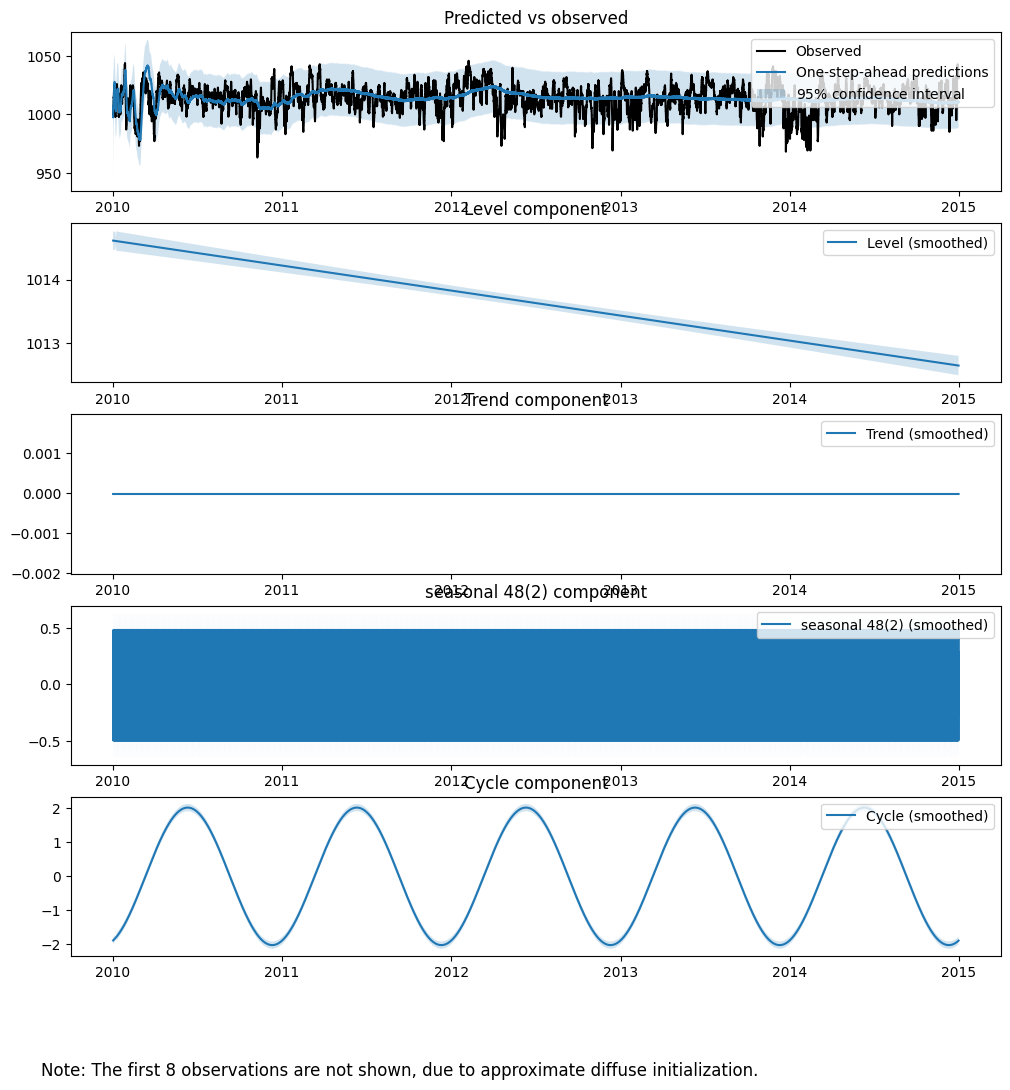

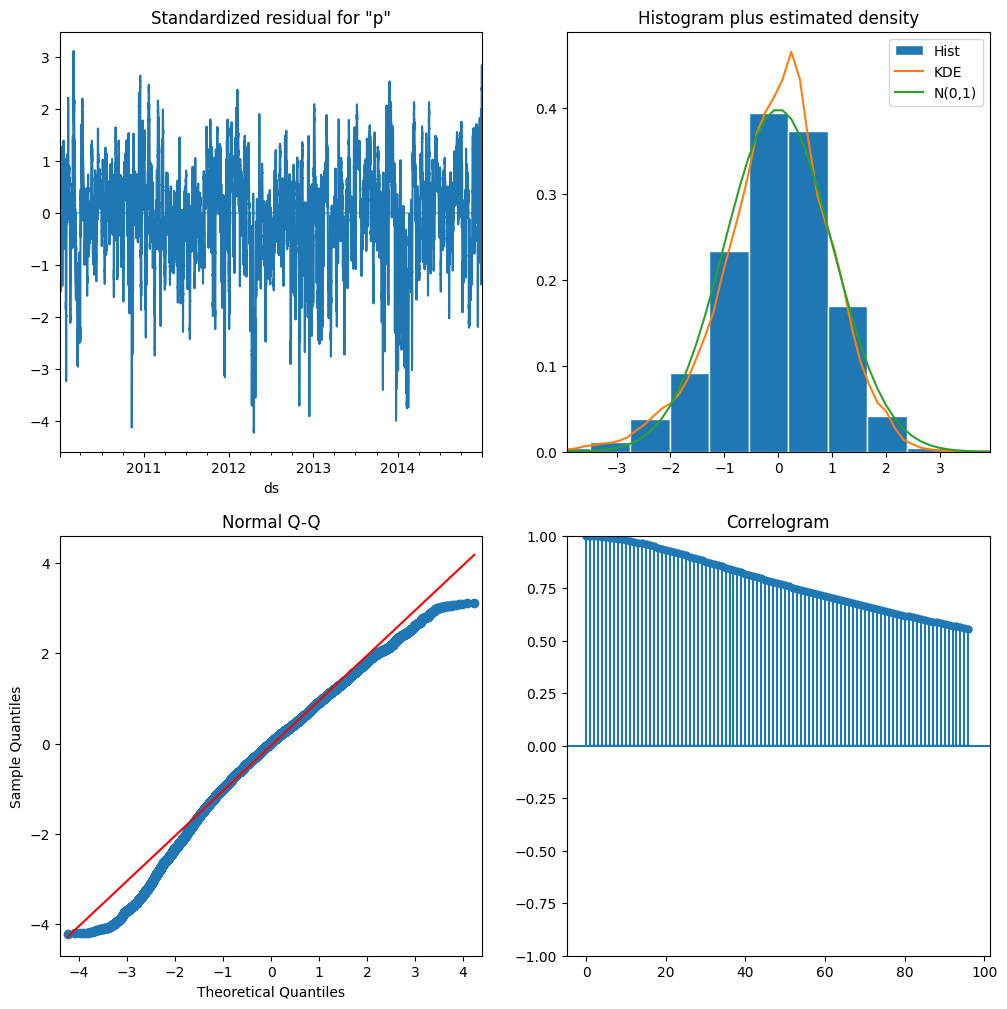


Out-of-sample mean absolute error (MAE): 1003.25
Out-of-sample root mean squared error (RMSE): 1003.27


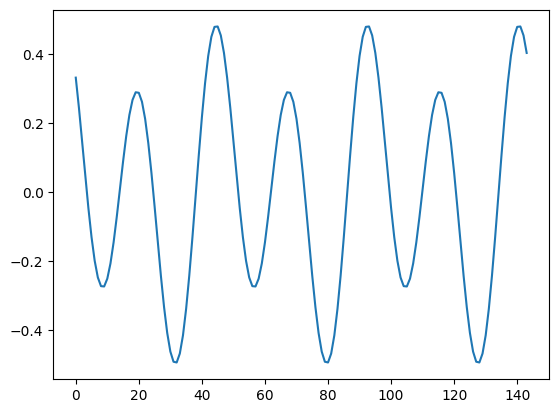

In [24]:
uc_params = {# exog  = df[['humidity','dew.point','pressure','wind.speed.mean.x','wind.speed.mean.y']].dropna(),
             # exog = train_df[['humidity','dew.point']].interpolate(method='slinear'),
             # 'exog': train_df[['dew.point_des']].interpolate(method='linear'),
             # level = 'deterministic constant',
             'level': 'deterministic trend',
             #'level': 'smooth trend',
             #'level': 'local linear trend',
             'cycle': True,
             # irregular = True,
             # 'autoregressive': 1,
             'cycle_period_bounds': (17531, 17533),
             'stochastic_freq_seasonal': [False],
             'freq_seasonal': [{'period':    48,
                                'harmonics':  2}]}

press_df = df[(df.index.year >= 2010) & (df.index.year < 2015)]
press_df['log_pressure'] = np.log(press_df['pressure'])
res_press = get_uc_model(press_df, uc_params, 'pressure')
# check_uc_model(res_press, valid_df)

plt.plot(res_press.freq_seasonal[0]['smoothed'][:144])
plt.show()

...

---

### Split Data

I use data from 2021 for validation, 2022 for testing and the remaining data for training. These are entirely arbitrary choices. This results in an approximate 88%, 6%, 6% split for the training, validation, and test sets respectively.

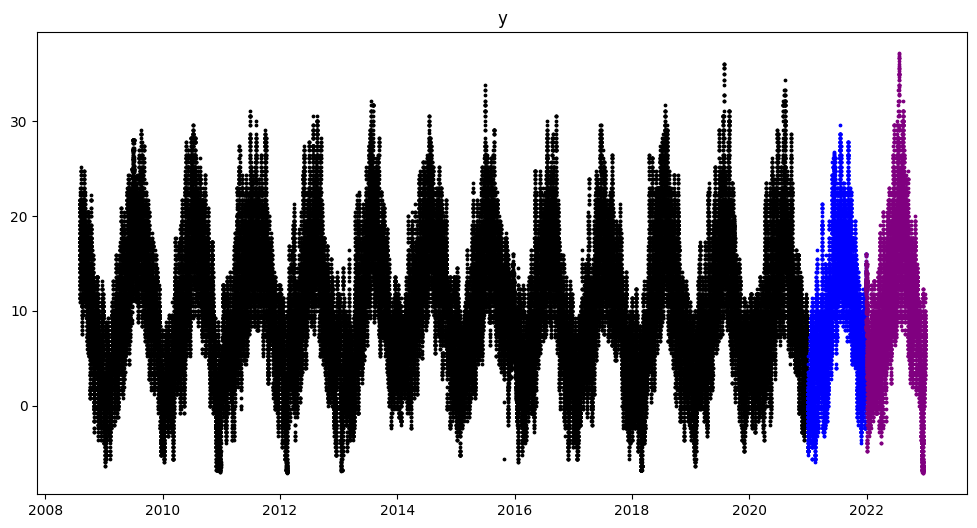

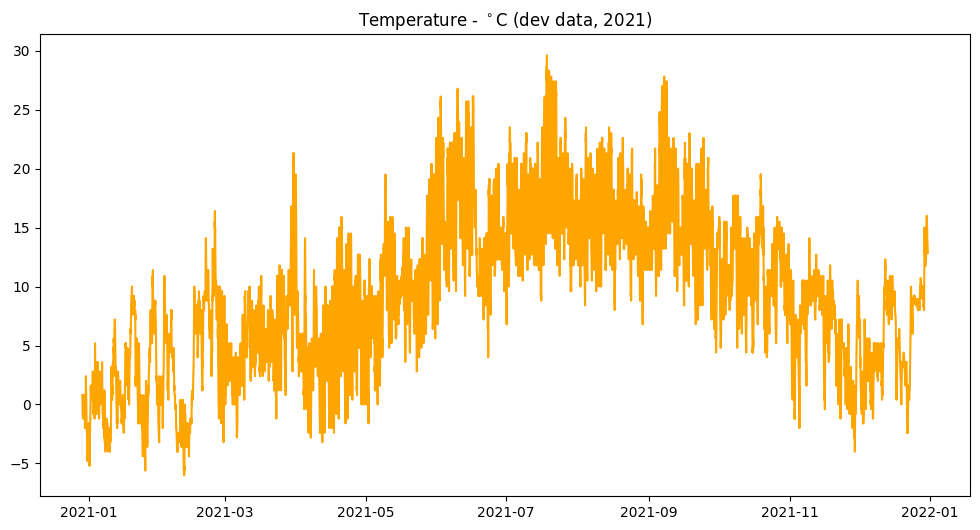

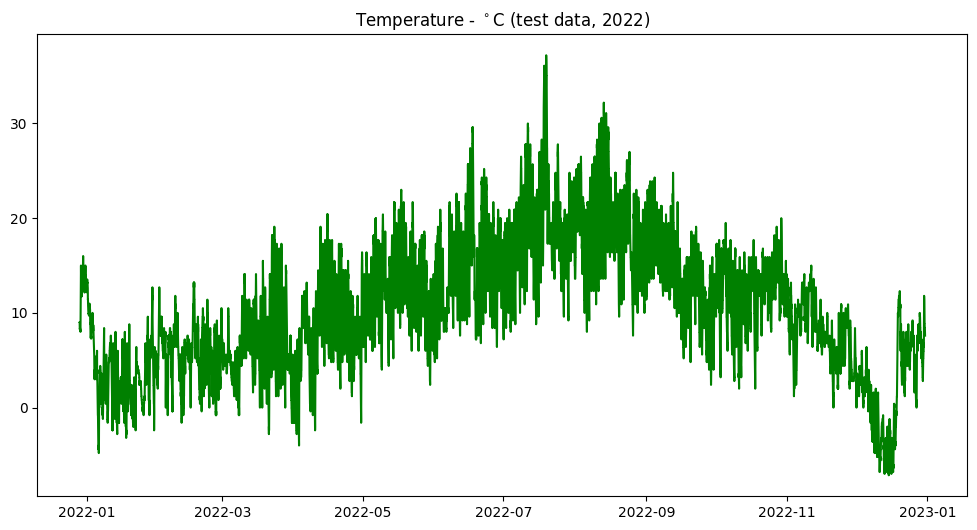

df shape:  (252768, 76)
train shape:    (217728, 76)
valid shape:    (17617, 76)
test shape:     (17617, 76)
ERROR: Overlap between train_df, valid_df indices!
max(train_df.index): 2020-12-31 23:30:00
min(valid_df.index): 2021-12-31 00:00:00
ERROR: Overlap between valid_df, test_df indices!
valid_df.index: 2021-12-31 00:00:00 - 2021-12-31 00:00:00
test_df.index: 2022-12-31 00:00:00 - 2022-12-31 00:00:00
ERROR: valid_df should be 1 year long [ 17520 , 17568 ]!
valid_df observations: 17617
ERROR: test_df should be 1 year long [ 17520 , 17568 ]!
test_df observations: 17617

 train_df null columns:


Series([], dtype: float64)


 valid_df null columns:


Series([], dtype: float64)


 test_df null columns:


Series([], dtype: float64)

In [8]:
# df['year'] = df['ds'].dt.year
# WARN: Crucially important valid & test data are both after train data to
#       avoid data leakage
# train_df = df.loc[(df['year'] != VALID_YEAR) & (df['year'] != TEST_YEAR)]
train_df = df.loc[df['year'] < min(VALID_YEAR, TEST_YEAR)]
valid_df = df.loc[(df['ds'] >= '2020-12-29') & (df['ds'] <= '2021-12-31')]
test_df  = df.loc[(df['ds'] >= '2021-12-29') & (df['ds'] <= '2022-12-31')]
# valid_df = df.loc[df['year'] == VALID_YEAR]
# test_df  = df.loc[df['year'] == TEST_YEAR]

#train_df.loc[train_df['ds'].dt.year >= 2018, 'ds'] = train_df.loc[train_df['ds'].dt.year >= 2018, 'ds'] - pd.DateOffset(years=2)
#train_df.set_index('ds', drop=False, inplace=True)
#train_df = train_df[~train_df.index.duplicated(keep='first')]


plot_feature_history(train_df, valid_df, test_df, 'y')

plt.figure(figsize = (12, 6))
plt.plot(valid_df.ds, valid_df.y, color='orange')
plt_title = 'Temperature - $^\circ$C (dev data, ' + str(VALID_YEAR) + ')'
plt.title(plt_title)
plt.show()

plt.figure(figsize = (12, 6))
plt.plot(test_df.ds, test_df.y, color='green')
plt_title = 'Temperature - $^\circ$C (test data, ' + str(TEST_YEAR) + ')'
plt.title(plt_title)
plt.show()


del_cols = ['year']
train_df = train_df.drop(del_cols, axis = 1)
valid_df = valid_df.drop(del_cols, axis = 1)
test_df  = test_df.drop(del_cols,  axis = 1)
df = df.drop(['year'], axis = 1)

# DO NOT USE ffill with train_df - ffills 2018 & 2019!
# train_df = train_df.asfreq(freq='30min', method='ffill')
train_df = train_df.asfreq(freq='30min', fill_value=np.nan)

# DO USE ffill with valid_df, test_df
# avoids missing value errors when calculating metrics etc
valid_df = valid_df.asfreq(freq='30min', fill_value=np.nan)
test_df  =  test_df.asfreq(freq='30min', fill_value=np.nan)
# valid_df = valid_df.asfreq(freq='30min', method='ffill')
# test_df  =  test_df.asfreq(freq='30min', method='ffill')

print_train_valid_test_shapes(df, train_df, valid_df, test_df)
sanity_check_train_valid_test(train_df, valid_df, test_df)
print_null_columns(train_df, 'train_df')
print_null_columns(valid_df, 'valid_df')
print_null_columns(test_df,  'test_df')




---

### Normalise Data

Features do not need to be scaled for gradient boosting methods. Nonetheless, it can often be a
useful sanity check.

The [violin plot](https://en.wikipedia.org/wiki/Violin_plot) shows the distribution of features.

<ipython-input-9-6bbf30968e11>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(cols, rotation = 45)


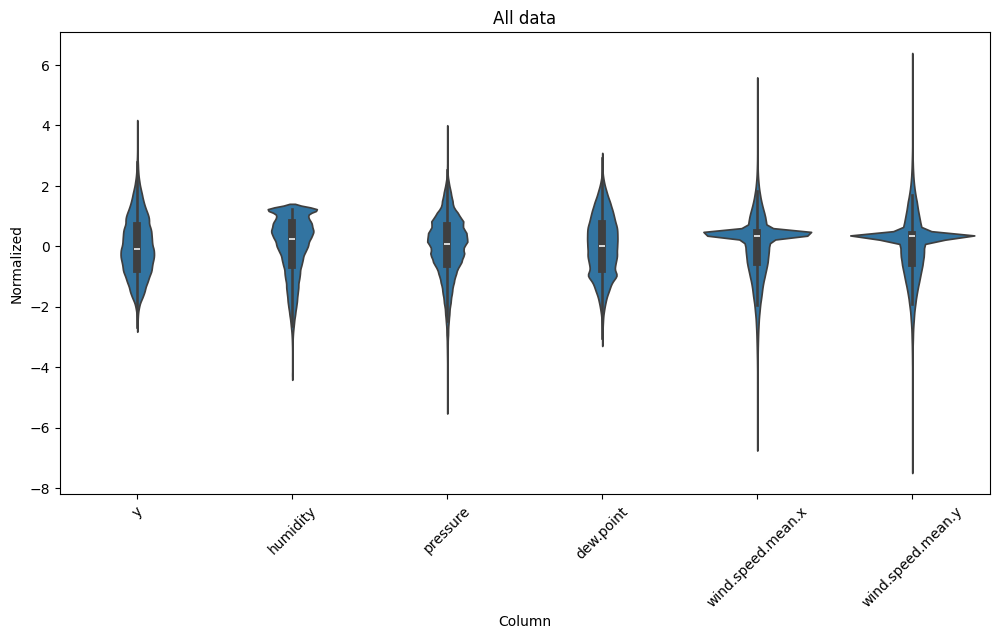

In [9]:
def inv_transform(scaler, data, colName, colNames):
    """An inverse scaler for use in model validation section

    For later use in plot_forecasts, plot_horizon_metrics and check_residuals

    See https://stackoverflow.com/a/62170887/100129"""

    dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
    dummy[colName] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)

    return dummy[colName].values


cols = ['y', 'humidity', 'pressure', 'dew.point', 'wind.speed.mean.x',
        'wind.speed.mean.y']
train_df_norm = train_df.loc[:, cols]
scaler = StandardScaler()
scaler.fit(train_df_norm)

train_df_norm = scaler.transform(train_df_norm)
# valid_df[valid_df.columns] = scaler.transform(valid_df[valid_df.columns] )
# test_df[test_df.columns]   = scaler.transform(test_df[test_df.columns] )

#df_std = scaler.transform(df)
df_std = pd.DataFrame(train_df_norm)
df_std = df_std.melt(var_name = 'Column', value_name = 'Normalized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x = 'Column', y = 'Normalized', data = df_std)
ax.set_xticklabels(cols, rotation = 45)
ax.set_title('All data');


Some features have long tails but there are no glaring errors.


---

### Seasonal Decomposition

Time series decomposition with prophet

Decomposition transforms time series into trend, seasonal and noise (residual) components.  These components are combined either additively or multiplicatively.  It is important to understand the time series components to better model and forecast future values.  Later on, I forecast the residual temperature components using lightgbm and add the trend and seasonal components to these forecasts to make the final predictions.

[Prophet](https://facebook.github.io/prophet/) is a python and R package for forecasting.  It is based on a model where non-linear trends are fit with yearly and daily seasonality but is quite flexible.  It works best with time series that have strong seasonal effects and several seasons of historical data.  In my experience it does not produce the best forecasts but I like its API and it can produce both additive and multiplicative multi-seasonal harmonic-based decompositions.  Like loess-based decompositions, a little parameter tuning is beneficial.  The details of how Prophet calculates multiplicative seasonality is outlined [here](https://github.com/facebook/prophet/issues/1245) and [here](https://www.kaggle.com/code/smakarychev/what-is-facebook-prophet-forecasting-model#Multiplicative-and-additive-terms).

The [Season-Trend decomposition using LOESS for multiple seasonalities](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.MSTL.html) from statsmodels is *currently* additive only.

DEBUG:cmdstanpy:input tempfile: /tmp/tmpt4f_etqs/4u41stzq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt4f_etqs/q7915byh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97478', 'data', 'file=/tmp/tmpt4f_etqs/4u41stzq.json', 'init=/tmp/tmpt4f_etqs/q7915byh.json', 'output', 'file=/tmp/tmpt4f_etqs/prophet_modelxj7ylwmt/prophet_model-20240129122652.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:26:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:26:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


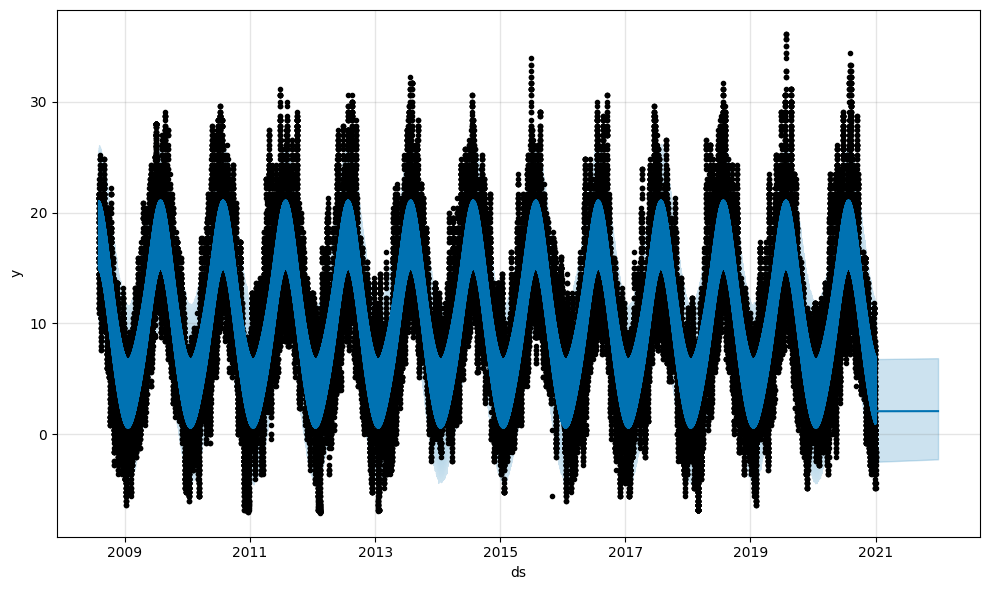

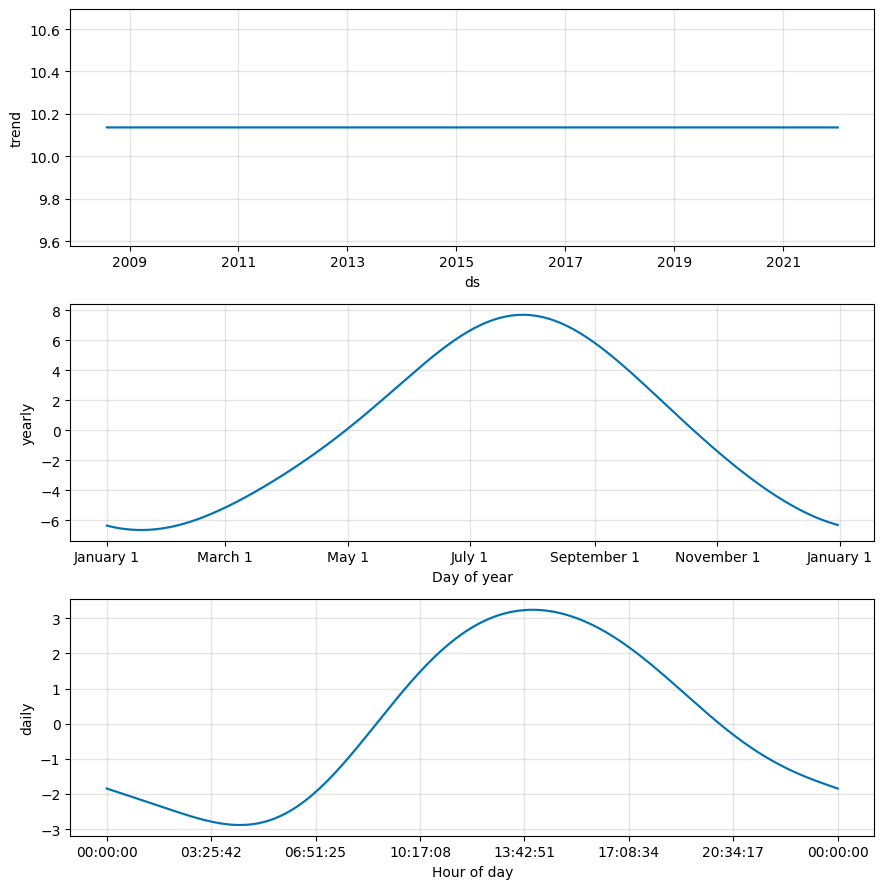

ds     y    humidity  dew.point  \
ds                                                                     
2008-08-01 00:00:00 2008-08-01 00:00:00  20.0   89.221997   1.610001   
2008-08-01 00:30:00 2008-08-01 00:30:00  19.5   88.290807   1.657847   
2008-08-01 01:00:00 2008-08-01 01:00:00  19.1   85.755790   1.432873   
2008-08-01 01:30:00 2008-08-01 01:30:00  19.1   85.572379   1.397409   
2008-08-01 02:00:00 2008-08-01 02:00:00  19.1   84.345642   1.278219   
...                                 ...   ...         ...        ...   
2020-12-31 21:30:00 2020-12-31 21:30:00  -2.8   96.000000  -3.300000   
2020-12-31 22:00:00 2020-12-31 22:00:00  -3.2  100.000000  -3.200000   
2020-12-31 22:30:00 2020-12-31 22:30:00  -3.6  100.000000  -3.600000   
2020-12-31 23:00:00 2020-12-31 23:00:00  -4.4   97.000000  -4.800000   
2020-12-31 23:30:00 2020-12-31 23:30:00  -4.8   99.000000  -4.900000   

                        pressure  pressure.log  y_window_48_min_max_diff  \
ds                                                                         
2008-08-01 00:00:00  1009.926805      6.917633                       0.4   
2008-08-01 00:30:00  1009.931495      6.917638                       0.9   
2008-08-01 01:00:00  1010.092861      6.917798                       1.3   
2008-08-01 01:30:00  1009.902342      6.917609                       1.3   
2008-08-01 02:00:00  1010.133476      6.917838                       1.3   
...                          ...           ...                       ...   
2020-12-31 21:30:00  1006.000000      6.913737                       3.2   
2020-12-31 22:00:00  1007.000000      6.914731                       3.2   
2020-12-31 22:30:00  1007.000000      6.914731                       3.2   
2020-12-31 23:00:00  1007.000000      6.914731                       3.2   
2020-12-31 23:30:00  1007.000000      6.914731                       3.2   

                     wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
ds                                                                              
2008-08-01 00:00:00              1.897367              3.6              225.0   
2008-08-01 00:30:00              1.897367              3.6              225.0   
2008-08-01 01:00:00              1.897367              3.6              225.0   
2008-08-01 01:30:00              1.897367              3.6              225.0   
2008-08-01 02:00:00              1.897367              3.6              225.0   
...                                   ...              ...                ...   
2020-12-31 21:30:00              0.000000              0.0              270.0   
2020-12-31 22:00:00              0.000000              0.0              270.0   
2020-12-31 22:30:00              0.000000              0.0              270.0   
2020-12-31 23:00:00              0.000000              0.0              270.0   
2020-12-31 23:30:00              0.632456              0.4              270.0   

                     ...  azimuth_rad  azimuth_cos  azimuth_sin  \
ds                   ...                                          
2008-08-01 00:00:00  ...     0.841286     0.841286     0.841286   
2008-08-01 00:30:00  ...     0.838420     0.838420     0.838420   
2008-08-01 01:00:00  ...     0.826011     0.826011     0.826011   
2008-08-01 01:30:00  ...     0.803883     0.803883     0.803883   
2008-08-01 02:00:00  ...     0.771879     0.771879     0.771879   
...                  ...          ...          ...          ...   
2020-12-31 21:30:00  ...     0.482278     0.482278     0.482278   
2020-12-31 22:00:00  ...     0.592314     0.592314     0.592314   
2020-12-31 22:30:00  ...     0.691123     0.691123     0.691123   
2020-12-31 23:00:00  ...     0.770125     0.770125     0.770125   
2020-12-31 23:30:00  ...     0.821600     0.821600     0.821600   

                     azimuth_diff_1  azimuth_rad_diff_1  azimuth_cos_diff_1  \
ds                                                                            
2008-08-01 00:00:00       -

<ipython-input-10-186207976926>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'] = df[col_name]
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt4f_etqs/q8jajj45.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt4f_etqs/pagsl5ok.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26013', 'data', 'file=/tmp/tmpt4f_etqs/q8jajj45.json', 'init=/tmp/tmpt4f_etqs/pagsl5ok.json', 'output', 'file=/tmp/tmpt4f_etqs/prophet_modelrc8mp32l/prophet_model-20240129122806.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:28:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start p

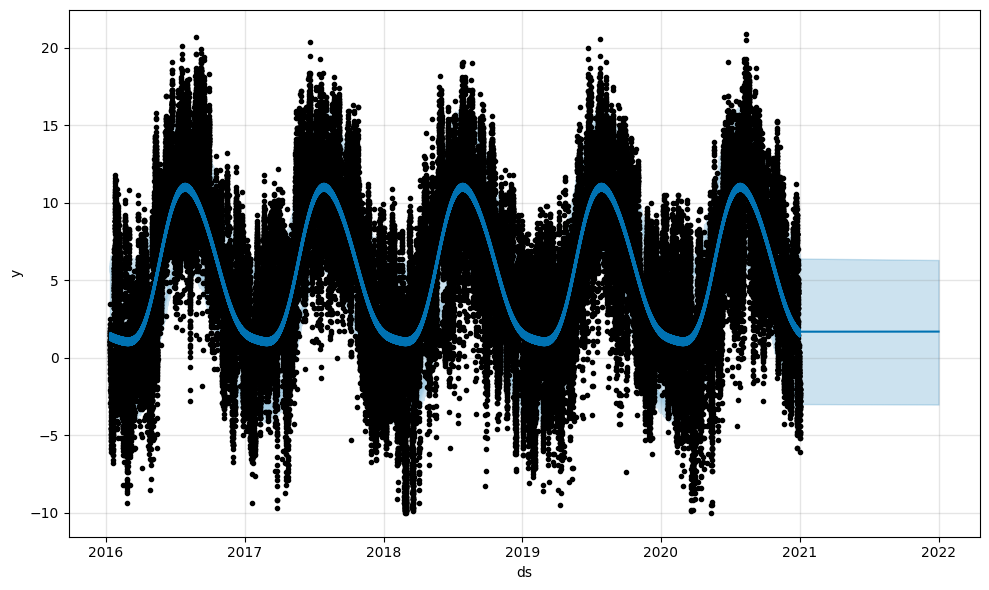

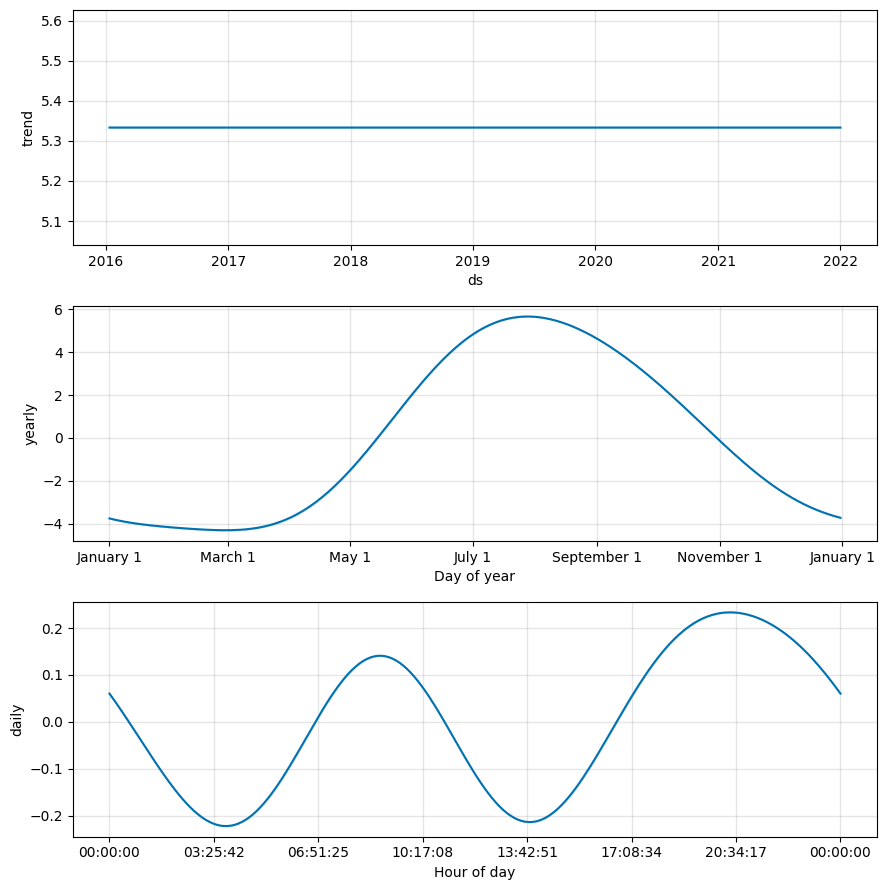

ds     y    humidity  dew.point  \
ds                                                                     
2008-08-01 00:00:00 2008-08-01 00:00:00  20.0   89.221997   1.610001   
2008-08-01 00:30:00 2008-08-01 00:30:00  19.5   88.290807   1.657847   
2008-08-01 01:00:00 2008-08-01 01:00:00  19.1   85.755790   1.432873   
2008-08-01 01:30:00 2008-08-01 01:30:00  19.1   85.572379   1.397409   
2008-08-01 02:00:00 2008-08-01 02:00:00  19.1   84.345642   1.278219   
...                                 ...   ...         ...        ...   
2020-12-31 21:30:00 2020-12-31 21:30:00  -2.8   96.000000  -3.300000   
2020-12-31 22:00:00 2020-12-31 22:00:00  -3.2  100.000000  -3.200000   
2020-12-31 22:30:00 2020-12-31 22:30:00  -3.6  100.000000  -3.600000   
2020-12-31 23:00:00 2020-12-31 23:00:00  -4.4   97.000000  -4.800000   
2020-12-31 23:30:00 2020-12-31 23:30:00  -4.8   99.000000  -4.900000   

                        pressure  pressure.log  y_window_48_min_max_diff  \
ds                                                                         
2008-08-01 00:00:00  1009.926805      6.917633                       0.4   
2008-08-01 00:30:00  1009.931495      6.917638                       0.9   
2008-08-01 01:00:00  1010.092861      6.917798                       1.3   
2008-08-01 01:30:00  1009.902342      6.917609                       1.3   
2008-08-01 02:00:00  1010.133476      6.917838                       1.3   
...                          ...           ...                       ...   
2020-12-31 21:30:00  1006.000000      6.913737                       3.2   
2020-12-31 22:00:00  1007.000000      6.914731                       3.2   
2020-12-31 22:30:00  1007.000000      6.914731                       3.2   
2020-12-31 23:00:00  1007.000000      6.914731                       3.2   
2020-12-31 23:30:00  1007.000000      6.914731                       3.2   

                     wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
ds                                                                              
2008-08-01 00:00:00              1.897367              3.6              225.0   
2008-08-01 00:30:00              1.897367              3.6              225.0   
2008-08-01 01:00:00              1.897367              3.6              225.0   
2008-08-01 01:30:00              1.897367              3.6              225.0   
2008-08-01 02:00:00              1.897367              3.6              225.0   
...                                   ...              ...                ...   
2020-12-31 21:30:00              0.000000              0.0              270.0   
2020-12-31 22:00:00              0.000000              0.0              270.0   
2020-12-31 22:30:00              0.000000              0.0              270.0   
2020-12-31 23:00:00              0.000000              0.0              270.0   
2020-12-31 23:30:00              0.632456              0.4              270.0   

                     ...  azimuth_rad  azimuth_cos  azimuth_sin  \
ds                   ...                                          
2008-08-01 00:00:00  ...     0.841286     0.841286     0.841286   
2008-08-01 00:30:00  ...     0.838420     0.838420     0.838420   
2008-08-01 01:00:00  ...     0.826011     0.826011     0.826011   
2008-08-01 01:30:00  ...     0.803883     0.803883     0.803883   
2008-08-01 02:00:00  ...     0.771879     0.771879     0.771879   
...                  ...          ...          ...          ...   
2020-12-31 21:30:00  ...     0.482278     0.482278     0.482278   
2020-12-31 22:00:00  ...     0.592314     0.592314     0.592314   
2020-12-31 22:30:00  ...     0.691123     0.691123     0.691123   
2020-12-31 23:00:00  ...     0.770125     0.770125     0.770125   
2020-12-31 23:30:00  ...     0.821600     0.821600     0.821600   

                     azimuth_diff_1  azimuth_rad_diff_1  azimuth_cos_diff_1  \
ds                                                                            
2008-08-01 00:00:00       -

<ipython-input-10-186207976926>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'] = df[col_name]
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt4f_etqs/edxrv_hb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt4f_etqs/s2fl0iz2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35406', 'data', 'file=/tmp/tmpt4f_etqs/edxrv_hb.json', 'init=/tmp/tmpt4f_etqs/s2fl0iz2.json', 'output', 'file=/tmp/tmpt4f_etqs/prophet_model5_regwn_/prophet_model-20240129122833.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:28:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start p

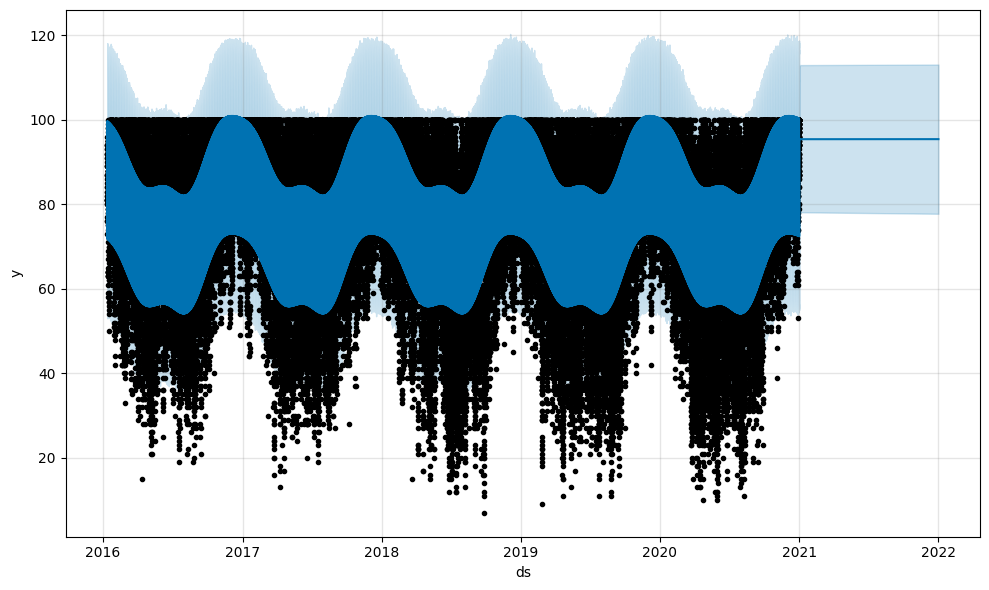

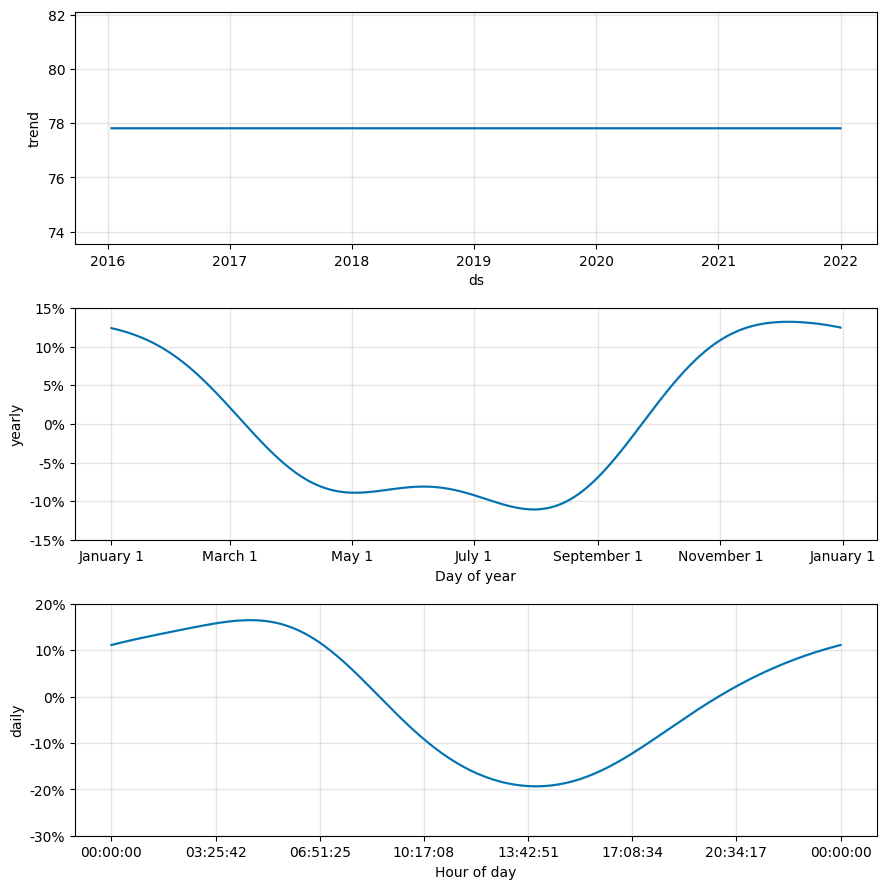

ds     y    humidity  dew.point  \
ds                                                                     
2008-08-01 00:00:00 2008-08-01 00:00:00  20.0   89.221997   1.610001   
2008-08-01 00:30:00 2008-08-01 00:30:00  19.5   88.290807   1.657847   
2008-08-01 01:00:00 2008-08-01 01:00:00  19.1   85.755790   1.432873   
2008-08-01 01:30:00 2008-08-01 01:30:00  19.1   85.572379   1.397409   
2008-08-01 02:00:00 2008-08-01 02:00:00  19.1   84.345642   1.278219   
...                                 ...   ...         ...        ...   
2020-12-31 21:30:00 2020-12-31 21:30:00  -2.8   96.000000  -3.300000   
2020-12-31 22:00:00 2020-12-31 22:00:00  -3.2  100.000000  -3.200000   
2020-12-31 22:30:00 2020-12-31 22:30:00  -3.6  100.000000  -3.600000   
2020-12-31 23:00:00 2020-12-31 23:00:00  -4.4   97.000000  -4.800000   
2020-12-31 23:30:00 2020-12-31 23:30:00  -4.8   99.000000  -4.900000   

                        pressure  pressure.log  y_window_48_min_max_diff  \
ds                                                                         
2008-08-01 00:00:00  1009.926805      6.917633                       0.4   
2008-08-01 00:30:00  1009.931495      6.917638                       0.9   
2008-08-01 01:00:00  1010.092861      6.917798                       1.3   
2008-08-01 01:30:00  1009.902342      6.917609                       1.3   
2008-08-01 02:00:00  1010.133476      6.917838                       1.3   
...                          ...           ...                       ...   
2020-12-31 21:30:00  1006.000000      6.913737                       3.2   
2020-12-31 22:00:00  1007.000000      6.914731                       3.2   
2020-12-31 22:30:00  1007.000000      6.914731                       3.2   
2020-12-31 23:00:00  1007.000000      6.914731                       3.2   
2020-12-31 23:30:00  1007.000000      6.914731                       3.2   

                     wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
ds                                                                              
2008-08-01 00:00:00              1.897367              3.6              225.0   
2008-08-01 00:30:00              1.897367              3.6              225.0   
2008-08-01 01:00:00              1.897367              3.6              225.0   
2008-08-01 01:30:00              1.897367              3.6              225.0   
2008-08-01 02:00:00              1.897367              3.6              225.0   
...                                   ...              ...                ...   
2020-12-31 21:30:00              0.000000              0.0              270.0   
2020-12-31 22:00:00              0.000000              0.0              270.0   
2020-12-31 22:30:00              0.000000              0.0              270.0   
2020-12-31 23:00:00              0.000000              0.0              270.0   
2020-12-31 23:30:00              0.632456              0.4              270.0   

                     ...  azimuth_rad  azimuth_cos  azimuth_sin  \
ds                   ...                                          
2008-08-01 00:00:00  ...     0.841286     0.841286     0.841286   
2008-08-01 00:30:00  ...     0.838420     0.838420     0.838420   
2008-08-01 01:00:00  ...     0.826011     0.826011     0.826011   
2008-08-01 01:30:00  ...     0.803883     0.803883     0.803883   
2008-08-01 02:00:00  ...     0.771879     0.771879     0.771879   
...                  ...          ...          ...          ...   
2020-12-31 21:30:00  ...     0.482278     0.482278     0.482278   
2020-12-31 22:00:00  ...     0.592314     0.592314     0.592314   
2020-12-31 22:30:00  ...     0.691123     0.691123     0.691123   
2020-12-31 23:00:00  ...     0.770125     0.770125     0.770125   
2020-12-31 23:30:00  ...     0.821600     0.821600     0.821600   

                     azimuth_diff_1  azimuth_rad_diff_1  azimuth_cos_diff_1  \
ds                                                                            
2008-08-01 00:00:00       -

DEBUG:cmdstanpy:input tempfile: /tmp/tmpt4f_etqs/2qsezmhz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt4f_etqs/imc7ln93.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31770', 'data', 'file=/tmp/tmpt4f_etqs/2qsezmhz.json', 'init=/tmp/tmpt4f_etqs/imc7ln93.json', 'output', 'file=/tmp/tmpt4f_etqs/prophet_modell46vm0rg/prophet_model-20240129122904.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:29:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:29:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


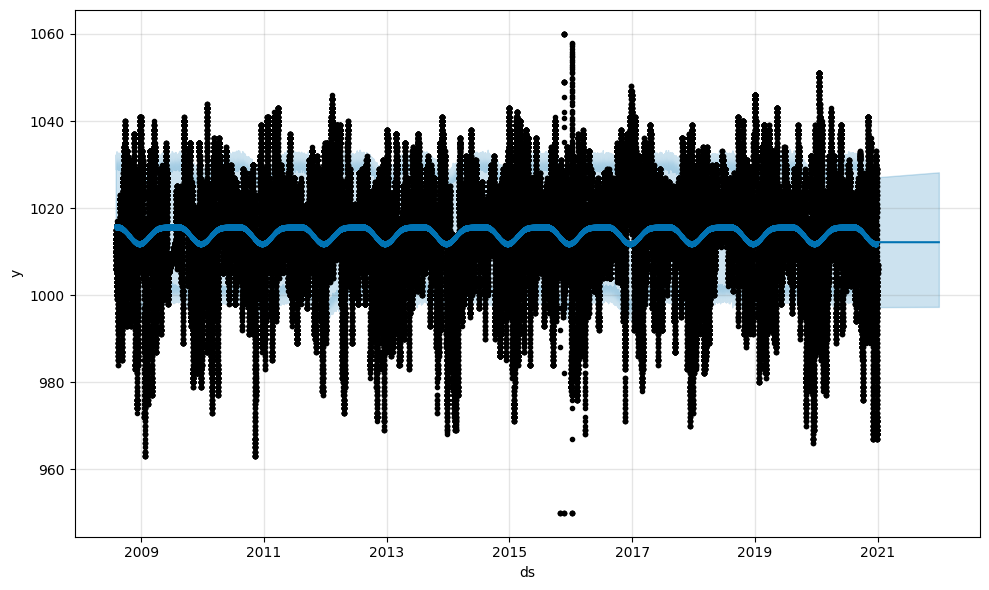

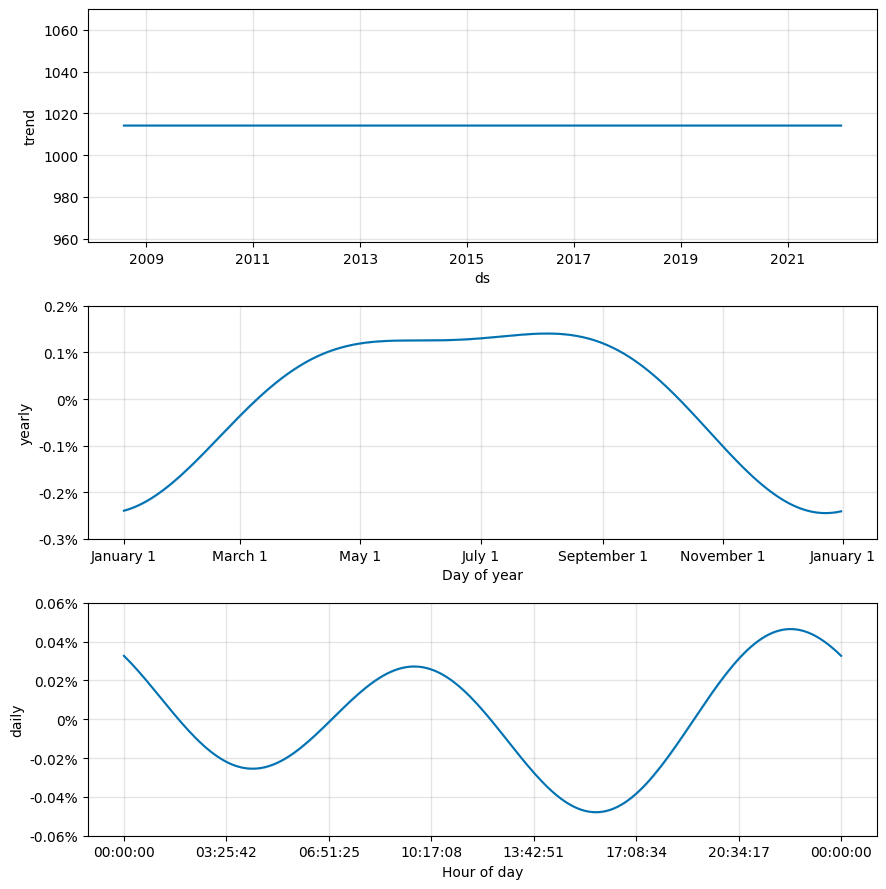

f_all:


y_trend   y_daily  y_yearly    y_yhat     y_des  \
key_0                                                                    
2016-01-12 00:00:00  10.136808 -1.843996 -6.607021  1.685791 -0.085791   
2016-01-12 00:30:00  10.136808 -1.987274 -6.607307  1.542227  0.457773   
2016-01-12 01:00:00  10.136808 -2.129682 -6.607593  1.399533  1.400467   
2016-01-12 01:30:00  10.136808 -2.274232 -6.607878  1.254698  0.745302   
2016-01-12 02:00:00  10.136808 -2.420156 -6.608162  1.108490  1.291510   
...                        ...       ...       ...       ...       ...   
2020-12-31 22:00:00  10.136808 -1.125864 -6.358769  2.652175 -5.852175   
2020-12-31 22:30:00  10.136808 -1.342326 -6.359480  2.435002 -6.035002   
2020-12-31 23:00:00  10.136808 -1.529351 -6.360190  2.247266 -6.647266   
2020-12-31 23:30:00  10.136808 -1.693909 -6.360900  2.081999 -6.881999   
2021-12-31 23:30:00  10.136808 -1.693909 -6.352330  2.090570       NaN   

                     dew.point_trend  dew.point_daily  dew.point_yearly  \
key_0                                                                     
2016-01-12 00:00:00         5.333283         0.060370         -3.945941   
2016-01-12 00:30:00         5.333283         0.013359         -3.946258   
2016-01-12 01:00:00         5.333283        -0.036143         -3.946576   
2016-01-12 01:30:00         5.333283        -0.085645         -3.946893   
2016-01-12 02:00:00         5.333283        -0.132068         -3.947210   
...                              ...              ...               ...   
2020-12-31 22:00:00         5.333283         0.196876         -3.748773   
2020-12-31 22:30:00         5.333283         0.171743         -3.749262   
2020-12-31 23:00:00         5.333283         0.140407         -3.749750   
2020-12-31 23:30:00         5.333283         0.103092         -3.750238   
2021-12-31 23:30:00         5.333283         0.103092         -3.744356   

                     dew.point_yhat  dew.point_des  humidity_trend  \
key_0                                                                
2016-01-12 00:00:00        1.447712      -0.447712         77.8159   
2016-01-12 00:30:00        1.400384      -0.300384         77.8159   
2016-01-12 01:00:00        1.350564      -0.450564         77.8159   
2016-01-12 01:30:00        1.300745      -0.300745         77.8159   
2016-01-12 02:00:00        1.254005      -0.454005         77.8159   
...                             ...            ...             ...   
2020-12-31 22:00:00        1.781385      -4.981385         77.8159   
2020-12-31 22:30:00        1.755764      -5.355764         77.8159   
2020-12-31 23:00:00        1.723939      -6.523939         77.8159   
2020-12-31 23:30:00        1.686136      -6.586136         77.8159   
2021-12-31 23:30:00        1.692018            NaN         77.8159   

                     humidity_daily  humidity_yearly  humidity_yhat  \
key_0                                                                 
2016-01-12 00:00:00        0.111100         0.116510      95.527529   
2016-01-12 00:30:00        0.119144         0.116491      96.152057   
2016-01-12 01:00:00        0.126462         0.116473      96.720031   
2016-01-12 01:30:00        0.133337         0.116454      97.253634   
2016-01-12 02:00:00        0.140003         0.116435      97.770871   
...                             ...              ...            ...   
2020-12-31 22:00:00        0.067262         0.124059      92.703760   
2020-12-31 22:30:00        0.080249         0.124047      93.713368   
2020-12-31 23:00:00        0.091823         0.124035      94.613064   
2020-12-31 23:30:00        0.102061         0.124023      95.408836   
2021-12-31 23:30:00        0.102061         0.124169      95.420204   

                     humidity_des  pressure_trend  pressure_daily  \
key_0                                                               
2016-01-12 00:00:00      1.004946      1014.18468        0.000326   
2016-01-12 00:30:00      0.977618      101

valid_df:


ds          y   humidity  dew.point  \
ds                                                                         
2020-12-29 00:00:00 2020-12-29 00:00:00   0.800000  90.000000  -0.700000   
2020-12-29 00:30:00 2020-12-29 00:30:00   0.800000  94.000000  -0.100000   
2020-12-29 01:00:00 2020-12-29 01:00:00   0.400000  89.000000  -1.200000   
2020-12-29 01:30:00 2020-12-29 01:30:00   0.400000  99.000000   0.300000   
2020-12-29 02:00:00 2020-12-29 02:00:00   0.000000  89.000000  -1.600000   
...                                 ...        ...        ...        ...   
2021-12-30 22:00:00 2021-12-30 22:00:00  13.246471  82.576513   1.915964   
2021-12-30 22:30:00 2021-12-30 22:30:00  13.136189  82.825685   1.949313   
2021-12-30 23:00:00 2021-12-30 23:00:00  13.025560  83.288122   1.983274   
2021-12-30 23:30:00 2021-12-30 23:30:00  12.909036  83.603083   2.017333   
2021-12-31 00:00:00 2021-12-31 00:00:00  12.850597  83.469559   2.014557   

                        pressure  pressure.log  y_window_48_min_max_diff  \
ds                                                                         
2020-12-29 00:00:00   979.000000      6.886532                  3.200000   
2020-12-29 00:30:00   978.000000      6.885510                  3.200000   
2020-12-29 01:00:00   979.000000      6.886532                  3.200000   
2020-12-29 01:30:00   979.000000      6.886532                  3.200000   
2020-12-29 02:00:00   979.000000      6.886532                  3.200000   
...                          ...           ...                       ...   
2021-12-30 22:00:00  1009.356783      6.917069                  4.151170   
2021-12-30 22:30:00  1009.374615      6.917086                  4.038430   
2021-12-30 23:00:00  1009.391309      6.917103                  3.949476   
2021-12-30 23:30:00  1009.407420      6.917119                  3.862634   
2021-12-31 00:00:00  1009.423539      6.917135                  3.862634   

                     wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
ds                                                                              
2020-12-29 00:00:00              2.000000         4.000000              270.0   
2020-12-29 00:30:00              2.097618         4.400000              270.0   
2020-12-29 01:00:00              1.788854         3.200000              270.0   
2020-12-29 01:30:00              1.449138         2.100000              270.0   
2020-12-29 02:00:00              1.516575         2.300000              270.0   
...                                   ...              ...                ...   
2021-12-30 22:00:00              2.458404         6.043750              220.0   
2021-12-30 22:30:00              2.455224         6.028125              220.0   
2021-12-30 23:00:00              2.452040         6.012500              220.0   
2021-12-30 23:30:00              2.448852         5.996875              220.0   
2021-12-31 00:00:00              2.445659         5.981250              220.0   

                     ...  pressure_yearly  pressure_yhat      y_des  \
ds                   ...                                              
2020-12-29 00:00:00  ...        -0.002423    1012.058556  -1.241838   
2020-12-29 00:30:00  ...        -0.002423    1011.975801  -1.097733   
2020-12-29 01:00:00  ...        -0.002422    1011.883645  -1.354498   
2020-12-29 01:30:00  ...        -0.002422    1011.788527  -1.209122   
2020-12-29 02:00:00  ...        -0.002422    1011.696956  -1.462373   
...                  ...              ...            ...        ...   
2021-12-30 22:00:00  ...        -0.002406    1012.210470  10.559172   
2021-12-30 22:30:00  ...        -0.002406    1012.213773  10.666102   
2021-12-30 23:00:00  ...        -0.002406    1012.190802  10.743249   
2021-12-30 23:30:00  ...        -0.002405    1012.143760  10.792033   
2021-12-31 00:00:00  ...        -0.002405    1012.076385  10.884430   

                     y_des_diff_1  dew.point_des  dew.point_des_diff_1  \
ds     

test_df:


ds         y   humidity  dew.point  \
ds                                                                        
2021-12-29 00:00:00 2021-12-29 00:00:00  9.018013  80.712206   1.424063   
2021-12-29 00:30:00 2021-12-29 00:30:00  9.024635  80.785103   1.398200   
2021-12-29 01:00:00 2021-12-29 01:00:00  8.791503  83.094214   1.432567   
2021-12-29 01:30:00 2021-12-29 01:30:00  8.271475  82.180770   1.665441   
2021-12-29 02:00:00 2021-12-29 02:00:00  8.271705  82.324921   1.633612   
...                                 ...       ...        ...        ...   
2022-12-30 22:00:00 2022-12-30 22:00:00  8.400000  73.000000   3.800000   
2022-12-30 22:30:00 2022-12-30 22:30:00  8.000000  76.000000   4.000000   
2022-12-30 23:00:00 2022-12-30 23:00:00  8.000000  79.000000   4.600000   
2022-12-30 23:30:00 2022-12-30 23:30:00  8.000000  84.000000   5.500000   
2022-12-31 00:00:00 2022-12-31 00:00:00  7.600000  82.000000   4.700000   

                        pressure  pressure.log  y_window_48_min_max_diff  \
ds                                                                         
2021-12-29 00:00:00  1007.854619      6.915579                  1.523850   
2021-12-29 00:30:00  1007.871259      6.915596                  1.523473   
2021-12-29 01:00:00  1007.888116      6.915612                  1.335662   
2021-12-29 01:30:00  1007.904126      6.915628                  1.853912   
2021-12-29 02:00:00  1007.919349      6.915643                  1.848850   
...                          ...           ...                       ...   
2022-12-30 22:00:00   996.000000      6.903747                  9.000000   
2022-12-30 22:30:00   996.000000      6.903747                  9.000000   
2022-12-30 23:00:00   996.000000      6.903747                  9.000000   
2022-12-30 23:30:00   996.000000      6.903747                  9.000000   
2022-12-31 00:00:00   996.000000      6.903747                  9.000000   

                     wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
ds                                                                              
2021-12-29 00:00:00              2.345208             5.50           223.1250   
2021-12-29 00:30:00              2.334524             5.45           219.0625   
2021-12-29 01:00:00              2.323790             5.40           215.0000   
2021-12-29 01:30:00              2.313007             5.35           210.9375   
2021-12-29 02:00:00              2.302173             5.30           206.8750   
...                                   ...              ...                ...   
2022-12-30 22:00:00              2.049390             4.20           225.0000   
2022-12-30 22:30:00              2.024846             4.10           180.0000   
2022-12-30 23:00:00              2.000000             4.00           180.0000   
2022-12-30 23:30:00              2.366432             5.60           180.0000   
2022-12-31 00:00:00              2.345208             5.50           180.0000   

                     ...  pressure_yearly  pressure_yhat     y_des  \
ds                   ...                                             
2021-12-29 00:00:00  ...        -0.002423    1012.058556  6.976174   
2021-12-29 00:30:00  ...        -0.002423    1011.975801  7.126902   
2021-12-29 01:00:00  ...        -0.002422    1011.883645  7.037005   
2021-12-29 01:30:00  ...        -0.002422    1011.788527  6.662353   
2021-12-29 02:00:00  ...        -0.002422    1011.696956  6.809332   
...                  ...              ...            ...       ...   
2022-12-30 22:00:00  ...        -0.002406    1012.210470  5.712701   
2022-12-30 22:30:00  ...        -0.002406    1012.213773  5.529914   
2022-12-30 23:00:00  ...        -0.002406    1012.190802  5.717690   
2022-12-30 23:30:00  ...        -0.002405    1012.143760  5.882997   
2022-12-31 00:00:00  ...        -0.002405    1012.076385  5.633833   

                     y_des_diff_1  dew.point_des  dew.point_des_diff_1  \
ds                               

train_df:


ds     y    humidity  dew.point  \
ds                                                                     
2008-08-01 00:00:00 2008-08-01 00:00:00  20.0   89.221997   1.610001   
2008-08-01 00:30:00 2008-08-01 00:30:00  19.5   88.290807   1.657847   
2008-08-01 01:00:00 2008-08-01 01:00:00  19.1   85.755790   1.432873   
2008-08-01 01:30:00 2008-08-01 01:30:00  19.1   85.572379   1.397409   
2008-08-01 02:00:00 2008-08-01 02:00:00  19.1   84.345642   1.278219   
...                                 ...   ...         ...        ...   
2020-12-31 21:30:00 2020-12-31 21:30:00  -2.8   96.000000  -3.300000   
2020-12-31 22:00:00 2020-12-31 22:00:00  -3.2  100.000000  -3.200000   
2020-12-31 22:30:00 2020-12-31 22:30:00  -3.6  100.000000  -3.600000   
2020-12-31 23:00:00 2020-12-31 23:00:00  -4.4   97.000000  -4.800000   
2020-12-31 23:30:00 2020-12-31 23:30:00  -4.8   99.000000  -4.900000   

                        pressure  pressure.log  y_window_48_min_max_diff  \
ds                                                                         
2008-08-01 00:00:00  1009.926805      6.917633                       0.4   
2008-08-01 00:30:00  1009.931495      6.917638                       0.9   
2008-08-01 01:00:00  1010.092861      6.917798                       1.3   
2008-08-01 01:30:00  1009.902342      6.917609                       1.3   
2008-08-01 02:00:00  1010.133476      6.917838                       1.3   
...                          ...           ...                       ...   
2020-12-31 21:30:00  1006.000000      6.913737                       3.2   
2020-12-31 22:00:00  1007.000000      6.914731                       3.2   
2020-12-31 22:30:00  1007.000000      6.914731                       3.2   
2020-12-31 23:00:00  1007.000000      6.914731                       3.2   
2020-12-31 23:30:00  1007.000000      6.914731                       3.2   

                     wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
ds                                                                              
2008-08-01 00:00:00              1.897367              3.6              225.0   
2008-08-01 00:30:00              1.897367              3.6              225.0   
2008-08-01 01:00:00              1.897367              3.6              225.0   
2008-08-01 01:30:00              1.897367              3.6              225.0   
2008-08-01 02:00:00              1.897367              3.6              225.0   
...                                   ...              ...                ...   
2020-12-31 21:30:00              0.000000              0.0              270.0   
2020-12-31 22:00:00              0.000000              0.0              270.0   
2020-12-31 22:30:00              0.000000              0.0              270.0   
2020-12-31 23:00:00              0.000000              0.0              270.0   
2020-12-31 23:30:00              0.632456              0.4              270.0   

                     ...  pressure_yearly  pressure_yhat     y_des  \
ds                   ...                                             
2008-08-01 00:00:00  ...         0.001405    1015.940620  4.048311   
2008-08-01 00:30:00  ...         0.001405    1015.857724  3.691924   
2008-08-01 01:00:00  ...         0.001405    1015.765425  3.434669   
2008-08-01 01:30:00  ...         0.001405    1015.670164  3.579557   
2008-08-01 02:00:00  ...         0.001405    1015.578450  3.725821   
...                  ...              ...            ...       ...   
2020-12-31 21:30:00  ...        -0.002396    1012.190999 -5.703551   
2020-12-31 22:00:00  ...        -0.002395    1012.221113 -5.852175   
2020-12-31 22:30:00  ...        -0.002395    1012.224442 -6.035002   
2020-12-31 23:00:00  ...        -0.002395    1012.201496 -6.647266   
2020-12-31 23:30:00  ...        -0.002395    1012.154480 -6.881999   

                     y_des_diff_1  dew.point_des  dew.point_des_diff_1  \
ds                                                                      

df shape:  (252768, 76)
train shape:    (217728, 101)
valid shape:    (17617, 101)
test shape:     (17617, 101)
ERROR: Overlap between train_df, valid_df indices!
max(train_df.index): 2020-12-31 23:30:00
min(valid_df.index): 2021-12-31 00:00:00
ERROR: Overlap between valid_df, test_df indices!
valid_df.index: 2021-12-31 00:00:00 - 2021-12-31 00:00:00
test_df.index: 2022-12-31 00:00:00 - 2022-12-31 00:00:00
ERROR: valid_df should be 1 year long [ 17520 , 17568 ]!
valid_df observations: 17617
ERROR: test_df should be 1 year long [ 17520 , 17568 ]!
test_df observations: 17617

train_df
before.index.equals(after.index): True
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): True

before[common_cols].equals(after[common_cols]): True



before   after diff
rows                    217728  217728    0
cols                        76     101   25
missing_rows                 0       0    0
missing_cols                 0       0    0
total_nas                    0       0    0
rows_with_nas                0       0    0
cols_with_nas                0       0    0
single_value_cols            0       4    4
low_var_rows                 0       0    0
low_var_cols                 8      16    8
duplicate_rows               0       0    0
duplicate_index_labels       0       0    0
duplicate_col_labels         0       0    0


valid_df
before.index.equals(after.index): True
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): True

before[common_cols].equals(after[common_cols]): True



before  after diff
rows                    17617  17617    0
cols                       76    101   25
missing_rows                0      0    0
missing_cols                0      0    0
total_nas                   0      0    0
rows_with_nas               0      0    0
cols_with_nas               0      0    0
single_value_cols           0      4    4
low_var_rows                0      0    0
low_var_cols                8     16    8
duplicate_rows              0      0    0
duplicate_index_labels      0      0    0
duplicate_col_labels        0      0    0


test_df
before.index.equals(after.index): True
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): True

before[common_cols].equals(after[common_cols]): True



before  after diff
rows                    17617  17617    0
cols                       76    101   25
missing_rows                0      0    0
missing_cols                0      0    0
total_nas                   0      0    0
rows_with_nas               0      0    0
cols_with_nas               0      0    0
single_value_cols           1      5    4
low_var_rows                0      0    0
low_var_cols                7     15    8
duplicate_rows              0      0    0
duplicate_index_labels      0      0    0
duplicate_col_labels        0      0    0

WARN: train_sanity != test_sanity


before after diff
single_value_cols      0     4    4
low_var_cols           8    16    8
single_value_cols      1     5    4
low_var_cols           7    15    8

WARN: test_sanity != valid_sanity


before after diff
single_value_cols      1     5    4
low_var_cols           7    15    8
single_value_cols      0     4    4
low_var_cols           8    16    8

In [10]:
def merge_decompositions(df, decomps):
  '''NOTE: changes made here may also need to be made in add_prophet_components function'''

  decomp_cols  = ['y', 'dew.point', 'humidity', 'pressure']#, 'wind.speed.mean']
  decomp_terms = ['daily', 'yearly', 'des']

  # df_drop_cols = [j + '_' + i for i in decomp_terms for j in decomp_cols]
  # df.drop(df_drop_cols, axis=1, inplace=True)

  # decomps_drop_cols = [j + '_des' for j in decomp_cols]
  # decomps.drop(decomps_drop_cols, axis=1, inplace=True)

  df = df[~df.index.duplicated(keep='first')]
  decomps = decomps[~decomps.index.duplicated(keep='first')]

  # Merge on month, day, time

  df['month']  = df.index.month
  df['day']    = df.index.day
  df['hour']   = df.index.hour
  df['minute'] = df.index.minute
  decomps['month']  = decomps.index.month
  decomps['day']    = decomps.index.day
  decomps['hour']   = decomps.index.hour
  decomps['minute'] = decomps.index.minute

  merge_cols = ['month','day','hour','minute']
  df = df.merge(decomps, on=merge_cols)
  # df = pd.merge(df, decomps, left_on=df.index, right_on=decomps.index)
  df.set_index('ds', drop=False, inplace=True)
  df = df[~df.index.duplicated(keep='first')]
  # df.drop('key_0', axis=1, inplace=True)
  df.drop(merge_cols, axis=1, inplace=True)

  for j in decomp_cols:
    if j in ['y', 'dew.point']:
      df[j + '_des'] = df[j] - df[j + '_yhat']
    elif j in ['humidity', 'pressure']:
      df[j + '_des'] = df[j] / df[j + '_yhat']
      # df[j + '_des'] = df[j] - df[j + '_yhat']
      # df[j + '_des'] = np.log(df[j]) / df[j + '_yhat']
    #elif j in ['wind.speed.mean']:
    #  df[j + '_des'] = np.sqrt(df[j]) / df[j + '_yhat']
    #
    #  for var in ['_daily', '_yearly', '_des', '_yhat']:
    #    df = convert_wind_to_xy(df, 'wind.speed.mean', 'wind.bearing.mean', var)
    df[j + '_des_diff_1'] = df[j + '_des'].diff(1)

  # df = df.dropna()
  df = df.asfreq(freq='30min', fill_value=np.nan)

  return df


def add_prophet_components(df, m, col_name):  #, l_frac = 3000):
  '''NOTE: changes made here may also need to be made in merge_decompositions function'''

  # lmbda = 0.0

  if col_name == 'y':
    df['y'] = df['y_orig']
  elif col_name == 'dew.point':
    df['y'] = df[col_name]
  elif col_name == 'pressure':
    df['y'] = df[col_name]
    # x = np.log(df[col_name])
    # df['y'] = x
  elif col_name ==  'humidity':
    df['y'] = df[col_name]
    # x = np.log(df[col_name])
    # df['y'] = x
    # x, lmbda = stats.boxcox(df[col_name])
    # df['y'] = x
    # print('lambda:', lmbda)
  elif col_name == 'wind.speed.mean':
    x = np.sqrt(df[col_name])
    df['y'] = x

  m.fit(df)
  future = m.make_future_dataframe(periods=1, freq='Y').dropna()
  forecast = m.predict(future)
  m.plot(forecast)
  m.plot_components(forecast)
  plt.show()

  # year_ex = 2018
  # n = YEARLY_OBS
  # df['year'] = df['ds'].dt.year
  # y_l = lowess(df.loc[df.year == year_ex, col_name + '_yearly'], df.loc[df.year == year_ex, 'ds'], frac=l_frac / YEARLY_OBS)
  # df.loc[df.year == year_ex, col_name + '_yearly'].head(n).plot()
  # plt.plot(df.loc[df.year == year_ex, 'ds'].head(n), y_l[:n, 1], 'blue', label='lowess fit')
  # plt.title(col_name + ' yearly')
  # plt.show()

  # n = DAILY_OBS * 2 + 1
  # n = DAILY_OBS + 1
  # df.loc[df.year == year_ex, col_name + '_daily'].head(n).plot()
  # plt.axvline(x=pd.to_datetime('2018-01-01 00:00:00'), color='black', lw=1)  # why did this line suddenly stop working!
  # plt.axvline(x=pd.to_datetime('00:00 02-Jan-2018'), color='black', lw=1)
  # plt.axvline(x=pd.Timestamp('00:00 02-Jan-2018'), color='black', lw=1)
  # plt.axvline(x=df.index.values[48], color='black', lw=1)
  # somewhere someone is watching the world burn
  # plt.title(col_name + ' daily')
  # plt.show()

  forecast.set_index('ds', drop=False, inplace=True)
  f_cols_old = ['trend', 'daily', 'yearly', 'yhat']
  forecast.rename(columns={f_col: col_name + '_' + f_col for f_col in f_cols_old},
                  inplace=True)

  if col_name in ['y', 'dew.point']:
    forecast[col_name + '_des'] = df['y'] - forecast[col_name + '_yhat']
  elif col_name in ['humidity', 'pressure', 'wind.speed.mean']:
    # forecast[col_name + '_des'] = df['y'] - forecast[col_name + '_yhat']
    forecast[col_name + '_des'] = df['y'] / forecast[col_name + '_yhat']
  #if col_name in ['y', 'dew.point', 'wind.speed.mean']:
  #  forecast[col_name + '_des'] = df['y'] - forecast['yhat']
  #else:
  #  forecast[col_name + '_des'] = df['y'] - special.inv_boxcox(forecast['yhat'], lmbda)

  f_cols_new = [col_name + '_' + f_col for f_col in f_cols_old]
  f_cols_new.append(col_name + '_des')

  forecast = forecast[f_cols_new]
  # print('df:', df.shape)
  # print('forecast:', forecast.shape)

  ## drop_cols = [col_name + '_' + i for i in ['daily', 'yearly', 'des']]
  ## df.drop(drop_cols, axis=1, inplace=True)
  # df = pd.merge(df, forecast, left_on=df.index, right_on=forecast.index)
  # df.set_index('ds', drop=False, inplace=True)
  # df.drop(['key_0'], axis=1, inplace=True)
  ## df = df.dropna()
  # df = df.asfreq(freq='30min', fill_value=np.nan)
  # return df, forecast

  return forecast


train_df_orig = train_df.copy()
valid_df_orig = valid_df.copy()
test_df_orig  = test_df.copy()

train_df['y_orig'] = train_df['y']
col_name = 'y'
m1 = Prophet(yearly_seasonality = 3,
             daily_seasonality  = 3,
             weekly_seasonality = False,
             growth = 'flat')
f1 = add_prophet_components(train_df, m1, col_name)
display(train_df)

col_name = 'dew.point'
m2 = Prophet(yearly_seasonality = 3,
             daily_seasonality  = 3,
             weekly_seasonality = False,
             growth = 'flat')
f2 = add_prophet_components(train_df.loc['2016-01-12':,], m2, col_name)
display(train_df)

col_name = 'humidity'
m3 = Prophet(yearly_seasonality = 3,
             weekly_seasonality = False,
             seasonality_mode   = 'multiplicative',
             seasonality_prior_scale = 100,
             growth = 'flat')
f3 = add_prophet_components(train_df.loc['2016-01-12':,], m3, col_name)
display(train_df)

col_name = 'pressure'
m4 = Prophet(yearly_seasonality = 2,
             daily_seasonality  = 2,
             weekly_seasonality = False,
             seasonality_mode   = 'multiplicative',
             seasonality_prior_scale = 100,
             growth = 'flat')
f4 = add_prophet_components(train_df, m4, col_name)

#col_name = 'wind.speed.mean'
#m5 = Prophet(yearly_seasonality = 2,
#             daily_seasonality  = True,
#             weekly_seasonality = False,
#             seasonality_mode   = 'multiplicative',
#             growth = 'flat')
#train_df, f5 = add_prophet_components(train_df, m5, col_name, 6000)


# Convert wind direction and speed to x and y vectors, so the model can more easily interpret them
#wd_rad = train_df['wind.bearing.mean'] * np.pi / 180  # Convert to radians
#
#for var in ['_daily', '_yearly', '_des', '_yhat']:
#  wv = train_df['wind.speed.mean' + var]
#
#  # Calculate the wind x and y components
#  train_df['wind.speed.mean.x' + var] = wv * np.cos(wd_rad)
#  train_df['wind.speed.mean.y' + var] = wv * np.sin(wd_rad)

#for var in ['_daily', '_yearly', '_des', '_yhat']:
#  train_df = convert_wind_to_xy(train_df, 'wind.speed.mean', 'wind.bearing.mean', var)

train_df['y'] = train_df['y_orig']
train_df.drop('y_orig', inplace=True, axis=1)
# display(train_df)


f_all = pd.merge(f1, f2, left_on=f1.index, right_on=f2.index)
f_all.set_index('key_0', inplace=True)
f_all = pd.merge(f_all, f3, left_on=f_all.index, right_on=f3.index)
f_all.set_index('key_0', inplace=True)
f_all = pd.merge(f_all, f4, left_on=f_all.index, right_on=f4.index)
f_all.set_index('key_0', inplace=True)
#f_all = pd.merge(f_all, f5, left_on=f_all.index, right_on=f5.index)
#f_all.set_index('key_0', inplace=True)
print('f_all:')
display(f_all)


decomps_drop_cols = [j + '_des' for j in ['y', 'dew.point', 'humidity', 'pressure']]
f_all.drop(decomps_drop_cols, axis=1, inplace=True)

valid_df = merge_decompositions(valid_df, f_all)
print('valid_df:')
display(valid_df)
valid_df = valid_df.fillna(method='bfill')  # Small number of NAs in 1st row

test_df  = merge_decompositions(test_df,  f_all)
print('test_df:')
display(test_df)
test_df = test_df.fillna(method='bfill')  # Small number of NAs in 1st row

train_df  = merge_decompositions(train_df,  f_all)
print('train_df:')
display(train_df)
train_df = train_df.fillna(method='bfill')  # Small number of NAs in 1st row

# Add Boruta-style "shadow" variables for feature selection
train_df['y_des_shadow'] = np.random.permutation(train_df['y_des'])
valid_df['y_des_shadow'] = np.random.permutation(valid_df['y_des'])
test_df['y_des_shadow']  = np.random.permutation( test_df['y_des'])


#merge_cols = ['month', 'day', 'hour', 'minute']
#train_df.drop(merge_cols, inplace=True, axis=1)

#del_cols = ['ds']
#train_df = train_df.drop(del_cols, axis = 1)
#valid_df = valid_df.drop(del_cols, axis = 1)
#test_df  = test_df.drop(del_cols,  axis = 1)
print_train_valid_test_shapes(df, train_df, valid_df, test_df)
sanity_check_train_valid_test(train_df, valid_df, test_df)

train_des_sanity = sanity_check_before_after_dfs(train_df_orig, train_df, 'train_df')
valid_des_sanity = sanity_check_before_after_dfs(valid_df_orig, valid_df, 'valid_df')
test_des_sanity  = sanity_check_before_after_dfs(test_df_orig,  test_df,  'test_df')
compare_train_valid_test_sanity_dfs(train_des_sanity, valid_des_sanity, test_des_sanity)
check_high_low_thresholds(train_df)
check_high_low_thresholds(valid_df)
check_high_low_thresholds(test_df)

...

---

#### Calculate simple rolling statistics

Add simple and fast to calculate rolling statistics.

Features:
 * `y`
 * `dew.point`
 * `y_des`
 * `dew.point_des`
 * `pressure`
 * `humidity`

Functions:
 * minimum
 * maximum
 * mean
 * standard deviation
 * skew
 * kurtosis
 * number unique values
 * auto-correlation

Windows:
 * 12, 24, 48, 96


In [11]:
def get_rolling_stat_features(data, feat_cols, windows, aggs, verbose=False, shift_=1):

  aggs = pd.DataFrame()

  for feat_col in feat_cols:
    for window in windows:
      rol = data[feat_col].shift(shift_).rolling(window=window, min_periods=1,)
      new_col_name = feat_col + '_window_' + str(window) + '_'

      aggs[new_col_name + 'min']  = rol.min()
      aggs[new_col_name + 'max']  = rol.max()
      aggs[new_col_name + 'std']  = rol.std()
      aggs[new_col_name + 'mean'] = rol.mean()
      aggs[new_col_name + 'skew'] = rol.skew()
      aggs[new_col_name + 'kurt'] = rol.kurt()

    # From https://stackoverflow.com/a/43748653/100129
    #data[new_col_name + 'autocorr'] = data[feat_col].rolling(window=window, min_periods=1,).corr(data[feat_col].shift(1))
    # data[new_col_name + 'autocorr'] = rol.corr(data[feat_col].shift(1)) # NOPE
    if feat_col in ['humidity', 'pressure']:
      # inf values with window = 48 - probably long sequences of equal values
      window = 96
    else:
      window = 48

    aggs[new_col_name + 'autocorr'] = data[feat_col].rolling(window=window, min_periods=1,).corr(data[feat_col].shift(1))

  return aggs


windows = [12, 24, 48, 96]
roll_cols = ['y', 'dew.point', 'y_des', 'dew.point_des', 'humidity', 'pressure']
stat_aggs = ['min', 'max', 'mean', 'std', 'skew', 'kurt', 'corr']
params_stat = {'windows':    windows,
               'feat_cols':  roll_cols,
               'aggs':       stat_aggs,
               'agg_func':   get_rolling_stat_features,
               'verbose':    True,
               'dataset':    'valid',
               'regenerate': True,
               'feat_name':  'df_stats_',
               'date_str':   '.2022.09.20',
               'save_and_download': False,
              }

train_df_stat, valid_df_stat, test_df_stat = get_features(train_df,
                                                          valid_df,
                                                          test_df,
                                                          params_stat)


###############################################################################
# approx. 1 min - mostly dataframe checks
#           for dataframe statistics functions on valid_df, test_df & train_df
# 150 features added - approx. 400 NAs
#
# windows = [12, 24, 48, 96]
# roll_cols = ['y', 'dew.point', 'y_des', 'dew.point_des', 'humidity', 'pressure']
# stat_aggs = ['min', 'max', 'mean', 'std', 'skew', 'kurt', 'corr']
# params_stat = {'windows':    windows,
#                'feat_cols':  roll_cols,
#                'aggs':       stat_aggs,
#                'agg_func':   get_rolling_stat_features,
#                'verbose':    True,
#                'dataset':    'valid',
#                'regenerate': True,
#                'feat_name':  'df_stats_',
#                'date_str':   '.2022.09.20',
#               }

dataset: valid
before: (17617, 101)
after:  (17617, 251)


<ipython-input-11-ba33bf2db979>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  aggs[new_col_name + 'min']  = rol.min()
<ipython-input-11-ba33bf2db979>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  aggs[new_col_name + 'max']  = rol.max()
<ipython-input-11-ba33bf2db979>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `ne

ds          y   humidity  dew.point  \
ds                                                                         
2020-12-29 00:00:00 2020-12-29 00:00:00   0.800000  90.000000  -0.700000   
2020-12-29 00:30:00 2020-12-29 00:30:00   0.800000  94.000000  -0.100000   
2020-12-29 01:00:00 2020-12-29 01:00:00   0.400000  89.000000  -1.200000   
2020-12-29 01:30:00 2020-12-29 01:30:00   0.400000  99.000000   0.300000   
2020-12-29 02:00:00 2020-12-29 02:00:00   0.000000  89.000000  -1.600000   
...                                 ...        ...        ...        ...   
2021-12-30 22:00:00 2021-12-30 22:00:00  13.246471  82.576513   1.915964   
2021-12-30 22:30:00 2021-12-30 22:30:00  13.136189  82.825685   1.949313   
2021-12-30 23:00:00 2021-12-30 23:00:00  13.025560  83.288122   1.983274   
2021-12-30 23:30:00 2021-12-30 23:30:00  12.909036  83.603083   2.017333   
2021-12-31 00:00:00 2021-12-31 00:00:00  12.850597  83.469559   2.014557   

                        pressure  pressure.log  y_window_48_min_max_diff  \
ds                                                                         
2020-12-29 00:00:00   979.000000      6.886532                  3.200000   
2020-12-29 00:30:00   978.000000      6.885510                  3.200000   
2020-12-29 01:00:00   979.000000      6.886532                  3.200000   
2020-12-29 01:30:00   979.000000      6.886532                  3.200000   
2020-12-29 02:00:00   979.000000      6.886532                  3.200000   
...                          ...           ...                       ...   
2021-12-30 22:00:00  1009.356783      6.917069                  4.151170   
2021-12-30 22:30:00  1009.374615      6.917086                  4.038430   
2021-12-30 23:00:00  1009.391309      6.917103                  3.949476   
2021-12-30 23:30:00  1009.407420      6.917119                  3.862634   
2021-12-31 00:00:00  1009.423539      6.917135                  3.862634   

                     wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
ds                                                                              
2020-12-29 00:00:00              2.000000         4.000000              270.0   
2020-12-29 00:30:00              2.097618         4.400000              270.0   
2020-12-29 01:00:00              1.788854         3.200000              270.0   
2020-12-29 01:30:00              1.449138         2.100000              270.0   
2020-12-29 02:00:00              1.516575         2.300000              270.0   
...                                   ...              ...                ...   
2021-12-30 22:00:00              2.458404         6.043750              220.0   
2021-12-30 22:30:00              2.455224         6.028125              220.0   
2021-12-30 23:00:00              2.452040         6.012500              220.0   
2021-12-30 23:30:00              2.448852         5.996875              220.0   
2021-12-31 00:00:00              2.445659         5.981250              220.0   

                     ...  pressure_window_48_mean  pressure_window_48_skew  \
ds                   ...                                                     
2020-12-29 00:00:00  ...                      NaN                      NaN   
2020-12-29 00:30:00  ...               979.000000                      NaN   
2020-12-29 01:00:00  ...               978.500000                      NaN   
2020-12-29 01:30:00  ...               978.666667                -1.732051   
2020-12-29 02:00:00  ...               978.750000                -2.000000   
...                  ...                      ...                      ...   
2021-12-30 22:00:00  ...              1008.947497                 0.018974   
2021-12-30 22:30:00  ...              1008.963983                 0.036092   
2021-12-30 23:00:00  ...              1008.980530                 0.054113   
2021-12-30 23:30:00  ...              1008.997104                 0.071997   
2021-12-31 00:00:00  ...              1009.013663                 0.0

y      humidity     dew.point      pressure  pressure.log  \
count  17617.000000  17617.000000  17617.000000  17617.000000  17617.000000   
mean       9.185894     77.361458      4.799750   1015.734685      6.923297   
std        6.551666     17.378222      5.713180     12.023648      0.011876   
min       -6.000000      6.000000    -11.164754    968.000000      6.875232   
25%        4.000000     67.000000      0.400000   1008.000000      6.915723   
50%        9.200000     81.000000      5.000000   1017.000000      6.924612   
75%       13.600000     90.000000      9.600000   1024.000000      6.931472   
max       29.600000    100.000000     19.100000   1044.000000      6.950815   

       y_window_48_min_max_diff  wind.speed.mean.sqrt  wind.speed.mean  \
count              17617.000000          17617.000000     17617.000000   
mean                   7.849175              1.495076         3.378928   
std                    3.546358              1.069458         3.627489   
min                    0.514401              0.000000         0.000000   
25%                    5.000000              0.547723         0.300000   
50%                    7.600000              1.516575         2.300000   
75%                   10.300000              2.302173         5.300000   
max                   18.500000              4.857983        23.600000   

       wind.bearing.mean  wind.speed.mean.x  ...  pressure_window_48_mean  \
count       17617.000000       1.761700e+04  ...             17616.000000   
mean          189.405462      -1.119851e+00  ...              1015.697105   
std            92.032782       3.705624e+00  ...                11.802583   
min             0.000000      -2.030000e+01  ...               977.250000   
25%           135.000000      -2.404163e+00  ...              1007.812500   
50%           225.000000      -2.020667e-16  ...              1017.166667   
75%           270.000000       1.000000e-01  ...              1024.208891   
max           360.000000       1.393000e+01  ...              1043.083333   

       pressure_window_48_skew  pressure_window_48_kurt  \
count             17614.000000             17613.000000   
mean                 -0.063762                -0.632598   
std                   0.606445                 1.074398   
min                  -2.396417                -3.000000   
25%                  -0.449629                -1.208815   
50%                  -0.062741                -0.862314   
75%                   0.302491                -0.330938   
max                   6.928203                48.000000   

       pressure_window_96_min  pressure_window_96_max  pressure_window_96_std  \
count            17616.000000            17616.000000            17615.000000   
mean              1009.508860             1021.102422                3.484248   
std                 13.408930               10.248209                2.345454   
min                968.000000              979.000000                0.364866   
25%               1001.468173             1015.000000                1.728692   
50%               1012.000000             1022.000000                2.934351   
75%               1019.000000             1029.000000                4.645073   
max               1041.000000             1044.000000               14.994370   

       pressure_window_96_mean  pressure_window_96_skew  \
count             17616.000000             17614.000000   
mean               1015.666812                -0.131004   
std                  11.395740                 0.596180   
min                 978.500000                -2.431871   
25%                1007.155201                -0.534057   
50%                1017.083333                -0.129432   
75%                1023.927083                 0.248689   
max                1042.520833                 2.438676   

       pressure_window_96_kurt  pressure_window_96_autocorr  
count             17613.000000                 17615.000000  
mean                 -0.721

dataset: test
before: (17617, 101)
after:  (17617, 251)


<ipython-input-11-ba33bf2db979>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  aggs[new_col_name + 'min']  = rol.min()
<ipython-input-11-ba33bf2db979>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  aggs[new_col_name + 'max']  = rol.max()
<ipython-input-11-ba33bf2db979>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `ne

ds         y   humidity  dew.point  \
ds                                                                        
2021-12-29 00:00:00 2021-12-29 00:00:00  9.018013  80.712206   1.424063   
2021-12-29 00:30:00 2021-12-29 00:30:00  9.024635  80.785103   1.398200   
2021-12-29 01:00:00 2021-12-29 01:00:00  8.791503  83.094214   1.432567   
2021-12-29 01:30:00 2021-12-29 01:30:00  8.271475  82.180770   1.665441   
2021-12-29 02:00:00 2021-12-29 02:00:00  8.271705  82.324921   1.633612   
...                                 ...       ...        ...        ...   
2022-12-30 22:00:00 2022-12-30 22:00:00  8.400000  73.000000   3.800000   
2022-12-30 22:30:00 2022-12-30 22:30:00  8.000000  76.000000   4.000000   
2022-12-30 23:00:00 2022-12-30 23:00:00  8.000000  79.000000   4.600000   
2022-12-30 23:30:00 2022-12-30 23:30:00  8.000000  84.000000   5.500000   
2022-12-31 00:00:00 2022-12-31 00:00:00  7.600000  82.000000   4.700000   

                        pressure  pressure.log  y_window_48_min_max_diff  \
ds                                                                         
2021-12-29 00:00:00  1007.854619      6.915579                  1.523850   
2021-12-29 00:30:00  1007.871259      6.915596                  1.523473   
2021-12-29 01:00:00  1007.888116      6.915612                  1.335662   
2021-12-29 01:30:00  1007.904126      6.915628                  1.853912   
2021-12-29 02:00:00  1007.919349      6.915643                  1.848850   
...                          ...           ...                       ...   
2022-12-30 22:00:00   996.000000      6.903747                  9.000000   
2022-12-30 22:30:00   996.000000      6.903747                  9.000000   
2022-12-30 23:00:00   996.000000      6.903747                  9.000000   
2022-12-30 23:30:00   996.000000      6.903747                  9.000000   
2022-12-31 00:00:00   996.000000      6.903747                  9.000000   

                     wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
ds                                                                              
2021-12-29 00:00:00              2.345208             5.50           223.1250   
2021-12-29 00:30:00              2.334524             5.45           219.0625   
2021-12-29 01:00:00              2.323790             5.40           215.0000   
2021-12-29 01:30:00              2.313007             5.35           210.9375   
2021-12-29 02:00:00              2.302173             5.30           206.8750   
...                                   ...              ...                ...   
2022-12-30 22:00:00              2.049390             4.20           225.0000   
2022-12-30 22:30:00              2.024846             4.10           180.0000   
2022-12-30 23:00:00              2.000000             4.00           180.0000   
2022-12-30 23:30:00              2.366432             5.60           180.0000   
2022-12-31 00:00:00              2.345208             5.50           180.0000   

                     ...  pressure_window_48_mean  pressure_window_48_skew  \
ds                   ...                                                     
2021-12-29 00:00:00  ...                      NaN                      NaN   
2021-12-29 00:30:00  ...              1007.854619                      NaN   
2021-12-29 01:00:00  ...              1007.862939                      NaN   
2021-12-29 01:30:00  ...              1007.871331                 0.019515   
2021-12-29 02:00:00  ...              1007.879530                -0.035022   
...                  ...                      ...                      ...   
2022-12-30 22:00:00  ...               993.854167                 0.056135   
2022-12-30 22:30:00  ...               993.708333                 0.060748   
2022-12-30 23:00:00  ...               993.562500                 0.058557   
2022-12-30 23:30:00  ...               993.416667                 0.047689   
2022-12-31 00:00:00  ...               993.270833                 0.025617   

   

y      humidity     dew.point      pressure  pressure.log  \
count  17617.000000  17617.000000  17617.000000  17617.000000  17617.000000   
mean      10.371625     73.055451      4.918293   1016.342793      6.923907   
std        6.895953     19.462226      4.922598     11.018250      0.010868   
min       -7.144690      5.000000    -10.000000    972.000000      6.879356   
25%        5.600000     60.000000      1.500000   1009.000000      6.916715   
50%       10.000000     77.000000      5.000000   1017.000000      6.924612   
75%       15.000000     88.000000      8.500000   1024.000000      6.931472   
max       37.200000    100.000000     19.100000   1047.000000      6.953684   

       y_window_48_min_max_diff  wind.speed.mean.sqrt  wind.speed.mean  \
count              17617.000000          17617.000000     17617.000000   
mean                   9.039906              1.470389         3.346720   
std                    3.763647              1.088459         3.646492   
min                    0.800000              0.000000         0.000000   
25%                    6.400000              0.447214         0.200000   
50%                    8.800000              1.449138         2.100000   
75%                   11.600000              2.323790         5.400000   
max                   21.100000              5.630275        31.700000   

       wind.bearing.mean  wind.speed.mean.x  ...  pressure_window_48_mean  \
count       17617.000000       1.761700e+04  ...             17616.000000   
mean          192.760967      -1.560201e+00  ...              1016.365556   
std            83.170461       3.520487e+00  ...                10.638662   
min             0.000000      -2.480000e+01  ...               977.062500   
25%           135.000000      -3.252691e+00  ...              1009.395833   
50%           225.000000      -9.552245e-16  ...              1017.125000   
75%           270.000000       0.000000e+00  ...              1023.645833   
max           350.000000       1.202082e+01  ...              1045.020833   

       pressure_window_48_skew  pressure_window_48_kurt  \
count             17614.000000             17613.000000   
mean                 -0.058879                -0.675752   
std                   0.589904                 1.100359   
min                  -2.005098                -2.088889   
25%                  -0.448387                -1.234451   
50%                  -0.067221                -0.898321   
75%                   0.287850                -0.378772   
max                   6.928203                48.000000   

       pressure_window_96_min  pressure_window_96_max  pressure_window_96_std  \
count            17616.000000            17616.000000            17615.000000   
mean              1010.065950             1022.144717                3.625660   
std                 11.889026                9.105470                2.343991   
min                972.000000              991.000000                0.011766   
25%               1003.000000             1017.000000                1.805328   
50%               1011.000000             1022.000000                3.050165   
75%               1018.000000             1028.000000                4.936060   
max               1039.000000             1047.000000               12.811997   

       pressure_window_96_mean  pressure_window_96_skew  \
count             17616.000000             17614.000000   
mean               1016.380905                -0.066209   
std                  10.086459                 0.551355   
min                 982.375000                -2.347432   
25%                1009.895833                -0.407505   
50%                1016.804688                -0.064834   
75%                1023.218750                 0.276858   
max                1042.447917                 2.599789   

       pressure_window_96_kurt  pressure_window_96_autocorr  
count             17613.000000                 17615.000000  
mean                 -0.788

dataset: train


<ipython-input-11-ba33bf2db979>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  aggs[new_col_name + 'min']  = rol.min()
<ipython-input-11-ba33bf2db979>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  aggs[new_col_name + 'max']  = rol.max()
<ipython-input-11-ba33bf2db979>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `ne

before: (217728, 101)
after:  (217728, 251)


ds     y    humidity  dew.point  \
ds                                                                     
2008-08-01 00:00:00 2008-08-01 00:00:00  20.0   89.221997   1.610001   
2008-08-01 00:30:00 2008-08-01 00:30:00  19.5   88.290807   1.657847   
2008-08-01 01:00:00 2008-08-01 01:00:00  19.1   85.755790   1.432873   
2008-08-01 01:30:00 2008-08-01 01:30:00  19.1   85.572379   1.397409   
2008-08-01 02:00:00 2008-08-01 02:00:00  19.1   84.345642   1.278219   
...                                 ...   ...         ...        ...   
2020-12-31 21:30:00 2020-12-31 21:30:00  -2.8   96.000000  -3.300000   
2020-12-31 22:00:00 2020-12-31 22:00:00  -3.2  100.000000  -3.200000   
2020-12-31 22:30:00 2020-12-31 22:30:00  -3.6  100.000000  -3.600000   
2020-12-31 23:00:00 2020-12-31 23:00:00  -4.4   97.000000  -4.800000   
2020-12-31 23:30:00 2020-12-31 23:30:00  -4.8   99.000000  -4.900000   

                        pressure  pressure.log  y_window_48_min_max_diff  \
ds                                                                         
2008-08-01 00:00:00  1009.926805      6.917633                       0.4   
2008-08-01 00:30:00  1009.931495      6.917638                       0.9   
2008-08-01 01:00:00  1010.092861      6.917798                       1.3   
2008-08-01 01:30:00  1009.902342      6.917609                       1.3   
2008-08-01 02:00:00  1010.133476      6.917838                       1.3   
...                          ...           ...                       ...   
2020-12-31 21:30:00  1006.000000      6.913737                       3.2   
2020-12-31 22:00:00  1007.000000      6.914731                       3.2   
2020-12-31 22:30:00  1007.000000      6.914731                       3.2   
2020-12-31 23:00:00  1007.000000      6.914731                       3.2   
2020-12-31 23:30:00  1007.000000      6.914731                       3.2   

                     wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
ds                                                                              
2008-08-01 00:00:00              1.897367              3.6              225.0   
2008-08-01 00:30:00              1.897367              3.6              225.0   
2008-08-01 01:00:00              1.897367              3.6              225.0   
2008-08-01 01:30:00              1.897367              3.6              225.0   
2008-08-01 02:00:00              1.897367              3.6              225.0   
...                                   ...              ...                ...   
2020-12-31 21:30:00              0.000000              0.0              270.0   
2020-12-31 22:00:00              0.000000              0.0              270.0   
2020-12-31 22:30:00              0.000000              0.0              270.0   
2020-12-31 23:00:00              0.000000              0.0              270.0   
2020-12-31 23:30:00              0.632456              0.4              270.0   

                     ...  pressure_window_48_mean  pressure_window_48_skew  \
ds                   ...                                                     
2008-08-01 00:00:00  ...                      NaN                      NaN   
2008-08-01 00:30:00  ...              1009.926805                      NaN   
2008-08-01 01:00:00  ...              1009.929150                      NaN   
2008-08-01 01:30:00  ...              1009.983720                 1.727258   
2008-08-01 02:00:00  ...              1009.963376                 1.868327   
...                  ...                      ...                      ...   
2020-12-31 21:30:00  ...              1002.833333                 0.550941   
2020-12-31 22:00:00  ...              1002.937500                 0.504897   
2020-12-31 22:30:00  ...              1003.062500                 0.542417   
2020-12-31 23:00:00  ...              1003.187500                 0.543423   
2020-12-31 23:30:00  ...              1003.312500                 0.523425   

                     pressure_window_48_ku

y       humidity      dew.point       pressure  \
count  217728.000000  217728.000000  217728.000000  217728.000000   
mean       10.156650      78.661830       5.994144    1014.171124   
std         6.480187      17.333778       5.109794      11.959898   
min        -7.073291       5.000000     -10.000000     950.000000   
25%         5.200000      68.000000       2.100000    1007.000000   
50%         9.600000      83.000000       6.100000    1015.000000   
75%        14.500000      92.000000       9.800000    1022.000000   
max        36.100000     100.000000      20.900000    1060.000000   

        pressure.log  y_window_48_min_max_diff  wind.speed.mean.sqrt  \
count  217728.000000             217728.000000         217728.000000   
mean        6.921757                  8.267761              1.844258   
std         0.011831                  3.628386              1.027176   
min         6.856462                  0.156703              0.000000   
25%         6.914731                  5.600000              1.095445   
50%         6.922644                  7.958414              1.870829   
75%         6.929517                 10.700000              2.569047   
max         6.966024                 35.006311              5.403702   

       wind.speed.mean  wind.bearing.mean  wind.speed.mean.x  ...  \
count    217728.000000      217728.000000       2.177280e+05  ...   
mean          4.456375         195.205732      -1.735383e+00  ...   
std           4.017316          83.012687       4.105561e+00  ...   
min           0.000000           0.000000      -2.880000e+01  ...   
25%           1.200000         135.000000      -3.889087e+00  ...   
50%           3.500000         225.000000      -2.828427e-01  ...   
75%           6.600000         270.000000       1.836970e-16  ...   
max          29.200000         360.000000       2.050610e+01  ...   

       pressure_window_48_mean  pressure_window_48_skew  \
count            217727.000000            217725.000000   
mean               1014.171777                -0.072544   
std                  11.611826                 0.602876   
min                 966.312500                -6.928203   
25%                1007.354167                -0.464944   
50%                1015.291667                -0.074831   
75%                1022.104167                 0.309779   
max                1050.125000                 6.928203   

       pressure_window_48_kurt  pressure_window_96_min  \
count            217724.000000           217727.000000   
mean                 -0.648434             1007.665320   
std                   0.994393               12.938508   
min                  -3.000000              950.000000   
25%                  -1.223505             1000.000000   
50%                  -0.876773             1009.000000   
75%                  -0.342369             1016.000000   
max                  48.000000             1044.000000   

       pressure_window_96_max  pressure_window_96_std  \
count           217727.000000           217726.000000   
mean              1020.065329                3.724027   
std                 10.081757                2.511419   
min                979.000000                0.003316   
25%               1014.000000                1.915980   
50%               1021.000000                3.141963   
75%               1027.000000                4.916331   
max               1060.000000               29.137051   

       pressure_window_96_mean  pressure_window_96_skew  \
count            217727.000000            217725.000000   
mean               1014.172824                -0.107247   
std                  11.092708                 0.616446   
min                 971.072917                -7.241013   
25%                1007.583333                -0.508656   
50%                1015.228449                -0.107673   
75%                1021.708333                 0.287404   
max                1048.187500                 4.872682   

       pressure_window_96

r_test    f_test        mi
y_des_window_12_mean          0.033253  0.113957  0.028826
y_des_window_12_max           0.033175  0.111081  0.034504
y_des_window_12_min           0.032401  0.088134  0.034176
y_des_window_24_max           0.030400  0.054789  0.027402
y_des_window_24_mean          0.030183  0.052398  0.019745
y_des_window_48_mean          0.028909  0.041052  0.018067
y_des_window_24_min           0.028836  0.040511  0.026063
y_des_window_48_max           0.028685  0.039430  0.024110
y_des_window_48_min           0.026788  0.028682  0.021894
dew.point_des_window_12_max   0.026477  0.027308  0.016669
dew.point_des_window_24_max   0.025629  0.023959  0.016926
y_des_window_96_mean          0.025472  0.023394  0.014540
dew.point_des_window_12_mean  0.025387  0.023098  0.012977
dew.point_des_window_24_mean  0.025248  0.022618  0.013266
y_des_window_96_max           0.024873  0.021390  0.020100
dew.point_des                 0.024348  0.019800  0.011366
dew.point_des_window_48_max   0.024200  0.019375  0.016623
dew.point_des_window_48_mean  0.023761  0.018180  0.012780
y_des_window_96_min           0.022448  0.015064  0.018335
dew.point_des_window_96_max   0.021533  0.013234  0.016523
dew.point_des_window_12_min   0.021368  0.012928  0.013210
dew.point_des_window_96_mean  0.021152  0.012539  0.010962
dew.point_des_window_24_min   0.020981  0.012239  0.014392
dew.point_des_window_48_min   0.018210  0.008239  0.014212
y_window_12_min               0.018197  0.008223  0.009830
y_window_12_mean              0.017544  0.007473  0.008987
dew.point_window_12_max       0.017467  0.007388  0.011124
dew.point_window_12_mean      0.017072  0.006966  0.008077
y_window_24_min               0.016978  0.006869  0.010678
dew.point_window_24_max       0.016763  0.006652  0.012753
dew.point_window_24_mean      0.016697  0.006585  0.009273
y_window_12_max               0.016510  0.006402  0.009165
dew.point_window_48_max       0.015752  0.005699  0.013552
y_window_24_mean              0.015706  0.005657  0.008076
dew.point_window_12_min       0.015537  0.005510  0.009797
dew.point_window_24_min       0.015464  0.005447  0.011266
dew.point_window_48_mean      0.015309  0.005316  0.009438
y_window_48_min               0.014947  0.005018  0.009199
y_window_48_mean              0.014847  0.004939  0.010066
dew.point_des_window_96_min   0.014469  0.004645  0.014993

df shape:  (252768, 76)
train shape:    (217728, 101)
valid shape:    (17617, 101)
test shape:     (17617, 101)
df shape:  (252768, 76)
train shape:    (217728, 252)
valid shape:    (17473, 251)
test shape:     (144, 251)
df shape:  (252768, 76)
train shape:    (217728, 251)
valid shape:    (17473, 251)
test shape:     (144, 251)
ERROR: Overlap between valid_df, test_df indices!
valid_df.index: 2021-12-31 00:00:00 - 2021-12-31 00:00:00
test_df.index: 2021-12-31 23:30:00 - 2021-12-31 23:30:00
WARN: Inconsistent number of valid_df, test_df rows.  Leap year?
ERROR: valid_df should be 1 year long [ 17520 , 17568 ]!
valid_df observations: 17473
ERROR: test_df should be 1 year long [ 17520 , 17568 ]!
test_df observations: 144
ERROR: Overlap between valid_df, test_df indices!
valid_df.index: 2021-12-31 00:00:00 - 2021-12-31 00:00:00
test_df.index: 2021-12-31 23:30:00 - 2021-12-31 23:30:00
WARN: Inconsistent number of valid_df, test_df rows.  Leap year?
ERROR: valid_df should be 1 year long [ 

before   after diff
rows                    217728  217728    0
cols                       101     251  150
missing_rows                 0       0    0
missing_cols                 0       0    0
total_nas                    0     389  389
rows_with_nas                0      93   93
cols_with_nas                0     150  150
single_value_cols            4       4    0
low_var_rows                 0       0    0
low_var_cols                16      18    2
duplicate_rows               0       0    0
duplicate_index_labels       0       0    0
duplicate_col_labels         0       0    0


valid_df
before.index.equals(after.index): False
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): False

before[common_cols].equals(after[common_cols]): False



before  after  diff
rows                    17617  17473  -144
cols                      101    251   150
missing_rows                0    144   144
missing_cols                0      0     0
total_nas                   0      0     0
rows_with_nas               0      0     0
cols_with_nas               0      0     0
single_value_cols           4      4     0
low_var_rows                0      0     0
low_var_cols               16     18     2
duplicate_rows              0      0     0
duplicate_index_labels      0      0     0
duplicate_col_labels        0      0     0


test_df
before.index.equals(after.index): False
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): False

before[common_cols].equals(after[common_cols]): False



before  after    diff
rows                    17617    144  -17473
cols                      101    251     150
missing_rows                0  17473   17473
missing_cols                0      0       0
total_nas                   0    300     300
rows_with_nas               0      4       4
cols_with_nas               0    150     150
single_value_cols           5     21      16
low_var_rows                0      0       0
low_var_cols               15     41      26
duplicate_rows              0      0       0
duplicate_index_labels      0      0       0
duplicate_col_labels        0      0       0

WARN: train_sanity != valid_sanity


before after diff
total_nas          0   389  389
rows_with_nas      0    93   93
cols_with_nas      0   150  150
missing_rows       0   144  144

WARN: train_sanity != test_sanity


before  after   diff
total_nas              0    389    389
rows_with_nas          0     93     93
single_value_cols      4      4      0
low_var_cols          16     18      2
missing_rows           0  17473  17473
total_nas              0    300    300
rows_with_nas          0      4      4
single_value_cols      5     21     16
low_var_cols          15     41     26

WARN: test_sanity != valid_sanity


before  after   diff
missing_rows           0  17473  17473
total_nas              0    300    300
rows_with_nas          0      4      4
cols_with_nas          0    150    150
single_value_cols      5     21     16
low_var_cols          15     41     26
missing_rows           0    144    144
single_value_cols      4      4      0
low_var_cols          16     18      2

...

---

#### Calculate cross-correlation statistics

Calculate bivariate correlation between core features:

bivariate features:
 * `y`, `dew.point`
 * `y`, `pressure`
 * `y_des`, `dew.point_des`
 * `humidity`, `pressure`
 * `pressure`, `dew.point`

windows:
 * 48
 * 96

...

In [12]:


def get_rolling_cross_corr_stats(data, feat_cols, windows, aggs, verbose=False, shift_=1):
  '''Cross-correlation between features'''

  aggs = pd.DataFrame()

  inf_val_cols = ['humidity', 'pressure']

  for feat1, feat2 in feat_cols:
    # print('feats:', feat1, feat2)
    if feat1 in inf_val_cols or feat2 in inf_val_cols:
      # inf values with window = 48 - probably long sequences of equal values
      window = 96
    else:
      window = 48
    # print('window:', window)

    # rol = data[feat1].shift(shift_).rolling(window=window, min_periods=1,)
    new_col_name_12 = feat1 + '_' + feat2 + '_window_' + str(window) + '_ccorr'
    new_col_name_21 = feat2 + '_' + feat1 + '_window_' + str(window) + '_ccorr'

    # From https://stackoverflow.com/a/43748653/100129
    # data[new_col_name + 'autocorr'] = data[feat_col].rolling(window=window, min_periods=1,).corr(data[feat_col].shift(1))
    # data[new_col_name + 'autocorr'] = rol.corr(data[feat_col].shift(1)) # NOPE
    aggs[new_col_name_12] = data[feat1].rolling(window=window, min_periods=window,).corr(data[feat2].shift(1))
    aggs[new_col_name_21] = data[feat2].rolling(window=window, min_periods=window,).corr(data[feat1].shift(1))

  return aggs


windows = [48, 96]
ccor_cols = [['y', 'dew.point'],
             ['y', 'pressure'],
            #['y', 'humidity'],  # inf values
             ['y_des', 'dew.point_des'],
            #['y_des', 'humidity'],  # inf values
            #['humidity', 'dew.point'],  # inf values
             ['humidity', 'pressure'],
             ['pressure', 'dew.point'],
            ]
ccor_aggs = ['corr']
params_ccor = {'windows':    windows,
               'feat_cols':  ccor_cols,
               'aggs':       ccor_aggs,
               'agg_func':   get_rolling_cross_corr_stats,
               'verbose':    True,
               'dataset':    'valid',
               'regenerate': True,
               'feat_name':  'corr_stats_',
               'date_str':   '.2022.09.20',
               'save_and_download': True,
              }

train_df_ccor, valid_df_ccor, test_df_ccor = get_features(train_df,
                                                          valid_df,
                                                          test_df,
                                                          params_ccor)


###############################################################################
# 30 secs - mostly dataframe checks
#           for dataframe statistics functions on valid_df, test_df & train_df
# 20 features added - approx. 2,600 NAs
#
# windows = [48, 96]
# ccor_cols = [['y', 'dew.point'],
#              ['y', 'pressure'],
#             #['y', 'humidity'],  # inf values
#              ['y_des', 'dew.point_des'],
#             #['y_des', 'humidity'],  # inf values
#              ['y_des', 'humidity_diff_48'],
#              ['y_des', 'pressure_diff_48'],
#             #['humidity', 'dew.point'],  # inf values
#              ['humidity', 'pressure'],
#              ['humidity_diff_48', 'dew.point_des'],
#              ['humidity_diff_48', 'pressure_diff_48'],
#              ['pressure', 'dew.point'],
#              ['pressure_diff_48', 'dew.point_des'],]
# ccor_aggs = ['corr']
# params_stat = {'windows':    windows,
#                'feat_cols':  ccor_cols,
#                'aggs':       ccor_aggs,
#                'agg_func':   get_rolling_cross_corr_stats,
#                'verbose':    True,
#                'dataset':    'valid',
#                'regenerate': True,
#                'feat_name':  'corr_stats_',
#                'date_str':   '.2022.09.20', }

dataset: valid
before: (17617, 101)
after:  (17617, 111)


ds          y   humidity  dew.point  \
ds                                                                         
2020-12-29 00:00:00 2020-12-29 00:00:00   0.800000  90.000000  -0.700000   
2020-12-29 00:30:00 2020-12-29 00:30:00   0.800000  94.000000  -0.100000   
2020-12-29 01:00:00 2020-12-29 01:00:00   0.400000  89.000000  -1.200000   
2020-12-29 01:30:00 2020-12-29 01:30:00   0.400000  99.000000   0.300000   
2020-12-29 02:00:00 2020-12-29 02:00:00   0.000000  89.000000  -1.600000   
...                                 ...        ...        ...        ...   
2021-12-30 22:00:00 2021-12-30 22:00:00  13.246471  82.576513   1.915964   
2021-12-30 22:30:00 2021-12-30 22:30:00  13.136189  82.825685   1.949313   
2021-12-30 23:00:00 2021-12-30 23:00:00  13.025560  83.288122   1.983274   
2021-12-30 23:30:00 2021-12-30 23:30:00  12.909036  83.603083   2.017333   
2021-12-31 00:00:00 2021-12-31 00:00:00  12.850597  83.469559   2.014557   

                        pressure  pressure.log  y_window_48_min_max_diff  \
ds                                                                         
2020-12-29 00:00:00   979.000000      6.886532                  3.200000   
2020-12-29 00:30:00   978.000000      6.885510                  3.200000   
2020-12-29 01:00:00   979.000000      6.886532                  3.200000   
2020-12-29 01:30:00   979.000000      6.886532                  3.200000   
2020-12-29 02:00:00   979.000000      6.886532                  3.200000   
...                          ...           ...                       ...   
2021-12-30 22:00:00  1009.356783      6.917069                  4.151170   
2021-12-30 22:30:00  1009.374615      6.917086                  4.038430   
2021-12-30 23:00:00  1009.391309      6.917103                  3.949476   
2021-12-30 23:30:00  1009.407420      6.917119                  3.862634   
2021-12-31 00:00:00  1009.423539      6.917135                  3.862634   

                     wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
ds                                                                              
2020-12-29 00:00:00              2.000000         4.000000              270.0   
2020-12-29 00:30:00              2.097618         4.400000              270.0   
2020-12-29 01:00:00              1.788854         3.200000              270.0   
2020-12-29 01:30:00              1.449138         2.100000              270.0   
2020-12-29 02:00:00              1.516575         2.300000              270.0   
...                                   ...              ...                ...   
2021-12-30 22:00:00              2.458404         6.043750              220.0   
2021-12-30 22:30:00              2.455224         6.028125              220.0   
2021-12-30 23:00:00              2.452040         6.012500              220.0   
2021-12-30 23:30:00              2.448852         5.996875              220.0   
2021-12-31 00:00:00              2.445659         5.981250              220.0   

                     ...  y_dew.point_window_48_ccorr  \
ds                   ...                                
2020-12-29 00:00:00  ...                          NaN   
2020-12-29 00:30:00  ...                          NaN   
2020-12-29 01:00:00  ...                          NaN   
2020-12-29 01:30:00  ...                          NaN   
2020-12-29 02:00:00  ...                          NaN   
...                  ...                          ...   
2021-12-30 22:00:00  ...                    -0.954744   
2021-12-30 22:30:00  ...                    -0.953764   
2021-12-30 23:00:00  ...                    -0.951906   
2021-12-30 23:30:00  ...                    -0.949340   
2021-12-31 00:00:00  ...                    -0.946627   

                     dew.point_y_window_48_ccorr  y_pressure_window_96_ccorr  \
ds                                                                             
2020-12-29 00:00:00                          NaN                         NaN   
2020-12-29 00:30:00    

y      humidity     dew.point      pressure  pressure.log  \
count  17617.000000  17617.000000  17617.000000  17617.000000  17617.000000   
mean       9.185894     77.361458      4.799750   1015.734685      6.923297   
std        6.551666     17.378222      5.713180     12.023648      0.011876   
min       -6.000000      6.000000    -11.164754    968.000000      6.875232   
25%        4.000000     67.000000      0.400000   1008.000000      6.915723   
50%        9.200000     81.000000      5.000000   1017.000000      6.924612   
75%       13.600000     90.000000      9.600000   1024.000000      6.931472   
max       29.600000    100.000000     19.100000   1044.000000      6.950815   

       y_window_48_min_max_diff  wind.speed.mean.sqrt  wind.speed.mean  \
count              17617.000000          17617.000000     17617.000000   
mean                   7.849175              1.495076         3.378928   
std                    3.546358              1.069458         3.627489   
min                    0.514401              0.000000         0.000000   
25%                    5.000000              0.547723         0.300000   
50%                    7.600000              1.516575         2.300000   
75%                   10.300000              2.302173         5.300000   
max                   18.500000              4.857983        23.600000   

       wind.bearing.mean  wind.speed.mean.x  ...  y_dew.point_window_48_ccorr  \
count       17617.000000       1.761700e+04  ...                 17569.000000   
mean          189.405462      -1.119851e+00  ...                     0.161035   
std            92.032782       3.705624e+00  ...                     0.494861   
min             0.000000      -2.030000e+01  ...                    -0.955100   
25%           135.000000      -2.404163e+00  ...                    -0.254699   
50%           225.000000      -2.020667e-16  ...                     0.185870   
75%           270.000000       1.000000e-01  ...                     0.596283   
max           360.000000       1.393000e+01  ...                     0.986010   

       dew.point_y_window_48_ccorr  y_pressure_window_96_ccorr  \
count                 17569.000000                17521.000000   
mean                      0.143838                   -0.128607   
std                       0.490739                    0.389918   
min                      -0.941039                   -0.962272   
25%                      -0.261480                   -0.413132   
50%                       0.154213                   -0.141868   
75%                       0.562646                    0.130748   
max                       0.986218                    0.910612   

       pressure_y_window_96_ccorr  y_des_dew.point_des_window_48_ccorr  \
count                17521.000000                         17569.000000   
mean                    -0.148336                             0.149707   
std                      0.387540                             0.436501   
min                     -0.961235                            -0.929277   
25%                     -0.433230                            -0.197356   
50%                     -0.168779                             0.154019   
75%                      0.108203                             0.516949   
max                      0.905553                             0.979362   

       dew.point_des_y_des_window_48_ccorr  humidity_pressure_window_96_ccorr  \
count                         17569.000000                       17521.000000   
mean                              0.120331                          -0.021035   
std                               0.442420                           0.341535   
min                              -0.923245                          -0.893582   
25%                              -0.229478                          -0.267440   
50%                               0.118076                          -0.021918   
75%                               0.500867                           0.218899   

dataset: test
before: (17617, 101)
after:  (17617, 111)


ds         y   humidity  dew.point  \
ds                                                                        
2021-12-29 00:00:00 2021-12-29 00:00:00  9.018013  80.712206   1.424063   
2021-12-29 00:30:00 2021-12-29 00:30:00  9.024635  80.785103   1.398200   
2021-12-29 01:00:00 2021-12-29 01:00:00  8.791503  83.094214   1.432567   
2021-12-29 01:30:00 2021-12-29 01:30:00  8.271475  82.180770   1.665441   
2021-12-29 02:00:00 2021-12-29 02:00:00  8.271705  82.324921   1.633612   
...                                 ...       ...        ...        ...   
2022-12-30 22:00:00 2022-12-30 22:00:00  8.400000  73.000000   3.800000   
2022-12-30 22:30:00 2022-12-30 22:30:00  8.000000  76.000000   4.000000   
2022-12-30 23:00:00 2022-12-30 23:00:00  8.000000  79.000000   4.600000   
2022-12-30 23:30:00 2022-12-30 23:30:00  8.000000  84.000000   5.500000   
2022-12-31 00:00:00 2022-12-31 00:00:00  7.600000  82.000000   4.700000   

                        pressure  pressure.log  y_window_48_min_max_diff  \
ds                                                                         
2021-12-29 00:00:00  1007.854619      6.915579                  1.523850   
2021-12-29 00:30:00  1007.871259      6.915596                  1.523473   
2021-12-29 01:00:00  1007.888116      6.915612                  1.335662   
2021-12-29 01:30:00  1007.904126      6.915628                  1.853912   
2021-12-29 02:00:00  1007.919349      6.915643                  1.848850   
...                          ...           ...                       ...   
2022-12-30 22:00:00   996.000000      6.903747                  9.000000   
2022-12-30 22:30:00   996.000000      6.903747                  9.000000   
2022-12-30 23:00:00   996.000000      6.903747                  9.000000   
2022-12-30 23:30:00   996.000000      6.903747                  9.000000   
2022-12-31 00:00:00   996.000000      6.903747                  9.000000   

                     wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
ds                                                                              
2021-12-29 00:00:00              2.345208             5.50           223.1250   
2021-12-29 00:30:00              2.334524             5.45           219.0625   
2021-12-29 01:00:00              2.323790             5.40           215.0000   
2021-12-29 01:30:00              2.313007             5.35           210.9375   
2021-12-29 02:00:00              2.302173             5.30           206.8750   
...                                   ...              ...                ...   
2022-12-30 22:00:00              2.049390             4.20           225.0000   
2022-12-30 22:30:00              2.024846             4.10           180.0000   
2022-12-30 23:00:00              2.000000             4.00           180.0000   
2022-12-30 23:30:00              2.366432             5.60           180.0000   
2022-12-31 00:00:00              2.345208             5.50           180.0000   

                     ...  y_dew.point_window_48_ccorr  \
ds                   ...                                
2021-12-29 00:00:00  ...                          NaN   
2021-12-29 00:30:00  ...                          NaN   
2021-12-29 01:00:00  ...                          NaN   
2021-12-29 01:30:00  ...                          NaN   
2021-12-29 02:00:00  ...                          NaN   
...                  ...                          ...   
2022-12-30 22:00:00  ...                     0.895946   
2022-12-30 22:30:00  ...                     0.889166   
2022-12-30 23:00:00  ...                     0.883719   
2022-12-30 23:30:00  ...                     0.877362   
2022-12-31 00:00:00  ...                     0.876714   

                     dew.point_y_window_48_ccorr  y_pressure_window_96_ccorr  \
ds                                                                             
2021-12-29 00:00:00                          NaN                         NaN   
2021-12-29 00:30:00                 

y      humidity     dew.point      pressure  pressure.log  \
count  17617.000000  17617.000000  17617.000000  17617.000000  17617.000000   
mean      10.371625     73.055451      4.918293   1016.342793      6.923907   
std        6.895953     19.462226      4.922598     11.018250      0.010868   
min       -7.144690      5.000000    -10.000000    972.000000      6.879356   
25%        5.600000     60.000000      1.500000   1009.000000      6.916715   
50%       10.000000     77.000000      5.000000   1017.000000      6.924612   
75%       15.000000     88.000000      8.500000   1024.000000      6.931472   
max       37.200000    100.000000     19.100000   1047.000000      6.953684   

       y_window_48_min_max_diff  wind.speed.mean.sqrt  wind.speed.mean  \
count              17617.000000          17617.000000     17617.000000   
mean                   9.039906              1.470389         3.346720   
std                    3.763647              1.088459         3.646492   
min                    0.800000              0.000000         0.000000   
25%                    6.400000              0.447214         0.200000   
50%                    8.800000              1.449138         2.100000   
75%                   11.600000              2.323790         5.400000   
max                   21.100000              5.630275        31.700000   

       wind.bearing.mean  wind.speed.mean.x  ...  y_dew.point_window_48_ccorr  \
count       17617.000000       1.761700e+04  ...                 17569.000000   
mean          192.760967      -1.560201e+00  ...                     0.126379   
std            83.170461       3.520487e+00  ...                     0.516924   
min             0.000000      -2.480000e+01  ...                    -0.955100   
25%           135.000000      -3.252691e+00  ...                    -0.339500   
50%           225.000000      -9.552245e-16  ...                     0.103385   
75%           270.000000       0.000000e+00  ...                     0.602973   
max           350.000000       1.202082e+01  ...                     0.993928   

       dew.point_y_window_48_ccorr  y_pressure_window_96_ccorr  \
count                 17569.000000                17521.000000   
mean                      0.097682                   -0.190173   
std                       0.516096                    0.368214   
min                      -0.939976                   -0.947115   
25%                      -0.361512                   -0.457192   
50%                       0.072091                   -0.217952   
75%                       0.571279                    0.054095   
max                       0.991046                    0.892736   

       pressure_y_window_96_ccorr  y_des_dew.point_des_window_48_ccorr  \
count                17521.000000                         17569.000000   
mean                    -0.212361                             0.112973   
std                      0.366887                             0.429092   
min                     -0.941107                            -0.883726   
25%                     -0.485570                            -0.229082   
50%                     -0.245902                             0.112114   
75%                      0.027891                             0.465469   
max                      0.889063                             0.973390   

       dew.point_des_y_des_window_48_ccorr  humidity_pressure_window_96_ccorr  \
count                         17569.000000                       17521.000000   
mean                              0.077984                           0.031176   
std                               0.431582                           0.329865   
min                              -0.919357                          -0.898300   
25%                              -0.282916                          -0.194844   
50%                               0.063024                           0.046215   
75%                               0.440955                           0.276816   

dataset: train
before: (217728, 101)
after:  (217728, 111)


ds     y    humidity  dew.point  \
ds                                                                     
2008-08-01 00:00:00 2008-08-01 00:00:00  20.0   89.221997   1.610001   
2008-08-01 00:30:00 2008-08-01 00:30:00  19.5   88.290807   1.657847   
2008-08-01 01:00:00 2008-08-01 01:00:00  19.1   85.755790   1.432873   
2008-08-01 01:30:00 2008-08-01 01:30:00  19.1   85.572379   1.397409   
2008-08-01 02:00:00 2008-08-01 02:00:00  19.1   84.345642   1.278219   
...                                 ...   ...         ...        ...   
2020-12-31 21:30:00 2020-12-31 21:30:00  -2.8   96.000000  -3.300000   
2020-12-31 22:00:00 2020-12-31 22:00:00  -3.2  100.000000  -3.200000   
2020-12-31 22:30:00 2020-12-31 22:30:00  -3.6  100.000000  -3.600000   
2020-12-31 23:00:00 2020-12-31 23:00:00  -4.4   97.000000  -4.800000   
2020-12-31 23:30:00 2020-12-31 23:30:00  -4.8   99.000000  -4.900000   

                        pressure  pressure.log  y_window_48_min_max_diff  \
ds                                                                         
2008-08-01 00:00:00  1009.926805      6.917633                       0.4   
2008-08-01 00:30:00  1009.931495      6.917638                       0.9   
2008-08-01 01:00:00  1010.092861      6.917798                       1.3   
2008-08-01 01:30:00  1009.902342      6.917609                       1.3   
2008-08-01 02:00:00  1010.133476      6.917838                       1.3   
...                          ...           ...                       ...   
2020-12-31 21:30:00  1006.000000      6.913737                       3.2   
2020-12-31 22:00:00  1007.000000      6.914731                       3.2   
2020-12-31 22:30:00  1007.000000      6.914731                       3.2   
2020-12-31 23:00:00  1007.000000      6.914731                       3.2   
2020-12-31 23:30:00  1007.000000      6.914731                       3.2   

                     wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
ds                                                                              
2008-08-01 00:00:00              1.897367              3.6              225.0   
2008-08-01 00:30:00              1.897367              3.6              225.0   
2008-08-01 01:00:00              1.897367              3.6              225.0   
2008-08-01 01:30:00              1.897367              3.6              225.0   
2008-08-01 02:00:00              1.897367              3.6              225.0   
...                                   ...              ...                ...   
2020-12-31 21:30:00              0.000000              0.0              270.0   
2020-12-31 22:00:00              0.000000              0.0              270.0   
2020-12-31 22:30:00              0.000000              0.0              270.0   
2020-12-31 23:00:00              0.000000              0.0              270.0   
2020-12-31 23:30:00              0.632456              0.4              270.0   

                     ...  y_dew.point_window_48_ccorr  \
ds                   ...                                
2008-08-01 00:00:00  ...                          NaN   
2008-08-01 00:30:00  ...                          NaN   
2008-08-01 01:00:00  ...                          NaN   
2008-08-01 01:30:00  ...                          NaN   
2008-08-01 02:00:00  ...                          NaN   
...                  ...                          ...   
2020-12-31 21:30:00  ...                     0.891140   
2020-12-31 22:00:00  ...                     0.890063   
2020-12-31 22:30:00  ...                     0.915438   
2020-12-31 23:00:00  ...                     0.906162   
2020-12-31 23:30:00  ...                     0.911709   

                     dew.point_y_window_48_ccorr  y_pressure_window_96_ccorr  \
ds                                                                             
2008-08-01 00:00:00                          NaN                         NaN   
2008-08-01 00:30:00                          NaN                         Na

y       humidity      dew.point       pressure  \
count  217728.000000  217728.000000  217728.000000  217728.000000   
mean       10.156650      78.661830       5.994144    1014.171124   
std         6.480187      17.333778       5.109794      11.959898   
min        -7.073291       5.000000     -10.000000     950.000000   
25%         5.200000      68.000000       2.100000    1007.000000   
50%         9.600000      83.000000       6.100000    1015.000000   
75%        14.500000      92.000000       9.800000    1022.000000   
max        36.100000     100.000000      20.900000    1060.000000   

        pressure.log  y_window_48_min_max_diff  wind.speed.mean.sqrt  \
count  217728.000000             217728.000000         217728.000000   
mean        6.921757                  8.267761              1.844258   
std         0.011831                  3.628386              1.027176   
min         6.856462                  0.156703              0.000000   
25%         6.914731                  5.600000              1.095445   
50%         6.922644                  7.958414              1.870829   
75%         6.929517                 10.700000              2.569047   
max         6.966024                 35.006311              5.403702   

       wind.speed.mean  wind.bearing.mean  wind.speed.mean.x  ...  \
count    217728.000000      217728.000000       2.177280e+05  ...   
mean          4.456375         195.205732      -1.735383e+00  ...   
std           4.017316          83.012687       4.105561e+00  ...   
min           0.000000           0.000000      -2.880000e+01  ...   
25%           1.200000         135.000000      -3.889087e+00  ...   
50%           3.500000         225.000000      -2.828427e-01  ...   
75%           6.600000         270.000000       1.836970e-16  ...   
max          29.200000         360.000000       2.050610e+01  ...   

       y_dew.point_window_48_ccorr  dew.point_y_window_48_ccorr  \
count                217680.000000                217680.000000   
mean                      0.268199                     0.241731   
std                       0.526026                     0.528542   
min                      -0.968682                    -0.969008   
25%                      -0.168054                    -0.201170   
50%                       0.361454                     0.324690   
75%                       0.745268                     0.721130   
max                       0.996566                     0.994611   

       y_pressure_window_96_ccorr  pressure_y_window_96_ccorr  \
count               217632.000000               217632.000000   
mean                    -0.166064                   -0.183370   
std                      0.384469                    0.383903   
min                     -0.983849                   -0.980638   
25%                     -0.452470                   -0.471576   
50%                     -0.189707                   -0.209901   
75%                      0.098557                    0.079193   
max                      0.956378                    0.954118   

       y_des_dew.point_des_window_48_ccorr  \
count                        217680.000000   
mean                              0.194962   
std                               0.460047   
min                              -0.961787   
25%                              -0.165399   
50%                               0.224939   
75%                               0.589666   
max                               0.987720   

       dew.point_des_y_des_window_48_ccorr  humidity_pressure_window_96_ccorr  \
count                        217680.000000                      217544.000000   
mean                              0.158403                          -0.030606   
std                               0.467047                           0.353847   
min                              -0.950325                          -0.961557   
25%                              -0.215484                          -0.295377   
50%                               0

r_test    f_test        mi
dew.point_des                        1.949493  0.867509  0.233866
humidity                            -0.734496  0.073723  0.042092
pressure_y_window_96_ccorr          -0.272507  0.009598  0.050860
y_pressure_window_96_ccorr          -0.263823  0.008992  0.048818
pressure                            -0.260133  0.008740  0.083000
y_window_48_min_max_diff             0.217894  0.006118  0.172285
dew.point_pressure_window_96_ccorr  -0.197011  0.004996  0.056766
irradiance                           0.188906  0.004592  0.007469
pressure_dew.point_window_96_ccorr  -0.181598  0.004242  0.057621
y_dew.point_window_48_ccorr          0.171679  0.003790  0.048536
dew.point_y_window_48_ccorr          0.168813  0.003664  0.050098
humidity_pressure_window_96_ccorr    0.099704  0.001275  0.037500
pressure_humidity_window_96_ccorr    0.095573  0.001172  0.031744
azimuth                             -0.081859  0.000859  0.002788
za_rad                               0.073147  0.000686  0.014916
y_des_dew.point_des_window_48_ccorr  0.014304  0.000026  0.034374
dew.point_des_y_des_window_48_ccorr  0.011914  0.000018  0.027268

df shape:  (252768, 76)
train shape:    (217728, 101)
valid shape:    (17617, 101)
test shape:     (17617, 101)
df shape:  (252768, 76)
train shape:    (217728, 112)
valid shape:    (17473, 111)
test shape:     (144, 111)
df shape:  (252768, 76)
train shape:    (217728, 111)
valid shape:    (17473, 111)
test shape:     (144, 111)
ERROR: Overlap between valid_df, test_df indices!
valid_df.index: 2021-12-31 00:00:00 - 2021-12-31 00:00:00
test_df.index: 2021-12-31 23:30:00 - 2021-12-31 23:30:00
WARN: Inconsistent number of valid_df, test_df rows.  Leap year?
ERROR: valid_df should be 1 year long [ 17520 , 17568 ]!
valid_df observations: 17473
ERROR: test_df should be 1 year long [ 17520 , 17568 ]!
test_df observations: 144
ERROR: Overlap between valid_df, test_df indices!
valid_df.index: 2021-12-31 00:00:00 - 2021-12-31 00:00:00
test_df.index: 2021-12-31 23:30:00 - 2021-12-31 23:30:00
WARN: Inconsistent number of valid_df, test_df rows.  Leap year?
ERROR: valid_df should be 1 year long [ 

before   after diff
rows                    217728  217728    0
cols                       101     111   10
missing_rows                 0       0    0
missing_cols                 0       0    0
total_nas                    0     944  944
rows_with_nas                0     185  185
cols_with_nas                0      10   10
single_value_cols            4       4    0
low_var_rows                 0       0    0
low_var_cols                16      16    0
duplicate_rows               0       0    0
duplicate_index_labels       0       0    0
duplicate_col_labels         0       0    0


valid_df
before.index.equals(after.index): False
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): False

before[common_cols].equals(after[common_cols]): False



before  after  diff
rows                    17617  17473  -144
cols                      101    111    10
missing_rows                0    144   144
missing_cols                0      0     0
total_nas                   0      0     0
rows_with_nas               0      0     0
cols_with_nas               0      0     0
single_value_cols           4      4     0
low_var_rows                0      0     0
low_var_cols               16     16     0
duplicate_rows              0      0     0
duplicate_index_labels      0      0     0
duplicate_col_labels        0      0     0


test_df
before.index.equals(after.index): False
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): False

before[common_cols].equals(after[common_cols]): False



before  after    diff
rows                    17617    144  -17473
cols                      101    111      10
missing_rows                0  17473   17473
missing_cols                0      0       0
total_nas                   0    768     768
rows_with_nas               0     96      96
cols_with_nas               0     10      10
single_value_cols           5     21      16
low_var_rows                0      0       0
low_var_cols               15     37      22
duplicate_rows              0      0       0
duplicate_index_labels      0      0       0
duplicate_col_labels        0      0       0

WARN: train_sanity != valid_sanity


before after diff
total_nas          0   944  944
rows_with_nas      0   185  185
cols_with_nas      0    10   10
missing_rows       0   144  144

WARN: train_sanity != test_sanity


before  after   diff
total_nas              0    944    944
rows_with_nas          0    185    185
single_value_cols      4      4      0
low_var_cols          16     16      0
missing_rows           0  17473  17473
total_nas              0    768    768
rows_with_nas          0     96     96
single_value_cols      5     21     16
low_var_cols          15     37     22

WARN: test_sanity != valid_sanity


before  after   diff
missing_rows           0  17473  17473
total_nas              0    768    768
rows_with_nas          0     96     96
cols_with_nas          0     10     10
single_value_cols      5     21     16
low_var_cols          15     37     22
missing_rows           0    144    144
single_value_cols      4      4      0
low_var_cols          16     16      0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

...

---

#### Plot short term autocorrelations

Compare main features
 * past covariates
 * future covariates

Short term autocorrelations first.

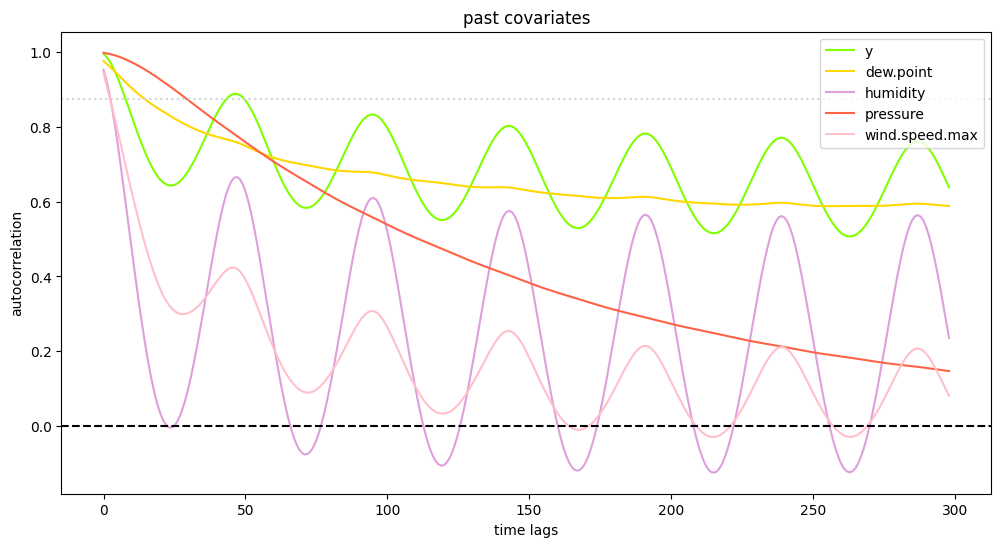

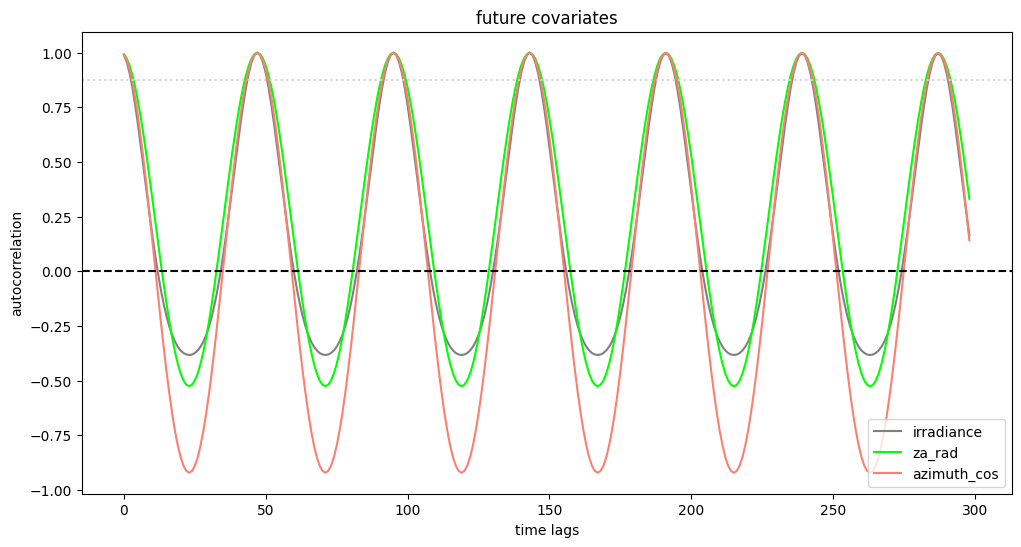

In [13]:
pc_feats = ['y', 'dew.point', 'humidity', 'pressure', 'wind.speed.max']
pc_cols  = ['chartreuse', 'gold', 'plum', 'tomato', 'pink']
plot_short_term_acf(df, pc_feats, pc_cols, 'past covariates')

fc_feats = ['irradiance', 'za_rad', 'azimuth_cos']
fc_cols  = ['grey', 'lime', 'salmon']
plot_short_term_acf(df, fc_feats, fc_cols, 'future covariates')

Autocorrelation of `pressure` and `dew.point` is notably different.

---

Compare base and deseasonalised features


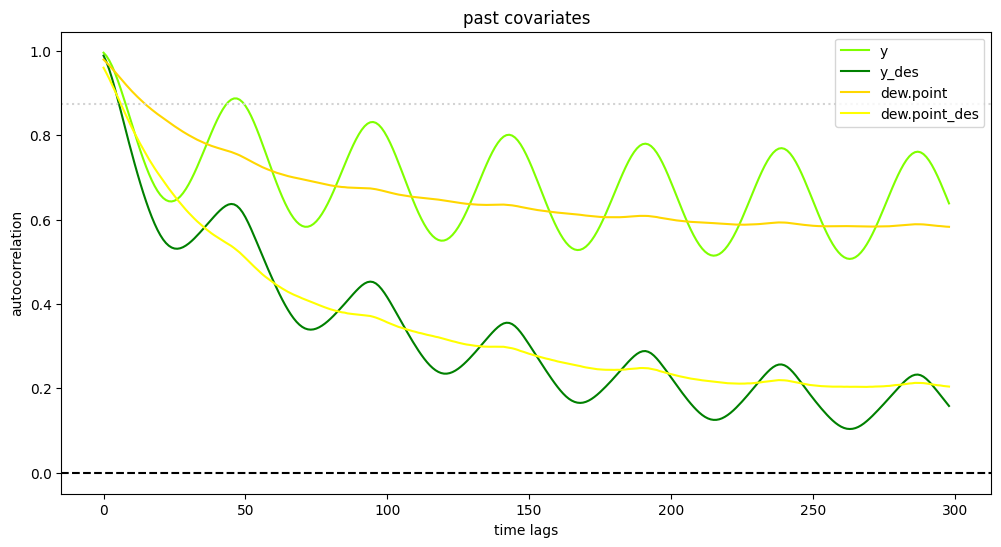

In [14]:
pc_feats = ['y', 'y_des', 'dew.point', 'dew.point_des']
pc_cols  = ['chartreuse', 'green', 'gold', 'yellow']
plot_short_term_acf(train_df, pc_feats, pc_cols, 'past covariates')

...

---

Plot partial autocorrelations

...

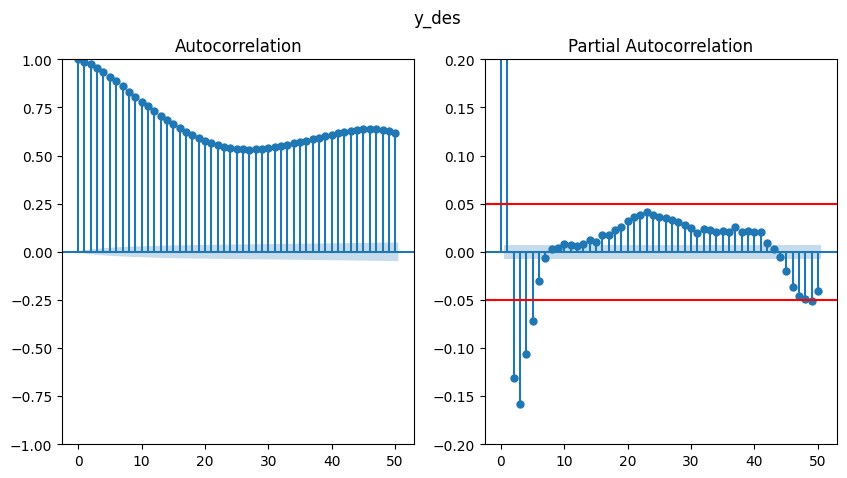

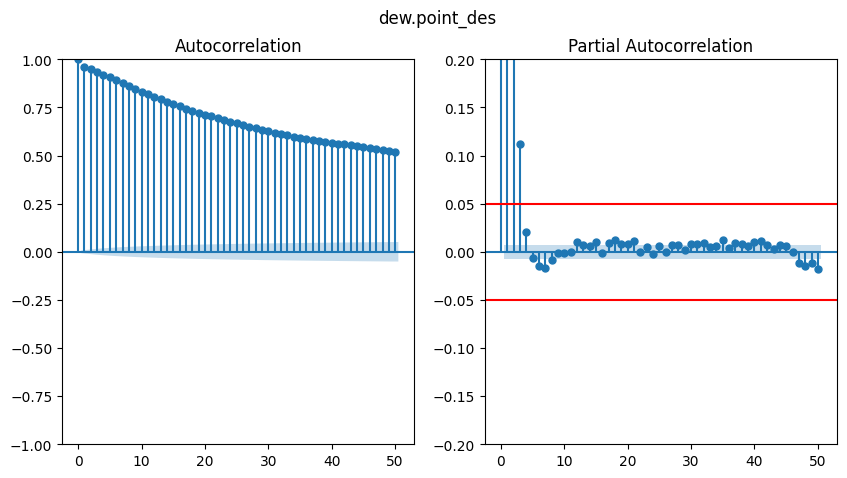

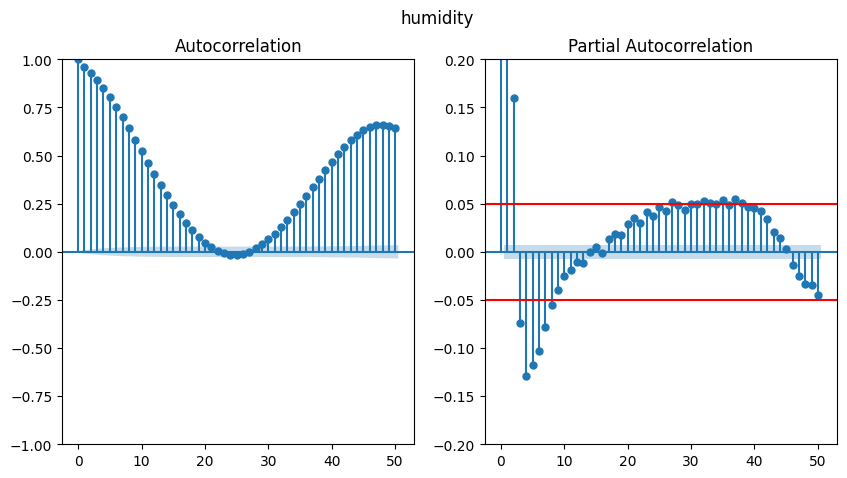

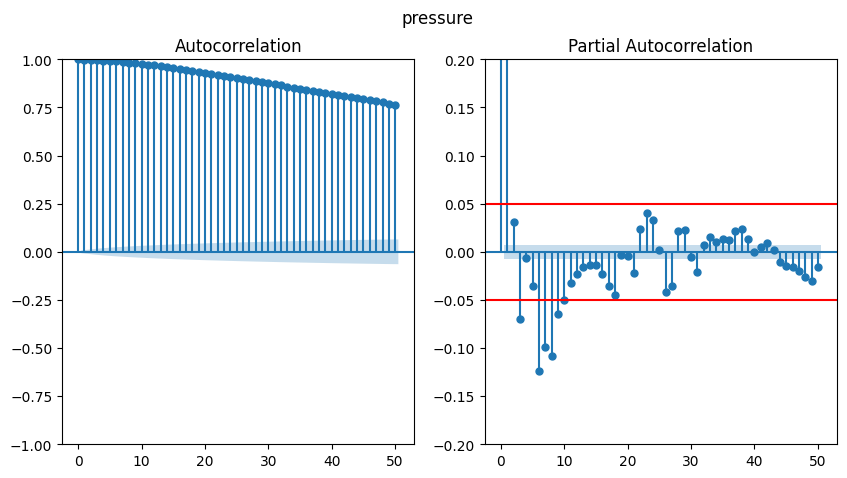

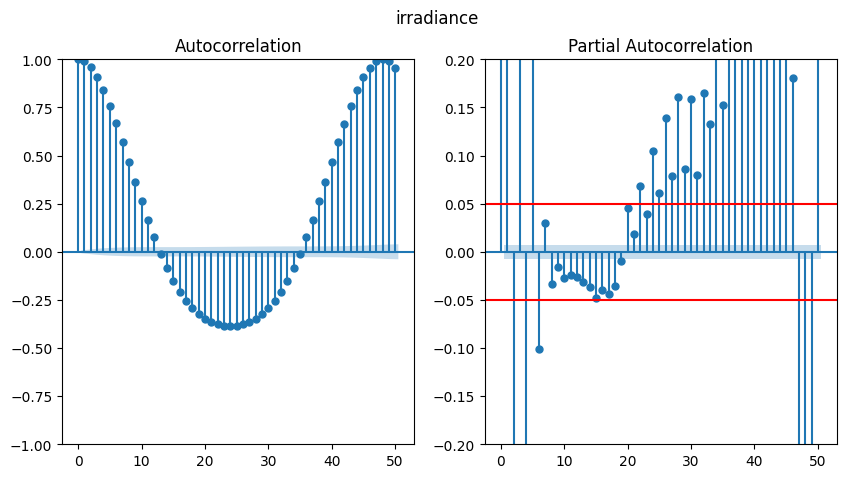

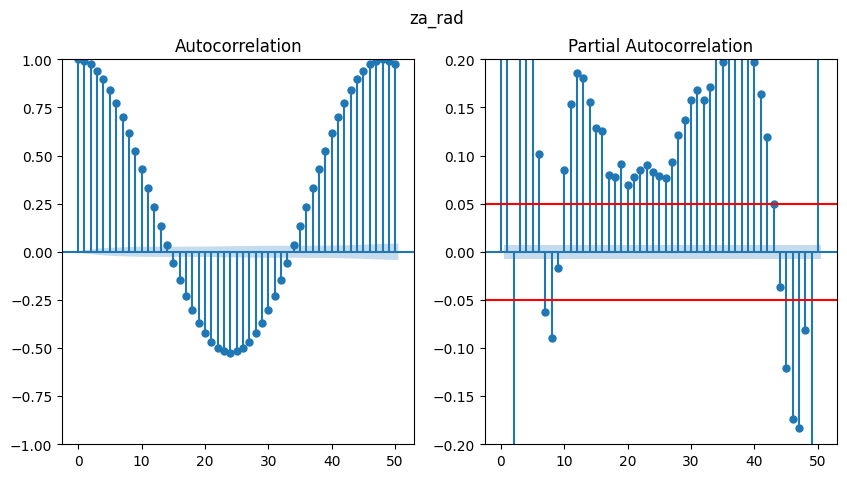

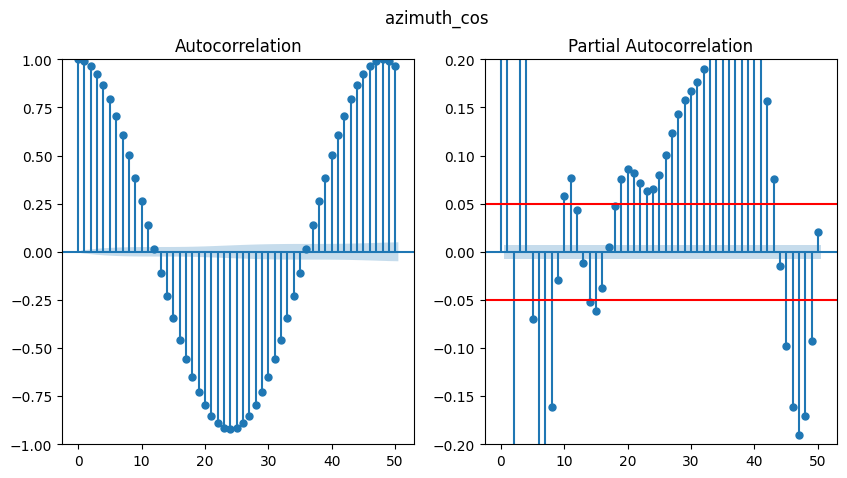

In [15]:
n = int(365.2425 * 48) * 12
max_lag = 50
pc_feats = ['y_des', 'dew.point_des', 'humidity', 'pressure',
            'irradiance', 'za_rad', 'azimuth_cos']
pacf_lim = 0.05
alpha = 0.001

for pc_feat in pc_feats:
  fig, ax = plt.subplots(1, 2, figsize=(10, 5))
  sm.graphics.tsa.plot_acf(train_df[pc_feat].head(n),  alpha=alpha, lags=max_lag, ax=ax[0])
  sm.graphics.tsa.plot_pacf(train_df[pc_feat].head(n), alpha=alpha, lags=max_lag, ax=ax[1])
  plt.axhline(y=pacf_lim,  color='r', linestyle='-')
  plt.axhline(y=-pacf_lim, color='r', linestyle='-')
  ax[1].set_ylim((-0.2, 0.2))
  plt.suptitle(pc_feat)
  plt.show()

...

---

Plot longer term autocorrelations

Compare base and deseasonalised features

...

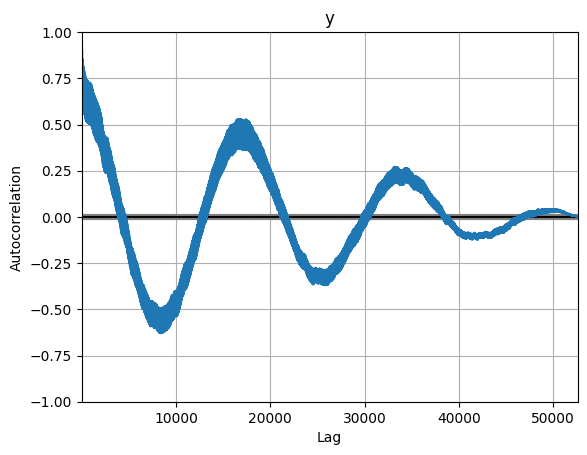

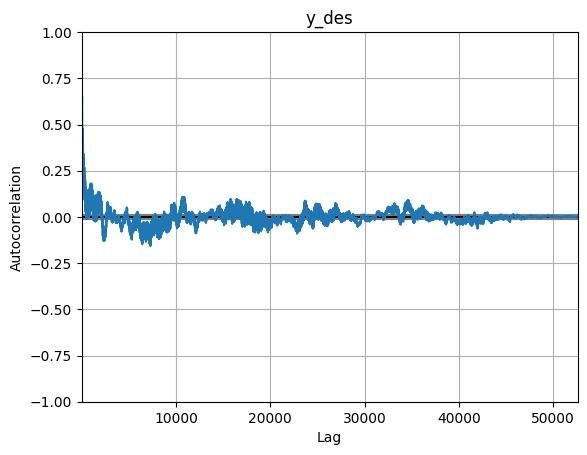

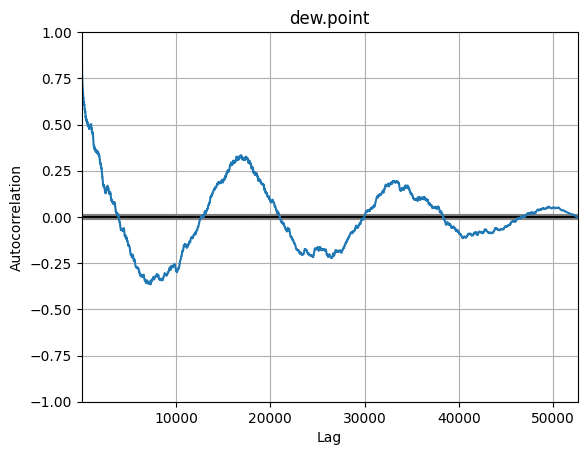

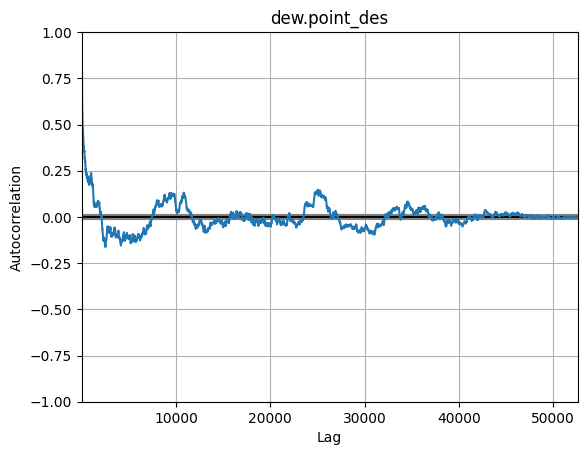

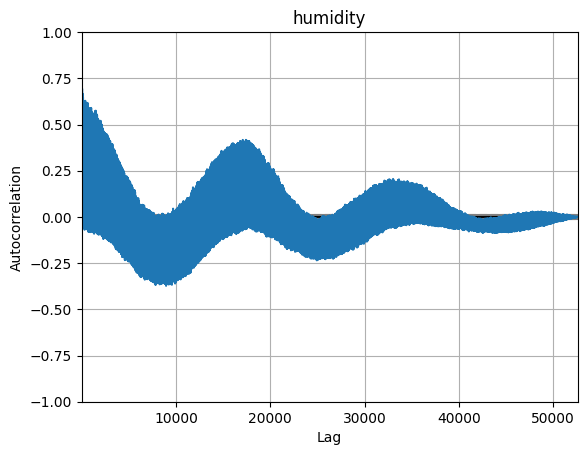

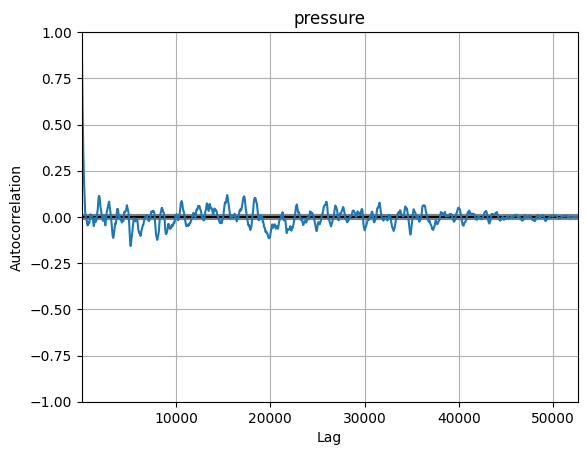

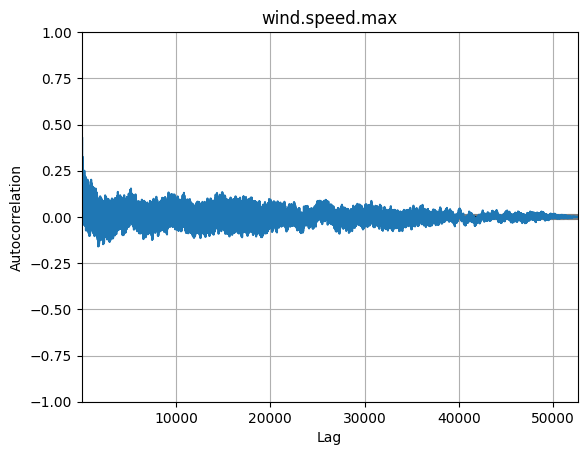

In [16]:
plot_long_term_acf(train_df, 'y')
plot_long_term_acf(train_df, 'y_des')
plot_long_term_acf(train_df, 'dew.point')
plot_long_term_acf(train_df, 'dew.point_des')
plot_long_term_acf(train_df, 'humidity')
plot_long_term_acf(train_df, 'pressure')
plot_long_term_acf(train_df, 'wind.speed.max')

Little obvious long term autocorrelation for `pressure` or `wind.speed.max`.

---

Compare long term autocorrelations for wind speed features.


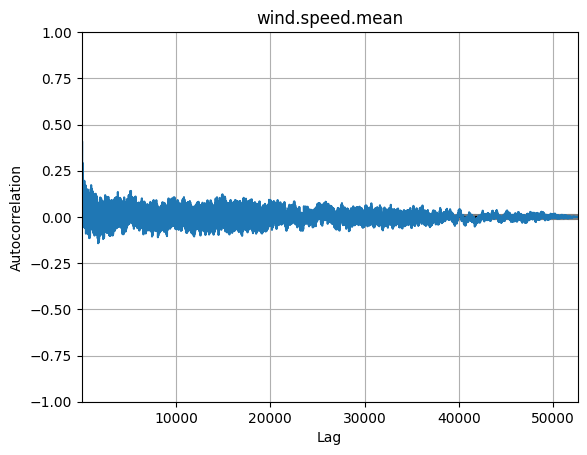

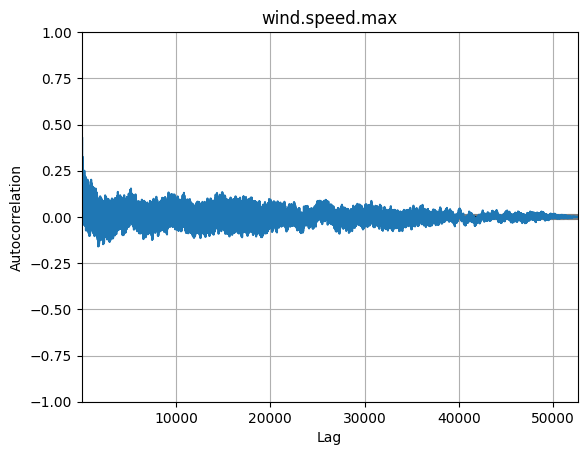

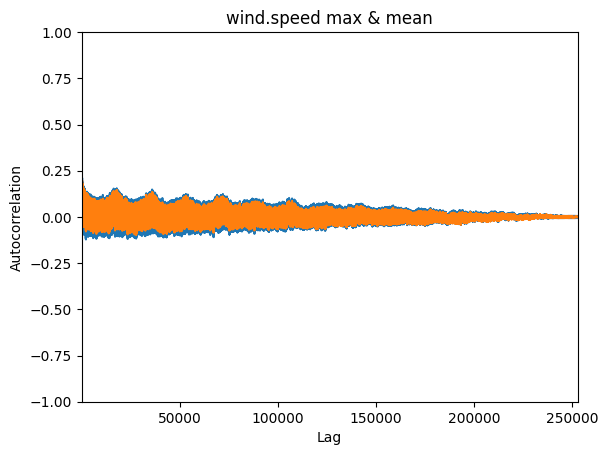

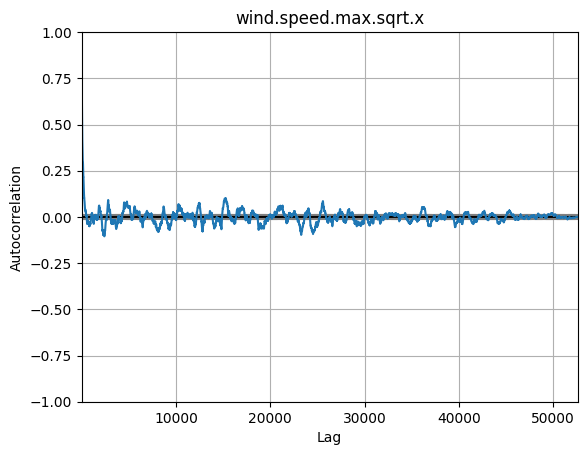

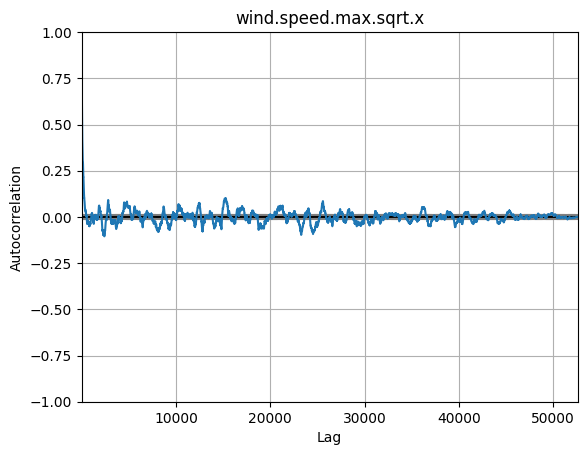

In [17]:
plot_long_term_acf(df, 'wind.speed.mean')
plot_long_term_acf(df, 'wind.speed.max')

# overlay 'wind.speed.main' on 'wind.speed.max'
pd.plotting.autocorrelation_plot(df['wind.speed.max'])
pd.plotting.autocorrelation_plot(df['wind.speed.mean'])
plt.title('wind.speed max & mean')
plt.show()

plot_long_term_acf(df, 'wind.speed.max.sqrt.x')
plot_long_term_acf(df, 'wind.speed.max.sqrt.x')

Little difference between `wind.speed.mean` and `wind.speed.max`.

---

Get feature-specific lags based on pacf

In [18]:
def get_feature_specific_lags(data, feat, threshold = 0.05, nlags = 50):
  pacf_ = pacf(data[feat])
  pacf_ = np.abs(pacf_)

  pacf_indices = np.where(pacf_ >= threshold)[0][1:]

  return pacf_indices


pc_feats = ['y_des', 'dew.point_des', 'humidity', 'pressure',
            'irradiance', 'za_rad', 'azimuth_cos']
thresholds = {'y_des': 0.05, 'dew.point_des': 0.15, 'humidity': 0.15,
              'pressure': 0.15, 'irradiance': 0.2, 'za_rad': 0.2,
              'azimuth_cos': 0.2,}

for pc_feat in pc_feats:
  lags_ = get_feature_specific_lags(train_df, pc_feat, thresholds[pc_feat])
  print(pc_feat, '\t', lags_)

y_des 	 [ 1  2  3  4  5 49]
dew.point_des 	 [1 2]
humidity 	 [1 2]
pressure 	 [1]
irradiance 	 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53]
za_rad 	 [ 1  2  3  4  5 34 36 37 38 39 40 41 42 43 49]
azimuth_cos 	 [ 1  2  3  4  6  7 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53]



yyy

The prophet seasonal decompositions take quite a while to run.
The decompositions for `humidity` and `pressure` are questionable and the `wind.speed.mean` decomposition is unusable.

**TODO** Avoid time spent building prophet models. Save and commit prophet decompositions (`f_all` above).  Then simply download from repo, merge with train, valid, test data and calculate deseasonalised features.

---

#### Plot and check prophet components

The yearly components have `_yearly` appended to feature names.  Similarly, `_daily` is used for daily components and `_des` (for deseasonalised) is used for residuals.

I used flat trends for simplicity and tweaked the transformation, seasonality mode, daily harmonics and yearly harmonics.

The final decomposition parameters:

|  Feature   |       Mode     | Transform | Daily | Yearly |
|------------|----------------|-----------|-------|--------|
| y          | Additive       | None      |   3   |   3    |
| dew.point  | Additive       | None      |   3   |   3    |
| humidity   | Multiplicative | log       |   2   |  Auto  |
| pressure   | Multiplicative | log       |   2   |   2    |

The mode and transforms agree with [work elsewhere](https://www.researchgate.net/figure/Time-series-decomposition-A-Sea-surface-temperature-C-additive-decomposition_fig2_332292752).

I tried log, square root and Box-Cox transformations and tried to keep the daily and yearly harmonics reasonably low.

Using a flat trend may not be appropriate for humidity.

The daily seasonalities for `dew.point` and `pressure` each have two peaks.
There is some [supporting evidence for two daily peaks for atmospheric pressure](https://www.sciencedaily.com/releases/2008/12/081203092437.htm), but I'm not aware of any similar evidence for dew point.

The `humidity` and `pressure` decompositions would benefit from further attention.  The daily and yearly components are hundreths of a percent!

The `wind.speed.mean` decomposition was unacceptible.  I've commented it out for now.
Wind speed may require more sophisticated decomposition techniques like [wavelets](https://en.wikipedia.org/wiki/Wavelet) for example.  Others have successfully used [multiplicative decomposition with smoothed wind speed data](https://files.core.ac.uk/pdf/2612/81865532.pdf).

We now have a richer set of features for lightgbm to choose from.  Also, we can model the deseasonalised temperatures, `y_des`, instead of the more complicated multi-seasonal temperatures `y`.  To make forecasts for `y`, `y_yearly` and `y_daily` must be added to the `y_des` predictions.


---

Finally, plot the historic values for the original and decomposed residual features:

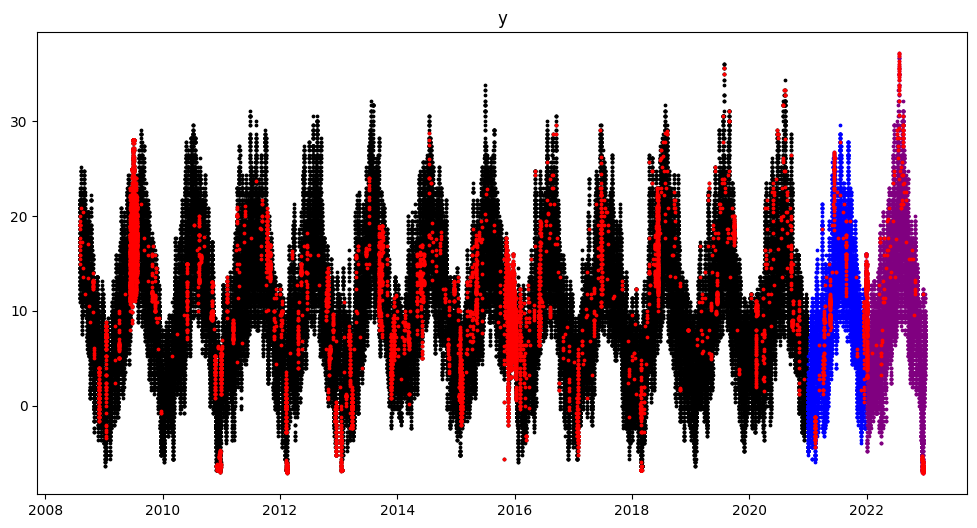

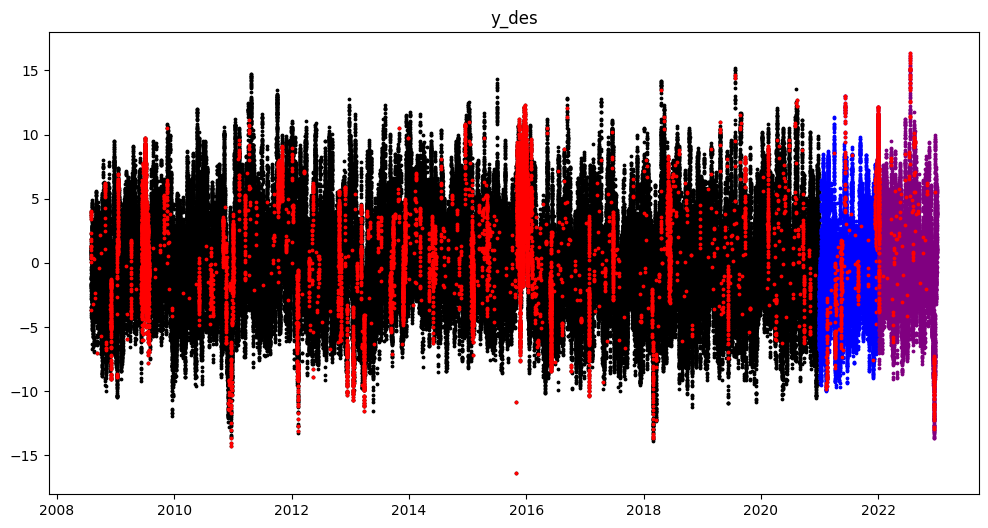

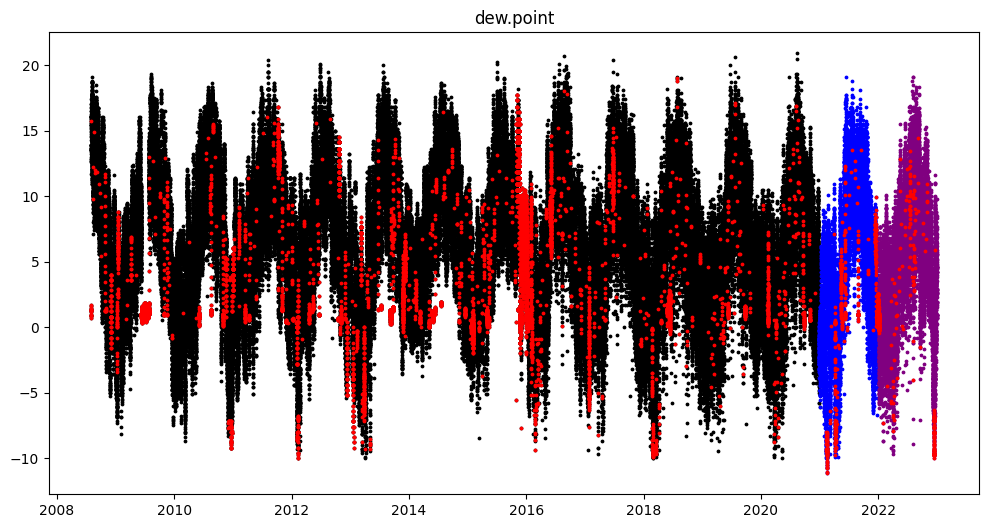

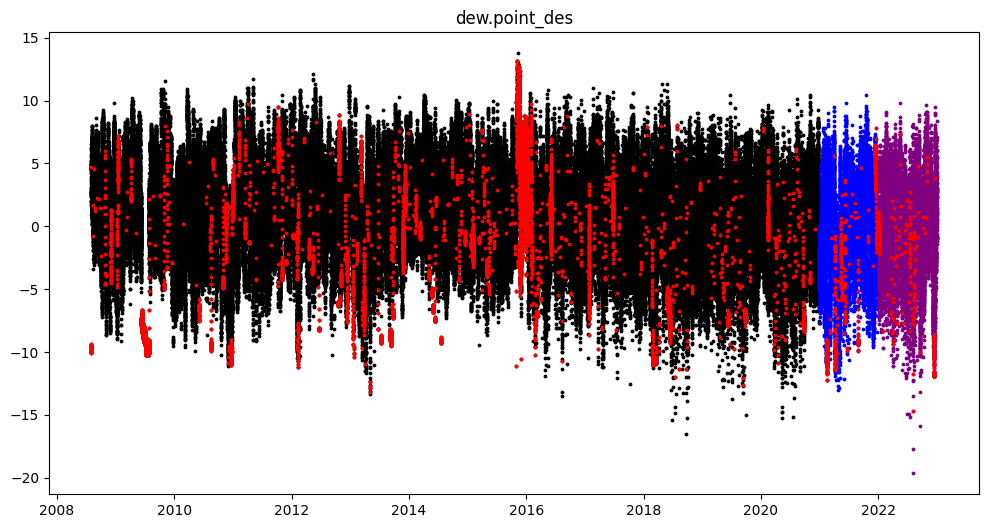

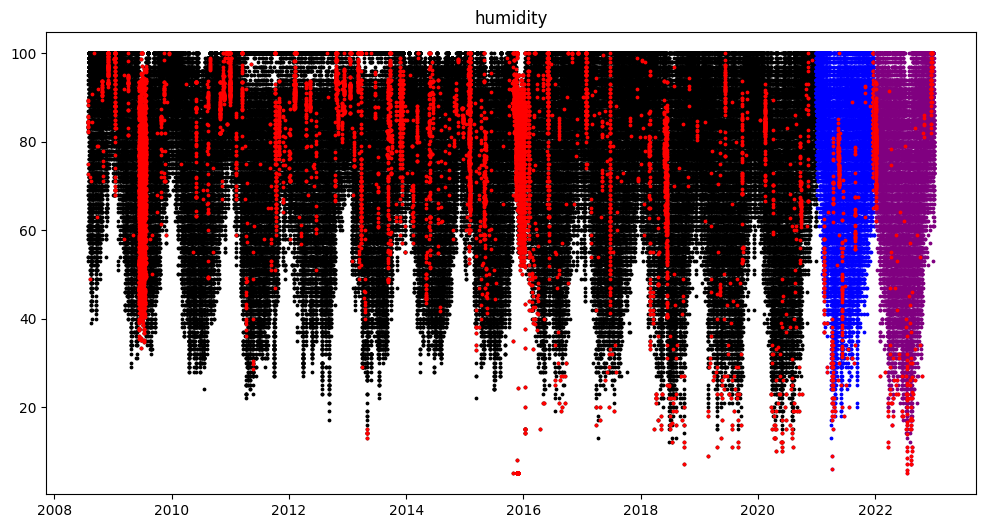

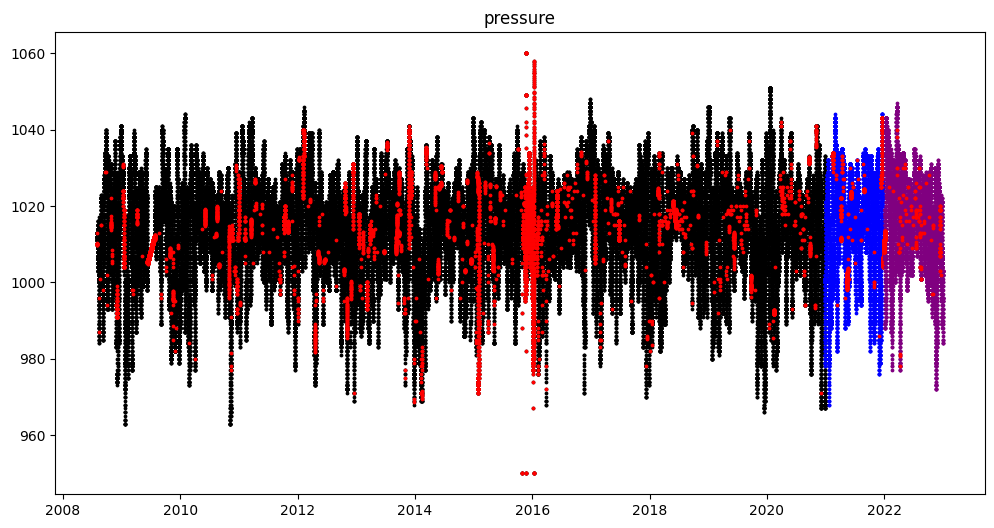

In [19]:
vars = ['y', 'dew.point', 'humidity', 'pressure',
       #'irradiance', 'za_rad', 'azimuth_cos',
       ]

for var in vars:
  var_des = var + '_des'
  if var in ['irradiance', 'za_rad', 'azimuth_cos']:
    plot_feature_history(train_df, valid_df, test_df, var)
  else:
    plot_feature_history(train_df, valid_df, test_df, var, missing=True)

  if var in ['y', 'dew.point']:
    plot_feature_history(train_df, valid_df, test_df, var_des, missing=True)

A visual comparison of the original and residual features indicates:
  * unfortunately `missing` label is not feature specific
  * possible longer than annual signal in `y_des`
  * possible annual signal remaining in `dew.point_des`
  * increasing heteroscadicity in `humidity` and `humidity_des`
  * decreasing trend in `humidity` and `humidity_des`
  * possible annual signal remaining in `humidity_des`
  * `pressure` and `pressure_des` appear similar
  * possible annual signal remaining in `pressure_des`

---

### Stationarity Tests

It is worthwhile looking at the stationarity of these time series after decomposition.

A stationary time series should have mean, variance and autocorrelation that do not change over time.  This means a flat series, without trend, constant variance, constant autocorrelation structure and no periodic fluctuations (seasonalities).

In [25]:
def adf_test(timeseries, NLAGS):
    timeseries = timeseries.dropna()

    if NLAGS is not None:
      dftest = adfuller(timeseries, maxlag = NLAGS)
    else:
      dftest = adfuller(timeseries, autolag="AIC")

    dfoutput = pd.Series(
        dftest[0:4],
        index=["Test Statistic",
               "p-value",
               "#Lags Used",
               "Number of Observations Used",
        ],
    )

    print("Results of Dickey-Fuller Test:")
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value

    print(dfoutput)


def kpss_test(timeseries, NLAGS):
    timeseries = timeseries.dropna()

    if NLAGS is not None:
      kpsstest = kpss(timeseries, regression="c", nlags=NLAGS)
    else:
      kpsstest = kpss(timeseries, regression="c", nlags="auto")

    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )

    print("\nResults of KPSS Test:")
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value

    print(kpss_output)


def stationarity_tests(df, var, NLAGS=None):
    print(var)
    adf_test(df[var], NLAGS)
    kpss_test(df[var], NLAGS)
    print('\n')


for var in ['y', 'dew.point', 'humidity', 'pressure',
            'irradiance', 'za_rad', 'azimuth_cos']:
    stationarity_tests(train_df, var)
    if var in ['y', 'dew.point']:
        stationarity_tests(train_df.loc['2016-01-12':, :], var + '_des')

y
Results of Dickey-Fuller Test:
Test Statistic                -1.221669e+01
p-value                        1.131383e-22
#Lags Used                     8.200000e+01
Number of Observations Used    2.176450e+05
Critical Value (1%)           -3.430380e+00
Critical Value (5%)           -2.861553e+00
Critical Value (10%)          -2.566777e+00
dtype: float64

Results of KPSS Test:
Test Statistic             0.24991
p-value                    0.10000
Lags Used                259.00000
Critical Value (10%)       0.34700
Critical Value (5%)        0.46300
Critical Value (2.5%)      0.57400
Critical Value (1%)        0.73900
dtype: float64


y_des


<ipython-input-25-a27d6bd1e297>:31: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


Results of Dickey-Fuller Test:
Test Statistic                   -20.515403
p-value                            0.000000
#Lags Used                        66.000000
Number of Observations Used    87101.000000
Critical Value (1%)               -3.430425
Critical Value (5%)               -2.861573
Critical Value (10%)              -2.566788
dtype: float64

Results of KPSS Test:
Test Statistic             0.234886
p-value                    0.100000
Lags Used                165.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


dew.point


<ipython-input-25-a27d6bd1e297>:31: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


Results of Dickey-Fuller Test:
Test Statistic                -1.708259e+01
p-value                        7.688411e-30
#Lags Used                     8.200000e+01
Number of Observations Used    2.176450e+05
Critical Value (1%)           -3.430380e+00
Critical Value (5%)           -2.861553e+00
Critical Value (10%)          -2.566777e+00
dtype: float64

Results of KPSS Test:
Test Statistic             0.754355
p-value                    0.010000
Lags Used                265.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


dew.point_des


<ipython-input-25-a27d6bd1e297>:31: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


Results of Dickey-Fuller Test:
Test Statistic                   -21.831844
p-value                            0.000000
#Lags Used                        62.000000
Number of Observations Used    87105.000000
Critical Value (1%)               -3.430425
Critical Value (5%)               -2.861573
Critical Value (10%)              -2.566788
dtype: float64

Results of KPSS Test:
Test Statistic             0.982338
p-value                    0.010000
Lags Used                167.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


humidity


<ipython-input-25-a27d6bd1e297>:31: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


Results of Dickey-Fuller Test:
Test Statistic                    -24.464915
p-value                             0.000000
#Lags Used                         82.000000
Number of Observations Used    217645.000000
Critical Value (1%)                -3.430380
Critical Value (5%)                -2.861553
Critical Value (10%)               -2.566777
dtype: float64

Results of KPSS Test:
Test Statistic             2.81579
p-value                    0.01000
Lags Used                229.00000
Critical Value (10%)       0.34700
Critical Value (5%)        0.46300
Critical Value (2.5%)      0.57400
Critical Value (1%)        0.73900
dtype: float64


pressure


<ipython-input-25-a27d6bd1e297>:31: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


Results of Dickey-Fuller Test:
Test Statistic                    -23.070965
p-value                             0.000000
#Lags Used                         82.000000
Number of Observations Used    217645.000000
Critical Value (1%)                -3.430380
Critical Value (5%)                -2.861553
Critical Value (10%)               -2.566777
dtype: float64

Results of KPSS Test:
Test Statistic             0.359213
p-value                    0.094736
Lags Used                268.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


irradiance
Results of Dickey-Fuller Test:
Test Statistic                     -1.358900
p-value                             0.601814
#Lags Used                         82.000000
Number of Observations Used    217645.000000
Critical Value (1%)                -3.430380
Critical Value (5%)                -2.861553
Critical Value (10%)               

<ipython-input-25-a27d6bd1e297>:31: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


Results of Dickey-Fuller Test:
Test Statistic                -6.456925e+00
p-value                        1.475549e-08
#Lags Used                     8.200000e+01
Number of Observations Used    2.176450e+05
Critical Value (1%)           -3.430380e+00
Critical Value (5%)           -2.861553e+00
Critical Value (10%)          -2.566777e+00
dtype: float64

Results of KPSS Test:
Test Statistic             0.209458
p-value                    0.100000
Lags Used                203.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


azimuth_cos


<ipython-input-25-a27d6bd1e297>:31: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


Results of Dickey-Fuller Test:
Test Statistic                -6.085027e+00
p-value                        1.069501e-07
#Lags Used                     8.200000e+01
Number of Observations Used    2.176450e+05
Critical Value (1%)           -3.430380e+00
Critical Value (5%)           -2.861553e+00
Critical Value (10%)          -2.566777e+00
dtype: float64

Results of KPSS Test:
Test Statistic             0.236941
p-value                    0.100000
Lags Used                155.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64




<ipython-input-25-a27d6bd1e297>:31: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


yyy

The relevant [statsmodels docs](https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html) explain the [ADF](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html) and [KPSS](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.kpss.html) tests plus provide help with interpretation of the p-values.

ADF:
 * <u>Null hypothesis</u>: the dataset is non-stationary and therefore differencing must be carried out.
 * <u>Alternative hypothesis</u>: the dataset has no unit root and is therefore stationary.
 * If the null hypothesis failed to be rejected, this test may provide evidence that the series is non-stationary.

KPSS:
 * <u>Null hypothesis</u>: the series is trend stationary.
 * <u>Alternative hypothesis</u>: the series is not stationary.
 * The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.

A Bonferroni-corrected p-value threshold of 0.005 (0.05 / 10) is used.


|   Feature       | ADF      | KPSS |   Result   |
|-----------------|----------|------|------------|
| y               | 3.35e-23 | 0.1  | Stationary |
| y_des           | 0.0      | 0.01 | Stationary |
| dew.point       | 4.6e-29  | 0.01 | Stationary |
| dew.point_des   | 0.0      | 0.01 | Stationary |
| humidity        | 0.0      | 0.01 | Stationary |
| humidity_des    | 0.0      | 0.01 | Stationary |
| pressure        | 0.0      | 0.01 | Stationary |
| pressure_des    | 0.0      | 0.01 | Stationary |
| irradiance      | 0.0      | 0.01 | Stationary |
| zenith angle    | 0.0      | 0.01 | Stationary |
| azimuth_cos     | ...      | ...  | ...        |

For all features tested, the ADF null hypothesis is rejected and the KPSS null hypothesis is accepted at the Bonferroni-corrected p-value threshold.
All of the features were stationary before and after transformation.

---

#### Save default feature sets

Save default train, valid and test data sets for use in main modeling notebook(s).

In [ ]:


params_def = {'verbose':   True,
              'feat_name': 'default_',
              'date_str':  '.2022.09.20',
              'save_and_download': True,
             }


save_data_and_download_files(train_df, 'train', params_def)
save_data_and_download_files(valid_df, 'valid', params_def)
save_data_and_download_files(test_df,  'test',  params_def)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Files saved in Apache parquet format are below github large file storage limits.

---


### Feature Engineering

Feature engineering, or feature extraction, transforms raw data into features for forecasting.  It includes the following packages and approaches:

 * catch22
 * tsfeatures
 * bivariate
   * numpy
   * scipy
   * statsmodels
   * distances
   * kernels
   * dynamic time warping?


#### catch22

[catch22](https://github.com/DynamicsAndNeuralSystems/catch22) is a collection of 22 time-series features which were selected based on their *classification* performance across a collection of 93 real-world time-series classification problems.

 * [pycatch22](https://github.com/DynamicsAndNeuralSystems/pycatch22)
 * [short feature descriptions](https://github.com/DynamicsAndNeuralSystems/catch22/wiki/Feature-Descriptions)
 * [detailed descriptions with visual depictions of the behavior of features](https://feature-based-time-series-analys.gitbook.io/catch22-features/)

The `get_feature_selection_scores` function calculates [F-statistic tests](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html), [Pearson correlation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.r_regression.html) and [mutual information](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html#sklearn.feature_selection.mutual_info_regression) between the calculated features and the target variable.
These tests assume a linear model.  This is not optimal.
Don't draw any hasty conclusions from these scores.

Lags considered:
 * [6, 12, 24, 48, 96]

Features considered:
 * `y_des`
 * `dew.point_des`
 * `humidity`

`pressure` has some long sequences of single values which produce many NAs. A better deseasonalised `pressure` feature would be worthwhile trying.

catch22 installation is straight-forward:

In [ ]:
!pip install pycatch22

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 1.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycatch22: filename=pycatch22-0.4.4-cp310-cp310-linux_x86_64.whl size=113407 sha256=5343c0d6155f75d12c33772b09ad89b082eb86744fee5024343d81862096e7a6
  Stored in directory: /root/.cache/pip/wheels/10/67/84/cdce1a956aa218fd5ce5b5fa6773219f42780b1fac77889c57
Successfully built pycatch22


In [ ]:


from pycatch22 import catch22_all, DN_HistogramMode_5, DN_HistogramMode_10, \
                      CO_f1ecac, CO_FirstMin_ac, CO_HistogramAMI_even_2_5, \
                      CO_trev_1_num, MD_hrv_classic_pnn40, \
                      SB_BinaryStats_mean_longstretch1, \
                      SB_TransitionMatrix_3ac_sumdiagcov, \
                      PD_PeriodicityWang_th0_01, \
                      CO_Embed2_Dist_tau_d_expfit_meandiff, \
                      IN_AutoMutualInfoStats_40_gaussian_fmmi, \
                      FC_LocalSimple_mean1_tauresrat, \
                      DN_OutlierInclude_p_001_mdrmd, \
                      DN_OutlierInclude_n_001_mdrmd, \
                      SP_Summaries_welch_rect_area_5_1, \
                      SB_BinaryStats_diff_longstretch0, \
                      SB_MotifThree_quantile_hh, \
                      SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1, \
                      SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1, \
                      SP_Summaries_welch_rect_centroid, \
                      FC_LocalSimple_mean3_stderr


def c22_call(ser, func):
  '''The pd.Series.to_list() call is necessary.
     Otherwise rol.apply(how) may work.
     Also, np.ndarray.tolist() is necessary.
     Otherwise c22 returns null exception.
     Or, maybe rol.apply(lambda shenanigans with AGGS array)'''
  # return func(data.loc[ser.index, feat_col].to_list())
  return func(ser.tolist())


def get_rolling_catch22_features(data, feat_cols, windows, AGGS, verbose=False):
  '''Probably can't add norm and scale options due to compute time issues'''

  aggs_l = []

  for feat_col in feat_cols:
    print(feat_col)
    for window in windows:
      print('\t', window)

      if feat_col == 'humidity':
        continue
      elif window == 24 and feat_col == 'pressure':
        continue

      rol = data[feat_col].shift(1).rolling(window=window, min_periods=1,)

      for how in AGGS:
        start_time = timeit.default_timer()
        if verbose:
          print('\t\t', how.__name__, end='')

        c22args = {'func': how}

        agg_ = rol.apply(c22_call, kwargs=c22args, raw=True)
        agg = agg_.copy()
        agg = agg.rename(f'{feat_col}_window_{window}_{how.__name__}')
        aggs_l.append(agg)

        if verbose:
          print('\t', round(timeit.default_timer() - start_time, 2))

  aggs = pd.concat(aggs_l, axis=1)
  aggs = drop_problem_cols(aggs, window)
  aggs = drop_cols_correlated_with_feat_cols(aggs, data[feat_cols])

  return aggs


# feat_cols = [Y_COL]
# windows = [48]
#
# many problems with humidity and train_df - do not use humidity feature
windows = [6, 12, 24, 48, 96]
feat_cols = [Y_COL, 'dew.point_des', 'pressure']
c22_aggs = [DN_HistogramMode_5, DN_HistogramMode_10, CO_f1ecac, \
            CO_FirstMin_ac, CO_HistogramAMI_even_2_5, \
            CO_trev_1_num, MD_hrv_classic_pnn40, \
            SB_BinaryStats_mean_longstretch1, \
            SB_TransitionMatrix_3ac_sumdiagcov, PD_PeriodicityWang_th0_01, \
            CO_Embed2_Dist_tau_d_expfit_meandiff, \
            IN_AutoMutualInfoStats_40_gaussian_fmmi, \
            FC_LocalSimple_mean1_tauresrat, DN_OutlierInclude_p_001_mdrmd, \
            DN_OutlierInclude_n_001_mdrmd, SP_Summaries_welch_rect_area_5_1, \
            SB_BinaryStats_diff_longstretch0, SB_MotifThree_quantile_hh, \
            SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1, \
            SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1, \
            SP_Summaries_welch_rect_centroid, FC_LocalSimple_mean3_stderr]
params_c22 = {'windows':    windows,
              'feat_cols':  feat_cols,
              'aggs':       c22_aggs,
              'agg_func':   get_rolling_catch22_features,
              'verbose':    True,
              'dataset':    'valid',
              'regenerate': True,
              'feat_name':  'catch22_',
              'date_str':   '.2022.09.20',
              'save_and_download': False,
             }

train_df_c22, valid_df_c22, test_df_c22 = get_features(train_df,
                                                       valid_df,
                                                       test_df,
                                                       params_c22)


##############################################################################
# 17m for all 22 catch22 functions on valid_df, test_df & train_df
# 238 features added - approx. 10,000 NAs
#
# windows = [6, 12, 24, 48, 96]
# feat_cols = [Y_COL, 'dew.point_des', 'pressure']
# c22_aggs = [DN_HistogramMode_5, DN_HistogramMode_10, CO_f1ecac, \
#             CO_FirstMin_ac, CO_HistogramAMI_even_2_5, \
#             CO_trev_1_num, MD_hrv_classic_pnn40, \
#             SB_BinaryStats_mean_longstretch1, \
#             SB_TransitionMatrix_3ac_sumdiagcov, PD_PeriodicityWang_th0_01, \
#             CO_Embed2_Dist_tau_d_expfit_meandiff, \
#             IN_AutoMutualInfoStats_40_gaussian_fmmi, \
#             FC_LocalSimple_mean1_tauresrat, DN_OutlierInclude_p_001_mdrmd, \
#             DN_OutlierInclude_n_001_mdrmd, SP_Summaries_welch_rect_area_5_1, \
#             SB_BinaryStats_diff_longstretch0, SB_MotifThree_quantile_hh, \
#             SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1, \
#             SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1, \
#             SP_Summaries_welch_rect_centroid, FC_LocalSimple_mean3_stderr]
# params = {'windows':    windows,
#           'feat_cols':  feat_cols,
#           'aggs':       c22_aggs,
#           'agg_func':   get_rolling_catch22_features,
#           'verbose':    True,
#           'dataset':    'valid',
#           'regenerate': True,
#           'feat_name':  'catch22_',
#           'date_str':   '.2022.09.20', }

dataset: valid
y_des
	 6
		 DN_HistogramMode_5	 0.02
		 DN_HistogramMode_10	 0.02
		 CO_f1ecac	 0.04
		 CO_FirstMin_ac	 0.04
		 CO_HistogramAMI_even_2_5	 0.03
		 CO_trev_1_num	 0.02
		 MD_hrv_classic_pnn40	 0.02
		 SB_BinaryStats_mean_longstretch1	 0.02
		 SB_TransitionMatrix_3ac_sumdiagcov	 0.05
		 PD_PeriodicityWang_th0_01	 0.08
		 CO_Embed2_Dist_tau_d_expfit_meandiff	 0.05
		 IN_AutoMutualInfoStats_40_gaussian_fmmi	 0.02
		 FC_LocalSimple_mean1_tauresrat	 0.07
		 DN_OutlierInclude_p_001_mdrmd	 0.22
		 DN_OutlierInclude_n_001_mdrmd	 0.22
		 SP_Summaries_welch_rect_area_5_1	 0.03
		 SB_BinaryStats_diff_longstretch0	 0.02
		 SB_MotifThree_quantile_hh	 0.05
		 SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1	 0.04
		 SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1	 0.04
		 SP_Summaries_welch_rect_centroid	 0.03
		 FC_LocalSimple_mean3_stderr	 0.02
	 12
		 DN_HistogramMode_5	 0.02
		 DN_HistogramMode_10	 0.02
		 CO_f1ecac	 0.08
		 CO_FirstMin_ac	 0.08
		 CO_HistogramAMI_even_2_5	 0.04
		 CO_trev_1_num

y_des_window_6_DN_HistogramMode_5                                  6
y_des_window_6_DN_HistogramMode_10                                 6
y_des_window_6_CO_f1ecac                                           1
y_des_window_6_CO_FirstMin_ac                                      1
y_des_window_6_CO_HistogramAMI_even_2_5                            6
                                                                  ..
pressure_window_96_SB_BinaryStats_diff_longstretch0               96
pressure_window_96_SB_MotifThree_quantile_hh                      96
pressure_window_96_SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1    96
pressure_window_96_SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1         96
pressure_window_96_FC_LocalSimple_mean3_stderr                    96
Length: 273, dtype: int64

before: (17520, 102)
after:  (17520, 343)


ds          y    humidity  dew.point  \
ds                                                                          
2021-01-01 00:00:00 2021-01-01 00:00:00  -4.800000   98.000000  -5.100000   
2021-01-01 00:30:00 2021-01-01 00:30:00  -4.800000   94.000000  -5.600000   
2021-01-01 01:00:00 2021-01-01 01:00:00  -4.800000  100.000000  -4.800000   
2021-01-01 01:30:00 2021-01-01 01:30:00  -4.800000  100.000000  -4.800000   
2021-01-01 02:00:00 2021-01-01 02:00:00  -4.800000   99.000000  -4.900000   
...                                 ...        ...         ...        ...   
2021-12-31 21:30:00 2021-12-31 21:30:00  12.438743   76.824022   1.414153   
2021-12-31 22:00:00 2021-12-31 22:00:00  12.473437   76.215531   1.363846   
2021-12-31 22:30:00 2021-12-31 22:30:00  12.440330   76.236801   1.361175   
2021-12-31 23:00:00 2021-12-31 23:00:00  12.263176   77.519451   1.132940   
2021-12-31 23:30:00 2021-12-31 23:30:00  12.269498   77.802763   1.113068   

                        pressure  pressure.log  humidity.logit  \
ds                                                               
2021-01-01 00:00:00  1007.000000      6.914731             NaN   
2021-01-01 00:30:00  1008.000000      6.915723             NaN   
2021-01-01 01:00:00  1007.000000      6.914731             NaN   
2021-01-01 01:30:00  1007.000000      6.914731             NaN   
2021-01-01 02:00:00  1008.000000      6.915723             NaN   
...                          ...           ...             ...   
2021-12-31 21:30:00  1010.049436      6.917755             NaN   
2021-12-31 22:00:00  1010.064737      6.917770             NaN   
2021-12-31 22:30:00  1010.082097      6.917787             NaN   
2021-12-31 23:00:00  1010.095954      6.917801             NaN   
2021-12-31 23:30:00  1010.110135      6.917815             NaN   

                     y_window_48_min_max_diff  wind.speed.mean.sqrt  \
ds                                                                    
2021-01-01 00:00:00                  3.200000              0.447214   
2021-01-01 00:30:00                  3.200000              0.316228   
2021-01-01 01:00:00                  3.200000              0.547723   
2021-01-01 01:30:00                  3.200000              0.316228   
2021-01-01 02:00:00                  3.200000              0.000000   
...                                       ...                   ...   
2021-12-31 21:30:00                  2.849791              2.608968   
2021-12-31 22:00:00                  2.849791              2.604531   
2021-12-31 22:30:00                  2.849791              2.600086   
2021-12-31 23:00:00                  2.849791              2.595634   
2021-12-31 23:30:00                  2.849791              2.591173   

                     wind.speed.mean  ...  \
ds                                    ...   
2021-01-01 00:00:00         0.200000  ...   
2021-01-01 00:30:00         0.100000  ...   
2021-01-01 01:00:00         0.300000  ...   
2021-01-01 01:30:00         0.100000  ...   
2021-01-01 02:00:00         0.000000  ...   
...                              ...  ...   
2021-12-31 21:30:00         6.806716  ...   
2021-12-31 22:00:00         6.783582  ...   
2021-12-31 22:30:00         6.760448  ...   
2021-12-31 23:00:00         6.737313  ...   
2021-12-31 23:30:00         6.714179  ...   

                     pressure_window_96_CO_Embed2_Dist_tau_d_expfit_meandiff  \
ds                                                                             
2021-01-01 00:00:00                                                NaN         
2021-01-01 00:30:00                                                NaN         
2021-01-01 01:00:00                                                NaN         
2021-01-01 01:30:00                                                NaN         
2021-01-01 02:00:00                                                NaN         
...                                                                ...         
2021-12-31 21:30:00       

y      humidity     dew.point      pressure  pressure.log  \
count  17520.000000  17520.000000  17520.000000  17520.000000  17520.000000   
mean       9.281890     77.230799      4.846913   1015.876169      6.923438   
std        6.502144     17.352865      5.696639     11.912355      0.011765   
min       -6.000000      6.000000    -11.164754    968.000000      6.875232   
25%        4.400000     67.000000      0.500000   1008.000000      6.915723   
50%        9.200000     81.000000      5.042608   1017.000000      6.924612   
75%       13.600000     90.000000      9.600000   1024.000000      6.931472   
max       29.600000    100.000000     19.100000   1044.000000      6.950815   

       humidity.logit  y_window_48_min_max_diff  wind.speed.mean.sqrt  \
count             0.0              17520.000000          17520.000000   
mean              NaN                  7.869684              1.504128   
std               NaN                  3.542626              1.069925   
min               NaN                  0.514401              0.000000   
25%               NaN                  5.200000              0.547723   
50%               NaN                  7.600000              1.516575   
75%               NaN                 10.400000              2.323790   
max               NaN                 18.500000              4.857983   

       wind.speed.mean  wind.bearing.mean  ...  \
count     17520.000000       17520.000000  ...   
mean          3.407074         188.993795  ...   
std           3.632411          92.104902  ...   
min           0.000000           0.000000  ...   
25%           0.300000         135.000000  ...   
50%           2.300000         225.000000  ...   
75%           5.400000         270.000000  ...   
max          23.600000         360.000000  ...   

       pressure_window_96_CO_Embed2_Dist_tau_d_expfit_meandiff  \
count                                       17424.000000         
mean                                            1.902405         
std                                             1.280721         
min                                             0.169735         
25%                                             0.928739         
50%                                             1.638105         
75%                                             2.581534         
max                                             7.561041         

       pressure_window_96_IN_AutoMutualInfoStats_40_gaussian_fmmi  \
count                                       17424.000000            
mean                                           21.261938            
std                                            10.564567            
min                                             1.000000            
25%                                            13.000000            
50%                                            19.000000            
75%                                            29.000000            
max                                            40.000000            

       pressure_window_96_FC_LocalSimple_mean1_tauresrat  \
count                                       17424.000000   
mean                                            0.122527   
std                                             0.241659   
min                                             0.021739   
25%                                             0.029412   
50%                                             0.033333   
75%                                             0.047619   
max                                             1.761905   

       pressure_window_96_DN_OutlierInclude_p_001_mdrmd  \
count                                      17424.000000   
mean                                           0.027798   
std                                            0.631038   
min                                           -0.968750   
25%                                           -0.625000   
50%                                            0.046875   
75%                       

dataset: test
y_des
	 6
		 DN_HistogramMode_5	 0.02
		 DN_HistogramMode_10	 0.02
		 CO_f1ecac	 0.04
		 CO_FirstMin_ac	 0.04
		 CO_HistogramAMI_even_2_5	 0.03
		 CO_trev_1_num	 0.02
		 MD_hrv_classic_pnn40	 0.02
		 SB_BinaryStats_mean_longstretch1	 0.02
		 SB_TransitionMatrix_3ac_sumdiagcov	 0.05
		 PD_PeriodicityWang_th0_01	 0.07
		 CO_Embed2_Dist_tau_d_expfit_meandiff	 0.05
		 IN_AutoMutualInfoStats_40_gaussian_fmmi	 0.02
		 FC_LocalSimple_mean1_tauresrat	 0.07
		 DN_OutlierInclude_p_001_mdrmd	 0.23
		 DN_OutlierInclude_n_001_mdrmd	 0.22
		 SP_Summaries_welch_rect_area_5_1	 0.03
		 SB_BinaryStats_diff_longstretch0	 0.02
		 SB_MotifThree_quantile_hh	 0.05
		 SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1	 0.04
		 SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1	 0.04
		 SP_Summaries_welch_rect_centroid	 0.03
		 FC_LocalSimple_mean3_stderr	 0.02
	 12
		 DN_HistogramMode_5	 0.02
		 DN_HistogramMode_10	 0.02
		 CO_f1ecac	 0.07
		 CO_FirstMin_ac	 0.08
		 CO_HistogramAMI_even_2_5	 0.04
		 CO_trev_1_num	

y_des_window_6_DN_HistogramMode_5                                  6
y_des_window_6_DN_HistogramMode_10                                 6
y_des_window_6_CO_f1ecac                                           1
y_des_window_6_CO_FirstMin_ac                                      1
y_des_window_6_CO_HistogramAMI_even_2_5                            6
                                                                  ..
pressure_window_96_SB_BinaryStats_diff_longstretch0               96
pressure_window_96_SB_MotifThree_quantile_hh                      96
pressure_window_96_SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1    96
pressure_window_96_SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1         96
pressure_window_96_FC_LocalSimple_mean3_stderr                    96
Length: 269, dtype: int64

before: (17520, 102)
after:  (17520, 340)


ds          y   humidity  dew.point  \
ds                                                                         
2022-01-01 00:00:00 2022-01-01 00:00:00  12.264746  77.723545   1.101641   
2022-01-01 00:30:00 2022-01-01 00:30:00  12.243743  77.701246   1.087427   
2022-01-01 01:00:00 2022-01-01 01:00:00  12.179704  77.643168   0.997640   
2022-01-01 01:30:00 2022-01-01 01:30:00  12.183168  77.707848   0.985036   
2022-01-01 02:00:00 2022-01-01 02:00:00  12.486018  78.047152   0.994765   
...                                 ...        ...        ...        ...   
2022-12-31 21:30:00 2022-12-31 21:30:00   9.600000  80.000000   6.300000   
2022-12-31 22:00:00 2022-12-31 22:00:00  10.000000  88.000000   8.100000   
2022-12-31 22:30:00 2022-12-31 22:30:00  10.000000  80.000000   6.700000   
2022-12-31 23:00:00 2022-12-31 23:00:00   9.600000  79.000000   6.100000   
2022-12-31 23:30:00 2022-12-31 23:30:00   9.200000  82.000000   6.300000   

                        pressure  pressure.log  humidity.logit  \
ds                                                               
2022-01-01 00:00:00  1010.123241      6.917828             NaN   
2022-01-01 00:30:00  1010.134727      6.917839             NaN   
2022-01-01 01:00:00  1010.139485      6.917844             NaN   
2022-01-01 01:30:00  1010.145117      6.917849             NaN   
2022-01-01 02:00:00  1010.154533      6.917859             NaN   
...                          ...           ...             ...   
2022-12-31 21:30:00   998.000000      6.905753             NaN   
2022-12-31 22:00:00   998.000000      6.905753             NaN   
2022-12-31 22:30:00   999.000000      6.906755             NaN   
2022-12-31 23:00:00  1000.000000      6.907755             NaN   
2022-12-31 23:30:00  1000.000000      6.907755             NaN   

                     y_window_48_min_max_diff  wind.speed.mean.sqrt  \
ds                                                                    
2022-01-01 00:00:00                  2.849791              2.586705   
2022-01-01 00:30:00                  2.849791              2.582230   
2022-01-01 01:00:00                  2.849791              2.577746   
2022-01-01 01:30:00                  2.849791              2.573255   
2022-01-01 02:00:00                  2.849791              2.568756   
...                                       ...                   ...   
2022-12-31 21:30:00                  4.600000              3.255764   
2022-12-31 22:00:00                  4.600000              2.792848   
2022-12-31 22:30:00                  4.600000              2.792848   
2022-12-31 23:00:00                  4.600000              3.301515   
2022-12-31 23:30:00                  4.600000              2.738613   

                     wind.speed.mean  ...  \
ds                                    ...   
2022-01-01 00:00:00         6.691045  ...   
2022-01-01 00:30:00         6.667910  ...   
2022-01-01 01:00:00         6.644776  ...   
2022-01-01 01:30:00         6.621642  ...   
2022-01-01 02:00:00         6.598507  ...   
...                              ...  ...   
2022-12-31 21:30:00        10.600000  ...   
2022-12-31 22:00:00         7.800000  ...   
2022-12-31 22:30:00         7.800000  ...   
2022-12-31 23:00:00        10.900000  ...   
2022-12-31 23:30:00         7.500000  ...   

                     pressure_window_96_CO_Embed2_Dist_tau_d_expfit_meandiff  \
ds                                                                             
2022-01-01 00:00:00                                                NaN         
2022-01-01 00:30:00                                                NaN         
2022-01-01 01:00:00                                                NaN         
2022-01-01 01:30:00                                                NaN         
2022-01-01 02:00:00                                                NaN         
...                                                                ...         
2022-12-31 21:30:00                    

y      humidity     dew.point      pressure  pressure.log  \
count  17520.000000  17520.000000  17520.000000  17520.000000  17520.000000   
mean      10.353362     73.017219      4.954191   1016.348593      6.923912   
std        6.910328     19.511345      4.929823     11.078868      0.010928   
min       -7.144690      5.000000    -10.000000    972.000000      6.879356   
25%        5.600000     60.000000      1.600000   1009.000000      6.916715   
50%       10.000000     77.000000      5.100000   1017.000000      6.924612   
75%       15.000000     88.000000      8.600000   1024.000000      6.931472   
max       37.200000    100.000000     19.100000   1047.000000      6.953684   

       humidity.logit  y_window_48_min_max_diff  wind.speed.mean.sqrt  \
count             0.0              17520.000000          17520.000000   
mean              NaN                  9.069137              1.465774   
std               NaN                  3.750991              1.090404   
min               NaN                  0.800000              0.000000   
25%               NaN                  6.400000              0.447214   
50%               NaN                  8.800000              1.449138   
75%               NaN                 11.600000              2.323790   
max               NaN                 21.100000              5.630275   

       wind.speed.mean  wind.bearing.mean  ...  \
count     17520.000000       17520.000000  ...   
mean          3.337407         192.530252  ...   
std           3.661180          83.349452  ...   
min           0.000000           0.000000  ...   
25%           0.200000         135.000000  ...   
50%           2.100000         224.888060  ...   
75%           5.400000         270.000000  ...   
max          31.700000         350.000000  ...   

       pressure_window_96_CO_Embed2_Dist_tau_d_expfit_meandiff  \
count                                       17424.000000         
mean                                            1.922879         
std                                             1.198135         
min                                             0.201131         
25%                                             0.935196         
50%                                             1.727743         
75%                                             2.613274         
max                                             7.028398         

       pressure_window_96_IN_AutoMutualInfoStats_40_gaussian_fmmi  \
count                                       17424.000000            
mean                                           22.360652            
std                                            10.144594            
min                                             1.000000            
25%                                            14.000000            
50%                                            20.000000            
75%                                            30.000000            
max                                            40.000000            

       pressure_window_96_FC_LocalSimple_mean1_tauresrat  \
count                                       17424.000000   
mean                                            0.122717   
std                                             0.247356   
min                                             0.021739   
25%                                             0.030303   
50%                                             0.034483   
75%                                             0.047619   
max                                             1.687500   

       pressure_window_96_DN_OutlierInclude_p_001_mdrmd  \
count                                      17424.000000   
mean                                           0.013376   
std                                            0.627697   
min                                           -0.968750   
25%                                           -0.635417   
50%                                            0.020833   
75%                       

dataset: train
y_des
	 6
		 DN_HistogramMode_5	 0.21
		 DN_HistogramMode_10	 0.24
		 CO_f1ecac	 0.51
		 CO_FirstMin_ac	 0.52
		 CO_HistogramAMI_even_2_5	 0.35
		 CO_trev_1_num	 0.23
		 MD_hrv_classic_pnn40	 0.2
		 SB_BinaryStats_mean_longstretch1	 0.2
		 SB_TransitionMatrix_3ac_sumdiagcov	 0.66
		 PD_PeriodicityWang_th0_01	 0.96
		 CO_Embed2_Dist_tau_d_expfit_meandiff	 0.57
		 IN_AutoMutualInfoStats_40_gaussian_fmmi	 0.23
		 FC_LocalSimple_mean1_tauresrat	 0.85
		 DN_OutlierInclude_p_001_mdrmd	 2.76
		 DN_OutlierInclude_n_001_mdrmd	 2.73
		 SP_Summaries_welch_rect_area_5_1	 0.38
		 SB_BinaryStats_diff_longstretch0	 0.2
		 SB_MotifThree_quantile_hh	 0.59
		 SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1	 0.48
		 SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1	 0.49
		 SP_Summaries_welch_rect_centroid	 0.39
		 FC_LocalSimple_mean3_stderr	 0.2
	 12
		 DN_HistogramMode_5	 0.25
		 DN_HistogramMode_10	 0.27
		 CO_f1ecac	 0.91
		 CO_FirstMin_ac	 0.93
		 CO_HistogramAMI_even_2_5	 0.46
		 CO_trev_1_num	 0.

y_des_window_6_DN_HistogramMode_5                                  6
y_des_window_6_DN_HistogramMode_10                                 6
y_des_window_6_CO_f1ecac                                           1
y_des_window_6_CO_FirstMin_ac                                      1
y_des_window_6_CO_HistogramAMI_even_2_5                            6
                                                                  ..
pressure_window_96_SB_BinaryStats_diff_longstretch0               96
pressure_window_96_SB_MotifThree_quantile_hh                      96
pressure_window_96_SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1    96
pressure_window_96_SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1         96
pressure_window_96_FC_LocalSimple_mean3_stderr                    96
Length: 275, dtype: int64

before: (217728, 102)
after:  (217728, 345)


ds     y    humidity  dew.point  \
ds                                                                     
2008-08-01 00:00:00 2008-08-01 00:00:00  20.0   89.221997   1.610001   
2008-08-01 00:30:00 2008-08-01 00:30:00  19.5   88.290807   1.657847   
2008-08-01 01:00:00 2008-08-01 01:00:00  19.1   85.755790   1.432873   
2008-08-01 01:30:00 2008-08-01 01:30:00  19.1   85.572379   1.397409   
2008-08-01 02:00:00 2008-08-01 02:00:00  19.1   84.345642   1.278219   
...                                 ...   ...         ...        ...   
2020-12-31 21:30:00 2020-12-31 21:30:00  -2.8   96.000000  -3.300000   
2020-12-31 22:00:00 2020-12-31 22:00:00  -3.2  100.000000  -3.200000   
2020-12-31 22:30:00 2020-12-31 22:30:00  -3.6  100.000000  -3.600000   
2020-12-31 23:00:00 2020-12-31 23:00:00  -4.4   97.000000  -4.800000   
2020-12-31 23:30:00 2020-12-31 23:30:00  -4.8   99.000000  -4.900000   

                        pressure  pressure.log  humidity.logit  \
ds                                                               
2008-08-01 00:00:00  1009.926805      6.917633             NaN   
2008-08-01 00:30:00  1009.931495      6.917638             NaN   
2008-08-01 01:00:00  1010.092861      6.917798             NaN   
2008-08-01 01:30:00  1009.902342      6.917609             NaN   
2008-08-01 02:00:00  1010.133476      6.917838             NaN   
...                          ...           ...             ...   
2020-12-31 21:30:00  1006.000000      6.913737             NaN   
2020-12-31 22:00:00  1007.000000      6.914731             NaN   
2020-12-31 22:30:00  1007.000000      6.914731             NaN   
2020-12-31 23:00:00  1007.000000      6.914731             NaN   
2020-12-31 23:30:00  1007.000000      6.914731             NaN   

                     y_window_48_min_max_diff  wind.speed.mean.sqrt  \
ds                                                                    
2008-08-01 00:00:00                       0.4              1.897367   
2008-08-01 00:30:00                       0.9              1.897367   
2008-08-01 01:00:00                       1.3              1.897367   
2008-08-01 01:30:00                       1.3              1.897367   
2008-08-01 02:00:00                       1.3              1.897367   
...                                       ...                   ...   
2020-12-31 21:30:00                       3.2              0.000000   
2020-12-31 22:00:00                       3.2              0.000000   
2020-12-31 22:30:00                       3.2              0.000000   
2020-12-31 23:00:00                       3.2              0.000000   
2020-12-31 23:30:00                       3.2              0.632456   

                     wind.speed.mean  ...  \
ds                                    ...   
2008-08-01 00:00:00              3.6  ...   
2008-08-01 00:30:00              3.6  ...   
2008-08-01 01:00:00              3.6  ...   
2008-08-01 01:30:00              3.6  ...   
2008-08-01 02:00:00              3.6  ...   
...                              ...  ...   
2020-12-31 21:30:00              0.0  ...   
2020-12-31 22:00:00              0.0  ...   
2020-12-31 22:30:00              0.0  ...   
2020-12-31 23:00:00              0.0  ...   
2020-12-31 23:30:00              0.4  ...   

                     pressure_window_96_CO_Embed2_Dist_tau_d_expfit_meandiff  \
ds                                                                             
2008-08-01 00:00:00                                                NaN         
2008-08-01 00:30:00                                                NaN         
2008-08-01 01:00:00                                                NaN         
2008-08-01 01:30:00                                                NaN         
2008-08-01 02:00:00                                                NaN         
...                                                                ...         
2020-12-31 21:30:00                                           1.467958         
2020-12-31 

y       humidity      dew.point       pressure  \
count  217728.000000  217728.000000  217728.000000  217728.000000   
mean       10.156650      78.661830       5.994144    1014.171124   
std         6.480187      17.333778       5.109794      11.959898   
min        -7.073291       5.000000     -10.000000     950.000000   
25%         5.200000      68.000000       2.100000    1007.000000   
50%         9.600000      83.000000       6.100000    1015.000000   
75%        14.500000      92.000000       9.800000    1022.000000   
max        36.100000     100.000000      20.900000    1060.000000   

        pressure.log  humidity.logit  y_window_48_min_max_diff  \
count  217728.000000             0.0             217728.000000   
mean        6.921757             NaN                  8.267761   
std         0.011831             NaN                  3.628386   
min         6.856462             NaN                  0.156703   
25%         6.914731             NaN                  5.600000   
50%         6.922644             NaN                  7.958414   
75%         6.929517             NaN                 10.700000   
max         6.966024             NaN                 35.006311   

       wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  ...  \
count         217728.000000    217728.000000      217728.000000  ...   
mean               1.844258         4.456375         195.205732  ...   
std                1.027176         4.017316          83.012687  ...   
min                0.000000         0.000000           0.000000  ...   
25%                1.095445         1.200000         135.000000  ...   
50%                1.870829         3.500000         225.000000  ...   
75%                2.569047         6.600000         270.000000  ...   
max                5.403702        29.200000         360.000000  ...   

       pressure_window_96_CO_Embed2_Dist_tau_d_expfit_meandiff  \
count                                      217632.000000         
mean                                            1.973568         
std                                             1.239775         
min                                             0.002606         
25%                                             1.014493         
50%                                             1.727780         
75%                                             2.679687         
max                                             9.162058         

       pressure_window_96_IN_AutoMutualInfoStats_40_gaussian_fmmi  \
count                                      217632.000000            
mean                                           22.654614            
std                                            10.212451            
min                                             1.000000            
25%                                            15.000000            
50%                                            20.000000            
75%                                            30.000000            
max                                            40.000000            

       pressure_window_96_FC_LocalSimple_mean1_tauresrat  \
count                                      217632.000000   
mean                                            0.133175   
std                                             0.253351   
min                                             0.020408   
25%                                             0.030303   
50%                                             0.035714   
75%                                             0.050000   
max                                             1.750000   

       pressure_window_96_DN_OutlierInclude_p_001_mdrmd  \
count                                     217632.000000   
mean                                           0.006363   
std                                            0.622331   
min                                           -0.968750   
25%                                           -0.625000   
50%                                      

r_test    f_test  \
dew.point_des                                       0.281449  0.192490   
y_des_window_24_DN_OutlierInclude_p_001_mdrmd       0.148701  0.034374   
y_des_window_96_DN_OutlierInclude_p_001_mdrmd       0.143549  0.031732   
y_des_window_24_DN_OutlierInclude_n_001_mdrmd      -0.141313  0.030629   
y_des_window_96_CO_Embed2_Dist_tau_d_expfit_mea...  0.139958  0.029973   
y_des_window_96_DN_OutlierInclude_n_001_mdrmd      -0.132667  0.026604   
y_des_window_12_DN_OutlierInclude_p_001_mdrmd       0.131099  0.025913   
y_des_window_12_DN_OutlierInclude_n_001_mdrmd      -0.128658  0.024860   
y_des_window_48_CO_Embed2_Dist_tau_d_expfit_mea...  0.118676  0.020839   
dew.point_des_window_96_DN_OutlierInclude_n_001... -0.112360  0.018517   
y_des_window_96_MD_hrv_classic_pnn40               -0.110879  0.017997   
y_des_window_96_CO_HistogramAMI_even_2_5            0.110769  0.017959   
y_des_window_96_FC_LocalSimple_mean3_stderr        -0.107728  0.016919   
dew.point_des_window_96_DN_OutlierInclude_p_001...  0.107561  0.016863   
humidity                                           -0.106040  0.016358   
y_des_window_48_DN_OutlierInclude_p_001_mdrmd       0.105944  0.016327   
y_des_window_96_SB_MotifThree_quantile_hh          -0.105868  0.016302   
y_des_window_48_DN_OutlierInclude_n_001_mdrmd      -0.100280  0.014527   
y_des_window_12_SB_BinaryStats_diff_longstretch0   -0.098972  0.014129   
y_des_window_48_FC_LocalSimple_mean3_stderr        -0.098811  0.014081   
y_des_window_48_SB_MotifThree_quantile_hh          -0.098767  0.014068   
y_des_window_24_SB_BinaryStats_diff_longstretch0   -0.095812  0.013194   
y_des_window_6_DN_OutlierInclude_n_001_mdrmd       -0.095790  0.013188   
y_des_window_48_CO_HistogramAMI_even_2_5            0.095429  0.013083   
y_des_window_96_FC_LocalSimple_mean1_tauresrat      0.094629  0.012853   
y_des_window_6_DN_OutlierInclude_p_001_mdrmd        0.093870  0.012637   
y_des_window_48_FC_LocalSimple_mean1_tauresrat      0.088916  0.011279   
dew.point_des_window_48_DN_OutlierInclude_n_001... -0.084870  0.010235   
y_des_window_48_SP_Summaries_welch_rect_area_5_1    0.084838  0.010227   
dew.point_des_window_96_SP_Summaries_welch_rect...  0.081242  0.009346   
y_des_window_24_CO_Embed2_Dist_tau_d_expfit_mea...  0.080013  0.009055   
y_des_window_48_CO_FirstMin_ac                      0.080008  0.009054   
y_des_window_48_MD_hrv_classic_pnn40               -0.078885  0.008792   
dew.point_des_window_48_DN_OutlierInclude_p_001...  0.078741  0.008759   
y_des_window_48_CO_f1ecac                           0.077955  0.008579   
y_des_window_6_SB_BinaryStats_diff_longstretch0    -0.076202  0.008185   
pressure_window_48_DN_OutlierInclude_n_001_mdrmd    0.067665  0.006409   
y_des_window_24_FC_LocalSimple_mean3_stderr        -0.067646  0.006405   
y_des_window_96_CO_trev_1_num                       0.065852  0.006061   
pressure_window_48_DN_OutlierInclude_p_001_mdrmd   -0.063829  0.005686   

                                                          mi  
dew.point_des                                       0.034107  
y_des_window_24_DN_OutlierInclude_p_001_mdrmd       0.008907  
y_des_window_96_DN_OutlierInclude_p_001_mdrmd       0.011456  
y_des_window_24_DN_OutlierInclude_n_001_mdrmd       0.007276  
y_des_window_96_CO_Embed2_Dist_tau_d_expfit_mea...  0.020136  
y_des_window_96_DN_OutlierInclude_n_001_mdrmd       0.010558  
y_des_window_12_DN_OutlierInclude_p_001_mdrmd       0.005583  
y_des_window_12_DN_OutlierInclude_n_001_mdrmd       0.005933  
y_des_window_48_CO_Embed2_Dist_tau_d_expfit_mea...  0.009804  
dew.point_des_window_96_DN_OutlierInclude_n_001...  0.006810  
y_des_window_96_MD_hrv_classic_pnn40                0.008163  
y_des_window_96_CO_HistogramAMI_even_2_5            0.010418  
y_des_window_96_FC_LocalSimple_mean3_stderr         0.012180  
dew.point_des_window_96_DN_OutlierInclude_p_001...  0.006945  
humidity                                            0.006155  
y_des_windo

df shape:  (252768, 77)
train shape:    (217728, 102)
valid shape:    (17520, 102)
test shape:     (17520, 102)
df shape:  (252768, 77)
train shape:    (217728, 346)
valid shape:    (17520, 343)
test shape:     (17520, 340)
df shape:  (252768, 77)
train shape:    (217728, 340)
valid shape:    (17520, 340)
test shape:     (17520, 340)

train_df
before.index.equals(after.index): True
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): False

before[common_cols].equals(after[common_cols]): True
redundancy before > after: False
mean before feature redundancy: nan
mean after feature redundancy:  nan



before   after  diff
rows                    217728  217728     0
cols                       102     340   238
missing_rows                 0       0     0
missing_cols                 0       0     0
total_nas               217743  226440  8697
rows_with_nas           217728  217728     0
cols_with_nas               16     254   238
single_value_cols            5       5     0
low_var_rows                 0       0     0
low_var_cols                16      16     0
duplicate_rows               0       0     0
duplicate_index_labels       0       0     0
duplicate_col_labels         0       0     0


valid_df
before.index.equals(after.index): True
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): False

before[common_cols].equals(after[common_cols]): True
redundancy before > after: False
mean before feature redundancy: nan
mean after feature redundancy:  nan



before  after  diff
rows                    17520  17520     0
cols                      102    340   238
missing_rows                0      0     0
missing_cols                0      0     0
total_nas               17524  26221  8697
rows_with_nas           17520  17520     0
cols_with_nas               5    243   238
single_value_cols           5      5     0
low_var_rows                0      0     0
low_var_cols               16     16     0
duplicate_rows              0      0     0
duplicate_index_labels      0      0     0
duplicate_col_labels        0      0     0


test_df
before.index.equals(after.index): True
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): False

before[common_cols].equals(after[common_cols]): True
redundancy before > after: False
mean before feature redundancy: nan
mean after feature redundancy:  nan



before  after  diff
rows                    17520  17520     0
cols                      102    340   238
missing_rows                0      0     0
missing_cols                0      0     0
total_nas               17524  26059  8535
rows_with_nas           17520  17520     0
cols_with_nas               5    243   238
single_value_cols           6      6     0
low_var_rows                0      0     0
low_var_cols               15     15     0
duplicate_rows              0      0     0
duplicate_index_labels      0      0     0
duplicate_col_labels        0      0     0

WARN: train_sanity != valid_sanity


before   after  diff
total_nas      217743  226440  8697
rows_with_nas  217728  217728     0
cols_with_nas      16     254   238
total_nas       17524   26221  8697
rows_with_nas   17520   17520     0
cols_with_nas       5     243   238

WARN: train_sanity != test_sanity


before   after  diff
total_nas          217743  226440  8697
rows_with_nas      217728  217728     0
cols_with_nas          16     254   238
single_value_cols       5       5     0
low_var_cols           16      16     0
total_nas           17524   26059  8535
rows_with_nas       17520   17520     0
cols_with_nas           5     243   238
single_value_cols       6       6     0
low_var_cols           15      15     0

WARN: test_sanity != valid_sanity


before  after  diff
total_nas          17524  26059  8535
single_value_cols      6      6     0
low_var_cols          15     15     0
total_nas          17524  26221  8697
single_value_cols      5      5     0
low_var_cols          16     16     0

In [ ]:

def save_data_csv_and_download(data, ds, params):
  # if 'ds' in data.columns:
  #   data['ds'] = df['ds'].astype(str)

  fn = get_features_filename(params['feat_name'],
                             ds,
                             params['date_str'],
                             file_ext = '.parquet',
                             # file_ext = '.feather',
                             # file_ext = '.hdf5',
                             )

  data.to_parquet(fn, index = False, compression = 'zstd')

  # data.reset_index(drop=True, inplace=True)
  # data.to_feather(fn,
  #                 # header = True,
  #                 # index = False,
  #                 # complevel = 9,
  #                 compression = 'zstd',
  #                 # encoding = 'utf-8')
  # data.to_csv(fn,
  #             header = True,
  #             index = False,
  #             # complevel = 9,
  #             compression = 'xz',
  #             encoding = 'utf-8')
  # data.to_hdf(fn,
  #             key = ds,
  #             complevel = 9,
  #             complib = 'blosc:zstd',
  #             mode = 'w')

  files.download(fn)

  return None


save_data_csv_and_download(train_df_c22, 'train', params_c22)
# save_data_csv_and_download(valid_df_c22, 'valid', params_c22)
# save_data_csv_and_download(test_df_c22,  'test',  params_c22)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

aaa

238 additional features were added in approximately 17 minutes (approx. 8,700 NAs).

---

#### tsfeatures

[Python implementation](https://github.com/Nixtla/tsfeatures) of the [R package tsfeatures](https://github.com/robjhyndman/tsfeatures) (originally by [Hyndman](https://robjhyndman.com/) and co).

List of available features:

| Features        |                 |               |
|:----------------|:----------------|:--------------|
| acf_features    | heterogeneity   | series_length |
| arch_stat       | holt_parameters | sparsity      |
| count_entropy   | hurst           | stability     |
| crossing_points | hw_parameters   | stl_features  |
| entropy         | intervals       | unitroot_kpss |
| flat_spots      | lumpiness       | unitroot_pp   |
| frequency       | nonlinearity    |               |
| guerrero        | pacf_features   |               |

[Description of features](http://pkg.robjhyndman.com/tsfeatures/articles/tsfeatures.html#list-of-features).


Features considered:
 * `y_des`
 * `dew.point_des`
 * `humidity`

`pressure` has some long sequences of single values which produce many NAs.
A better deseasonalised `pressure` feature would be worthwhile trying.

Lags considered:
 * [6, 12, 24, 48]


In [ ]:
!pip install tsfeatures

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 916.4/916.4 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 kB 20.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 41.3 MB/s eta 0:00:00
  Created wheel for antropy: filename=antropy-0.1.6-py3-none-any.whl size=16878 sha256=aa4bc5031f8a1e8e02030a07f7ac5e2474ce3f34d2fc757656f5c1f4f7a80532
  Stored in directory: /root/.cache/pip/wheels/98/22/06/e91d7bb213c7133d5e2eb34258623e1e19928d5f05e1ee6812
  Created wheel for supersmoother: filename=supersmoother-0.4-py3-none-any.whl size=16145 sha256=92ea261523d2247171421b5dc65ecab0180dbe3ca6fc10a53e1dfcafe4d198b7
 

In [ ]:


from tsfeatures import entropy, unitroot_kpss, unitroot_pp, stability,     \
                       sparsity, nonlinearity, lumpiness, hurst, guerrero, \
                       flat_spots, crossing_points, arch_stat, \
                       holt_parameters, acf_features, heterogeneity, \
                       hw_parameters, intervals, pacf_features, stl_features
from scipy.signal import periodogram, welch
from multiprocessing import Pool, cpu_count
from numba import jit


# NOTE: Tried using functools.partial to create 4 spectral_moment functions
#       Problems with missing __name__ attribute with partial functions :-(
#       Additionally, there are alternatives to using signal.welch -
#       FFT for one - there pros and cons should be considered
# @jit(forceobj=True)
def spectral_moment_1(y):
    f, Pxx_den = welch(y)
    sm = 0
    n = len(f)

    for i in range(0, n):
        sm += Pxx_den[i] * f[i]

    return sm


# @jit(forceobj=True)
def spectral_moment_2(y):
    sm = 0
    order = 2
    f, Pxx_den = welch(y)
    n = len(f)

    for i in range(0, n):
        sm += Pxx_den[i] * f[i] ** order

    return sm


# @jit(forceobj=True)
def spectral_moment_3(y):
    sm = 0
    order = 3
    f, Pxx_den = welch(y)
    n = len(f)

    for i in range(0, n):
        sm += Pxx_den[i] * f[i] ** order

    return sm


# @jit(forceobj=True)
def spectral_moment_4(y):
    sm = 0
    order = 4
    f, Pxx_den = welch(y)
    n = len(f)

    for i in range(0, n):
        sm += Pxx_den[i] * f[i] ** order

    return sm


# TOO SLOW - DO NOT USE!
# Use spectral_moment_{1,2,3,4} instead
# @jit(forceobj=True)
#def spectral_moments(y):
#    sm_1 = sm_2 = sm_3 = sm_4 = 0
#    f, Pxx_den = welch(y)
#    n = len(f)
#
#    for i in range(0, n):
#        sm_1 += Pxx_den[i] * f[i] ** 1
#        sm_2 += Pxx_den[i] * f[i] ** 2
#        sm_3 += Pxx_den[i] * f[i] ** 3
#        sm_4 += Pxx_den[i] * f[i] ** 4
#
#    return {'1': sm_1, '2': sm_2, '3': sm_3, '4': sm_4}


@jit
def peak2peak(y):
    return np.ptp(y)


@jit
def peak_location(y):
    return np.argmax(y)


@jit
def trough_location(y):
    return np.argmin(y)


@jit(forceobj=True)
def spectral_entropy(x, freq = 1):
    """
    Getting normalized Shannon entropy of power spectral density.
    PSD is calculated using scipy's periodogram.

    Args:
        x: The univariate time series array in the form of 1d numpy array.
        freq: int; Frequency for calculating the PSD via scipy periodogram.
              Default value is 1.

    Returns:
        Normalized Shannon entropy.
    """

    # calculate periodogram
    _, psd = periodogram(x, freq)

    # calculate shannon entropy of normalized psd
    psd_norm = psd / np.sum(psd)
    entropy = np.nansum(psd_norm * np.log2(psd_norm))

    return -(entropy / np.log2(psd_norm.size))


@jit(forceobj=True)
def std1st_der(x):
    """
    Calculating std1st_der: the standard deviation of the first derivative of the time series.
    Reference: https://cran.r-project.org/web/packages/tsfeatures/vignettes/tsfeatures.html

    Args:
        x: The univariate time series array in the form of 1d numpy array.

    Returns:
        The standard deviation of the first derivative of the time series.
    """

    std1st_der = np.std(np.gradient(x))
    return std1st_der


@jit(nopython=True)
def histogram_mode(x, nbins = 10):
    """
    Measures the mode of the data vector using histograms with a given number of bins.
    Reference: https://cran.r-project.org/web/packages/tsfeatures/vignettes/tsfeatures.html

    Args:
        x: The univariate time series array in the form of 1d numpy array.
        nbins: int; Number of bins to get the histograms. Default value is 10.

    Returns:
        Mode of the data vector using histograms.
    """

    cnt, val = np.histogram(x, bins=nbins)
    return val[cnt.argmax()]


@jit(nopython=True)
def binarize_mean(x):
    """
    Converts time series array into a binarized version.
    Time-series values above its mean are given 1, and those below the mean are 0.
    Return the average value of the binarized vector.
    Reference: https://cran.r-project.org/web/packages/tsfeatures/vignettes/tsfeatures.html

    Args:
        x: The univariate time series array in the form of 1d numpy array.

    Returns:
        The binarized version of time series array.
    """

    return np.mean(np.asarray(x) > np.mean(x))


@jit
def zero_proportion(x):
  return np.count_nonzero(x == 0) / len(x)


# \@jit Fails :-(
@jit(nopython=True)
def binned_entropy(x, max_bins=30):
    hist, _ = np.histogram(x, bins=max_bins)
    probs = hist / len(x)
    # binned_entropy = - sum(p * np.math.log(p) for p in probs if p != 0)
    binned_entropy = 0.0
    for p in probs:
      if p != 0:
        binned_entropy += p * np.math.log(p)

    return - binned_entropy


def tsf_call(ser, func, data, feat_col):
    '''
    agg = pd.DataFrame(list(pd.Series(data[feat_col].shift(1).rolling(window=window, min_periods=1,)).apply(func)))
    works for single value and multi-value functions returning dicts :-)
    no need for tsf_call functions
    must rename columns and set index
    '''
    tsf_dict = func(ser)
    return list(tsf_dict.values())[0]


def tsf_call_mv(ser, func, data, feat_col, window, agg):
    '''Last line adapted from https://stackoverflow.com/a/62717384/100129

    agg = pd.DataFrame(list(pd.Series(data[feat_col].shift(1).rolling(window=window, min_periods=1,)).apply(func)))
    works for single value and multi-value functions returning dicts :-)
    no need for tsf_call functions
    must rename columns and set index
    '''

    tsf_dict = func(data.loc[ser.index, feat_col])

    tsf_cols = [feat_col + '_window_' + str(window) + '_' + func.__name__ +
                  '_' + tsf_key for tsf_key in tsf_dict.keys()]

    agg.loc[ser.index, tsf_cols] = list(tsf_dict.values())

    return 1


def get_tsf_agg(*args):
    (data, rol, feat_col, window, verbose, how) = args

    if verbose:
      print('\t\t', how.__name__)

    mv_funcs = ['acf_features', 'heterogeneity', 'holt_parameters',
                'hw_parameters', 'intervals', 'pacf_features', 'stl_features']
    np_funcs = ['binned_entropy', 'spectral_moment', 'spectral_moment_1',
                'spectral_moment_2', 'spectral_moment_3', 'spectral_moment_4',
                'peak2peak',
                'peak_location', 'trough_location', 'spectral_entropy',
                'std1st_der', 'histogram_mode', 'binarize_mean',
                'zero_proportion']

    tsfargs = {'func':     how,
               'data':     data,
               'feat_col': feat_col,
              #'window':   window
              }

    if how.__name__ in mv_funcs:
        agg = pd.DataFrame(index=data.index)
        tsfargs['agg']    = agg
        tsfargs['window'] = window
        rol.apply(tsf_call_mv, kwargs=tsfargs, raw=False)
    elif how.__name__ in np_funcs:
        agg = rol.apply(how, raw=True)
        tsfargs['window'] = window
        feat_name = get_tsf_feat_name(tsfargs)
        agg = agg.rename(feat_name)
    else:
        agg = rol.apply(tsf_call, kwargs=tsfargs, raw=True)
        tsfargs['window'] = window
        feat_name = get_tsf_feat_name(tsfargs)
        agg = agg.rename(feat_name)

    return agg


def get_tsf_feat_name(tsfargs):
    feat_col = tsfargs['feat_col']
    window   = tsfargs['window']
    how      = tsfargs['func']

    feat_name = f'{feat_col}_window_{window}_{how.__name__}'

    return feat_name


def get_rolling_tsfeatures(data, feat_cols, windows, AGGS, shifts = None, verbose=False):
  aggs_l = []

  pool_args = []

  for feat_col in feat_cols:
    if verbose:
      print(feat_col)

    for window in windows:
      if verbose:
        print('\twindow =', window)

      rol = data[feat_col].shift(1).rolling(window=window, min_periods=1,)

      start_time = timeit.default_timer()

      N_CORES = cpu_count()
      num_cores = np.min([N_CORES, len(AGGS)])
      pool = Pool(num_cores)

      #pool_args = []
      for agg in AGGS:
        pool_args.append([data, rol, feat_col, window, verbose, agg])

      # approx 10m 30s - pool.starmap_async very similar runtime
      # 22m 41s without multiprocessing
      # aggs = pd.concat([aggs, pool.starmap(get_tsf_agg, tuple(pool_args))], axis=1)
      # aggs = pd.concat(pool.starmap(get_tsf_agg, tuple(pool_args)), axis=1)
      # aggs_l.append(pool.starmap(get_tsf_agg, tuple(pool_args)))
      #aggs_l.append(pd.concat(pool.starmap(get_tsf_agg, tuple(pool_args)), axis=1))
      #pool.close()
      #pool.join()

      #if verbose:
      #  print('\t', round(timeit.default_timer() - start_time, 2))

  aggs_l.append(pd.concat(pool.starmap(get_tsf_agg, tuple(pool_args)), axis=1))
  pool.close()
  pool.join()

  aggs = pd.concat(aggs_l, axis=1)
  aggs_nas = aggs.isna().sum().sum()
  print('aggs_nas:', aggs_nas)
  aggs = drop_problem_cols(aggs, window, drop_cor=False)

  # WARN: shifted features will be highly correlated with underlying features!
  for agg_name in aggs.columns:
    for shift_ in shifts:
      new_name = agg_name + '_shift_' + str(shift_)
      # if verbose:
      #   print('\t', new_name)

      aggs[new_name] = aggs[agg_name].shift(shift_)

  aggs_nas = aggs.isna().sum().sum()
  print('aggs_nas:', aggs_nas)

  aggs = drop_cols_correlated_with_feat_cols(aggs, data[feat_cols])

  return aggs


# windows  = [24, 48]
# feat_cols = [Y_COL, 'dew.point_des']
# windows = [6, 12, 24, 48]
# feat_cols = [Y_COL, 'dew.point_des', 'humidity',]
windows = [12, 18, 24, 30, 36, 42, 48, 54, 60, 96]
shifts  = [6, 12, 24, 48, 60, 96]
feat_cols = [Y_COL]  #, 'dew.point_des']
# tsf_aggs = [unitroot_kpss, entropy]  # fast and usually included after filtering
# functions roughly ordered by runtime
# hurst, guerrero, holt_parameters are too slow
# sparsity, crossing_points did not work up to window = 144
# stability, lumpiness work with window >= 24
tsf_aggs = [intervals,
            #acf_features,
            pacf_features,
            #stl_features,
            #hw_parameters, arch_stat, heterogeneity,
            #nonlinearity,
            #unitroot_pp, lumpiness,
            ## spectral_moment_1, spectral_moment_2,
            ## spectral_moment_3, spectral_moment_4,
            #flat_spots, stability, entropy,
            #binned_entropy,
            #unitroot_kpss,
            #peak2peak,
            #peak_location, trough_location, spectral_entropy, std1st_der,
            #histogram_mode, binarize_mean, zero_proportion
            ]
params_tsf = {'windows':    windows,
              'shifts':     shifts,
              'feat_cols':  feat_cols,
              'aggs':       tsf_aggs,
              'agg_func':   get_rolling_tsfeatures,
              'verbose':    True,
              'dataset':    'valid',
              'regenerate': True,
              'feat_name':  'tsfeatures_',
              'date_str':   '.2022.09.20',
              'save_and_download': False,
             }

train_df_tsf, valid_df_tsf, test_df_tsf = get_features(train_df,
                                                       valid_df,
                                                       test_df,
                                                       params_tsf)


##############################################################################
# 3 hrs - added approx 193 features - 2,790 NAs
#
# windows = [6, 12, 24, 48]
# feat_cols = [Y_COL, 'dew.point_des', 'humidity_des']
# tsf_aggs = [intervals, acf_features, pacf_features, stl_features,
#             hw_parameters, arch_stat, heterogeneity,
#             nonlinearity,
#             unitroot_pp, lumpiness,
#             spectral_moment_1, spectral_moment_2,
#             spectral_moment_3, spectral_moment_4,
#             flat_spots, stability, entropy,
#             binned_entropy,
#             unitroot_kpss,
#             peak2peak,]
# params = {'windows':    windows,
#           'feat_cols':  feat_cols,
#           'aggs':       tsf_aggs,
#           'agg_func':   get_rolling_tsfeatures,
#           'verbose':    True,
#           'dataset':    'valid',
#           'regenerate': True,
#           'feat_name':  'tsfeatures_',
#           'date_str':   '.2022.09.20', }

dataset: valid
y_des
	window = 12
	window = 18
	window = 24
	window = 30
	window = 36
	window = 42
	window = 48
	window = 54
	window = 60
	window = 96
		 intervals
		 pacf_features
		 intervals
		 pacf_features
		 pacf_features
		 intervals
		 intervals
		 pacf_features
		 pacf_features
		 intervals
		 intervals
		 pacf_features
		 intervals
		 pacf_features
		 intervals
		 pacf_features
		 intervals
		 pacf_features
		 intervals
		 pacf_features
aggs_nas: 175200
columns with null values:


y_des_window_12_intervals_intervals_mean      0
y_des_window_12_pacf_features_x_pacf5         0
y_des_window_12_pacf_features_diff1x_pacf5    0
y_des_window_12_pacf_features_diff2x_pacf5    0
y_des_window_18_intervals_intervals_mean      0
y_des_window_18_pacf_features_x_pacf5         0
y_des_window_18_pacf_features_diff1x_pacf5    0
y_des_window_18_pacf_features_diff2x_pacf5    0
y_des_window_24_intervals_intervals_mean      0
y_des_window_24_pacf_features_x_pacf5         0
y_des_window_24_pacf_features_diff1x_pacf5    0
y_des_window_24_pacf_features_diff2x_pacf5    0
y_des_window_30_intervals_intervals_mean      0
y_des_window_30_pacf_features_x_pacf5         0
y_des_window_30_pacf_features_diff1x_pacf5    0
y_des_window_30_pacf_features_diff2x_pacf5    0
y_des_window_36_intervals_intervals_mean      0
y_des_window_36_pacf_features_x_pacf5         0
y_des_window_36_pacf_features_diff1x_pacf5    0
y_des_window_36_pacf_features_diff2x_pacf5    0
y_des_window_42_intervals_intervals_mean

aggs_nas: 9840
before: (17520, 101)
after:  (17520, 381)


ds          y    humidity  dew.point  \
ds                                                                          
2021-01-01 00:00:00 2021-01-01 00:00:00  -4.800000   98.000000  -5.100000   
2021-01-01 00:30:00 2021-01-01 00:30:00  -4.800000   94.000000  -5.600000   
2021-01-01 01:00:00 2021-01-01 01:00:00  -4.800000  100.000000  -4.800000   
2021-01-01 01:30:00 2021-01-01 01:30:00  -4.800000  100.000000  -4.800000   
2021-01-01 02:00:00 2021-01-01 02:00:00  -4.800000   99.000000  -4.900000   
...                                 ...        ...         ...        ...   
2021-12-31 21:30:00 2021-12-31 21:30:00  12.438743   76.824022   1.414153   
2021-12-31 22:00:00 2021-12-31 22:00:00  12.473437   76.215531   1.363846   
2021-12-31 22:30:00 2021-12-31 22:30:00  12.440330   76.236801   1.361175   
2021-12-31 23:00:00 2021-12-31 23:00:00  12.263176   77.519451   1.132940   
2021-12-31 23:30:00 2021-12-31 23:30:00  12.269498   77.802763   1.113068   

                        pressure  pressure.log  wind.speed.mean.sqrt  \
ds                                                                     
2021-01-01 00:00:00  1007.000000      6.914731              0.447214   
2021-01-01 00:30:00  1008.000000      6.915723              0.316228   
2021-01-01 01:00:00  1007.000000      6.914731              0.547723   
2021-01-01 01:30:00  1007.000000      6.914731              0.316228   
2021-01-01 02:00:00  1008.000000      6.915723              0.000000   
...                          ...           ...                   ...   
2021-12-31 21:30:00  1010.049436      6.917755              2.608968   
2021-12-31 22:00:00  1010.064737      6.917770              2.604531   
2021-12-31 22:30:00  1010.082097      6.917787              2.600086   
2021-12-31 23:00:00  1010.095954      6.917801              2.595634   
2021-12-31 23:30:00  1010.110135      6.917815              2.591173   

                     wind.speed.mean  wind.bearing.mean  wind.speed.mean.x  \
ds                                                                           
2021-01-01 00:00:00         0.200000         270.000000      -3.673940e-17   
2021-01-01 00:30:00         0.100000         270.000000      -1.836970e-17   
2021-01-01 01:00:00         0.300000         270.000000      -5.510911e-17   
2021-01-01 01:30:00         0.100000         270.000000      -1.836970e-17   
2021-01-01 02:00:00         0.000000         270.000000      -0.000000e+00   
...                              ...                ...                ...   
2021-12-31 21:30:00         6.806716         228.731343      -4.489646e+00   
2021-12-31 22:00:00         6.783582         228.656716      -4.481024e+00   
2021-12-31 22:30:00         6.760448         228.582090      -4.472349e+00   
2021-12-31 23:00:00         6.737313         228.507463      -4.463622e+00   
2021-12-31 23:30:00         6.714179         228.432836      -4.454841e+00   

                     ...  y_des_window_96_pacf_features_diff1x_pacf5_shift_24  \
ds                   ...                                                        
2021-01-01 00:00:00  ...                                                NaN     
2021-01-01 00:30:00  ...                                                NaN     
2021-01-01 01:00:00  ...                                                NaN     
2021-01-01 01:30:00  ...                                                NaN     
2021-01-01 02:00:00  ...                                                NaN     
...                  ...                                                ...     
2021-12-31 21:30:00  ...                                           0.259958     
2021-12-31 22:00:00  ...                                           0.259958     
2021-12-31 22:30:00  ...                                           0.259958     
2021-12-31 23:00:00  ...                                           0.259958     
2021-12-31 23:30:00  ...                                           0.259958     

                     y_des_wi

y      humidity     dew.point      pressure  pressure.log  \
count  17520.000000  17520.000000  17520.000000  17520.000000  17520.000000   
mean       9.281890     77.230799      4.846913   1015.876169      6.923438   
std        6.502144     17.352865      5.696639     11.912355      0.011765   
min       -6.000000      6.000000    -11.164754    968.000000      6.875232   
25%        4.400000     67.000000      0.500000   1008.000000      6.915723   
50%        9.200000     81.000000      5.042608   1017.000000      6.924612   
75%       13.600000     90.000000      9.600000   1024.000000      6.931472   
max       29.600000    100.000000     19.100000   1044.000000      6.950815   

       wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
count          17520.000000     17520.000000       17520.000000   
mean               1.504128         3.407074         188.993795   
std                1.069925         3.632411          92.104902   
min                0.000000         0.000000           0.000000   
25%                0.547723         0.300000         135.000000   
50%                1.516575         2.300000         225.000000   
75%                2.323790         5.400000         270.000000   
max                4.857983        23.600000         360.000000   

       wind.speed.mean.x  wind.speed.mean.y  ...  \
count       1.752000e+04       1.752000e+04  ...   
mean       -1.135328e+00      -8.490206e-01  ...   
std         3.718511e+00       2.994325e+00  ...   
min        -2.030000e+01      -1.670000e+01  ...   
25%        -2.474874e+00      -2.192031e+00  ...   
50%        -2.204364e-16       0.000000e+00  ...   
75%         1.086381e-01       1.200154e-15  ...   
max         1.393000e+01       1.336432e+01  ...   

       y_des_window_96_pacf_features_diff1x_pacf5_shift_24  \
count                                       17496.000000     
mean                                            0.156158     
std                                             0.143507     
min                                             0.000988     
25%                                             0.062168     
50%                                             0.115991     
75%                                             0.199333     
max                                             1.066100     

       y_des_window_96_pacf_features_diff1x_pacf5_shift_48  \
count                                       17472.000000     
mean                                            0.156015     
std                                             0.143554     
min                                             0.000988     
25%                                             0.062120     
50%                                             0.115753     
75%                                             0.198693     
max                                             1.066100     

       y_des_window_96_pacf_features_diff1x_pacf5_shift_60  \
count                                       17460.000000     
mean                                            0.155944     
std                                             0.143577     
min                                             0.000988     
25%                                             0.062078     
50%                                             0.115693     
75%                                             0.198449     
max                                             1.066100     

       y_des_window_96_pacf_features_diff1x_pacf5_shift_96  \
count                                       17424.000000     
mean                                            0.155729     
std                                             0.143648     
min                                             0.000988     
25%                                             0.061983     
50%                                             0.115408     
75%                                             0.197766     
max                                             1.066100    

dataset: train
y_des
	window = 12
	window = 18
	window = 24
	window = 30
	window = 36
	window = 42
	window = 48
	window = 54
	window = 60
	window = 96
		 intervals
		 pacf_features
		 intervals
		 pacf_features
		 intervals
		 pacf_features
		 intervals
		 pacf_features
		 intervals
		 pacf_features
		 intervals
		 pacf_features
		 intervals
		 pacf_features
		 intervals
		 pacf_features
		 intervals
		 pacf_features
		 intervals
		 pacf_features
aggs_nas: 2177280
columns with null values:


y_des_window_12_intervals_intervals_mean      0
y_des_window_12_pacf_features_x_pacf5         0
y_des_window_12_pacf_features_diff1x_pacf5    0
y_des_window_12_pacf_features_diff2x_pacf5    0
y_des_window_18_intervals_intervals_mean      0
y_des_window_18_pacf_features_x_pacf5         0
y_des_window_18_pacf_features_diff1x_pacf5    0
y_des_window_18_pacf_features_diff2x_pacf5    0
y_des_window_24_intervals_intervals_mean      0
y_des_window_24_pacf_features_x_pacf5         0
y_des_window_24_pacf_features_diff1x_pacf5    0
y_des_window_24_pacf_features_diff2x_pacf5    0
y_des_window_30_intervals_intervals_mean      0
y_des_window_30_pacf_features_x_pacf5         0
y_des_window_30_pacf_features_diff1x_pacf5    0
y_des_window_30_pacf_features_diff2x_pacf5    0
y_des_window_36_intervals_intervals_mean      0
y_des_window_36_pacf_features_x_pacf5         0
y_des_window_36_pacf_features_diff1x_pacf5    0
y_des_window_36_pacf_features_diff2x_pacf5    0
y_des_window_42_intervals_intervals_mean

aggs_nas: 9840
before: (217728, 101)
after:  (217728, 381)


ds     y    humidity  dew.point  \
ds                                                                     
2008-08-01 00:00:00 2008-08-01 00:00:00  20.0   89.221997   1.610001   
2008-08-01 00:30:00 2008-08-01 00:30:00  19.5   88.290807   1.657847   
2008-08-01 01:00:00 2008-08-01 01:00:00  19.1   85.755790   1.432873   
2008-08-01 01:30:00 2008-08-01 01:30:00  19.1   85.572379   1.397409   
2008-08-01 02:00:00 2008-08-01 02:00:00  19.1   84.345642   1.278219   
...                                 ...   ...         ...        ...   
2020-12-31 21:30:00 2020-12-31 21:30:00  -2.8   96.000000  -3.300000   
2020-12-31 22:00:00 2020-12-31 22:00:00  -3.2  100.000000  -3.200000   
2020-12-31 22:30:00 2020-12-31 22:30:00  -3.6  100.000000  -3.600000   
2020-12-31 23:00:00 2020-12-31 23:00:00  -4.4   97.000000  -4.800000   
2020-12-31 23:30:00 2020-12-31 23:30:00  -4.8   99.000000  -4.900000   

                        pressure  pressure.log  wind.speed.mean.sqrt  \
ds                                                                     
2008-08-01 00:00:00  1009.926805      6.917633              1.897367   
2008-08-01 00:30:00  1009.931495      6.917638              1.897367   
2008-08-01 01:00:00  1010.092861      6.917798              1.897367   
2008-08-01 01:30:00  1009.902342      6.917609              1.897367   
2008-08-01 02:00:00  1010.133476      6.917838              1.897367   
...                          ...           ...                   ...   
2020-12-31 21:30:00  1006.000000      6.913737              0.000000   
2020-12-31 22:00:00  1007.000000      6.914731              0.000000   
2020-12-31 22:30:00  1007.000000      6.914731              0.000000   
2020-12-31 23:00:00  1007.000000      6.914731              0.000000   
2020-12-31 23:30:00  1007.000000      6.914731              0.632456   

                     wind.speed.mean  wind.bearing.mean  wind.speed.mean.x  \
ds                                                                           
2008-08-01 00:00:00              3.6              225.0      -2.545584e+00   
2008-08-01 00:30:00              3.6              225.0      -2.545584e+00   
2008-08-01 01:00:00              3.6              225.0      -2.545584e+00   
2008-08-01 01:30:00              3.6              225.0      -2.545584e+00   
2008-08-01 02:00:00              3.6              225.0      -2.545584e+00   
...                              ...                ...                ...   
2020-12-31 21:30:00              0.0              270.0      -0.000000e+00   
2020-12-31 22:00:00              0.0              270.0      -0.000000e+00   
2020-12-31 22:30:00              0.0              270.0      -0.000000e+00   
2020-12-31 23:00:00              0.0              270.0      -0.000000e+00   
2020-12-31 23:30:00              0.4              270.0      -7.347881e-17   

                     ...  y_des_window_96_pacf_features_diff1x_pacf5_shift_24  \
ds                   ...                                                        
2008-08-01 00:00:00  ...                                                NaN     
2008-08-01 00:30:00  ...                                                NaN     
2008-08-01 01:00:00  ...                                                NaN     
2008-08-01 01:30:00  ...                                                NaN     
2008-08-01 02:00:00  ...                                                NaN     
...                  ...                                                ...     
2020-12-31 21:30:00  ...                                           0.096665     
2020-12-31 22:00:00  ...                                           0.096665     
2020-12-31 22:30:00  ...                                           0.096665     
2020-12-31 23:00:00  ...                                           0.096665     
2020-12-31 23:30:00  ...                                           0.096665     

                     y_des_window_96_pacf_features_diff1x_pacf5_shift_48  \
ds                

y       humidity      dew.point       pressure  \
count  217728.000000  217728.000000  217728.000000  217728.000000   
mean       10.156650      78.661830       5.994144    1014.171124   
std         6.480187      17.333778       5.109794      11.959898   
min        -7.073291       5.000000     -10.000000     950.000000   
25%         5.200000      68.000000       2.100000    1007.000000   
50%         9.600000      83.000000       6.100000    1015.000000   
75%        14.500000      92.000000       9.800000    1022.000000   
max        36.100000     100.000000      20.900000    1060.000000   

        pressure.log  wind.speed.mean.sqrt  wind.speed.mean  \
count  217728.000000         217728.000000    217728.000000   
mean        6.921757              1.844258         4.456375   
std         0.011831              1.027176         4.017316   
min         6.856462              0.000000         0.000000   
25%         6.914731              1.095445         1.200000   
50%         6.922644              1.870829         3.500000   
75%         6.929517              2.569047         6.600000   
max         6.966024              5.403702        29.200000   

       wind.bearing.mean  wind.speed.mean.x  wind.speed.mean.y  ...  \
count      217728.000000       2.177280e+05      217728.000000  ...   
mean          195.205732      -1.735383e+00          -1.281071  ...   
std            83.012687       4.105561e+00           3.806552  ...   
min             0.000000      -2.880000e+01         -29.200000  ...   
25%           135.000000      -3.889087e+00          -3.394113  ...   
50%           225.000000      -2.828427e-01           0.000000  ...   
75%           270.000000       1.836970e-16           0.070711  ...   
max           360.000000       2.050610e+01          22.407196  ...   

       y_des_window_96_pacf_features_diff1x_pacf5_shift_24  \
count                                      217704.000000     
mean                                            0.162016     
std                                             0.119018     
min                                             0.000917     
25%                                             0.074582     
50%                                             0.129926     
75%                                             0.218482     
max                                             0.995611     

       y_des_window_96_pacf_features_diff1x_pacf5_shift_48  \
count                                      217680.000000     
mean                                            0.162023     
std                                             0.119023     
min                                             0.000917     
25%                                             0.074578     
50%                                             0.129945     
75%                                             0.218494     
max                                             0.995611     

       y_des_window_96_pacf_features_diff1x_pacf5_shift_60  \
count                                      217668.000000     
mean                                            0.162027     
std                                             0.119025     
min                                             0.000917     
25%                                             0.074575     
50%                                             0.129953     
75%                                             0.218496     
max                                             0.995611     

       y_des_window_96_pacf_features_diff1x_pacf5_shift_96  \
count                                      217632.000000     
mean                                            0.162038     
std                                             0.119032     
min                                             0.000917     
25%                                             0.074572     
50%                                             0.129979     
75%                                             0.218519     
max             

r_test    f_test  \
y_des_window_12_intervals_intervals_mean_shift_6   0.016744  0.042116   
y_des_window_18_intervals_intervals_mean_shift_6   0.016476  0.036154   
y_des_window_24_intervals_intervals_mean_shift_12  0.016417  0.035039   
y_des_window_18_intervals_intervals_mean_shift_12  0.016310  0.033137   
y_des_window_30_intervals_intervals_mean_shift_12  0.016129  0.030285   
y_des_window_24_intervals_intervals_mean_shift_6   0.015962  0.027996   
y_des_window_36_intervals_intervals_mean_shift_12  0.015719  0.025116   
y_des_window_12_intervals_intervals_mean           0.015683  0.024736   
y_des_window_36_intervals_intervals_mean_shift_24  0.015575  0.023625   
y_des_window_42_intervals_intervals_mean_shift_24  0.015546  0.023345   
y_des_window_30_intervals_intervals_mean_shift_6   0.015441  0.022352   
y_des_window_42_intervals_intervals_mean_shift_12  0.015348  0.021534   
y_des_window_48_intervals_intervals_mean_shift_24  0.015324  0.021328   
y_des_window_12_intervals_intervals_mean_shift_12  0.015253  0.020744   
y_des_window_30_intervals_intervals_mean_shift_24  0.015167  0.020059   
y_des_window_48_intervals_intervals_mean_shift_12  0.015082  0.019417   
y_des_window_54_intervals_intervals_mean_shift_24  0.015080  0.019403   
y_des_window_36_intervals_intervals_mean_shift_6   0.015030  0.019041   
y_des_window_18_intervals_intervals_mean           0.014991  0.018769   
y_des_window_54_intervals_intervals_mean_shift_12  0.014911  0.018215   
y_des_window_60_intervals_intervals_mean_shift_24  0.014909  0.018205   
y_des_window_60_intervals_intervals_mean_shift_12  0.014817  0.017602   
y_des_window_96_intervals_intervals_mean_shift_48  0.014779  0.017363   
y_des_window_42_intervals_intervals_mean_shift_6   0.014763  0.017265   
y_des_window_60_intervals_intervals_mean_shift_48  0.014728  0.017047   
y_des_window_48_intervals_intervals_mean_shift_6   0.014603  0.016313   
y_des_window_96_intervals_intervals_mean_shift_60  0.014593  0.016256   
y_des_window_54_intervals_intervals_mean_shift_6   0.014512  0.015805   
y_des_window_24_intervals_intervals_mean           0.014433  0.015378   
y_des_window_60_intervals_intervals_mean_shift_6   0.014401  0.015209   
y_des_window_54_intervals_intervals_mean_shift_48  0.014353  0.014963   
y_des_window_96_intervals_intervals_mean_shift_24  0.014245  0.014431   
y_des_window_30_intervals_intervals_mean           0.014064  0.013595   
y_des_window_24_intervals_intervals_mean_shift_24  0.013999  0.013309   
y_des_window_36_intervals_intervals_mean           0.013876  0.012792   
y_des_window_42_intervals_intervals_mean           0.013803  0.012497   
y_des_window_48_intervals_intervals_mean           0.013787  0.012434   
y_des_window_54_intervals_intervals_mean           0.013719  0.012170   
y_des_window_96_intervals_intervals_mean_shift_12  0.013593  0.011695   
y_des_window_48_intervals_intervals_mean_shift_48  0.013556  0.011565   

                                                         mi  
y_des_window_12_intervals_intervals_mean_shift_6   0.031968  
y_des_window_18_intervals_intervals_mean_shift_6   0.025177  
y_des_window_24_intervals_intervals_mean_shift_12  0.023729  
y_des_window_18_intervals_intervals_mean_shift_12  0.023794  
y_des_window_30_intervals_intervals_mean_shift_12  0.020659  
y_des_window_24_intervals_intervals_mean_shift_6   0.020079  
y_des_window_36_intervals_intervals_mean_shift_12  0.018098  
y_des_window_12_intervals_intervals_mean           0.019622  
y_des_window_36_intervals_intervals_mean_shift_24  0.017581  
y_des_window_42_intervals_intervals_mean_shift_24  0.017199  
y_des_window_30_intervals_intervals_mean_shift_6   0.017157  
y_des_window_42_intervals_intervals_mean_shift_12  0.016527  
y_des_window_48_intervals_intervals_mean_shift_24  0.016493  
y_des_window_12_intervals_intervals_mean_shift_12  0.016281  
y_des_window_30_intervals_intervals_mean_shift_24  0.016133  
y_des_window_48_intervals_intervals_mean_shift_12  0.015298  
y_des

df shape:  (252768, 76)
train shape:    (217728, 101)
valid shape:    (17520, 101)
test shape:     (17520, 101)
df shape:  (252768, 76)
train shape:    (217728, 382)
valid shape:    (17520, 381)
test shape:     (17520, 381)
df shape:  (252768, 76)
train shape:    (217728, 381)
valid shape:    (17520, 381)
test shape:     (17520, 381)
ERROR: valid_df == test_df!
ERROR: Overlap between valid_df, test_df indices!
valid_df.index: 2021-12-31 23:30:00 - 2021-12-31 23:30:00
test_df.index: 2021-12-31 23:30:00 - 2021-12-31 23:30:00
ERROR: Overlap between valid_df, test_df indices!
valid_df.index: 2021-12-31 23:30:00 - 2021-12-31 23:30:00
test_df.index: 2021-12-31 23:30:00 - 2021-12-31 23:30:00
ERROR: valid_df == test_df!
ERROR: Overlap between valid_df, test_df indices!
valid_df.index: 2021-12-31 23:30:00 - 2021-12-31 23:30:00
test_df.index: 2021-12-31 23:30:00 - 2021-12-31 23:30:00
ERROR: Overlap between valid_df, test_df indices!
valid_df.index: 2021-12-31 23:30:00 - 2021-12-31 23:30:00
test_

before   after  diff
rows                    217728  217728     0
cols                       101     381   280
missing_rows                 0       0     0
missing_cols                 0       0     0
total_nas                   12    9852  9840
rows_with_nas                1      96    95
cols_with_nas               12     252   240
single_value_cols            4       4     0
low_var_rows                 0       0     0
low_var_cols                16      16     0
duplicate_rows               0       0     0
duplicate_index_labels       0       0     0
duplicate_col_labels         0       0     0


valid_df
before.index.equals(after.index): True
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): True

before[common_cols].equals(after[common_cols]): True
redundancy before > after: True
mean before feature redundancy: 49.393
mean after feature redundancy:  1.257



before  after  diff
rows                    17520  17520     0
cols                      101    381   280
missing_rows                0      0     0
missing_cols                0      0     0
total_nas                   4   9844  9840
rows_with_nas               1     96    95
cols_with_nas               4    244   240
single_value_cols           4      4     0
low_var_rows                0      0     0
low_var_cols               16     16     0
duplicate_rows              0      0     0
duplicate_index_labels      0      0     0
duplicate_col_labels        0      0     0


test_df
before.index.equals(after.index): False
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): False

before[common_cols].equals(after[common_cols]): False
redundancy before > after: True
mean before feature redundancy: 49.329
mean after feature redundancy:  1.257



before  after   diff
rows                    17520  17520      0
cols                      101    381    280
missing_rows                0  17520  17520
missing_cols                0      0      0
total_nas                   4   9844   9840
rows_with_nas               1     96     95
cols_with_nas               4    244    240
single_value_cols           5      4     -1
low_var_rows                0      0      0
low_var_cols               15     16      1
duplicate_rows              0      0      0
duplicate_index_labels      0      0      0
duplicate_col_labels        0      0      0

WARN: train_sanity != valid_sanity


before after  diff
total_nas         12  9852  9840
cols_with_nas     12   252   240
total_nas          4  9844  9840
cols_with_nas      4   244   240

WARN: train_sanity != test_sanity


before  after   diff
total_nas             12   9852   9840
cols_with_nas         12    252    240
single_value_cols      4      4      0
low_var_cols          16     16      0
missing_rows           0  17520  17520
total_nas              4   9844   9840
cols_with_nas          4    244    240
single_value_cols      5      4     -1
low_var_cols          15     16      1

WARN: test_sanity != valid_sanity


before  after   diff
missing_rows           0  17520  17520
single_value_cols      5      4     -1
low_var_cols          15     16      1
single_value_cols      4      4      0
low_var_cols          16     16      0

193 additional features were added in approximately 3 hours.

---

#### Permutation importance experiments

Permutation feature importance measures the increase in the prediction error of the model after we shuffle the feature values.  It can be used for feature selection.

 * [sklearn permutation importance](https://scikit-learn.org/stable/modules/permutation_importance.html)
 * [Permutation Importance vs Random Forest Feature Importance (MDI)](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py)
 * [Permutation Importance with Multicollinear or Correlated Features](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html)

...

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.inspection import permutation_importance


def get_pi_data(train_df, valid_df, pi_cols, pi_lags, pred_step, y_col=Y_COL):
  all_cols = pi_cols + [y_col]
  train = train_df[all_cols].dropna()
  valid = valid_df[all_cols].dropna()

  # Add lagged features
  train = train.assign(**{
    f'{col}_lag_{lag}': train[col].shift(lag)
    for lag in pi_lags
    for col in all_cols
  })
  valid = valid.assign(**{
    f'{col}_lag_{lag}': valid[col].shift(lag)
    for lag in pi_lags
    for col in all_cols
  })

  train = train.dropna()
  valid = valid.dropna()

  y_train = train[y_col].shift(-pred_step).dropna()
  X_train = train.head(y_train.shape[0])
  # X_train = train[pi_cols + [y_col]].tail(y_train.shape[0])

  y_val = valid[y_col].shift(-pred_step).dropna()
  X_val = valid.head(y_val.shape[0])
  # X_val = valid[pi_cols + [y_col]].tail(y_val.shape[0])

  return X_train, y_train, X_val, y_val


def print_permuation_importances(model, train, X_val, y_val):
  scoring = ['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error']
  r_multi = permutation_importance(model, X_val, y_val,
                                   n_repeats = 30,
                                   random_state = 0,
                                   scoring = scoring)

  for metric in r_multi:
    print(f"\n{metric}")
    r = r_multi[metric]
    for i in r.importances_mean.argsort()[::-1]:
      if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"    {train.columns[i]:<20}"
              f"\t{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")


# pred_step = 48
pi_lags = [1, 2, 3, 48]
pi_cols = ['dew.point_des', 'humidity', 'pressure', 'irradiance',
          #'wind.speed.mean.sqrt.x', 'wind.speed.mean.sqrt.y',
          #'dT_dH', 'dT_dP', 'dT_dTdp', 'y_des_shadow'
          ]

for pred_step in range(1, 4):
  X_train, y_train, X_val, y_val = get_pi_data(train_df,
                                               valid_df,
                                               pi_cols,
                                               pi_lags,
                                               pred_step)

  model = Ridge(alpha=1e2).fit(X_train, y_train)
  r2s = round(model.score(X_val, y_val), 6)
  preds = model.predict(X_val)
  rmses = round(rmse_(y_val, preds), 6)
  maes  = round(mae_(y_val, preds), 6)
  print('\n\n', pred_step, r2s, rmses, maes)

  print_permuation_importances(model, X_train, X_val, y_val)



 1 0.981094 0.501796 0.357047

r2
    y_des               	2.338 +/- 0.021
    irradiance_lag_1    	0.345 +/- 0.002
    irradiance          	0.165 +/- 0.001
    irradiance_lag_2    	0.081 +/- 0.001
    y_des_lag_3         	0.040 +/- 0.000
    pressure_lag_1      	0.026 +/- 0.000
    pressure            	0.024 +/- 0.000
    y_des_lag_1         	0.010 +/- 0.000
    pressure_lag_3      	0.006 +/- 0.000
    pressure_lag_2      	0.006 +/- 0.000
    irradiance_lag_48   	0.005 +/- 0.000
    humidity_lag_3      	0.003 +/- 0.000
    y_des_lag_2         	0.002 +/- 0.000
    humidity            	0.002 +/- 0.000
    dew.point_des_lag_3 	0.001 +/- 0.000
    humidity_lag_1      	0.001 +/- 0.000
    irradiance_lag_3    	0.000 +/- 0.000
    dew.point_des       	0.000 +/- 0.000
    dew.point_des_lag_2 	0.000 +/- 0.000
    y_des_lag_48        	0.000 +/- 0.000
    humidity_lag_2      	0.000 +/- 0.000
    dew.point_des_lag_48	0.000 +/- 0.000

neg_mean_absolute_error
    y_des               	4.086 +/- 0.


...

---

#### Bivariate features

Features from catch22 and tsfeatures are derived from single variables.  Features can also be extracted from two or more variables.  Here I consider only two variables.
Initially based on, https://towardsdatascience.com/a-step-by-step-guide-to-feature-engineering-for-multivariate-time-series-162ccf232e2f,
by Vitor Cerqueira, but greatly expanded.

Bivariate feature types considered here include:
correlations, distances, dynamic time warping, cross power spectral density moments and custom features.

correlations:
 * Pearson - np_corr custom function using [np.corrcoef](https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html)
 * ccf
   * [cross-correlation from statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.ccf.html)
 * ccovf
   * [cross covariance from statsmodels](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.ccovf.html)

distances:
 * [energy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.energy_distance.html)
 * [wasserstein](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wasserstein_distance.html) aka earth mover's distance

dynamic time warping:
 * [dynamic time warping](https://en.wikipedia.org/wiki/Dynamic_time_warping)
 * [dtaidistance](https://github.com/wannesm/dtaidistance)
   * Time series distances: Dynamic Time Warping (fast DTW implementation in C)

cross power spectral density moments:
 * [what is cross spectral density](https://resources.system-analysis.cadence.com/blog/msa2021-what-is-cross-spectral-density-and-when-should-you-use-it)
 * [csd from scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.csd.html)
   * cross spectral density is a spectrum
 * tells you how two signals are roughly correlated in time through their respective power spectra
 * only considering first moment (corresponds to the mean) for now
 * TODO consider higher moments

custom features:
 * `seasonal_strength`
   * [seasonal strength in Forecasting Principles and Practice](https://otexts.com/fpp2/seasonal-strength.html)
 * `signaltonoise`
   * [signal-to-noise statistic](https://en.wikipedia.org/wiki/Signal-to-noise_statistic)
   * difference in mean of features over sum of standard deviations
   * not to be confused with signal to noise ratio

The [numba](https://numba.readthedocs.io/en/stable/) [jit decorator](https://numba.readthedocs.io/en/stable/user/jit.html) is used to compile the `signal_strength`, `signaltonoise` and `np_corr` custom functions.  This greatly reduces their run time.

Additional pairwise distance measures from sklearn are calculated in the next sub-section.

Features considered:
 * all bivariate combinations from
   * `y_des`
   * `dew.point_des`
   * `humidity`
   * `pressure`

Lags considered:
 * [6, 12, 24, 48]

Bivariate functions considered:
 * signaltonoise
 * seasonalstrength
 * np_corr
 * ccf
 * ccovf
 * energy_distance
 * wasserstein_distance
 * csd_moment
 * dtw_dist

In [ ]:
!pip install dtaidistance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 14.5 MB/s eta 0:00:00


In [ ]:
from scipy.signal import csd
from scipy.stats import pearsonr, spearmanr, kendalltau, energy_distance, \
                        wasserstein_distance
from statsmodels.tsa.stattools import ccf, ccovf
from dtaidistance import dtw
from numba import jit


def dtw_dist(x, y):
    '''Dynamic time warping distance

    dtw.distance_fast call means cannot be used with numba :-(

    https://github.com/wannesm/dtaidistance
    '''

    # distance_fast requires an array as input with the double type
    s1 = np.array(x, dtype=np.double)
    s2 = np.array(y, dtype=np.double)

    return dtw.distance_fast(s1, s2, use_pruning=True)


# TODO: Consider higher moments
def csd_moment(x, y, order=1):
    '''Cross power spectral density, Pxy, using Welch's method

    csd call means cannot be used with numba :-(

    https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.csd.html
    '''

    f, Pxy_den = csd(x, y, nperseg=len(x))
    csd_ = 0
    n = len(f)

    for i in range(0, n):
        csd_ += Pxy_den[i] * f[i] ** order

    return np.abs(csd_)


@jit
def signaltonoise(arr, min_window=6):
    '''Not to be confused with signal to noise ratio'''
    a = arr[:, 0]
    b = arr[:, 1]

    if len(arr) < min_window:
        return np.nan
    else:
        return np.abs(np.mean(a) - np.mean(b)) / (np.std(a) + np.std(b))


@jit
def seasonal_strength(arr, min_window=6):
  '''res_var - residual variable, seas_var - seasonal
  https://otexts.com/fpp2/seasonal-strength.html
  '''
  res_var  = arr[:, 0]
  seas_var = arr[:, 1]

  if len(arr) < min_window:
    return np.nan
  else:
    return 1 - np.var(res_var) / (np.var(seas_var + res_var))


@jit
def np_corr(arr):
    '''...'''
    a = arr[:, 0]
    b = arr[:, 1]
    return np.corrcoef(a, b)[0, 1]


def biv_call(ser, func, data, col1, col2):
    '''
    agg = pd.DataFrame(list(pd.Series(data[feat_col].shift(1).rolling(window=window, min_periods=1,)).apply(func)))
    works for single value and multi-value functions returning dicts :-)
    no need for tsf_call functions
    must rename columns and set index
    '''
    return func(data.loc[ser.index, col1], data.loc[ser.index, col2])


# TODO: Investigate taking min, max, range, mean, std ... instead of first element
def biv_call_cc(ser, func, data, col1, col2):
    '''
    agg = pd.DataFrame(list(pd.Series(data[feat_col].shift(1).rolling(window=window, min_periods=1,)).apply(func)))
    works for single value and multi-value functions returning dicts :-)
    no need for tsf_call functions
    must rename columns and set index
    '''
    return func(data.loc[ser.index, col1], data.loc[ser.index, col2])[0]


def biv_call_sci_stats(ser, func, data, col1, col2, window, agg):
    '''Last line adapted from https://stackoverflow.com/a/62717384/100129

    agg = pd.DataFrame(list(pd.Series(data[feat_col].shift(1).rolling(window=window, min_periods=1,)).apply(func)))
    works for single value and multi-value functions returning dicts :-)
    no need for tsf_call functions
    must rename columns and set index
    '''
    biv_vals = func(data.loc[ser.index, col1], data.loc[ser.index, col2])
    biv_cols = [col1 + '_' + col2 + '_window_' + str(window) + '_' + func.__name__]
    agg.loc[ser.index, biv_cols] = biv_vals.statistic
    return 1


def get_rolling_bivariate_features(data, feat_cols, windows, AGGS, verbose=False):

  stats_cc  = ['ccf', 'ccovf']
  sci_stats = ['pearsonr', 'spearmanr', 'kendalltau']
  np_numba  = ['signaltonoise', 'seasonal_strength', 'np_corr']
  col_combs = list(itertools.combinations(feat_cols, 2))
  aggs = pd.DataFrame(index=data.index)

  for col1, col2 in col_combs:
    if verbose:
      print(col1, '-', col2, end='')

    for window in windows:
      if verbose:
        print('\t', window)

      # Should use data[[col1, col2]]... but
      # if use data[col1]... then can rougly HALVE run time but
      # must adapt biv_call... functions to use
      # func(data.loc[ser.index, col1], data.loc[ser.index, col2]) and
      # use agg = agg.rename(...) instead of agg = agg[col1].rename(...)
      # rol = data[[col1, col2]].shift(1).rolling(window=window, min_periods=1)
      rol = data[col1].shift(1).rolling(window=window, min_periods=1)

      for how in AGGS:
        if (col1 == 'irradiance' or col2 == 'irradiance') and \
           how.__name__ == 'pearsonr':
          continue

        if verbose:
          print('\t\t', how.__name__, end='')

        bivargs = {'func': how, 'data': data, 'col1': col1, 'col2': col2}
        start_time = timeit.default_timer()

        if how.__name__ in sci_stats:
          agg = pd.DataFrame(index=data.index)
          bivargs['window'] = window
          bivargs['agg'] = agg
          rol.apply(biv_call_sci_stats, kwargs=bivargs, raw=False)
        # elif how.__name__ in stats_cc or how.__name__ in sci_sig:
        elif how.__name__ in stats_cc:
          agg = rol.apply(biv_call_cc, kwargs=bivargs)
          agg = agg.rename(f'{col1}_{col2}_window_{window}_{how.__name__}_0')
          # agg = agg[col1].rename(f'{col1}_{col2}_window_{window}_{how.__name__}_0')
        elif how.__name__ in np_numba:
          # WARN: Do not overwrite rol here - use rol_numba instead
          rol_numba = data[[col1, col2]].shift(1).rolling(window=window, min_periods=1, method='table')
          agg = rol_numba.apply(how, engine='numba', raw=True)
          agg = agg[col1].rename(f'{col1}_{col2}_window_{window}_{how.__name__}')
        else:
          agg = rol.apply(biv_call, kwargs=bivargs)
          agg = agg.rename(f'{col1}_{col2}_window_{window}_{how.__name__}')
          # agg = agg[col1].rename(f'{col1}_{col2}_window_{window}_{how.__name__}')

        aggs = aggs.join(agg)
        if verbose:
          print('\t', round(timeit.default_timer() - start_time, 2))


  # TODO Move this immediately after the deseasonalisation
  # bivariate eg feat_col - seas_col
  for feat_col in feat_cols:
    if '_des' in feat_col:
      if verbose:
        print(feat_col, end='')

      how = seasonal_strength
      seas_col = feat_col.replace('_des', '_yhat')
      bivargs = {'func': how, 'data': data, 'col1': feat_col, 'col2': seas_col}

      for window in windows:
        # Division by zero with signal_strength when window =  6 on valid_df
        # Division by zero with signal_strength when window = 12,24 on train_df
        if window < 48:
          continue

        if verbose:
          print('\t', window, '\t', how.__name__, end='')

        start_time = timeit.default_timer()

        rol = data[[feat_col, seas_col]].shift(1).rolling(window=window, min_periods=1, method='table')
        agg = rol.apply(how, raw=True, engine='numba')

        agg = agg[feat_col].rename(f'{feat_col}_window_{window}_{how.__name__}')
        aggs = aggs.join(agg)

        if verbose:
          print('\t', round(timeit.default_timer() - start_time, 2))


  aggs = drop_problem_cols(aggs, window)
  aggs = drop_cols_correlated_with_feat_cols(aggs, data[feat_cols])

  return aggs


# Division by zero with signal_strength when window =  6 on valid_df
# Division by zero with signal_strength when window = 12 on train_df
# windows = [6, 12, 24, 48]
# feat_cols = [Y_COL, 'dew.point_des', 'humidity_des', 'pressure',
#              'irradiance']
# feat_cols = ['pressure_des', 'humidity_des']
feat_cols = [Y_COL, 'dew.point_des', 'humidity', 'pressure']
windows = [6, 12, 24, 48]
feat_cols = [Y_COL, 'dew.point_des']
windows = [48]
biv_aggs = [signaltonoise,
            np_corr,
            ccf, ccovf,
            energy_distance,
            wasserstein_distance,
            # spearmanr, kendalltau
            csd_moment,
            dtw_dist,
           ]
# biv_aggs = [signaltonoise]
params_biv = {'windows':    windows,
              'feat_cols':  feat_cols,
              'aggs':       biv_aggs,
              'agg_func':   get_rolling_bivariate_features,
              'verbose':    True,
              'dataset':    'valid',
              'regenerate': True,
              'feat_name':  'bivariate_',
              'date_str':   '.2022.09.20',
              'save_and_download': True,
             }

train_df_biv, valid_df_biv, test_df_biv = get_features(train_df,
                                                       valid_df,
                                                       test_df,
                                                       params_biv)


##############################################################################
# approx 7 hours - added 62 features (1,506 NAs)
#
# feat_cols = [Y_COL, 'dew.point_des', 'humidity_des']#, 'irradiance']
# windows = [6, 12, 24, 48]
# biv_aggs = [signaltonoise,
#             np_corr,
#             ccf, ccovf,
#             energy_distance,
#             wasserstein_distance,
#             # spearmanr, kendalltau
#             csd_moment,
#             dtw_dist,]
# params = {'windows':    windows,
#           'feat_cols':  feat_cols,
#           'aggs':       biv_aggs,
#           'agg_func':   get_rolling_bivariate_features,
#           'verbose':    True,
#           'dataset':    'valid',
#           'regenerate': True,
#           'feat_name':  'bivariate_',
#           'date_str':   '.2022.09.20',}

dataset: valid
y_des - dew.point_des	 48
		 signaltonoise	 5.51
		 np_corr	 12.98
		 ccf	 25.65
		 ccovf	 23.73
		 energy_distance	 20.92
		 wasserstein_distance	 21.02
		 csd_moment	 26.68
		 dtw_dist	 20.02
y_des	 48 	 seasonal_strength	 2.11
dew.point_des	 48 	 seasonal_strength	 0.03
columns with null values:


y_des_dew.point_des_window_48_signaltonoise      48
y_des_dew.point_des_window_48_np_corr            48
y_des_dew.point_des_window_48_ccovf_0             1
y_des_dew.point_des_window_48_energy_distance     1
y_des_dew.point_des_window_48_csd_moment          1
y_des_dew.point_des_window_48_dtw_dist            1
y_des_window_48_seasonal_strength                48
dew.point_des_window_48_seasonal_strength        48
dtype: int64

before: (17520, 101)
after:  (17520, 109)


ds          y    humidity  dew.point  \
ds                                                                          
2021-01-01 00:00:00 2021-01-01 00:00:00  -4.800000   98.000000  -5.100000   
2021-01-01 00:30:00 2021-01-01 00:30:00  -4.800000   94.000000  -5.600000   
2021-01-01 01:00:00 2021-01-01 01:00:00  -4.800000  100.000000  -4.800000   
2021-01-01 01:30:00 2021-01-01 01:30:00  -4.800000  100.000000  -4.800000   
2021-01-01 02:00:00 2021-01-01 02:00:00  -4.800000   99.000000  -4.900000   
...                                 ...        ...         ...        ...   
2021-12-31 21:30:00 2021-12-31 21:30:00  12.438743   76.824022   1.414153   
2021-12-31 22:00:00 2021-12-31 22:00:00  12.473437   76.215531   1.363846   
2021-12-31 22:30:00 2021-12-31 22:30:00  12.440330   76.236801   1.361175   
2021-12-31 23:00:00 2021-12-31 23:00:00  12.263176   77.519451   1.132940   
2021-12-31 23:30:00 2021-12-31 23:30:00  12.269498   77.802763   1.113068   

                        pressure  pressure.log  wind.speed.mean.sqrt  \
ds                                                                     
2021-01-01 00:00:00  1007.000000      6.914731              0.447214   
2021-01-01 00:30:00  1008.000000      6.915723              0.316228   
2021-01-01 01:00:00  1007.000000      6.914731              0.547723   
2021-01-01 01:30:00  1007.000000      6.914731              0.316228   
2021-01-01 02:00:00  1008.000000      6.915723              0.000000   
...                          ...           ...                   ...   
2021-12-31 21:30:00  1010.049436      6.917755              2.608968   
2021-12-31 22:00:00  1010.064737      6.917770              2.604531   
2021-12-31 22:30:00  1010.082097      6.917787              2.600086   
2021-12-31 23:00:00  1010.095954      6.917801              2.595634   
2021-12-31 23:30:00  1010.110135      6.917815              2.591173   

                     wind.speed.mean  wind.bearing.mean  wind.speed.mean.x  \
ds                                                                           
2021-01-01 00:00:00         0.200000         270.000000      -3.673940e-17   
2021-01-01 00:30:00         0.100000         270.000000      -1.836970e-17   
2021-01-01 01:00:00         0.300000         270.000000      -5.510911e-17   
2021-01-01 01:30:00         0.100000         270.000000      -1.836970e-17   
2021-01-01 02:00:00         0.000000         270.000000      -0.000000e+00   
...                              ...                ...                ...   
2021-12-31 21:30:00         6.806716         228.731343      -4.489646e+00   
2021-12-31 22:00:00         6.783582         228.656716      -4.481024e+00   
2021-12-31 22:30:00         6.760448         228.582090      -4.472349e+00   
2021-12-31 23:00:00         6.737313         228.507463      -4.463622e+00   
2021-12-31 23:30:00         6.714179         228.432836      -4.454841e+00   

                     ...  pressure_des_diff_1  y_des_shadow  \
ds                   ...                                      
2021-01-01 00:00:00  ...                  NaN      0.971351   
2021-01-01 00:30:00  ...             0.001069      1.044396   
2021-01-01 01:00:00  ...            -0.000898     -1.531652   
2021-01-01 01:30:00  ...             0.000093     -3.691253   
2021-01-01 02:00:00  ...             0.001078     -4.099667   
...                  ...                  ...           ...   
2021-12-31 21:30:00  ...            -0.000040     -4.978017   
2021-12-31 22:00:00  ...            -0.000015     -3.045539   
2021-12-31 22:30:00  ...             0.000014      5.319574   
2021-12-31 23:00:00  ...             0.000036     -1.494086   
2021-12-31 23:30:00  ...             0.000060     -2.320815   

                     y_des_dew.point_des_window_48_signaltonoise  \
ds                                                                 
2021-01-01 00:00:00                                          NaN   
2021-01-01 00:30:00                                        

y      humidity     dew.point      pressure  pressure.log  \
count  17520.000000  17520.000000  17520.000000  17520.000000  17520.000000   
mean       9.281890     77.230799      4.846913   1015.876169      6.923438   
std        6.502144     17.352865      5.696639     11.912355      0.011765   
min       -6.000000      6.000000    -11.164754    968.000000      6.875232   
25%        4.400000     67.000000      0.500000   1008.000000      6.915723   
50%        9.200000     81.000000      5.042608   1017.000000      6.924612   
75%       13.600000     90.000000      9.600000   1024.000000      6.931472   
max       29.600000    100.000000     19.100000   1044.000000      6.950815   

       wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
count          17520.000000     17520.000000       17520.000000   
mean               1.504128         3.407074         188.993795   
std                1.069925         3.632411          92.104902   
min                0.000000         0.000000           0.000000   
25%                0.547723         0.300000         135.000000   
50%                1.516575         2.300000         225.000000   
75%                2.323790         5.400000         270.000000   
max                4.857983        23.600000         360.000000   

       wind.speed.mean.x  wind.speed.mean.y  ...  pressure_des_diff_1  \
count       1.752000e+04       1.752000e+04  ...         1.751900e+04   
mean       -1.135328e+00      -8.490206e-01  ...         1.716182e-07   
std         3.718511e+00       2.994325e+00  ...         5.126484e-04   
min        -2.030000e+01      -1.670000e+01  ...        -2.872287e-03   
25%        -2.474874e+00      -2.192031e+00  ...        -7.501821e-05   
50%        -2.204364e-16       0.000000e+00  ...         2.059139e-06   
75%         1.086381e-01       1.200154e-15  ...         8.317860e-05   
max         1.393000e+01       1.336432e+01  ...         3.050001e-03   

       y_des_shadow  y_des_dew.point_des_window_48_signaltonoise  \
count  17520.000000                                 17472.000000   
mean      -0.855508                                     0.578937   
std        3.651553                                     0.655794   
min       -9.967023                                     0.000008   
25%       -3.448224                                     0.171587   
50%       -1.195697                                     0.392831   
75%        1.403691                                     0.744779   
max       13.030489                                     7.371749   

       y_des_dew.point_des_window_48_np_corr  \
count                           17472.000000   
mean                                0.148462   
std                                 0.442133   
min                                -0.912437   
25%                                -0.197964   
50%                                 0.150848   
75%                                 0.525838   
max                                 0.975957   

       y_des_dew.point_des_window_48_ccovf_0  \
count                           17519.000000   
mean                                0.619339   
std                                 2.205820   
min                               -15.410345   
25%                                -0.359538   
50%                                 0.239855   
75%                                 1.218898   
max                                16.320214   

       y_des_dew.point_des_window_48_energy_distance  \
count                                   17519.000000   
mean                                        1.075681   
std                                         0.677943   
min                                         0.106440   
25%                                         0.582771   
50%                                         0.897744   
75%                                         1.390030   
max                                         4.352112   

       y_des_dew.point_des_window_48_csd_moment  \
count    

dataset: test
y_des - dew.point_des	 48
		 signaltonoise	 0.03
		 np_corr	 0.06
		 ccf	 25.27
		 ccovf	 23.58
		 energy_distance	 20.92
		 wasserstein_distance	 20.78
		 csd_moment	 26.47
		 dtw_dist	 20.25
y_des	 48 	 seasonal_strength	 0.03
dew.point_des	 48 	 seasonal_strength	 0.03
columns with null values:


y_des_dew.point_des_window_48_signaltonoise      48
y_des_dew.point_des_window_48_np_corr            48
y_des_dew.point_des_window_48_ccovf_0             1
y_des_dew.point_des_window_48_energy_distance     1
y_des_dew.point_des_window_48_csd_moment          1
y_des_dew.point_des_window_48_dtw_dist            1
y_des_window_48_seasonal_strength                48
dew.point_des_window_48_seasonal_strength        48
dtype: int64

before: (17520, 101)
after:  (17520, 109)


ds          y   humidity  dew.point  \
ds                                                                         
2022-01-01 00:00:00 2022-01-01 00:00:00  12.264746  77.723545   1.101641   
2022-01-01 00:30:00 2022-01-01 00:30:00  12.243743  77.701246   1.087427   
2022-01-01 01:00:00 2022-01-01 01:00:00  12.179704  77.643168   0.997640   
2022-01-01 01:30:00 2022-01-01 01:30:00  12.183168  77.707848   0.985036   
2022-01-01 02:00:00 2022-01-01 02:00:00  12.486018  78.047152   0.994765   
...                                 ...        ...        ...        ...   
2022-12-31 21:30:00 2022-12-31 21:30:00   9.600000  80.000000   6.300000   
2022-12-31 22:00:00 2022-12-31 22:00:00  10.000000  88.000000   8.100000   
2022-12-31 22:30:00 2022-12-31 22:30:00  10.000000  80.000000   6.700000   
2022-12-31 23:00:00 2022-12-31 23:00:00   9.600000  79.000000   6.100000   
2022-12-31 23:30:00 2022-12-31 23:30:00   9.200000  82.000000   6.300000   

                        pressure  pressure.log  wind.speed.mean.sqrt  \
ds                                                                     
2022-01-01 00:00:00  1010.123241      6.917828              2.586705   
2022-01-01 00:30:00  1010.134727      6.917839              2.582230   
2022-01-01 01:00:00  1010.139485      6.917844              2.577746   
2022-01-01 01:30:00  1010.145117      6.917849              2.573255   
2022-01-01 02:00:00  1010.154533      6.917859              2.568756   
...                          ...           ...                   ...   
2022-12-31 21:30:00   998.000000      6.905753              3.255764   
2022-12-31 22:00:00   998.000000      6.905753              2.792848   
2022-12-31 22:30:00   999.000000      6.906755              2.792848   
2022-12-31 23:00:00  1000.000000      6.907755              3.301515   
2022-12-31 23:30:00  1000.000000      6.907755              2.738613   

                     wind.speed.mean  wind.bearing.mean  wind.speed.mean.x  \
ds                                                                           
2022-01-01 00:00:00         6.691045         228.358209          -4.446008   
2022-01-01 00:30:00         6.667910         228.283582          -4.437123   
2022-01-01 01:00:00         6.644776         228.208955          -4.428185   
2022-01-01 01:30:00         6.621642         228.134328          -4.419194   
2022-01-01 02:00:00         6.598507         228.059701          -4.410151   
...                              ...                ...                ...   
2022-12-31 21:30:00        10.600000         225.000000          -7.495332   
2022-12-31 22:00:00         7.800000         225.000000          -5.515433   
2022-12-31 22:30:00         7.800000         225.000000          -5.515433   
2022-12-31 23:00:00        10.900000         225.000000          -7.707464   
2022-12-31 23:30:00         7.500000         225.000000          -5.303301   

                     ...  pressure_des_diff_1  y_des_shadow  \
ds                   ...                                      
2022-01-01 00:00:00  ...                  NaN      3.789159   
2022-01-01 00:30:00  ...             0.000093     -2.518875   
2022-01-01 01:00:00  ...             0.000096     -0.711748   
2022-01-01 01:30:00  ...             0.000099      4.292921   
2022-01-01 02:00:00  ...             0.000100     -4.635890   
...                  ...                  ...           ...   
2022-12-31 21:30:00  ...            -0.000054      1.406594   
2022-12-31 22:00:00  ...            -0.000029     -8.493405   
2022-12-31 22:30:00  ...             0.000985      1.733442   
2022-12-31 23:00:00  ...             0.001010      2.487578   
2022-12-31 23:30:00  ...             0.000046     -1.176761   

                     y_des_dew.point_des_window_48_signaltonoise  \
ds                                                                 
2022-01-01 00:00:00                                          NaN   
2022-01-01 00:30:00                                          NaN   
2022

y      humidity     dew.point      pressure  pressure.log  \
count  17520.000000  17520.000000  17520.000000  17520.000000  17520.000000   
mean      10.353362     73.017219      4.954191   1016.348593      6.923912   
std        6.910328     19.511345      4.929823     11.078868      0.010928   
min       -7.144690      5.000000    -10.000000    972.000000      6.879356   
25%        5.600000     60.000000      1.600000   1009.000000      6.916715   
50%       10.000000     77.000000      5.100000   1017.000000      6.924612   
75%       15.000000     88.000000      8.600000   1024.000000      6.931472   
max       37.200000    100.000000     19.100000   1047.000000      6.953684   

       wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
count          17520.000000     17520.000000       17520.000000   
mean               1.465774         3.337407         192.530252   
std                1.090404         3.661180          83.349452   
min                0.000000         0.000000           0.000000   
25%                0.447214         0.200000         135.000000   
50%                1.449138         2.100000         224.888060   
75%                2.323790         5.400000         270.000000   
max                5.630275        31.700000         350.000000   

       wind.speed.mean.x  wind.speed.mean.y  ...  pressure_des_diff_1  \
count       1.752000e+04       1.752000e+04  ...         1.751900e+04   
mean       -1.554355e+00      -7.198013e-01  ...        -5.746954e-07   
std         3.540169e+00       3.012650e+00  ...         5.256549e-04   
min        -2.480000e+01      -2.241528e+01  ...        -2.869540e-03   
25%        -3.200000e+00      -1.697056e+00  ...        -7.558254e-05   
50%        -8.633760e-16       0.000000e+00  ...         1.943140e-06   
75%         0.000000e+00       1.212400e-15  ...         8.309651e-05   
max         1.202082e+01       1.250000e+01  ...         3.011340e-03   

       y_des_shadow  y_des_dew.point_des_window_48_signaltonoise  \
count  17520.000000                                 17472.000000   
mean       0.215965                                     0.478093   
std        3.666873                                     0.430726   
min      -13.657702                                     0.000042   
25%       -2.031283                                     0.169266   
50%        0.245049                                     0.381757   
75%        2.517552                                     0.666751   
max       16.327042                                     3.654667   

       y_des_dew.point_des_window_48_np_corr  \
count                           17472.000000   
mean                                0.099519   
std                                 0.433839   
min                                -0.893915   
25%                                -0.257302   
50%                                 0.096622   
75%                                 0.462341   
max                                 0.974520   

       y_des_dew.point_des_window_48_ccovf_0  \
count                           17519.000000   
mean                                0.386032   
std                                 2.430205   
min                               -15.907347   
25%                                -0.618057   
50%                                 0.184512   
75%                                 1.147795   
max                                27.892830   

       y_des_dew.point_des_window_48_energy_distance  \
count                                   17519.000000   
mean                                        1.042767   
std                                         0.664741   
min                                         0.109791   
25%                                         0.562404   
50%                                         0.879520   
75%                                         1.359810   
max                                         4.844482   

       y_des_dew.point_des_window_48_csd_moment  \
count    

dataset: train
y_des - dew.point_des	 48
		 signaltonoise	 0.32
		 np_corr	 0.68
		 ccf	 318.31
		 ccovf	 296.35
		 energy_distance	 263.55
		 wasserstein_distance	 261.82
		 csd_moment	 332.95
		 dtw_dist	 256.5
y_des	 48 	 seasonal_strength	 0.32
dew.point_des	 48 	 seasonal_strength	 0.32
columns with null values:


y_des_dew.point_des_window_48_signaltonoise      48
y_des_dew.point_des_window_48_np_corr            48
y_des_dew.point_des_window_48_ccovf_0             1
y_des_dew.point_des_window_48_energy_distance     1
y_des_dew.point_des_window_48_csd_moment          1
y_des_dew.point_des_window_48_dtw_dist            1
y_des_window_48_seasonal_strength                48
dew.point_des_window_48_seasonal_strength        48
dtype: int64

before: (217728, 101)
after:  (217728, 109)


ds     y    humidity  dew.point  \
ds                                                                     
2008-08-01 00:00:00 2008-08-01 00:00:00  20.0   89.221997   1.610001   
2008-08-01 00:30:00 2008-08-01 00:30:00  19.5   88.290807   1.657847   
2008-08-01 01:00:00 2008-08-01 01:00:00  19.1   85.755790   1.432873   
2008-08-01 01:30:00 2008-08-01 01:30:00  19.1   85.572379   1.397409   
2008-08-01 02:00:00 2008-08-01 02:00:00  19.1   84.345642   1.278219   
...                                 ...   ...         ...        ...   
2020-12-31 21:30:00 2020-12-31 21:30:00  -2.8   96.000000  -3.300000   
2020-12-31 22:00:00 2020-12-31 22:00:00  -3.2  100.000000  -3.200000   
2020-12-31 22:30:00 2020-12-31 22:30:00  -3.6  100.000000  -3.600000   
2020-12-31 23:00:00 2020-12-31 23:00:00  -4.4   97.000000  -4.800000   
2020-12-31 23:30:00 2020-12-31 23:30:00  -4.8   99.000000  -4.900000   

                        pressure  pressure.log  wind.speed.mean.sqrt  \
ds                                                                     
2008-08-01 00:00:00  1009.926805      6.917633              1.897367   
2008-08-01 00:30:00  1009.931495      6.917638              1.897367   
2008-08-01 01:00:00  1010.092861      6.917798              1.897367   
2008-08-01 01:30:00  1009.902342      6.917609              1.897367   
2008-08-01 02:00:00  1010.133476      6.917838              1.897367   
...                          ...           ...                   ...   
2020-12-31 21:30:00  1006.000000      6.913737              0.000000   
2020-12-31 22:00:00  1007.000000      6.914731              0.000000   
2020-12-31 22:30:00  1007.000000      6.914731              0.000000   
2020-12-31 23:00:00  1007.000000      6.914731              0.000000   
2020-12-31 23:30:00  1007.000000      6.914731              0.632456   

                     wind.speed.mean  wind.bearing.mean  wind.speed.mean.x  \
ds                                                                           
2008-08-01 00:00:00              3.6              225.0      -2.545584e+00   
2008-08-01 00:30:00              3.6              225.0      -2.545584e+00   
2008-08-01 01:00:00              3.6              225.0      -2.545584e+00   
2008-08-01 01:30:00              3.6              225.0      -2.545584e+00   
2008-08-01 02:00:00              3.6              225.0      -2.545584e+00   
...                              ...                ...                ...   
2020-12-31 21:30:00              0.0              270.0      -0.000000e+00   
2020-12-31 22:00:00              0.0              270.0      -0.000000e+00   
2020-12-31 22:30:00              0.0              270.0      -0.000000e+00   
2020-12-31 23:00:00              0.0              270.0      -0.000000e+00   
2020-12-31 23:30:00              0.4              270.0      -7.347881e-17   

                     ...  pressure_des_diff_1  y_des_shadow  \
ds                   ...                                      
2008-08-01 00:00:00  ...                  NaN      4.924077   
2008-08-01 00:30:00  ...            -0.002939     -2.448755   
2008-08-01 01:00:00  ...            -0.002771      9.761315   
2008-08-01 01:30:00  ...            -0.002956     -7.825849   
2008-08-01 02:00:00  ...            -0.002732     -1.301150   
...                  ...                  ...           ...   
2020-12-31 21:30:00  ...            -0.026675     -5.103213   
2020-12-31 22:00:00  ...            -0.025686      0.232046   
2020-12-31 22:30:00  ...            -0.025686     -0.612445   
2020-12-31 23:00:00  ...            -0.025687     -2.443357   
2020-12-31 23:30:00  ...            -0.025688     -0.817132   

                     y_des_dew.point_des_window_48_signaltonoise  \
ds                                                                 
2008-08-01 00:00:00                                          NaN   
2008-08-01 00:30:00                                          NaN   
2008-08-01 01:00:00                                     

y       humidity      dew.point       pressure  \
count  217728.000000  217728.000000  217728.000000  217728.000000   
mean       10.156650      78.661830       5.994144    1014.171124   
std         6.480187      17.333778       5.109794      11.959898   
min        -7.073291       5.000000     -10.000000     950.000000   
25%         5.200000      68.000000       2.100000    1007.000000   
50%         9.600000      83.000000       6.100000    1015.000000   
75%        14.500000      92.000000       9.800000    1022.000000   
max        36.100000     100.000000      20.900000    1060.000000   

        pressure.log  wind.speed.mean.sqrt  wind.speed.mean  \
count  217728.000000         217728.000000    217728.000000   
mean        6.921757              1.844258         4.456375   
std         0.011831              1.027176         4.017316   
min         6.856462              0.000000         0.000000   
25%         6.914731              1.095445         1.200000   
50%         6.922644              1.870829         3.500000   
75%         6.929517              2.569047         6.600000   
max         6.966024              5.403702        29.200000   

       wind.bearing.mean  wind.speed.mean.x  wind.speed.mean.y  ...  \
count      217728.000000       2.177280e+05      217728.000000  ...   
mean          195.205732      -1.735383e+00          -1.281071  ...   
std            83.012687       4.105561e+00           3.806552  ...   
min             0.000000      -2.880000e+01         -29.200000  ...   
25%           135.000000      -3.889087e+00          -3.394113  ...   
50%           225.000000      -2.828427e-01           0.000000  ...   
75%           270.000000       1.836970e-16           0.070711  ...   
max           360.000000       2.050610e+01          22.407196  ...   

       pressure_des_diff_1   y_des_shadow  \
count         2.177270e+05  217728.000000   
mean         -1.233054e-07       0.002838   
std           1.661479e-02       3.591006   
min          -7.512252e-02     -16.389085   
25%          -9.851793e-03      -2.456008   
50%           0.000000e+00      -0.157816   
75%           9.864244e-03       2.332100   
max           8.386246e-02      15.143781   

       y_des_dew.point_des_window_48_signaltonoise  \
count                                 2.176800e+05   
mean                                  6.216189e-01   
std                                   7.305962e-01   
min                                   6.568294e-07   
25%                                   2.029102e-01   
50%                                   4.376968e-01   
75%                                   8.017579e-01   
max                                   1.506159e+01   

       y_des_dew.point_des_window_48_np_corr  \
count                          217680.000000   
mean                                0.191073   
std                                 0.465495   
min                                -0.948908   
25%                                -0.177530   
50%                                 0.218059   
75%                                 0.592111   
max                                 0.991382   

       y_des_dew.point_des_window_48_ccovf_0  \
count                          217727.000000   
mean                                0.794924   
std                                 2.261619   
min                               -12.210865   
25%                                -0.270766   
50%                                 0.326755   
75%                                 1.391464   
max                                29.201620   

       y_des_dew.point_des_window_48_energy_distance  \
count                                  217727.000000   
mean                                        1.133659   
std                                         0.674090   
min                                         0.086997   
25%                                         0.658928   
50%                                         0.980663   
75%                                   

r_test    f_test        mi
dew.point_des                                  4.835211  0.868132  0.314610
humidity                                      -1.821727  0.073776  0.057725
y_des_dew.point_des_window_48_signaltonoise   -0.793624  0.013287  0.064668
y_des_window_48_seasonal_strength             -0.716964  0.010820  0.081038
pressure                                      -0.645193  0.008746  0.110790
y_des_dew.point_des_window_48_ccovf_0          0.524733  0.005770  0.067724
irradiance                                     0.468531  0.004595  0.009584
y_des_dew.point_des_window_48_energy_distance -0.458996  0.004409  0.077300
dew.point_des_window_48_seasonal_strength     -0.437106  0.003997  0.057760
y_des_dew.point_des_window_48_csd_moment       0.362178  0.002741  0.029480
y_des_dew.point_des_window_48_dtw_dist        -0.321973  0.002165  0.067023
azimuth                                       -0.203030  0.000860  0.003750
za_rad                                         0.181422  0.000687  0.020066
y_des_dew.point_des_window_48_np_corr          0.026537  0.000015  0.038482

df shape:  (252768, 76)
train shape:    (217728, 101)
valid shape:    (17520, 101)
test shape:     (17520, 101)
df shape:  (252768, 76)
train shape:    (217728, 110)
valid shape:    (17520, 109)
test shape:     (17520, 109)
df shape:  (252768, 76)
train shape:    (217728, 109)
valid shape:    (17520, 109)
test shape:     (17520, 109)

train_df
before.index.equals(after.index): True
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): True

before[common_cols].equals(after[common_cols]): True
redundancy before > after: True
mean before feature redundancy: 50.197
mean after feature redundancy:  46.68



before   after diff
rows                    217728  217728    0
cols                       101     109    8
missing_rows                 0       0    0
missing_cols                 0       0    0
total_nas                   12     208  196
rows_with_nas                1      48   47
cols_with_nas               12      20    8
single_value_cols            4       4    0
low_var_rows                 0       0    0
low_var_cols                16      16    0
duplicate_rows               0       0    0
duplicate_index_labels       0       0    0
duplicate_col_labels         0       0    0


valid_df
before.index.equals(after.index): True
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): True

before[common_cols].equals(after[common_cols]): True
redundancy before > after: True
mean before feature redundancy: 49.393
mean after feature redundancy:  45.94



before  after diff
rows                    17520  17520    0
cols                      101    109    8
missing_rows                0      0    0
missing_cols                0      0    0
total_nas                   4    200  196
rows_with_nas               1     48   47
cols_with_nas               4     12    8
single_value_cols           4      4    0
low_var_rows                0      0    0
low_var_cols               16     16    0
duplicate_rows              0      0    0
duplicate_index_labels      0      0    0
duplicate_col_labels        0      0    0


test_df
before.index.equals(after.index): True
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): True

before[common_cols].equals(after[common_cols]): True
redundancy before > after: True
mean before feature redundancy: 49.329
mean after feature redundancy:  45.877



before  after diff
rows                    17520  17520    0
cols                      101    109    8
missing_rows                0      0    0
missing_cols                0      0    0
total_nas                   4    200  196
rows_with_nas               1     48   47
cols_with_nas               4     12    8
single_value_cols           5      5    0
low_var_rows                0      0    0
low_var_cols               15     15    0
duplicate_rows              0      0    0
duplicate_index_labels      0      0    0
duplicate_col_labels        0      0    0

WARN: train_sanity != valid_sanity


before after diff
total_nas         12   208  196
cols_with_nas     12    20    8
total_nas          4   200  196
cols_with_nas      4    12    8

WARN: train_sanity != test_sanity


before after diff
total_nas             12   208  196
cols_with_nas         12    20    8
single_value_cols      4     4    0
low_var_cols          16    16    0
total_nas              4   200  196
cols_with_nas          4    12    8
single_value_cols      5     5    0
low_var_cols          15    15    0

WARN: test_sanity != valid_sanity


before after diff
single_value_cols      5     5    0
low_var_cols          15    15    0
single_value_cols      4     4    0
low_var_cols          16    16    0


62 additional features (1,506 NAs) were added in approximately 7 hours.

**TODO** consider adding later

 * acovf [autocovariance from statsmodels](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.acovf.html)

---

#### Bivariate features - sklearn distances and kernels

[sklearn](https://scikit-learn.org/stable/) provides [pairwise distances](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html#sklearn.metrics.pairwise_distances) and [pairwise kernels](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_kernels.html#sklearn.metrics.pairwise.pairwise_kernels):

 * [pairwise metrics](https://scikit-learn.org/stable/modules/metrics.html)
 * [kernel approximation](https://scikit-learn.org/stable/modules/kernel_approximation.html)

The [joblib](https://joblib.readthedocs.io/en/latest/index.html) package is used to run some feature calculations in [parrallel](https://joblib.readthedocs.io/en/latest/parallel.html).  This reduces run time but not as much as I hoped.

Pre-processing functions transform raw features into a representation that may be more suitable for forecasting.

Pre-processing considered:
 * Z-score (mean and deviation scaling)

[Min max scaling](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler) is implemented but not used.
Earlier experiments with Box-Cox transformations were not beneficial.

Distances considered:
 * euclidean
 * canberra
 * cosine
 * hamming
 * sqeuclidean

Kernels considered:
 * linear
 * rbf
 * sigmoid
 * poly - 2 and 3

Features considered:
 * all bivariate combinations from
    * `y_des`
    * `humidity`
    * `dew.point_des`
    * `pressure`
 * an improved version of `pressure_des` could be worth including


In [ ]:
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.metrics import pairwise_distances
from joblib import Parallel, delayed
from multiprocessing import cpu_count


def get_bivariate_poly_kern(x, Y, deg, verbose=False):
  print('\t poly_', deg, sep='', end='')

  N_CORES = cpu_count()
  bs = int(np.ceil(len(x) / N_CORES))

  start_time = timeit.default_timer()

  poly_vals = Parallel(n_jobs=N_CORES, batch_size=bs, pre_dispatch='all', verbose=0)(
                       delayed(pairwise_kernels)(x[i].reshape(-1, 1),
                                                 Y[i].reshape(-1, 1),
                                                 metric='poly',
                                                 degree=deg)
                       for i in range(len(x))
  )

  if verbose:
    print('\t', round(timeit.default_timer() - start_time, 2))

  return np.concatenate(poly_vals, axis=1)[0]


def get_bivariate_feature_name(x_col, y_col, func, scale, z_score):
  fn = f'{y_col}_{x_col}'

  if scale is True:
    fn += f'_scaled'
  elif z_score is True:
    fn += f'_zscore'

  fn += f'_{func}'

  return fn


def get_scaled_values(X, col, scale, z_score):
  if scale is True:
    scaler = MinMaxScaler()
    vals = scaler.fit_transform(X[[col]])
  elif z_score is True:
    vals = zscore(X[col])
  else:
    vals = X[col].values

  return vals


def get_bivariate_dists_kerns(data, x_cols, aggs,
                              y_col=Y_COL,
                              scale=False, z_score=False,
                              verbose=True):

  colnames = [y_col, *x_cols]
  X = data[colnames].dropna()
  col_combs = list(itertools.combinations(colnames, 2))
  feat_set = {}

  all_dists = ['euclidean', 'l2', 'l1', 'manhattan', 'cityblock', 'canberra',
              'chebyshev', 'correlation', 'cosine', 'hamming', 'minkowski',
              'sqeuclidean']
  all_kerns = ['linear', 'poly', 'rbf', 'laplacian', 'sigmoid'] #, 'cosine']

  pw_dists = [agg for agg in aggs if agg in all_dists]
  pw_kerns = [agg for agg in aggs if agg in all_kerns]

  for col1, col2 in col_combs:
    if verbose:
      print(col1, '-', col2)
    Y = get_scaled_values(X, col1, scale, z_score)
    x = get_scaled_values(X, col2, scale, z_score)

    for pw_dist in pw_dists:
      start_time = timeit.default_timer()
      if verbose:
        print('\t', pw_dist, end='')

      # slightly faster than for loop
      # slower than cdist but it OOM crashes :-(
      N_CORES = cpu_count()
      bs = int(np.ceil(len(x) / N_CORES))
      dist_vals = Parallel(n_jobs=N_CORES, batch_size=bs, pre_dispatch='all', verbose=0)(
                             delayed(pairwise_distances)(x[i].reshape(-1, 1),
                                                         Y[i].reshape(-1, 1),
                                                         metric=pw_dist)
                             for i in range(len(x))
      )

      feat_name = get_bivariate_feature_name(col2, col1, pw_dist, scale, z_score)
      feat_set[feat_name] = np.concatenate(dist_vals, axis=1)[0]

      if verbose:
        print('\t', round(timeit.default_timer() - start_time, 2))

    for pw_kern in pw_kerns:
      if pw_kern == 'poly':
        feat_name = get_bivariate_feature_name(col2, col1, pw_kern + '_2', scale, z_score)
        feat_set[feat_name] = get_bivariate_poly_kern(x, Y, 2, verbose)
        feat_name = get_bivariate_feature_name(col2, col1, pw_kern + '_3', scale, z_score)
        feat_set[feat_name] = get_bivariate_poly_kern(x, Y, 3, verbose)
      else:
        start_time = timeit.default_timer()
        if verbose:
          print('\t', pw_kern, end='')

        kern_vals = Parallel(n_jobs=N_CORES, batch_size=bs, pre_dispatch='all', verbose=0)(
                             delayed(pairwise_kernels)(x[i].reshape(-1, 1),
                                                       Y[i].reshape(-1, 1),
                                                       metric=pw_kern)
                             for i in range(len(x))
        )

        feat_name = get_bivariate_feature_name(col2, col1, pw_kern, scale, z_score)
        feat_set[feat_name] = np.concatenate(kern_vals, axis=1)[0]

        if verbose:
          print('\t', round(timeit.default_timer() - start_time, 2))

  bivar_feats = pd.DataFrame(feat_set, index=X.index)
  del feat_set

  bivar_feats = drop_problem_cols(bivar_feats, 0)
  bivar_feats = drop_cols_correlated_with_feat_cols(bivar_feats, data[colnames])

  return bivar_feats


# pw_dists = ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
# pw_dists = ['euclidean', 'l2', 'l1', 'manhattan', 'cityblock', 'canberra',
#             'chebyshev', 'correlation', 'cosine', 'hamming', 'minkowski',
#             'sqeuclidean']
# pw_kerns = ['linear', 'poly', 'rbf', 'laplacian', 'sigmoid', 'cosine']
# pw_dists = ['cosine',]
# pw_kerns = ['rbf',]
# feat_cols = ['humidity_des']
pw_dists  = ['euclidean',	'canberra',	'cosine',	'hamming', 'sqeuclidean']
pw_kerns  = ['linear',	'rbf', 'sigmoid', 'poly']
feat_cols = ['humidity', 'dew.point_des', 'pressure']
params_pair = {'windows':    [],
               'feat_cols':  feat_cols,
               'aggs':       pw_dists + pw_kerns,
               'agg_func':   get_bivariate_dists_kerns,
               'scale':      False,
               'z_score':    True,
               'verbose':    True,
               'dataset':    'valid',
               'regenerate': True,
               'feat_name':  'pairwise_',
               'date_str':   '.2022.09.20',
               'save_and_download': True,
              }

train_df_pair, valid_df_pair, test_df_pair = get_features(train_df,
                                                          valid_df,
                                                          test_df,
                                                          params_pair)


##############################################################################
# approx 22 mins - added 53 features (0 NAs)
#
# pw_dists  = ['euclidean',	'canberra',	'cosine',	'hamming', 'sqeuclidean']
# pw_kerns  = ['linear',	'rbf', 'sigmoid', 'poly']
# feat_cols = ['humidity', 'dew.point_des', 'pressure']
# params = {'windows':    [],
#           'feat_cols':  feat_cols,
#           'aggs':       pw_dists + pw_kerns,
#           'agg_func':   get_bivariate_dists_kerns,
#           'scale':      False,
#           'z_score':    True,
#           'verbose':    True,
#           'dataset':    'valid',
#           'regenerate': True,
#           'feat_name':  'pairwise_',
#           'date_str':   '.2022.09.20', }

dataset: valid
y_des - humidity
	 euclidean	 2.69
	 canberra	 1.4
	 cosine	 2.0
	 hamming	 1.31
	 sqeuclidean	 1.66
	 linear	 1.45
	 rbf	 1.95
	 sigmoid	 1.38
	 poly_2	 1.71
	 poly_3	 1.35
y_des - dew.point_des
	 euclidean	 1.38
	 canberra	 1.37
	 cosine	 2.49
	 hamming	 1.37
	 sqeuclidean	 1.49
	 linear	 1.75
	 rbf	 1.81
	 sigmoid	 1.37
	 poly_2	 1.33
	 poly_3	 1.35
y_des - pressure
	 euclidean	 1.75
	 canberra	 1.36
	 cosine	 2.24
	 hamming	 1.43
	 sqeuclidean	 1.69
	 linear	 1.3
	 rbf	 1.82
	 sigmoid	 1.56
	 poly_2	 1.35
	 poly_3	 1.36
humidity - dew.point_des
	 euclidean	 1.44
	 canberra	 1.53
	 cosine	 2.62
	 hamming	 1.29
	 sqeuclidean	 1.39
	 linear	 1.54
	 rbf	 1.72
	 sigmoid	 1.35
	 poly_2	 1.31
	 poly_3	 1.64
humidity - pressure
	 euclidean	 1.41
	 canberra	 1.5
	 cosine	 1.92
	 hamming	 1.66
	 sqeuclidean	 1.32
	 linear	 1.28
	 rbf	 1.81
	 sigmoid	 1.33
	 poly_2	 1.97
	 poly_3	 1.54
dew.point_des - pressure
	 euclidean	 1.48
	 canberra	 1.32
	 cosine	 2.25
	 hamming	 1.31
	 

y_des_humidity_zscore_euclidean              0
y_des_humidity_zscore_canberra               0
y_des_humidity_zscore_cosine                 0
y_des_humidity_zscore_sqeuclidean            0
y_des_humidity_zscore_linear                 0
y_des_humidity_zscore_rbf                    0
y_des_humidity_zscore_sigmoid                0
y_des_humidity_zscore_poly_2                 0
y_des_humidity_zscore_poly_3                 0
y_des_dew.point_des_zscore_euclidean         0
y_des_dew.point_des_zscore_canberra          0
y_des_dew.point_des_zscore_cosine            0
y_des_dew.point_des_zscore_sqeuclidean       0
y_des_dew.point_des_zscore_linear            0
y_des_dew.point_des_zscore_rbf               0
y_des_dew.point_des_zscore_sigmoid           0
y_des_dew.point_des_zscore_poly_2            0
y_des_dew.point_des_zscore_poly_3            0
y_des_pressure_zscore_euclidean              0
y_des_pressure_zscore_canberra               0
y_des_pressure_zscore_cosine                 0
y_des_pressur

before: (17520, 101)
after:  (17520, 154)


ds          y    humidity  dew.point  \
ds                                                                          
2021-01-01 00:00:00 2021-01-01 00:00:00  -4.800000   98.000000  -5.100000   
2021-01-01 00:30:00 2021-01-01 00:30:00  -4.800000   94.000000  -5.600000   
2021-01-01 01:00:00 2021-01-01 01:00:00  -4.800000  100.000000  -4.800000   
2021-01-01 01:30:00 2021-01-01 01:30:00  -4.800000  100.000000  -4.800000   
2021-01-01 02:00:00 2021-01-01 02:00:00  -4.800000   99.000000  -4.900000   
...                                 ...        ...         ...        ...   
2021-12-31 21:30:00 2021-12-31 21:30:00  12.438743   76.824022   1.414153   
2021-12-31 22:00:00 2021-12-31 22:00:00  12.473437   76.215531   1.363846   
2021-12-31 22:30:00 2021-12-31 22:30:00  12.440330   76.236801   1.361175   
2021-12-31 23:00:00 2021-12-31 23:00:00  12.263176   77.519451   1.132940   
2021-12-31 23:30:00 2021-12-31 23:30:00  12.269498   77.802763   1.113068   

                        pressure  pressure.log  wind.speed.mean.sqrt  \
ds                                                                     
2021-01-01 00:00:00  1007.000000      6.914731              0.447214   
2021-01-01 00:30:00  1008.000000      6.915723              0.316228   
2021-01-01 01:00:00  1007.000000      6.914731              0.547723   
2021-01-01 01:30:00  1007.000000      6.914731              0.316228   
2021-01-01 02:00:00  1008.000000      6.915723              0.000000   
...                          ...           ...                   ...   
2021-12-31 21:30:00  1010.049436      6.917755              2.608968   
2021-12-31 22:00:00  1010.064737      6.917770              2.604531   
2021-12-31 22:30:00  1010.082097      6.917787              2.600086   
2021-12-31 23:00:00  1010.095954      6.917801              2.595634   
2021-12-31 23:30:00  1010.110135      6.917815              2.591173   

                     wind.speed.mean  wind.bearing.mean  wind.speed.mean.x  \
ds                                                                           
2021-01-01 00:00:00         0.200000         270.000000      -3.673940e-17   
2021-01-01 00:30:00         0.100000         270.000000      -1.836970e-17   
2021-01-01 01:00:00         0.300000         270.000000      -5.510911e-17   
2021-01-01 01:30:00         0.100000         270.000000      -1.836970e-17   
2021-01-01 02:00:00         0.000000         270.000000      -0.000000e+00   
...                              ...                ...                ...   
2021-12-31 21:30:00         6.806716         228.731343      -4.489646e+00   
2021-12-31 22:00:00         6.783582         228.656716      -4.481024e+00   
2021-12-31 22:30:00         6.760448         228.582090      -4.472349e+00   
2021-12-31 23:00:00         6.737313         228.507463      -4.463622e+00   
2021-12-31 23:30:00         6.714179         228.432836      -4.454841e+00   

                     ...  humidity_pressure_zscore_poly_3  \
ds                   ...                                    
2021-01-01 00:00:00  ...                         0.001264   
2021-01-01 00:30:00  ...                         0.047056   
2021-01-01 01:00:00  ...                         0.000011   
2021-01-01 01:30:00  ...                         0.000011   
2021-01-01 02:00:00  ...                         0.004957   
...                  ...                              ...   
2021-12-31 21:30:00  ...                         1.034796   
2021-12-31 22:00:00  ...                         1.088101   
2021-12-31 22:30:00  ...                         1.085939   
2021-12-31 23:00:00  ...                         0.975979   
2021-12-31 23:30:00  ...                         0.952894   

                     dew.point_des_pressure_zscore_euclidean  \
ds                                                             
2021-01-01 00:00:00                                 0.977299   
2021-01-01 00:30:00                                 1.185895   
2021-01-01 01:00:00              

y      humidity     dew.point      pressure  pressure.log  \
count  17520.000000  17520.000000  17520.000000  17520.000000  17520.000000   
mean       9.281890     77.230799      4.846913   1015.876169      6.923438   
std        6.502144     17.352865      5.696639     11.912355      0.011765   
min       -6.000000      6.000000    -11.164754    968.000000      6.875232   
25%        4.400000     67.000000      0.500000   1008.000000      6.915723   
50%        9.200000     81.000000      5.042608   1017.000000      6.924612   
75%       13.600000     90.000000      9.600000   1024.000000      6.931472   
max       29.600000    100.000000     19.100000   1044.000000      6.950815   

       wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
count          17520.000000     17520.000000       17520.000000   
mean               1.504128         3.407074         188.993795   
std                1.069925         3.632411          92.104902   
min                0.000000         0.000000           0.000000   
25%                0.547723         0.300000         135.000000   
50%                1.516575         2.300000         225.000000   
75%                2.323790         5.400000         270.000000   
max                4.857983        23.600000         360.000000   

       wind.speed.mean.x  wind.speed.mean.y  ...  \
count       1.752000e+04       1.752000e+04  ...   
mean       -1.135328e+00      -8.490206e-01  ...   
std         3.718511e+00       2.994325e+00  ...   
min        -2.030000e+01      -1.670000e+01  ...   
25%        -2.474874e+00      -2.192031e+00  ...   
50%        -2.204364e-16       0.000000e+00  ...   
75%         1.086381e-01       1.200154e-15  ...   
max         1.393000e+01       1.336432e+01  ...   

       humidity_pressure_zscore_poly_3  \
count                     17520.000000   
mean                          2.670096   
std                           7.807082   
min                         -45.709775   
25%                           0.136360   
50%                           0.914623   
75%                           2.076492   
max                         130.139948   

       dew.point_des_pressure_zscore_euclidean  \
count                             17520.000000   
mean                                  1.149942   
std                                   0.891862   
min                                   0.000024   
25%                                   0.463509   
50%                                   0.948631   
75%                                   1.620020   
max                                   5.317899   

       dew.point_des_pressure_zscore_canberra  \
count                            17520.000000   
mean                                 0.725249   
std                                  0.334218   
min                                  0.000067   
25%                                  0.432478   
50%                                  0.968789   
75%                                  1.000000   
max                                  1.000000   

       dew.point_des_pressure_zscore_cosine  \
count                          17520.000000   
mean                               0.961073   
std                                0.999271   
min                                0.000000   
25%                                0.000000   
50%                                0.000000   
75%                                2.000000   
max                                2.000000   

       dew.point_des_pressure_zscore_sqeuclidean  \
count                               1.752000e+04   
mean                                2.117740e+00   
std                                 3.107077e+00   
min                                 5.790320e-10   
25%                                 2.148408e-01   
50%                                 8.999016e-01   
75%                                 2.624464e+00   
max                                 2.828005e+01   

       dew.point_des_pressure_zscore_linear  \
count                

dataset: test
y_des - humidity
	 euclidean	 1.4
	 canberra	 1.4
	 cosine	 2.01
	 hamming	 1.68
	 sqeuclidean	 1.34
	 linear	 1.42
	 rbf	 1.91
	 sigmoid	 1.76
	 poly_2	 1.35
	 poly_3	 1.4
y_des - dew.point_des
	 euclidean	 1.34
	 canberra	 1.72
	 cosine	 1.98
	 hamming	 1.47
	 sqeuclidean	 1.46
	 linear	 1.7
	 rbf	 1.83
	 sigmoid	 1.3
	 poly_2	 1.34
	 poly_3	 1.71
y_des - pressure
	 euclidean	 1.43
	 canberra	 1.26
	 cosine	 2.31
	 hamming	 1.86
	 sqeuclidean	 1.31
	 linear	 1.27
	 rbf	 2.1
	 sigmoid	 1.32
	 poly_2	 1.38
	 poly_3	 1.42
humidity - dew.point_des
	 euclidean	 1.47
	 canberra	 1.75
	 cosine	 2.17
	 hamming	 1.3
	 sqeuclidean	 1.59
	 linear	 1.3
	 rbf	 1.77
	 sigmoid	 1.42
	 poly_2	 1.6
	 poly_3	 1.49
humidity - pressure
	 euclidean	 1.63
	 canberra	 1.34
	 cosine	 2.3
	 hamming	 1.38
	 sqeuclidean	 1.33
	 linear	 1.32
	 rbf	 1.93
	 sigmoid	 1.42
	 poly_2	 1.55
	 poly_3	 1.5
dew.point_des - pressure
	 euclidean	 1.78
	 canberra	 1.29
	 cosine	 2.08
	 hamming	 1.3
	 sqeuclide

y_des_humidity_zscore_euclidean              0
y_des_humidity_zscore_canberra               0
y_des_humidity_zscore_cosine                 0
y_des_humidity_zscore_sqeuclidean            0
y_des_humidity_zscore_linear                 0
y_des_humidity_zscore_rbf                    0
y_des_humidity_zscore_sigmoid                0
y_des_humidity_zscore_poly_2                 0
y_des_humidity_zscore_poly_3                 0
y_des_dew.point_des_zscore_euclidean         0
y_des_dew.point_des_zscore_canberra          0
y_des_dew.point_des_zscore_cosine            0
y_des_dew.point_des_zscore_sqeuclidean       0
y_des_dew.point_des_zscore_linear            0
y_des_dew.point_des_zscore_rbf               0
y_des_dew.point_des_zscore_sigmoid           0
y_des_dew.point_des_zscore_poly_2            0
y_des_dew.point_des_zscore_poly_3            0
y_des_pressure_zscore_euclidean              0
y_des_pressure_zscore_canberra               0
y_des_pressure_zscore_cosine                 0
y_des_pressur

before: (17520, 101)
after:  (17520, 155)


ds          y   humidity  dew.point  \
ds                                                                         
2022-01-01 00:00:00 2022-01-01 00:00:00  12.264746  77.723545   1.101641   
2022-01-01 00:30:00 2022-01-01 00:30:00  12.243743  77.701246   1.087427   
2022-01-01 01:00:00 2022-01-01 01:00:00  12.179704  77.643168   0.997640   
2022-01-01 01:30:00 2022-01-01 01:30:00  12.183168  77.707848   0.985036   
2022-01-01 02:00:00 2022-01-01 02:00:00  12.486018  78.047152   0.994765   
...                                 ...        ...        ...        ...   
2022-12-31 21:30:00 2022-12-31 21:30:00   9.600000  80.000000   6.300000   
2022-12-31 22:00:00 2022-12-31 22:00:00  10.000000  88.000000   8.100000   
2022-12-31 22:30:00 2022-12-31 22:30:00  10.000000  80.000000   6.700000   
2022-12-31 23:00:00 2022-12-31 23:00:00   9.600000  79.000000   6.100000   
2022-12-31 23:30:00 2022-12-31 23:30:00   9.200000  82.000000   6.300000   

                        pressure  pressure.log  wind.speed.mean.sqrt  \
ds                                                                     
2022-01-01 00:00:00  1010.123241      6.917828              2.586705   
2022-01-01 00:30:00  1010.134727      6.917839              2.582230   
2022-01-01 01:00:00  1010.139485      6.917844              2.577746   
2022-01-01 01:30:00  1010.145117      6.917849              2.573255   
2022-01-01 02:00:00  1010.154533      6.917859              2.568756   
...                          ...           ...                   ...   
2022-12-31 21:30:00   998.000000      6.905753              3.255764   
2022-12-31 22:00:00   998.000000      6.905753              2.792848   
2022-12-31 22:30:00   999.000000      6.906755              2.792848   
2022-12-31 23:00:00  1000.000000      6.907755              3.301515   
2022-12-31 23:30:00  1000.000000      6.907755              2.738613   

                     wind.speed.mean  wind.bearing.mean  wind.speed.mean.x  \
ds                                                                           
2022-01-01 00:00:00         6.691045         228.358209          -4.446008   
2022-01-01 00:30:00         6.667910         228.283582          -4.437123   
2022-01-01 01:00:00         6.644776         228.208955          -4.428185   
2022-01-01 01:30:00         6.621642         228.134328          -4.419194   
2022-01-01 02:00:00         6.598507         228.059701          -4.410151   
...                              ...                ...                ...   
2022-12-31 21:30:00        10.600000         225.000000          -7.495332   
2022-12-31 22:00:00         7.800000         225.000000          -5.515433   
2022-12-31 22:30:00         7.800000         225.000000          -5.515433   
2022-12-31 23:00:00        10.900000         225.000000          -7.707464   
2022-12-31 23:30:00         7.500000         225.000000          -5.303301   

                     ...  humidity_pressure_zscore_poly_3  \
ds                   ...                                    
2022-01-01 00:00:00  ...                         0.645989   
2022-01-01 00:30:00  ...                         0.647989   
2022-01-01 01:00:00  ...                         0.651976   
2022-01-01 01:30:00  ...                         0.648069   
2022-01-01 02:00:00  ...                         0.626918   
...                  ...                              ...   
2022-12-31 21:30:00  ...                         0.067542   
2022-12-31 22:00:00  ...                        -0.020091   
2022-12-31 22:30:00  ...                         0.084924   
2022-12-31 23:00:00  ...                         0.164110   
2022-12-31 23:30:00  ...                         0.032949   

                     dew.point_des_pressure_zscore_euclidean  \
ds                                                             
2022-01-01 00:00:00                                 0.517820   
2022-01-01 00:30:00                                 0.526044   
2022-01-01 01:00:00                           

y      humidity     dew.point      pressure  pressure.log  \
count  17520.000000  17520.000000  17520.000000  17520.000000  17520.000000   
mean      10.353362     73.017219      4.954191   1016.348593      6.923912   
std        6.910328     19.511345      4.929823     11.078868      0.010928   
min       -7.144690      5.000000    -10.000000    972.000000      6.879356   
25%        5.600000     60.000000      1.600000   1009.000000      6.916715   
50%       10.000000     77.000000      5.100000   1017.000000      6.924612   
75%       15.000000     88.000000      8.600000   1024.000000      6.931472   
max       37.200000    100.000000     19.100000   1047.000000      6.953684   

       wind.speed.mean.sqrt  wind.speed.mean  wind.bearing.mean  \
count          17520.000000     17520.000000       17520.000000   
mean               1.465774         3.337407         192.530252   
std                1.090404         3.661180          83.349452   
min                0.000000         0.000000           0.000000   
25%                0.447214         0.200000         135.000000   
50%                1.449138         2.100000         224.888060   
75%                2.323790         5.400000         270.000000   
max                5.630275        31.700000         350.000000   

       wind.speed.mean.x  wind.speed.mean.y  ...  \
count       1.752000e+04       1.752000e+04  ...   
mean       -1.554355e+00      -7.198013e-01  ...   
std         3.540169e+00       3.012650e+00  ...   
min        -2.480000e+01      -2.241528e+01  ...   
25%        -3.200000e+00      -1.697056e+00  ...   
50%        -8.633760e-16       0.000000e+00  ...   
75%         0.000000e+00       1.212400e-15  ...   
max         1.202082e+01       1.250000e+01  ...   

       humidity_pressure_zscore_poly_3  \
count                     17520.000000   
mean                          2.529381   
std                           9.280784   
min                        -138.623096   
25%                           0.086587   
50%                           0.867680   
75%                           1.951588   
max                         225.627968   

       dew.point_des_pressure_zscore_euclidean  \
count                             17520.000000   
mean                                  1.264330   
std                                   0.911725   
min                                   0.000115   
25%                                   0.526084   
50%                                   1.114195   
75%                                   1.838720   
max                                   6.683151   

       dew.point_des_pressure_zscore_canberra  \
count                            17520.000000   
mean                                 0.781825   
std                                  0.318551   
min                                  0.000052   
25%                                  0.560722   
50%                                  1.000000   
75%                                  1.000000   
max                                  1.000000   

       dew.point_des_pressure_zscore_cosine  \
count                          17520.000000   
mean                               1.172374   
std                                0.985060   
min                                0.000000   
25%                                0.000000   
50%                                2.000000   
75%                                2.000000   
max                                2.000000   

       dew.point_des_pressure_zscore_sqeuclidean  \
count                               1.752000e+04   
mean                                2.429724e+00   
std                                 3.213785e+00   
min                                 1.323309e-08   
25%                                 2.767646e-01   
50%                                 1.241432e+00   
75%                                 3.380890e+00   
max                                 4.466451e+01   

       dew.point_des_pressure_zscore_linear  \
count                

dataset: train
y_des - humidity
	 euclidean	 18.55
	 canberra	 16.89
	 cosine	 25.1
	 hamming	 16.54
	 sqeuclidean	 16.01
	 linear	 15.49
	 rbf	 22.31
	 sigmoid	 16.15
	 poly_2	 15.61
	 poly_3	 16.63
y_des - dew.point_des
	 euclidean	 18.13
	 canberra	 16.36
	 cosine	 25.98
	 hamming	 15.4
	 sqeuclidean	 16.17
	 linear	 16.96
	 rbf	 22.35
	 sigmoid	 16.62
	 poly_2	 17.01
	 poly_3	 17.29
y_des - pressure
	 euclidean	 17.39
	 canberra	 17.12
	 cosine	 25.15
	 hamming	 16.18
	 sqeuclidean	 16.54
	 linear	 16.46
	 rbf	 22.31
	 sigmoid	 16.62
	 poly_2	 16.44
	 poly_3	 16.49
humidity - dew.point_des
	 euclidean	 18.83
	 canberra	 16.84
	 cosine	 25.37
	 hamming	 16.19
	 sqeuclidean	 15.93
	 linear	 15.73
	 rbf	 22.45
	 sigmoid	 17.16
	 poly_2	 16.53
	 poly_3	 15.67
humidity - pressure
	 euclidean	 17.61
	 canberra	 16.75
	 cosine	 25.37
	 hamming	 16.69
	 sqeuclidean	 15.97
	 linear	 15.75
	 rbf	 22.5
	 sigmoid	 16.59
	 poly_2	 16.92
	 poly_3	 15.87
dew.point_des - pressure
	 euclidean	 17.8

y_des_humidity_zscore_euclidean              0
y_des_humidity_zscore_canberra               0
y_des_humidity_zscore_cosine                 0
y_des_humidity_zscore_sqeuclidean            0
y_des_humidity_zscore_linear                 0
y_des_humidity_zscore_rbf                    0
y_des_humidity_zscore_sigmoid                0
y_des_humidity_zscore_poly_2                 0
y_des_humidity_zscore_poly_3                 0
y_des_dew.point_des_zscore_euclidean         0
y_des_dew.point_des_zscore_canberra          0
y_des_dew.point_des_zscore_cosine            0
y_des_dew.point_des_zscore_sqeuclidean       0
y_des_dew.point_des_zscore_linear            0
y_des_dew.point_des_zscore_rbf               0
y_des_dew.point_des_zscore_sigmoid           0
y_des_dew.point_des_zscore_poly_2            0
y_des_dew.point_des_zscore_poly_3            0
y_des_pressure_zscore_euclidean              0
y_des_pressure_zscore_canberra               0
y_des_pressure_zscore_cosine                 0
y_des_pressur

before: (217728, 101)
after:  (217728, 155)


ds     y    humidity  dew.point  \
ds                                                                     
2008-08-01 00:00:00 2008-08-01 00:00:00  20.0   89.221997   1.610001   
2008-08-01 00:30:00 2008-08-01 00:30:00  19.5   88.290807   1.657847   
2008-08-01 01:00:00 2008-08-01 01:00:00  19.1   85.755790   1.432873   
2008-08-01 01:30:00 2008-08-01 01:30:00  19.1   85.572379   1.397409   
2008-08-01 02:00:00 2008-08-01 02:00:00  19.1   84.345642   1.278219   
...                                 ...   ...         ...        ...   
2020-12-31 21:30:00 2020-12-31 21:30:00  -2.8   96.000000  -3.300000   
2020-12-31 22:00:00 2020-12-31 22:00:00  -3.2  100.000000  -3.200000   
2020-12-31 22:30:00 2020-12-31 22:30:00  -3.6  100.000000  -3.600000   
2020-12-31 23:00:00 2020-12-31 23:00:00  -4.4   97.000000  -4.800000   
2020-12-31 23:30:00 2020-12-31 23:30:00  -4.8   99.000000  -4.900000   

                        pressure  pressure.log  wind.speed.mean.sqrt  \
ds                                                                     
2008-08-01 00:00:00  1009.926805      6.917633              1.897367   
2008-08-01 00:30:00  1009.931495      6.917638              1.897367   
2008-08-01 01:00:00  1010.092861      6.917798              1.897367   
2008-08-01 01:30:00  1009.902342      6.917609              1.897367   
2008-08-01 02:00:00  1010.133476      6.917838              1.897367   
...                          ...           ...                   ...   
2020-12-31 21:30:00  1006.000000      6.913737              0.000000   
2020-12-31 22:00:00  1007.000000      6.914731              0.000000   
2020-12-31 22:30:00  1007.000000      6.914731              0.000000   
2020-12-31 23:00:00  1007.000000      6.914731              0.000000   
2020-12-31 23:30:00  1007.000000      6.914731              0.632456   

                     wind.speed.mean  wind.bearing.mean  wind.speed.mean.x  \
ds                                                                           
2008-08-01 00:00:00              3.6              225.0      -2.545584e+00   
2008-08-01 00:30:00              3.6              225.0      -2.545584e+00   
2008-08-01 01:00:00              3.6              225.0      -2.545584e+00   
2008-08-01 01:30:00              3.6              225.0      -2.545584e+00   
2008-08-01 02:00:00              3.6              225.0      -2.545584e+00   
...                              ...                ...                ...   
2020-12-31 21:30:00              0.0              270.0      -0.000000e+00   
2020-12-31 22:00:00              0.0              270.0      -0.000000e+00   
2020-12-31 22:30:00              0.0              270.0      -0.000000e+00   
2020-12-31 23:00:00              0.0              270.0      -0.000000e+00   
2020-12-31 23:30:00              0.4              270.0      -7.347881e-17   

                     ...  humidity_pressure_zscore_poly_3  \
ds                   ...                                    
2008-08-01 00:00:00  ...                         0.481518   
2008-08-01 00:30:00  ...                         0.517937   
2008-08-01 01:00:00  ...                         0.637044   
2008-08-01 01:30:00  ...                         0.630972   
2008-08-01 02:00:00  ...                         0.703306   
...                  ...                              ...   
2020-12-31 21:30:00  ...                         0.031739   
2020-12-31 22:00:00  ...                         0.017960   
2020-12-31 22:30:00  ...                         0.017960   
2020-12-31 23:00:00  ...                         0.048890   
2020-12-31 23:30:00  ...                         0.026059   

                     dew.point_des_pressure_zscore_euclidean  \
ds                                                             
2008-08-01 00:00:00                                 2.378372   
2008-08-01 00:30:00                                 2.352931   
2008-08-01 01:00:00                                 2.414079   
2008-08-01 01:30:00               

y       humidity      dew.point       pressure  \
count  217728.000000  217728.000000  217728.000000  217728.000000   
mean       10.156650      78.661830       5.994144    1014.171124   
std         6.480187      17.333778       5.109794      11.959898   
min        -7.073291       5.000000     -10.000000     950.000000   
25%         5.200000      68.000000       2.100000    1007.000000   
50%         9.600000      83.000000       6.100000    1015.000000   
75%        14.500000      92.000000       9.800000    1022.000000   
max        36.100000     100.000000      20.900000    1060.000000   

        pressure.log  wind.speed.mean.sqrt  wind.speed.mean  \
count  217728.000000         217728.000000    217728.000000   
mean        6.921757              1.844258         4.456375   
std         0.011831              1.027176         4.017316   
min         6.856462              0.000000         0.000000   
25%         6.914731              1.095445         1.200000   
50%         6.922644              1.870829         3.500000   
75%         6.929517              2.569047         6.600000   
max         6.966024              5.403702        29.200000   

       wind.bearing.mean  wind.speed.mean.x  wind.speed.mean.y  ...  \
count      217728.000000       2.177280e+05      217728.000000  ...   
mean          195.205732      -1.735383e+00          -1.281071  ...   
std            83.012687       4.105561e+00           3.806552  ...   
min             0.000000      -2.880000e+01         -29.200000  ...   
25%           135.000000      -3.889087e+00          -3.394113  ...   
50%           225.000000      -2.828427e-01           0.000000  ...   
75%           270.000000       1.836970e-16           0.070711  ...   
max           360.000000       2.050610e+01          22.407196  ...   

       humidity_pressure_zscore_poly_3  \
count                    217728.000000   
mean                          2.442968   
std                          39.581894   
min                       -2034.220966   
25%                           0.152084   
50%                           0.928322   
75%                           2.143616   
max                        8877.549837   

       dew.point_des_pressure_zscore_euclidean  \
count                            217728.000000   
mean                                  1.193875   
std                                   0.881674   
min                                   0.000008   
25%                                   0.490365   
50%                                   1.023837   
75%                                   1.725785   
max                                   7.882397   

       dew.point_des_pressure_zscore_canberra  \
count                           217728.000000   
mean                                 0.752743   
std                                  0.327544   
min                                  0.000005   
25%                                  0.493823   
50%                                  1.000000   
75%                                  1.000000   
max                                  1.000000   

       dew.point_des_pressure_zscore_cosine  \
count                         217728.000000   
mean                               1.076040   
std                                0.997107   
min                                0.000000   
25%                                0.000000   
50%                                2.000000   
75%                                2.000000   
max                                2.000000   

       dew.point_des_pressure_zscore_sqeuclidean  \
count                               2.177280e+05   
mean                                2.202682e+00   
std                                 3.027080e+00   
min                                 7.206026e-11   
25%                                 2.404575e-01   
50%                                 1.048243e+00   
75%                                 2.978333e+00   
max                                 6.213219e+01   

       dew.point_des_pre

r_test    f_test        mi
dew.point_des                           0.795533  0.525996  0.014695
y_des_humidity_zscore_poly_2            0.354394  0.064189  0.038652
humidity                               -0.299727  0.044700  0.002636
y_des_humidity_zscore_cosine           -0.252214  0.031050  0.001673
humidity_dew.point_des_zscore_sigmoid   0.227704  0.025094  0.008807
y_des_humidity_zscore_rbf               0.221565  0.023712  0.038868
humidity_dew.point_des_zscore_cosine   -0.218823  0.023109  0.002411
y_des_humidity_zscore_canberra         -0.215436  0.022376  0.017401
y_des_pressure_zscore_rbf               0.206528  0.020508  0.043186
y_des_humidity_zscore_sigmoid           0.199618  0.019121  0.055376
humidity_dew.point_des_zscore_linear    0.198321  0.018866  0.008848
y_des_pressure_zscore_sigmoid           0.184314  0.016233  0.054574
y_des_humidity_zscore_poly_3           -0.182233  0.015860  0.037121
y_des_pressure_zscore_canberra         -0.163951  0.012780  0.021797
y_des_pressure_zscore_cosine           -0.162215  0.012506  0.001178
humidity_dew.point_des_zscore_canberra -0.161501  0.012394  0.003504
y_des_pressure_zscore_euclidean        -0.159964  0.012155  0.064206
humidity_pressure_zscore_sqeuclidean    0.141097  0.009419  0.001562
y_des_pressure_zscore_linear            0.139218  0.009167  0.064647
humidity_pressure_zscore_euclidean      0.126888  0.007597  0.001663
y_des_humidity_zscore_euclidean        -0.119470  0.006726  0.060894
dew.point_des_pressure_zscore_canberra -0.109053  0.005595  0.001084
pressure                               -0.106153  0.005299  0.005177
dew.point_des_pressure_zscore_linear    0.105936  0.005277  0.004783
y_des_pressure_zscore_sqeuclidean      -0.098105  0.004521  0.043287
dew.point_des_pressure_zscore_cosine   -0.098052  0.004516  0.000325
dew.point_des_pressure_zscore_sigmoid   0.091237  0.003907  0.004499
humidity_pressure_zscore_rbf           -0.089315  0.003743  0.001412
humidity_dew.point_des_zscore_poly_2    0.088831  0.003702  0.005726
y_des_humidity_zscore_linear            0.079978  0.002998  0.061669
irradiance                              0.077087  0.002784  0.000435
y_des_dew.point_des_zscore_sigmoid     -0.075425  0.002665  0.030739
y_des_dew.point_des_zscore_sqeuclidean  0.073652  0.002541  0.001696
humidity_pressure_zscore_canberra       0.066858  0.002092  0.001355
humidity_pressure_zscore_linear        -0.065191  0.001989  0.002407
humidity_pressure_zscore_sigmoid       -0.063030  0.001859  0.002242
dew.point_des_pressure_zscore_rbf       0.054909  0.001410  0.001944
y_des_dew.point_des_zscore_canberra     0.052625  0.001295  0.008937
dew.point_des_pressure_zscore_poly_2    0.051577  0.001244  0.003984
dew.point_des_pressure_zscore_poly_3    0.048795  0.001113  0.004238

df shape:  (252768, 76)
train shape:    (217728, 101)
valid shape:    (17520, 101)
test shape:     (17520, 101)
df shape:  (252768, 76)
train shape:    (217728, 156)
valid shape:    (17520, 154)
test shape:     (17520, 155)
df shape:  (252768, 76)
train shape:    (217728, 154)
valid shape:    (17520, 154)
test shape:     (17520, 154)

train_df
before.index.equals(after.index): True
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): True

before[common_cols].equals(after[common_cols]): True
redundancy before > after: True
mean before feature redundancy: 50.197
mean after feature redundancy:  33.375



before   after diff
rows                    217728  217728    0
cols                       101     154   53
missing_rows                 0       0    0
missing_cols                 0       0    0
total_nas                   12      12    0
rows_with_nas                1       1    0
cols_with_nas               12      12    0
single_value_cols            4       4    0
low_var_rows                 0       0    0
low_var_cols                16      16    0
duplicate_rows               0       0    0
duplicate_index_labels       0       0    0
duplicate_col_labels         0       0    0


valid_df
before.index.equals(after.index): True
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): True

before[common_cols].equals(after[common_cols]): True
redundancy before > after: True
mean before feature redundancy: 49.393
mean after feature redundancy:  32.847



before  after diff
rows                    17520  17520    0
cols                      101    154   53
missing_rows                0      0    0
missing_cols                0      0    0
total_nas                   4      4    0
rows_with_nas               1      1    0
cols_with_nas               4      4    0
single_value_cols           4      4    0
low_var_rows                0      0    0
low_var_cols               16     16    0
duplicate_rows              0      0    0
duplicate_index_labels      0      0    0
duplicate_col_labels        0      0    0


test_df
before.index.equals(after.index): True
before.index.freq == after.index.freq: True
before[common_cols].dtypes == after[common_cols].dtypes: True
before[common_cols].describe() == after[common_cols].describe(): True

before[common_cols].equals(after[common_cols]): True
redundancy before > after: True
mean before feature redundancy: 49.329
mean after feature redundancy:  32.793



before  after diff
rows                    17520  17520    0
cols                      101    154   53
missing_rows                0      0    0
missing_cols                0      0    0
total_nas                   4      4    0
rows_with_nas               1      1    0
cols_with_nas               4      4    0
single_value_cols           5      5    0
low_var_rows                0      0    0
low_var_cols               15     15    0
duplicate_rows              0      0    0
duplicate_index_labels      0      0    0
duplicate_col_labels        0      0    0

WARN: train_sanity != valid_sanity


Empty DataFrame
Columns: [before, after, diff]
Index: []

WARN: train_sanity != test_sanity


before after diff
low_var_cols          16    16    0
single_value_cols      5     5    0
low_var_cols          15    15    0

WARN: test_sanity != valid_sanity


before after diff
single_value_cols      5     5    0
low_var_cols          15    15    0
low_var_cols          16    16    0


53 additional features were added in approximately 22 minutes (0 NAs).

**TODO** It may be worthwhile comparing the [paired_distances](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.paired_distances.html#sklearn.metrics.pairwise.paired_distances) function from sklearn against the [pairwise_distances](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html#sklearn.metrics.pairwise_distances) function used above.
`paired_distances` computes the paired distances between X and Y and `pairwise_distances` compute the distance matrix from vector arrays X and Y.

**TODO** Compare zscore and min-max scaling.  Potentially expand scaling usage to other feature engineering work.

---

**TODO**
 * Combine features sets
 * Save train, valid and test data sets

...

---


## Conclusion

The best/worst results from the feature engineering ...

How and why are they similar/different?

...

The conclusion is separated into the following sections:
 1. What worked
 2. What didn't work
 3. Rejected ideas
 4. Future work

The commit history for
 * [gradient_boosting.ipynb](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/commits/main/notebooks/gradient_boosting.ipynb)
 * [tsfresh_feature_engineering.ipynb](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/tsfresh_feature_engineering.ipynb)
 * [feature_engineering.ipynb](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/feature_engineering.ipynb)

provides details for some of the points summarised below.

**Note** There are some TODOs scattered throughout the main text.

---

1. What worked:
   * switching to forecasting deseasonalised temperature instead of temperature
      * and adding yearly, daily and trend component to forecast
   * adding solar future covariate features
      * irradiance - beneficial
      * zenith angle - beneficial
      * azimuth angle - beneficial
      * sinusoidal and spline-based time components - not beneficial
      * daily and yearly temperature decomposition components - not beneficial
   * plotting temperature, humidity, dew point and pressure in [phase space](https://en.wikipedia.org/wiki/Phase_space)
     * interactive plotly express [scatter3d](https://plotly.com/python-api-reference/generated/plotly.express.scatter_3d.html) plots worked very well
     * still some obvious outliers present :-(  
     * otherwise, these features look periodic and deterministic
     * nothing obviously chaotic, such as the lobe switching seen in the [Lorenz attractor](https://en.wikipedia.org/wiki/Lorenz_system)
     * [last relevant commit before removal](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/91b5927df436246c96f05ed414e64b8ef4478716/notebooks/gradient_boosting.ipynb)
   * missing data annotation
     * particularly `missing` feature for plots
     * and `mi_filled` (multiple imputation filled) feature for models
        * perhaps this indicates the multiple imputation is problematic
     * `hist_average` (historic average) also appeared in a few models
        * again this may indicate problems
     * this is less of an issue after most recent data cleaning
   * decomposing temperature and dew.point
      * into constant mean, daily seasonality, yearly seasonality plus residuals
      * prophet is overkill for this and too slow
         * could be replaced with some Fourier terms and scipy optimisation code
   * decomposing temperature, humidity and dew.point with [UnobservedComponents](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html)
      * note that it supports additive seasonality only
      * this worked well but I didn't use it
      * it was probably fast enough but almost exceeded available RAM on Colab
         * **update** switching to method='powell' appears to fix this
      * see last [relevant commit before removal](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/ddc35e3c8fcb91da49d8b24df240e3e484029ea1/notebooks/gradient_boosting.ipynb)
      * see also
         * [Detrending, Stylized Facts and the Business Cycle](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_structural_harvey_jaeger.html)
         * [Seasonality in time series data](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_seasonal.html)
   * Fourier-based seasonal decomposition
      * *daily* autocorrelation plots comparing `y` with `y_des` and `dew.point` with `dew.point_des` indicate remaining seasonality
      * possibly some winter versus summer daily variation remains
        * neither prophet or [statsmodels UCM](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_structural_harvey_jaeger.html) multi-seasonal decompositions capture this seasonal variation
      * Fourier-based daily and yearly decomposition including phase and amplitude changes on averaged data managed to capture increased variation in summer but less so in winter
        * yielding the deseasonalised `y_des_fft` and `dew.point_des_fft` features
        * lightgbm models built with `y_des_fft` and `dew.point_des_fft` produced results which are statistically indistinguishable from models built with `y_des` and `dew.point_des`
        * Fourier-based decomposition was much faster than Prophet decomposition
        * despite the longer run time I decided to use only the Prophet decomposition due to it's relative simplicity
        * Fourier-based decomposition across the entire time series (non-averaged data) gave poor results
          * bad qq plot and other diagnostics
          * this approach also requires constantly updating the decomposition before forecasting to avoid data leakage
        * [last relevant commit before removal](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/84e6804e1fd8666cccd7b92ae5d8766ff4e49457/notebooks/gradient_boosting.ipynb)






---

2. What didn't work:
   * plotting Takens's embedding
     * [Takens's theorem](https://en.wikipedia.org/wiki/Takens%27s_theorem)
     * no insight gained
     * didn't try to optimise delay setting
     * [last relevant commit before removal](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/91b5927df436246c96f05ed414e64b8ef4478716/notebooks/gradient_boosting.ipynb)
   * spline-based time components
   * higher frequency sinusoidal time components
   * phase-shifted sinusoidal time components
   * unsurprisingly, given the above, [darts future cyclic encoders](https://unit8co.github.io/darts/generated_api/darts.dataprocessing.encoders.encoders.html)
      * [last relevant commit](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/5db169d82ed04e316da8bb30e757ceaa4aade027/notebooks/gradient_boosting.ipynb)
   * calculated features
      * mixing ratio and absolute humidity - not beneficial
         * both have high correlation with dew point
            * absolute humidity 0.962
            * mixing ratio 0.96
      * vapour pressure - not beneficial
      * vapour pressure deficit - not beneficial
      * air density - not beneficial
      * water vapour concentration - not beneficial
      * specific humidity - not beneficial
      * potential temperature - not beneficial
   * smoothing `humidity` with simple moving average
   * tsfresh features
      * some subset of these features may be useful
      * tsfresh feature extraction was ran early on in the process
      * it is probably worthwhile re-examining these features
      * [last commit before removal](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/cdad6453bc00978ec96ce6eb3283ff2ac467dec6/notebooks/gradient_boosting.ipynb)
      * see also:
         * tsfresh sub-section in Future Work section below
         * Conclusion in the [tsfresh_feature_engineering.ipynb](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/main/notebooks/tsfresh_feature_engineering.ipynb) notebook
   * simple rolling statistical features
      * rolling min, max, mean, standard deviation, skew and kurtosis over 12 and 48 step windows
      * mercifully fast to compute though
   * mixup
      * darts TimeSeries requires `freq` be specified
      * won't work with irregularly time spaced mixup data augmentation
      * should work between years or days though
   * seasonal decomposition
     * `humidity`, `pressure`, `wind.x` and `wind.y`
        * using simple additive daily mean plus residuals
        * still surprised I couldn't generate a decent `pressure` decomposition
     * `pressure`
       * EMD - empirical mode decomposition
         * Similar to the Fourier transform, empirical mode decomposition (EMD) can be used to decompose signals into a finite number of components
         * [Empirical mode decomposition](https://en.wikipedia.org/wiki/Hilbert%E2%80%93Huang_transform)
         * [EMD-signal package](https://github.com/laszukdawid/PyEMD)
         * Disappointing results for `pressure`  
         * The components (IMFs or intrinsic mode functions) seem highly irregular
         * Perhaps it is necessary to average the annual measurements first or scale and center the data or tune some hyperparameter or there are tricks unknown to me
           * See this paper: [New insights and best practices for the successful use of Empirical Mode Decomposition, Iterative Filtering and derived algorithms](https://www.nature.com/articles/s41598-020-72193-2)
         * Wind speed may have been a better choice to decompose because it is nonstationary and nonlinear which EMD is designed to work with
         * [last relevant commit before removal](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/4af704125f5e7c33d83d4a30d222ceea1c0ad95b/notebooks/gradient_boosting.ipynb)

       * SSA - singular spectral analysis
         * [Singular spectrum analysis](https://en.wikipedia.org/wiki/Singular_spectrum_analysis) (SSA) can help with the decomposition of time series  
         * Implemented in the [pyts package](https://pyts.readthedocs.io/)
         * Used the [SingularSpectrumAnalysis](https://pyts.readthedocs.io/en/stable/generated/pyts.decomposition.SingularSpectrumAnalysis.html#pyts.decomposition.SingularSpectrumAnalysis) function to decompose `pressure`
         * Again, disappointing results for `pressure`
         * The components (SSAs) seem highly irregular
         * Perhaps it is necessary to average the annual measurements first or scale and center the data or tune some hyperparameter or there are tricks unknown to me
         * [last relevant commit before removal](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/4af704125f5e7c33d83d4a30d222ceea1c0ad95b/notebooks/gradient_boosting.ipynb)

       * statsmodels STL and MSTL
         * The [statsmodels package](https://www.statsmodels.org/) has two LOESS (locally estimated scatterplot smoothing) based functions to extract smooth estimates of three components (season, trend and residuals)
           * [STL - Season-Trend decomposition using LOESS](https://www.statsmodels.org/devel/generated/statsmodels.tsa.seasonal.STL.html)
           * [MSTL - Season-Trend decomposition using LOESS for multiple seasonalities](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.MSTL.html)
         * first STL run and MSTL run
           * I tried seasonal decomposition with MSTL once and STL once
              * MSTL was horrendously slow due to the long annual seasonality (17,532)
           * Again, disappointing results for `pressure`
           * The trend and seasonal components seem irregular
           * Perhaps it is necessary to average the annual measurements first and/or more hyperparameter tuning is required
           * [last relevant commit before removal of MSTL run and first STL run](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/4af704125f5e7c33d83d4a30d222ceea1c0ad95b/notebooks/gradient_boosting.ipynb)
        * second STL run
          * this [notebook example](https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html#Performance) shows using the trend to capture a cycle and the seasonality to capture a sinusoidal pattern with some amplitude change
          * I created an annual temperature average series but the trend was still irregualr
          * unfortunately no alpha smoothing parameter to tune and no window length parameter to tune
          * exponential smoothing did not help smooth the irregularity in the annual cycle
          * [last relevant commit before removal](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/80d906b2b32f7ca010728866b6869d9aa1cc77da/notebooks/gradient_boosting.ipynb)

   * adding ground heat flux
      * may have high feature importance due to being co-linear with `y` target variable
      * for simplicity I ignored daily and yearly ground reservoir temperature variations
      * along with solar irradiance it is part of the radiative flux balance equation at the surface of the earth
      * see
         * [surface energy balance](https://en.wikipedia.org/wiki/Earth%27s_energy_budget)
         * my [ParametricWeatherModel](https://github.com/makeyourownmaker/ParametricWeatherModel) repository
         * [lecture notes summary](http://www.met.reading.ac.uk/~swrhgnrj/teaching/MT23E/mt23e_notes.pdf) including daily ground reservoir temperature variations
   * wind features
      * none of the wind features were beneficial
      * wind is caused by differences in atmospheric pressure
         * I presume this is a process that is downstream from temperature changes
      * autocorrelation plots indicated
         * relatively weak short term seasonality
         * almost no long term seasonality - similar to `pressure`
         * `wind.speed.max` has slightly stronger seasonality than `wind.speed.mean`
         * wind `x` components had stronger seasonality than the `y` components
   * declination angle
      * [from solarpy](https://github.com/aqreed/solarpy/blob/master/examples/g_eq-of-time_declination.ipynb)
      * not useful in lightgbm models
   * adding climate indices from NOAA
      * North atlantic oscillation - `nao-monthly` monthly and `nao-daily` daily
      * Multivariate ENSO Index (`mei`)
      * neither feature proved beneficial
      * complex non-linear interactions between climate indices
      * if one or more are leading indicators then leading by how much?
        * almost certainly varys
      * [last commit before removal](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/d5f495693205fffe28776b617ffcd4e91f423d71/notebooks/feature_engineering.ipynb)
   * multi-dimensional similarity between years
      * calculated using both [Procrustes](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.procrustes.html#scipy.spatial.procrustes) and [Hausdorff](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.directed_hausdorff.html) methods
      * also included color-coded rmse between annual temperature distributions
      * worked without problem but not that insightful
      * [last relevant commit before removal](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/bc454abb2f7864233f92afa2191cc2a9ade85412/notebooks/gradient_boosting.ipynb)
   * range blending from [Forecasting with gradient boosted trees: augmentation, tuning, and cross-validation strategies: Winning solution to the M5 Uncertainty competition](https://www.sciencedirect.com/science/article/pii/S0169207021002090)
      * with temperature, dew point and relative humidity approximation formulas
      * assumed zero wind change
      * [Compute dew point from relative humidity & temperature](https://carnotcycle.wordpress.com/2017/08/01/compute-dewpoint-temperature-from-rh-t/)
      * early experiments didn't show any improvement
      * possibly worth revisiting
      * [last relevant commit before removal](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/c50fa6bcbc54a0bead735f948a10772e8f56a882/notebooks/gradient_boosting.ipynb)
   * rainfall and sunshine observations
      * previously excluded due to noise
      * sunshine had too many missing values to be useful
      * rainfall did not prove useful in lightgbm models
         * sum of rainfall over previous 6, 12, 24, 48 hours slightly better
   * [atmospheric transmittance](https://www.sciencedirect.com/topics/earth-and-planetary-sciences/transmittance) heuristic feature
      * see implementation in `add_transmit_heuristic_feature` function
      * based on Table 1 and Equation 10 from
         * [Estimating Hourly Incoming Solar Radiation from Limited Meteorological Data by Kurt Spokas, Frank Forcella](https://www.jstor.org/stable/4539375?seq=2)
         * based on the concept that wet and dry days affect solar radiation through influences on cloud cover
         * **a good proxy variable for cloud cover could potentially be an extremely valuable addition**
         * see [Earth's energy budget](https://en.wikipedia.org/wiki/Earth%27s_energy_budget) for cloud cover contribution to climate
      * small simple decision tree but parameters probably need tuning for Cambridge UK
      * showed some promise
      * care should be taken when adding heuristics and approximations like this
         * the uncertainty they add may outweigh any benefits
         * parameterisation schemes like this are always a bit questionable
      * the diffuse radiation approximation in the same article may or may not have been a better choice to implement
   * data from NASA POWER project
      * [Prediction of Worldwide Energy Resources](https://power.larc.nasa.gov/)
      * download code based on [nasa-power-api](https://github.com/kdmayer/nasa-power-api)
      * hourly data - resampled and linearly interpolated to every 30 mins
      * good correlations for temperature, pressure (0.96, 0.97) and reasonable correlations for dew point and humidity (0.8, 0.82)
         * NASA POWER may be useful for filling missing values
      * data from 2008 to 2020 inclusive were downloaded and prepended to existing data
      * `pressure` had to be converted to appropriate units
      * tested with both lightgbm and TiDE models
         * no future covariates were used
      * neither model benefited from NASA POWER data
      * may have been worthwhile building model on only NASA POWER data then testing on Cambridge `valid_df`
      * [last relevant commit before removal](https://github.com/makeyourownmaker/CambridgeTemperatureNotebooks/blob/d9ec66ac70a948d73569bddb7a3265854139d131/notebooks/gradient_boosting.ipynb)



---

3. Rejected ideas:
   * [calculating wind chill index](https://en.wikipedia.org/wiki/Wind_chill#North_American_and_United_Kingdom_wind_chill_index)
      * makes sense for electricity load forecasting but not for temperature forecasting

---

4. Future work:
   * data processing
      * rename wind `x` and `y` components
         * use cardinal compass directions instead
      * improve imputation
         * [missForest](https://github.com/stekhoven/missForest) seems to [perform reasonably well](https://arxiv.org/pdf/2309.09968.pdf)
            * [see table 3](https://arxiv.org/pdf/2309.09968.pdf)
            * should be straight-forward to setup :-)
         * see also the [hyperimpute](https://github.com/vanderschaarlab/hyperimpute) framework
            * supports missForest and other methods
         * alternatively, just use KNN
      * double check units used in following calculated values
         * potential temperature
         * saturation water vapor pressure
         * actual water vapor pressure
         * specific humidity
         * water vapor concentration
         * air density
         * compare by rerunning calculations on [Jena weather data](https://www.bgc-jena.mpg.de/wetter/)
         * [Documentation of the Jena weather station](https://www.bgc-jena.mpg.de/wetter/Weatherstation.pdf)
      * focus on data leakage
         * cleaning based imputation model(s) built on train set years
         * remove Dec 31st 2017, 2018, 2019 or similar
         * consider removing duplicates across train, test, valid splits
         * see also: Leakage and the Reproducibility Crisis in ML-based Science
            * [paper](https://arxiv.org/pdf/2207.07048.pdf)
            * [web site](https://reproducible.cs.princeton.edu/)
   * use the temperature, dew point and relative humidity approximations to fill missing values instead of imputation, historic values etc
      * could improve multiple imputation and historic averages issues
      * [Compute dew point from relative humidity & temperature](https://carnotcycle.wordpress.com/2017/08/01/compute-dewpoint-temperature-from-rh-t/)
         * ensure calculated dew point does not exceed temperature
      * very few cases where this could be useful
         * most missing values occur with missing values from other features
      * alternatively, use approximations to find outliers
      * worth bearing in mind for the future
   * seasonal components
      * build some models using the UCM decompositions
      * transform `humidity` before decomposition
         * relative humidity is both right and left censored
         * explore transformations
            * the [QuantileTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html) in sklearn may be worthwhile exploring
              * it transforms the features to follow a uniform or a normal distribution
              * tends to spread out the most frequent values
              * it may distort linear correlations though
      * alternatively decompose calculated absolute humidity values
         * the raw calculated absolute humidity did not prove to be beneficial but perhaps a decomposed version would be better
      * decompose `pressure`, `humidity`
        * [prophet decompositions](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html) of temperature and `dew.point` are worthwhile but may not be ideal
           * static linear level probably doesn't apply to `humidity`
        * [wavelets](https://en.wikipedia.org/wiki/Daubechies_wavelet), [VMD](https://github.com/vrcarva/vmdpy) etc
           * check method assumptions etc
           * check [dsatools](https://github.com/MVRonkin/dsatools) for python implementations
        * probably not [ICA](https://en.wikipedia.org/wiki/Independent_component_analysis) which has strong independence assumptions which may not apply to daily and yearly seasonality extraction
      * decompose temperature, dew point and humidity together
        * [DMD - Dynamic mode decomposition](https://en.wikipedia.org/wiki/Dynamic_mode_decomposition)
          * specifically [multi-resolution DMD](https://humaticlabs.com/blog/mrdmd-python/)
          * [PyDMD - Python Dynamic Mode Decomposition package](https://github.com/PyDMD/PyDMD)
            * [multi-resolution DMD tutorial](https://pydmd.github.io/PyDMD/tutorial3mrdmd.html)
          * necessary to average annual measurements?
          * scale and center data
          * restrict number of modes to 2 (annual and daily) if possible
   * check denoising
      * for example [total variation denoising for signals](https://contrib.scikit-learn.org/lightning/auto_examples/plot_1d_total_variation.html)
        * note, not total variation for images
        * unlike moving averages total variation acts as an [edge-preserving filter](https://en.wikipedia.org/wiki/Edge-preserving_smoothing)
        * see also [1D-MCTV-Denoising](https://github.com/MrCredulous/1D-MCTV-Denoising)
        * many other methods to choose between
   * variable selection
      * calculate [Shapley values](https://en.wikipedia.org/wiki/Shapley_value) for each feature
      * on a subset of the training data to reduce compute time
         * hope to avoid earlier mentioned shap.Explainer problems
      * [Using causal discovery for feature selection in multivariate numerical time series](https://link.springer.com/article/10.1007/s10994-014-5460-1)
         * Uses Granger causality tests to identify causal features and effective sliding window sizes (lag selection) in multivariate numerical time series
         * potentially a fair bit of effort to implement
   * observation selection
      * approximate the 'value' of each observation using 'data Shapley values'
      * again compute time could be a problem
      * [Data Shapley: equitable valuation of data for machine learning](http://proceedings.mlr.press/v97/ghorbani19c/ghorbani19c.pdf)
        * [Adrian Colyer's summary](https://blog.acolyer.org/2019/07/15/data-shapley/)
      * alternatively, consider exluding some of the older data
          * some of this data was gathered with older sensors now replaced
   * feature engineering/extraction
      * more experiments with shift parameter
         * used with tsfeatures
         * e.g. apply tsfeatures function to day before yesterdays data
            * then shift results forward by a day
         * may be worthwhile expanding to other feature types
         * fast to apply shifts but may produce highly correlated features
         * may be best applied in gradient boosting notebook to reduce feature data set sizes
      * more experiments with time series scaling
         * used Z-score normalisation and Min-Max scaling
         * used with some bivariate features
         * may be worthwhile expanding to other feature types
      * try approximating cloud cover
        * using shortwave radiation flux
           * from [NOAA GFS](https://www.ncei.noaa.gov/products/weather-climate-models/global-forecast)?
              * [https://github.com/jagoosw/getgfs](https://github.com/jagoosw/getgfs) works well but only for the real-time server
              * [https://github.com/albertotb/get-gfs](https://github.com/albertotb/get-gfs) historic data back to August 2019
              * data back to 2015-01-01 [https://rda.ucar.edu/datasets/ds084.1/](https://rda.ucar.edu/datasets/ds084.1/)
              * [historic GFS data](https://www.ncei.noaa.gov/data/global-forecast-system/access/)
                 * various resolutions and timelines
                 * multiple file locations
                 * evolving set of features
                 * start with most recently updated data
                 * situation normal ...
           * availability timeline?
           * is this an observation or a calculated value?
           * how much confidence should be placed in it?
        * combined with equations from [Evaluation of Clear-Sky Incoming Radiation Estimating Equations Typically Used in Remote Sensing Evapotranspiration Algorithms](https://www.mdpi.com/2072-4292/5/10/4735/htm)
           * clear-sky only :-(
             * possibly worth exploring the [clear sky detection](https://pvlib-python.readthedocs.io/en/v0.10.2/user_guide/clearsky.html#detect-clearsky) provided by the python [pvlib package](https://pvlib-python.readthedocs.io/) - requires global horizontal irradiance
        * check what [pirateweather](http://pirateweather.net/en/latest/#historic-data) is using
        * not a perfect proxy
           * doesn't work at night
           * there are other factors that can impact shortwave radiation other than cloud cover
      * [pvlib](https://pvlib-python.readthedocs.io/) calculations
        * [precipitable water approximation](https://pvlib-python.readthedocs.io/en/v0.10.2/reference/generated/pvlib.atmosphere.gueymard94_pw.html#pvlib.atmosphere.gueymard94_pw)
        * clear sky [global horizontal irradiance, direct normal irradiance and diffuse horizontal](https://pvlib-python.readthedocs.io/en/v0.10.2/reference/generated/pvlib.clearsky.ineichen.html#pvlib.clearsky.ineichen)
        * also clear sky detection mentioned above
      * tsfresh
        * explore feature selection with recursive elimination and/or recursive addition
           * or [Minimum Redundancy Maximum Relevance (mRMR)](https://en.wikipedia.org/wiki/Minimum_redundancy_feature_selection)
           * [python implementation](https://github.com/smazzanti/mrmr)
        * try shorter and longer lagged windows - 12, 24, 96, 144
        * consider repeating on a subset of non-seasonal, non-cyclic decomposed time series
      * investigate [cesium features](http://cesium-ml.org/docs/feature_table.html)
      * try [pyts](https://pyts.readthedocs.io/)
         * specifically the [transformations](https://pyts.readthedocs.io/en/stable/modules/transformation.html)
           * [shapelets](https://pyts.readthedocs.io/en/stable/generated/pyts.transformation.ShapeletTransform.html)
           * [ROCKET](https://pyts.readthedocs.io/en/stable/generated/pyts.transformation.ROCKET.html)

      * check entropy and complexity features from [antropy](https://github.com/raphaelvallat/antropy)
         * this should already be installed as a dependency of tsfeatures
      * [seglearn](https://dmbee.github.io/seglearn/index.html)
         * segmentation, feature extraction, feature processing
      * [MatrixProfile](https://matrixprofile.org/)
         * data structure and associated algorithms that helps solve the dual problem of anomaly detection and motif discovery
         * [python interface](https://github.com/TDAmeritrade/stumpy)
         * possible long run times but there is a GPU version
      * [ROCKET](https://github.com/angus924/rocket)
         * random convolutions
         * variants include [MINIROCKET](https://github.com/angus924/minirocket) and [HYDRA](https://github.com/angus924/hydra)
         * [ROCKET also available in pyts](https://pyts.readthedocs.io/en/stable/generated/pyts.transformation.ROCKET.html)
      * signature transform
         * [The signature method in machine learning](https://github.com/kormilitzin/the-signature-method-in-machine-learning)
         * extracts information about order and area (which represents all possible nonlinear effects)
         * can support multi-dimensional sequence data
         * have not seen a good benchmark for this method but apparently does well at character recognition
         * lead lag and other time based path embeddings are also interesting
           * see figures 3 and 4 from [Signature Methods in Machine Learning](https://arxiv.org/pdf/2206.14674.pdf)
         * can't imagine it replacing Fourier basis for periodic signals
           * may have utility for higher entropy data sets
         * packages: [esig](https://pypi.org/project/esig/), [signatory](https://github.com/patrick-kidger/signatory), [iisignature](https://github.com/bottler/iisignature)
      * consider numpy peak finding functions
         * [find_peaks](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html)
         * [peak_widths](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.peak_widths.html#scipy.signal.peak_widths)
         * [peak_prominences](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.peak_prominences.html#scipy.signal.peak_prominences)
      * explore time series changepoint detection methods
         * [bayesian_changepoint_detection](https://github.com/hildensia/bayesian_changepoint_detection/)
            * includes [multi-variate support](https://github.com/hildensia/bayesian_changepoint_detection/blob/master/Multivariate_Example.ipynb)
         * or [Bayesian online changepoint detection](https://github.com/gwgundersen/bocd/)
      * anomoly detection
         * Time series Outlier Detection [TODS](https://github.com/datamllab/tods)
         * [TODS docs](https://tods-doc.github.io/)
         * based on very comprehensive [PyOD](https://pyod.readthedocs.io/en/latest/) package
      * explore transformations
         * Fourier
         * wavelets
            * including the cross-wavelet transform
               * method that characterizes the interaction between the wavelet transform of two individual time-series
            * [aprovecharLab/spectrograms.ipynb](https://gist.github.com/aprovecharLab/7654032c64370672b933559f887afd56) - May be easiest starting point
            * [R - WaveletComp package](https://cran.r-project.org/web/packages/WaveletComp/index.html) - More comprehensive
               * see also: [WaveletComp Guided Tour](http://www.hs-stat.com/projects/WaveletComp/WaveletComp_guided_tour.pdf)
               * particularly section 6 - weather and radiation
            * [PyCWT: spectral analysis using wavelets in Python](https://pycwt.readthedocs.io/en/latest/) - [reportedly](https://stackoverflow.com/questions/73057727/python-tools-for-cross-wavelet-transform) has issues?
      * see also [sktime transformations](https://www.sktime.net/en/latest/api_reference/transformations.html)
      * multivariate features
        * some of the previously used bivariate features are still applicable
          * eg distances/correlations between last 24 hours and the 24 hours before that
        * multivariate correlations and distances
          * Multiscale Graph Correlation test statistic
          * [multiscale_graphcorr in scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multiscale_graphcorr.html#scipy.stats.multiscale_graphcorr)
          * [hyppo package](https://github.com/neurodata/hyppo) for multivariate hypothesis testing
          * [time series tutorial](https://github.com/neurodata/hyppo/blob/main/tutorials/time_series.py)
          * see paper for details: [Shen, C., Priebe, C.E., & Vogelstein, J. T. (2019). From distance correlation to multiscale graph correlation. Journal of the American Statistical Association](https://arxiv.org/abs/1710.09768)
        * [Non-linear time related feature interactions with kernels](https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#modeling-non-linear-feature-interactions-with-kernels)
          * modeling all pairwise and higher interactions will create a large number of features which can cause overfitting and computational tractability issues
          * in number of training examples, storage and computational cost required to solve the kernel method is quadratic and cubic respectively
          * the [Nyström method](https://en.wikipedia.org/wiki/Low-rank_matrix_approximations#Nystr%C3%B6m_approximation) can compute an approximate kernel expansion for feature interactions
          * other [kernel approximations](https://scikit-learn.org/stable/modules/kernel_approximation.html) may also be applicable
            * the [RBFSampler](https://scikit-learn.org/stable/modules/kernel_approximation.html#radial-basis-function-kernel) in particular
          * see also this [sklearn notebook on kernel approximation](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_kernel_approximation.html#sphx-glr-auto-examples-miscellaneous-plot-kernel-approximation-py)
      * some redundancy between all these feature engineering/extraction packages
         * diminishing returns will set in, if they haven't already!
      * [tsflex](https://github.com/predict-idlab/tsflex)
         * convenient looking package for time series feature extraction and processing
         * may make using above feature extraction packages more convenient
            * flexible feature calculations - one-to-many, many-to-one etc
            * supports multi-processing
            * memory efficient
         * [see tsflex docs](https://predict-idlab.github.io/tsflex/)
   * data augmentation
      * probably best when combined with equation approximations for temperature, dew point & relative humidity
      * python packages
        * [tsaug](https://github.com/arundo/tsaug)
        * [time_series_augmentation](https://github.com/uchidalab/time_series_augmentation)
        * [Data-Augmentation-For-Wearable-Sensor-Data](https://github.com/terryum/Data-Augmentation-For-Wearable-Sensor-Data)
      * [Bagging Exponential Smoothing Methods using STL Decomposition and Box-Cox Transformation](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.450.5986&rep=rep1&type=pdf)
        * Hyndman et al
        * Interesting approach and not much work with decomposition experiments above
      * randomly apply
        * randomly swap 2 observation rows
        * randomly delete observation rows
        * randomly insert observation rows
        * randomly replace observation rows with similar rows
        * cutout, cutmix, mixup
   



---

## Metadata

Python and Jupyter versions plus modules imported and their version strings.
This is the poor man's python equivalent of R's sessionInfo().

Code for imported modules and versions adapted from this stackoverflow answer.
There are simpler alternatives, such as watermark, but they all require installation.

In [ ]:
import sys
import IPython

print("Python version:")
print(sys.executable)
print(sys.version)
print("\nIPython version:")
print(IPython.__version__)

Python version:
/usr/bin/python3
3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]

IPython version:
5.5.0


In [ ]:
import pkg_resources
import types

def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package,
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names.  Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name.  You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL":       "Pillow",
            "sklearn":   "scikit-learn",
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != "pip":
        requirements.append((m.project_name, m.version))

reqs = pd.DataFrame(requirements, columns = ['name', 'version'])
print("Imported modules:")
reqs.style.hide_index()

Imported modules:


In [ ]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               85
Model name:          Intel(R) Xeon(R) CPU @ 2.00GHz
Stepping:            3
CPU MHz:             2000.178
BogoMIPS:            4000.35
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            1024K
L3 cache:            39424K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_si

In [ ]:
!date

Sat Jun 18 14:10:54 UTC 2022


---


## Archival

Archive code, markdown, history and formatted notebooks.

Assumes all pdf, html, latex etc dependencies are installed.

**WARNING** Will overwrite existing files.

Notebook name is hardcoded below because the alternative is ghastly globs of unreliable javascript or external ipython libraries I'd prefer to avoid installing :-(

In [ ]:
from time import sleep

notebook = "gradient_boosting.ipynb"
# !jupyter nbconvert --to script {notebook}
# !jupyter nbconvert --execute --to html {notebook}
# !jupyter nbconvert --execute --to pdf {notebook}
# !jupyter nbconvert --to pdf {notebook}

%rm history.txt
%history -f history.txt

!jupyter nbconvert --to python {notebook}
sleep(5)
!jupyter nbconvert --to markdown {notebook}
sleep(5)
!jupyter nbconvert --to html {notebook}